##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Overfit and underfit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](text_classification_with_hub.ipynb) and [predicting fuel efficiency](regression.ipynb)—the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.

In other words, your model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what you really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the train data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. You need to strike a balance. Understanding how to train for an appropriate number of epochs as you'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, you'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

Before getting started, import the necessary packages:

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2023-12-07 03:36:27.355531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 03:36:27.355578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 03:36:27.357136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [4]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmpfs/tmp/pip-req-build-xjakbz2e
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmpfs/tmp/pip-req-build-xjakbz2e


  Resolved https://github.com/tensorflow/docs to commit 70174a87eb9c39b6f71d948801e140e9436e66e8


  Preparing metadata (setup.py) ... -

 done


 \

 done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.12.6.69331-py3-none-any.whl size=181263 sha256=41fab872c7227bfddf53dbfe55956e622119b304b2d277aac5dc761c351d71eb
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-v6folfxi/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

      8192/2816407858 [..............................] - ETA: 2s

     40960/2816407858 [..............................] - ETA: 58:04

     90112/2816407858 [..............................] - ETA: 52:58

    163840/2816407858 [..............................] - ETA: 43:37

    294912/2816407858 [..............................] - ETA: 32:16

    540672/2816407858 [..............................] - ETA: 22:03

    843776/2816407858 [..............................] - ETA: 16:56

   1138688/2816407858 [..............................] - ETA: 14:38

   1433600/2816407858 [..............................] - ETA: 13:16

   1736704/2816407858 [..............................] - ETA: 12:19

   2039808/2816407858 [..............................] - ETA: 11:38

   2342912/2816407858 [..............................] - ETA: 11:09

   2654208/2816407858 [..............................] - ETA: 10:45

   2965504/2816407858 [..............................] - ETA: 10:26

   3268608/2816407858 [..............................] - ETA: 10:11

   3571712/2816407858 [..............................] - ETA: 9:59 

   3874816/2816407858 [..............................] - ETA: 9:49

   4177920/2816407858 [..............................] - ETA: 9:40

   4481024/2816407858 [..............................] - ETA: 9:33

   4784128/2816407858 [..............................] - ETA: 9:26

   5087232/2816407858 [..............................] - ETA: 9:20

   5382144/2816407858 [..............................] - ETA: 9:16

   5677056/2816407858 [..............................] - ETA: 9:12

   5980160/2816407858 [..............................] - ETA: 9:07

   6283264/2816407858 [..............................] - ETA: 9:04

   6578176/2816407858 [..............................] - ETA: 9:01

   6881280/2816407858 [..............................] - ETA: 8:57

   7184384/2816407858 [..............................] - ETA: 8:55

   7487488/2816407858 [..............................] - ETA: 8:52

   7790592/2816407858 [..............................] - ETA: 8:50

   8093696/2816407858 [..............................] - ETA: 8:47

   8388608/2816407858 [..............................] - ETA: 8:45

   8691712/2816407858 [..............................] - ETA: 8:43

   8994816/2816407858 [..............................] - ETA: 8:41

   9297920/2816407858 [..............................] - ETA: 8:40

   9592832/2816407858 [..............................] - ETA: 8:38

   9895936/2816407858 [..............................] - ETA: 8:37

  10199040/2816407858 [..............................] - ETA: 8:35

  10493952/2816407858 [..............................] - ETA: 8:34

  10797056/2816407858 [..............................] - ETA: 8:33

  11100160/2816407858 [..............................] - ETA: 8:32

  11386880/2816407858 [..............................] - ETA: 8:31

  11681792/2816407858 [..............................] - ETA: 8:30

  11976704/2816407858 [..............................] - ETA: 8:29

  12279808/2816407858 [..............................] - ETA: 8:28

  12582912/2816407858 [..............................] - ETA: 8:27

  12886016/2816407858 [..............................] - ETA: 8:26

  13189120/2816407858 [..............................] - ETA: 8:25

  13492224/2816407858 [..............................] - ETA: 8:24

  13795328/2816407858 [..............................] - ETA: 8:24

  14098432/2816407858 [..............................] - ETA: 8:23

  14393344/2816407858 [..............................] - ETA: 8:22

  14696448/2816407858 [..............................] - ETA: 8:21

  14999552/2816407858 [..............................] - ETA: 8:21

  15302656/2816407858 [..............................] - ETA: 8:20

  15605760/2816407858 [..............................] - ETA: 8:19

  15908864/2816407858 [..............................] - ETA: 8:19

  16211968/2816407858 [..............................] - ETA: 8:18

  16515072/2816407858 [..............................] - ETA: 8:18

  16818176/2816407858 [..............................] - ETA: 8:17

  17121280/2816407858 [..............................] - ETA: 8:17

  17416192/2816407858 [..............................] - ETA: 8:16

  17719296/2816407858 [..............................] - ETA: 8:16

  18022400/2816407858 [..............................] - ETA: 8:15

  18325504/2816407858 [..............................] - ETA: 8:15

  18628608/2816407858 [..............................] - ETA: 8:14

  18931712/2816407858 [..............................] - ETA: 8:14

  19234816/2816407858 [..............................] - ETA: 8:13

  19537920/2816407858 [..............................] - ETA: 8:13

  19841024/2816407858 [..............................] - ETA: 8:12

  20144128/2816407858 [..............................] - ETA: 8:12

  20447232/2816407858 [..............................] - ETA: 8:12

  20750336/2816407858 [..............................] - ETA: 8:11

  21053440/2816407858 [..............................] - ETA: 8:11

  21356544/2816407858 [..............................] - ETA: 8:10

  21659648/2816407858 [..............................] - ETA: 8:10

  21962752/2816407858 [..............................] - ETA: 8:09

  22265856/2816407858 [..............................] - ETA: 8:09

  22568960/2816407858 [..............................] - ETA: 8:09

  22872064/2816407858 [..............................] - ETA: 8:08

  23166976/2816407858 [..............................] - ETA: 8:08

  23461888/2816407858 [..............................] - ETA: 8:08

  23756800/2816407858 [..............................] - ETA: 8:08

  24059904/2816407858 [..............................] - ETA: 8:08

  24363008/2816407858 [..............................] - ETA: 8:07

  24666112/2816407858 [..............................] - ETA: 8:07

  24969216/2816407858 [..............................] - ETA: 8:07

  25272320/2816407858 [..............................] - ETA: 8:06

  25575424/2816407858 [..............................] - ETA: 8:06

  25878528/2816407858 [..............................] - ETA: 8:06

  26189824/2816407858 [..............................] - ETA: 8:05

  26492928/2816407858 [..............................] - ETA: 8:05

  26796032/2816407858 [..............................] - ETA: 8:05

  27099136/2816407858 [..............................] - ETA: 8:05

  27402240/2816407858 [..............................] - ETA: 8:04

  27705344/2816407858 [..............................] - ETA: 8:04

  28008448/2816407858 [..............................] - ETA: 8:04

  28311552/2816407858 [..............................] - ETA: 8:04

  28614656/2816407858 [..............................] - ETA: 8:03

  28917760/2816407858 [..............................] - ETA: 8:03

  29212672/2816407858 [..............................] - ETA: 8:03

  29507584/2816407858 [..............................] - ETA: 8:03

  29810688/2816407858 [..............................] - ETA: 8:03

  30113792/2816407858 [..............................] - ETA: 8:02

  30416896/2816407858 [..............................] - ETA: 8:02

  30720000/2816407858 [..............................] - ETA: 8:02

  31023104/2816407858 [..............................] - ETA: 8:02

  31334400/2816407858 [..............................] - ETA: 8:02

  31637504/2816407858 [..............................] - ETA: 8:01

  31940608/2816407858 [..............................] - ETA: 8:01

  32243712/2816407858 [..............................] - ETA: 8:01

  32546816/2816407858 [..............................] - ETA: 8:01

  32841728/2816407858 [..............................] - ETA: 8:01

  33144832/2816407858 [..............................] - ETA: 8:00

  33447936/2816407858 [..............................] - ETA: 8:00

  33742848/2816407858 [..............................] - ETA: 8:00

  34045952/2816407858 [..............................] - ETA: 8:00

  34349056/2816407858 [..............................] - ETA: 8:00

  34652160/2816407858 [..............................] - ETA: 8:00

  34955264/2816407858 [..............................] - ETA: 7:59

  35241984/2816407858 [..............................] - ETA: 8:00

  35536896/2816407858 [..............................] - ETA: 7:59

  35831808/2816407858 [..............................] - ETA: 7:59

  36134912/2816407858 [..............................] - ETA: 7:59

  36438016/2816407858 [..............................] - ETA: 7:59

  36741120/2816407858 [..............................] - ETA: 7:59

  37044224/2816407858 [..............................] - ETA: 7:59

  37347328/2816407858 [..............................] - ETA: 7:58

  37650432/2816407858 [..............................] - ETA: 7:58

  37953536/2816407858 [..............................] - ETA: 7:58

  38256640/2816407858 [..............................] - ETA: 7:58

  38559744/2816407858 [..............................] - ETA: 7:58

  38862848/2816407858 [..............................] - ETA: 7:58

  39157760/2816407858 [..............................] - ETA: 7:58

  39460864/2816407858 [..............................] - ETA: 7:57

  39763968/2816407858 [..............................] - ETA: 7:57

  40067072/2816407858 [..............................] - ETA: 7:57

  40370176/2816407858 [..............................] - ETA: 7:57

  40673280/2816407858 [..............................] - ETA: 7:57

  40968192/2816407858 [..............................] - ETA: 7:57

  41254912/2816407858 [..............................] - ETA: 7:57

  41549824/2816407858 [..............................] - ETA: 7:57

  41852928/2816407858 [..............................] - ETA: 7:57

  42164224/2816407858 [..............................] - ETA: 7:56

  42475520/2816407858 [..............................] - ETA: 7:56

  42778624/2816407858 [..............................] - ETA: 7:56

  43081728/2816407858 [..............................] - ETA: 7:56

  43376640/2816407858 [..............................] - ETA: 7:56

  43671552/2816407858 [..............................] - ETA: 7:56

  43974656/2816407858 [..............................] - ETA: 7:56

  44277760/2816407858 [..............................] - ETA: 7:55

  44580864/2816407858 [..............................] - ETA: 7:55

  44892160/2816407858 [..............................] - ETA: 7:55

  45187072/2816407858 [..............................] - ETA: 7:55

  45490176/2816407858 [..............................] - ETA: 7:55

  45785088/2816407858 [..............................] - ETA: 7:55

  46088192/2816407858 [..............................] - ETA: 7:55

  46391296/2816407858 [..............................] - ETA: 7:55

  46694400/2816407858 [..............................] - ETA: 7:54

  46997504/2816407858 [..............................] - ETA: 7:54

  47292416/2816407858 [..............................] - ETA: 7:54

  47595520/2816407858 [..............................] - ETA: 7:54

  47890432/2816407858 [..............................] - ETA: 7:54

  48193536/2816407858 [..............................] - ETA: 7:54

  48496640/2816407858 [..............................] - ETA: 7:54

  48791552/2816407858 [..............................] - ETA: 7:54

  49094656/2816407858 [..............................] - ETA: 7:54

  49397760/2816407858 [..............................] - ETA: 7:54

  49700864/2816407858 [..............................] - ETA: 7:53

  50003968/2816407858 [..............................] - ETA: 7:53

  50307072/2816407858 [..............................] - ETA: 7:53

  50601984/2816407858 [..............................] - ETA: 7:53

  50905088/2816407858 [..............................] - ETA: 7:53

  51208192/2816407858 [..............................] - ETA: 7:53

  51511296/2816407858 [..............................] - ETA: 7:53

  51814400/2816407858 [..............................] - ETA: 7:53

  52117504/2816407858 [..............................] - ETA: 7:53

  52420608/2816407858 [..............................] - ETA: 7:53

  52723712/2816407858 [..............................] - ETA: 7:52

  53018624/2816407858 [..............................] - ETA: 7:52

  53313536/2816407858 [..............................] - ETA: 7:52

  53395456/2816407858 [..............................] - ETA: 8:15

  56320000/2816407858 [..............................] - ETA: 7:51

  56614912/2816407858 [..............................] - ETA: 7:51

  56926208/2816407858 [..............................] - ETA: 7:51

  57237504/2816407858 [..............................] - ETA: 7:51

  57548800/2816407858 [..............................] - ETA: 7:50

  57860096/2816407858 [..............................] - ETA: 7:50

  58130432/2816407858 [..............................] - ETA: 7:50

  58441728/2816407858 [..............................] - ETA: 7:50

  58753024/2816407858 [..............................] - ETA: 7:50

  59056128/2816407858 [..............................] - ETA: 7:50

  59367424/2816407858 [..............................] - ETA: 7:50

  59654144/2816407858 [..............................] - ETA: 7:50

  59957248/2816407858 [..............................] - ETA: 7:50

  60268544/2816407858 [..............................] - ETA: 7:50

  60579840/2816407858 [..............................] - ETA: 7:49

  60891136/2816407858 [..............................] - ETA: 7:49

  61194240/2816407858 [..............................] - ETA: 7:49

  61472768/2816407858 [..............................] - ETA: 7:49

  61784064/2816407858 [..............................] - ETA: 7:49

  62095360/2816407858 [..............................] - ETA: 7:49

  62406656/2816407858 [..............................] - ETA: 7:49

  62726144/2816407858 [..............................] - ETA: 7:49

  63004672/2816407858 [..............................] - ETA: 7:49

  63315968/2816407858 [..............................] - ETA: 7:49

  63619072/2816407858 [..............................] - ETA: 7:48

  63930368/2816407858 [..............................] - ETA: 7:48

  64241664/2816407858 [..............................] - ETA: 7:48

  64544768/2816407858 [..............................] - ETA: 7:48

  64823296/2816407858 [..............................] - ETA: 7:48

  65118208/2816407858 [..............................] - ETA: 7:48

  65421312/2816407858 [..............................] - ETA: 7:48

  65724416/2816407858 [..............................] - ETA: 7:48

  66035712/2816407858 [..............................] - ETA: 7:48

  66330624/2816407858 [..............................] - ETA: 7:48

  66617344/2816407858 [..............................] - ETA: 7:48

  66936832/2816407858 [..............................] - ETA: 7:48

  67248128/2816407858 [..............................] - ETA: 7:47

  67559424/2816407858 [..............................] - ETA: 7:47

  67870720/2816407858 [..............................] - ETA: 7:47

  68165632/2816407858 [..............................] - ETA: 7:47

  68460544/2816407858 [..............................] - ETA: 7:47

  68763648/2816407858 [..............................] - ETA: 7:47

  69074944/2816407858 [..............................] - ETA: 7:47

  69386240/2816407858 [..............................] - ETA: 7:47

  69697536/2816407858 [..............................] - ETA: 7:47

  69992448/2816407858 [..............................] - ETA: 7:47

  70279168/2816407858 [..............................] - ETA: 7:47

  70590464/2816407858 [..............................] - ETA: 7:46

  70901760/2816407858 [..............................] - ETA: 7:46

  71196672/2816407858 [..............................] - ETA: 7:46

  71507968/2816407858 [..............................] - ETA: 7:46

  71802880/2816407858 [..............................] - ETA: 7:46

  72081408/2816407858 [..............................] - ETA: 7:46

  72384512/2816407858 [..............................] - ETA: 7:46

  72695808/2816407858 [..............................] - ETA: 7:46

  72998912/2816407858 [..............................] - ETA: 7:46

  73302016/2816407858 [..............................] - ETA: 7:46

  73605120/2816407858 [..............................] - ETA: 7:46

  73883648/2816407858 [..............................] - ETA: 7:46

  74186752/2816407858 [..............................] - ETA: 7:46

  74498048/2816407858 [..............................] - ETA: 7:46

  74809344/2816407858 [..............................] - ETA: 7:45

  75120640/2816407858 [..............................] - ETA: 7:45

  75423744/2816407858 [..............................] - ETA: 7:45

  75710464/2816407858 [..............................] - ETA: 7:45

  76013568/2816407858 [..............................] - ETA: 7:45

  76324864/2816407858 [..............................] - ETA: 7:45

  76636160/2816407858 [..............................] - ETA: 7:45

  76939264/2816407858 [..............................] - ETA: 7:45

  77234176/2816407858 [..............................] - ETA: 7:45

  77520896/2816407858 [..............................] - ETA: 7:45

  77815808/2816407858 [..............................] - ETA: 7:45

  78127104/2816407858 [..............................] - ETA: 7:45

  78438400/2816407858 [..............................] - ETA: 7:44

  78749696/2816407858 [..............................] - ETA: 7:44

  79060992/2816407858 [..............................] - ETA: 7:44

  79347712/2816407858 [..............................] - ETA: 7:44

  79642624/2816407858 [..............................] - ETA: 7:44

  79945728/2816407858 [..............................] - ETA: 7:44

  80248832/2816407858 [..............................] - ETA: 7:44

  80560128/2816407858 [..............................] - ETA: 7:44

  80871424/2816407858 [..............................] - ETA: 7:44

  81166336/2816407858 [..............................] - ETA: 7:44

  81461248/2816407858 [..............................] - ETA: 7:44

  81772544/2816407858 [..............................] - ETA: 7:44

  82075648/2816407858 [..............................] - ETA: 7:44

  82386944/2816407858 [..............................] - ETA: 7:43

  82698240/2816407858 [..............................] - ETA: 7:43

  82984960/2816407858 [..............................] - ETA: 7:43

  83263488/2816407858 [..............................] - ETA: 7:43

  83566592/2816407858 [..............................] - ETA: 7:43

  83869696/2816407858 [..............................] - ETA: 7:43

  84172800/2816407858 [..............................] - ETA: 7:43

  84484096/2816407858 [..............................] - ETA: 7:43

  84787200/2816407858 [..............................] - ETA: 7:43

  85073920/2816407858 [..............................] - ETA: 7:43

  85377024/2816407858 [..............................] - ETA: 7:43

  85688320/2816407858 [..............................] - ETA: 7:43

  85999616/2816407858 [..............................] - ETA: 7:43

  86302720/2816407858 [..............................] - ETA: 7:43

  86605824/2816407858 [..............................] - ETA: 7:43

  86892544/2816407858 [..............................] - ETA: 7:43

  87195648/2816407858 [..............................] - ETA: 7:43

  87498752/2816407858 [..............................] - ETA: 7:42

  87810048/2816407858 [..............................] - ETA: 7:42

  88121344/2816407858 [..............................] - ETA: 7:42

  88424448/2816407858 [..............................] - ETA: 7:42

  88719360/2816407858 [..............................] - ETA: 7:42

  89006080/2816407858 [..............................] - ETA: 7:42

  89317376/2816407858 [..............................] - ETA: 7:42

  89628672/2816407858 [..............................] - ETA: 7:42

  89939968/2816407858 [..............................] - ETA: 7:42

  90251264/2816407858 [..............................] - ETA: 7:42

  90554368/2816407858 [..............................] - ETA: 7:42

  90849280/2816407858 [..............................] - ETA: 7:42

  91152384/2816407858 [..............................] - ETA: 7:42

  91463680/2816407858 [..............................] - ETA: 7:41

  91766784/2816407858 [..............................] - ETA: 7:41

  92069888/2816407858 [..............................] - ETA: 7:41

  92364800/2816407858 [..............................] - ETA: 7:41

  92667904/2816407858 [..............................] - ETA: 7:41

  92971008/2816407858 [..............................] - ETA: 7:41

  93282304/2816407858 [..............................] - ETA: 7:41

  93593600/2816407858 [..............................] - ETA: 7:41

  93896704/2816407858 [>.............................] - ETA: 7:41

  94199808/2816407858 [>.............................] - ETA: 7:41

  94494720/2816407858 [>.............................] - ETA: 7:41

  94797824/2816407858 [>.............................] - ETA: 7:41

  95092736/2816407858 [>.............................] - ETA: 7:41

  95395840/2816407858 [>.............................] - ETA: 7:41

  95698944/2816407858 [>.............................] - ETA: 7:40

  96002048/2816407858 [>.............................] - ETA: 7:40

  96288768/2816407858 [>.............................] - ETA: 7:40

  96591872/2816407858 [>.............................] - ETA: 7:40

  96894976/2816407858 [>.............................] - ETA: 7:40

  97206272/2816407858 [>.............................] - ETA: 7:40

  97509376/2816407858 [>.............................] - ETA: 7:40

  97812480/2816407858 [>.............................] - ETA: 7:40

  98107392/2816407858 [>.............................] - ETA: 7:40

  98410496/2816407858 [>.............................] - ETA: 7:40

  98721792/2816407858 [>.............................] - ETA: 7:40

  99024896/2816407858 [>.............................] - ETA: 7:40

  99328000/2816407858 [>.............................] - ETA: 7:40

  99631104/2816407858 [>.............................] - ETA: 7:40

  99926016/2816407858 [>.............................] - ETA: 7:40

 100229120/2816407858 [>.............................] - ETA: 7:39

 100532224/2816407858 [>.............................] - ETA: 7:39

 100827136/2816407858 [>.............................] - ETA: 7:39

 101130240/2816407858 [>.............................] - ETA: 7:39

 101441536/2816407858 [>.............................] - ETA: 7:39

 101736448/2816407858 [>.............................] - ETA: 7:39

 102031360/2816407858 [>.............................] - ETA: 7:39

 102334464/2816407858 [>.............................] - ETA: 7:39

 102637568/2816407858 [>.............................] - ETA: 7:39

 102948864/2816407858 [>.............................] - ETA: 7:39

 103251968/2816407858 [>.............................] - ETA: 7:39

 103555072/2816407858 [>.............................] - ETA: 7:39

 103849984/2816407858 [>.............................] - ETA: 7:39

 104153088/2816407858 [>.............................] - ETA: 7:39

 104464384/2816407858 [>.............................] - ETA: 7:39

 104775680/2816407858 [>.............................] - ETA: 7:38

 105086976/2816407858 [>.............................] - ETA: 7:38

 105390080/2816407858 [>.............................] - ETA: 7:38

 105693184/2816407858 [>.............................] - ETA: 7:38

 105988096/2816407858 [>.............................] - ETA: 7:38

 106291200/2816407858 [>.............................] - ETA: 7:38

 106594304/2816407858 [>.............................] - ETA: 7:38

 106897408/2816407858 [>.............................] - ETA: 7:38

 107200512/2816407858 [>.............................] - ETA: 7:38

 107495424/2816407858 [>.............................] - ETA: 7:38

 107790336/2816407858 [>.............................] - ETA: 7:38

 108085248/2816407858 [>.............................] - ETA: 7:38

 108396544/2816407858 [>.............................] - ETA: 7:38

 108699648/2816407858 [>.............................] - ETA: 7:38

 109002752/2816407858 [>.............................] - ETA: 7:37

 109297664/2816407858 [>.............................] - ETA: 7:37

 109600768/2816407858 [>.............................] - ETA: 7:37

 109895680/2816407858 [>.............................] - ETA: 7:37

 110198784/2816407858 [>.............................] - ETA: 7:37

 110510080/2816407858 [>.............................] - ETA: 7:37

 110821376/2816407858 [>.............................] - ETA: 7:37

 111124480/2816407858 [>.............................] - ETA: 7:37

 111427584/2816407858 [>.............................] - ETA: 7:37

 111730688/2816407858 [>.............................] - ETA: 7:37

 112033792/2816407858 [>.............................] - ETA: 7:37

 112336896/2816407858 [>.............................] - ETA: 7:37

 112640000/2816407858 [>.............................] - ETA: 7:37

 112934912/2816407858 [>.............................] - ETA: 7:37

 113246208/2816407858 [>.............................] - ETA: 7:37

 113549312/2816407858 [>.............................] - ETA: 7:36

 113844224/2816407858 [>.............................] - ETA: 7:36

 114155520/2816407858 [>.............................] - ETA: 7:36

 114466816/2816407858 [>.............................] - ETA: 7:36

 114778112/2816407858 [>.............................] - ETA: 7:36

 115081216/2816407858 [>.............................] - ETA: 7:36

 115392512/2816407858 [>.............................] - ETA: 7:36

 115687424/2816407858 [>.............................] - ETA: 7:36

 115982336/2816407858 [>.............................] - ETA: 7:36

 116293632/2816407858 [>.............................] - ETA: 7:36

 116596736/2816407858 [>.............................] - ETA: 7:36

 116908032/2816407858 [>.............................] - ETA: 7:36

 117219328/2816407858 [>.............................] - ETA: 7:36

 117522432/2816407858 [>.............................] - ETA: 7:36

 117817344/2816407858 [>.............................] - ETA: 7:36

 118112256/2816407858 [>.............................] - ETA: 7:35

 118415360/2816407858 [>.............................] - ETA: 7:35

 118718464/2816407858 [>.............................] - ETA: 7:35

 119021568/2816407858 [>.............................] - ETA: 7:35

 119332864/2816407858 [>.............................] - ETA: 7:35

 119644160/2816407858 [>.............................] - ETA: 7:35

 119939072/2816407858 [>.............................] - ETA: 7:35

 120233984/2816407858 [>.............................] - ETA: 7:35

 120537088/2816407858 [>.............................] - ETA: 7:35

 120840192/2816407858 [>.............................] - ETA: 7:35

 121143296/2816407858 [>.............................] - ETA: 7:35

 121454592/2816407858 [>.............................] - ETA: 7:35

 121749504/2816407858 [>.............................] - ETA: 7:35

 122052608/2816407858 [>.............................] - ETA: 7:35

 122355712/2816407858 [>.............................] - ETA: 7:35

 122658816/2816407858 [>.............................] - ETA: 7:35

 122970112/2816407858 [>.............................] - ETA: 7:34

 123273216/2816407858 [>.............................] - ETA: 7:34

 123584512/2816407858 [>.............................] - ETA: 7:34

 123895808/2816407858 [>.............................] - ETA: 7:34

 124198912/2816407858 [>.............................] - ETA: 7:34

 124493824/2816407858 [>.............................] - ETA: 7:34

 124788736/2816407858 [>.............................] - ETA: 7:34

 125091840/2816407858 [>.............................] - ETA: 7:34

 125403136/2816407858 [>.............................] - ETA: 7:34

 125706240/2816407858 [>.............................] - ETA: 7:34

 126009344/2816407858 [>.............................] - ETA: 7:34

 126320640/2816407858 [>.............................] - ETA: 7:34

 126623744/2816407858 [>.............................] - ETA: 7:34

 126926848/2816407858 [>.............................] - ETA: 7:34

 127229952/2816407858 [>.............................] - ETA: 7:34

 127541248/2816407858 [>.............................] - ETA: 7:33

 127852544/2816407858 [>.............................] - ETA: 7:33

 128163840/2816407858 [>.............................] - ETA: 7:33

 128475136/2816407858 [>.............................] - ETA: 7:33

 128778240/2816407858 [>.............................] - ETA: 7:33

 129081344/2816407858 [>.............................] - ETA: 7:33

 129384448/2816407858 [>.............................] - ETA: 7:33

 129687552/2816407858 [>.............................] - ETA: 7:33

 129990656/2816407858 [>.............................] - ETA: 7:33

 130293760/2816407858 [>.............................] - ETA: 7:33

 130605056/2816407858 [>.............................] - ETA: 7:33

 130899968/2816407858 [>.............................] - ETA: 7:33

 131194880/2816407858 [>.............................] - ETA: 7:33

 131506176/2816407858 [>.............................] - ETA: 7:33

 131809280/2816407858 [>.............................] - ETA: 7:33

 132112384/2816407858 [>.............................] - ETA: 7:32

 132423680/2816407858 [>.............................] - ETA: 7:32

 132734976/2816407858 [>.............................] - ETA: 7:32

 133038080/2816407858 [>.............................] - ETA: 7:32

 133349376/2816407858 [>.............................] - ETA: 7:32

 133652480/2816407858 [>.............................] - ETA: 7:32

 133947392/2816407858 [>.............................] - ETA: 7:32

 134250496/2816407858 [>.............................] - ETA: 7:32

 134553600/2816407858 [>.............................] - ETA: 7:32

 134864896/2816407858 [>.............................] - ETA: 7:32

 135176192/2816407858 [>.............................] - ETA: 7:32

 135479296/2816407858 [>.............................] - ETA: 7:32

 135790592/2816407858 [>.............................] - ETA: 7:32

 136085504/2816407858 [>.............................] - ETA: 7:32

 136388608/2816407858 [>.............................] - ETA: 7:32

 136683520/2816407858 [>.............................] - ETA: 7:31

 136970240/2816407858 [>.............................] - ETA: 7:32

 137281536/2816407858 [>.............................] - ETA: 7:31

 137584640/2816407858 [>.............................] - ETA: 7:31

 137895936/2816407858 [>.............................] - ETA: 7:31

 138190848/2816407858 [>.............................] - ETA: 7:31

 138493952/2816407858 [>.............................] - ETA: 7:31

 138805248/2816407858 [>.............................] - ETA: 7:31

 139100160/2816407858 [>.............................] - ETA: 7:31

 139411456/2816407858 [>.............................] - ETA: 7:31

 139722752/2816407858 [>.............................] - ETA: 7:31

 140017664/2816407858 [>.............................] - ETA: 7:31

 140328960/2816407858 [>.............................] - ETA: 7:31

 140632064/2816407858 [>.............................] - ETA: 7:31

 140935168/2816407858 [>.............................] - ETA: 7:31

 141246464/2816407858 [>.............................] - ETA: 7:31

 141541376/2816407858 [>.............................] - ETA: 7:30

 141852672/2816407858 [>.............................] - ETA: 7:30

 142155776/2816407858 [>.............................] - ETA: 7:30

 142467072/2816407858 [>.............................] - ETA: 7:30

 142761984/2816407858 [>.............................] - ETA: 7:30

 143056896/2816407858 [>.............................] - ETA: 7:30

 143368192/2816407858 [>.............................] - ETA: 7:30

 143687680/2816407858 [>.............................] - ETA: 7:30

 143990784/2816407858 [>.............................] - ETA: 7:30

 144293888/2816407858 [>.............................] - ETA: 7:30

 144588800/2816407858 [>.............................] - ETA: 7:30

 144900096/2816407858 [>.............................] - ETA: 7:30

 145219584/2816407858 [>.............................] - ETA: 7:30

 145522688/2816407858 [>.............................] - ETA: 7:30

 145833984/2816407858 [>.............................] - ETA: 7:30

 146137088/2816407858 [>.............................] - ETA: 7:30

 146448384/2816407858 [>.............................] - ETA: 7:29

 146759680/2816407858 [>.............................] - ETA: 7:29

 147070976/2816407858 [>.............................] - ETA: 7:29

 147374080/2816407858 [>.............................] - ETA: 7:29

 147677184/2816407858 [>.............................] - ETA: 7:29

 147963904/2816407858 [>.............................] - ETA: 7:29

 148275200/2816407858 [>.............................] - ETA: 7:29

 148586496/2816407858 [>.............................] - ETA: 7:29

 148881408/2816407858 [>.............................] - ETA: 7:29

 149184512/2816407858 [>.............................] - ETA: 7:29

 149479424/2816407858 [>.............................] - ETA: 7:29

 149798912/2816407858 [>.............................] - ETA: 7:29

 150118400/2816407858 [>.............................] - ETA: 7:29

 150429696/2816407858 [>.............................] - ETA: 7:29

 150732800/2816407858 [>.............................] - ETA: 7:28

 151044096/2816407858 [>.............................] - ETA: 7:28

 151355392/2816407858 [>.............................] - ETA: 7:28

 151650304/2816407858 [>.............................] - ETA: 7:28

 151953408/2816407858 [>.............................] - ETA: 7:28

 152264704/2816407858 [>.............................] - ETA: 7:28

 152559616/2816407858 [>.............................] - ETA: 7:28

 152870912/2816407858 [>.............................] - ETA: 7:28

 153174016/2816407858 [>.............................] - ETA: 7:28

 153477120/2816407858 [>.............................] - ETA: 7:28

 153788416/2816407858 [>.............................] - ETA: 7:28

 154083328/2816407858 [>.............................] - ETA: 7:28

 154394624/2816407858 [>.............................] - ETA: 7:28

 154705920/2816407858 [>.............................] - ETA: 7:28

 154992640/2816407858 [>.............................] - ETA: 7:28

 155287552/2816407858 [>.............................] - ETA: 7:28

 155582464/2816407858 [>.............................] - ETA: 7:28

 155893760/2816407858 [>.............................] - ETA: 7:27

 156205056/2816407858 [>.............................] - ETA: 7:27

 156508160/2816407858 [>.............................] - ETA: 7:27

 156811264/2816407858 [>.............................] - ETA: 7:27

 157114368/2816407858 [>.............................] - ETA: 7:27

 157425664/2816407858 [>.............................] - ETA: 7:27

 157736960/2816407858 [>.............................] - ETA: 7:27

 158040064/2816407858 [>.............................] - ETA: 7:27

 158351360/2816407858 [>.............................] - ETA: 7:27

 158662656/2816407858 [>.............................] - ETA: 7:27

 158973952/2816407858 [>.............................] - ETA: 7:27

 159268864/2816407858 [>.............................] - ETA: 7:27

 159580160/2816407858 [>.............................] - ETA: 7:27

 159883264/2816407858 [>.............................] - ETA: 7:27

 160169984/2816407858 [>.............................] - ETA: 7:27

 160481280/2816407858 [>.............................] - ETA: 7:27

 160792576/2816407858 [>.............................] - ETA: 7:26

 161087488/2816407858 [>.............................] - ETA: 7:26

 161390592/2816407858 [>.............................] - ETA: 7:26

 161685504/2816407858 [>.............................] - ETA: 7:26

 161996800/2816407858 [>.............................] - ETA: 7:26

 162308096/2816407858 [>.............................] - ETA: 7:26

 162611200/2816407858 [>.............................] - ETA: 7:26

 162914304/2816407858 [>.............................] - ETA: 7:26

 163225600/2816407858 [>.............................] - ETA: 7:26

 163536896/2816407858 [>.............................] - ETA: 7:26

 163823616/2816407858 [>.............................] - ETA: 7:26

 164118528/2816407858 [>.............................] - ETA: 7:26

 164421632/2816407858 [>.............................] - ETA: 7:26

 164716544/2816407858 [>.............................] - ETA: 7:26

 165027840/2816407858 [>.............................] - ETA: 7:26

 165347328/2816407858 [>.............................] - ETA: 7:26

 165650432/2816407858 [>.............................] - ETA: 7:26

 165986304/2816407858 [>.............................] - ETA: 7:25

 166281216/2816407858 [>.............................] - ETA: 7:25

 166600704/2816407858 [>.............................] - ETA: 7:25

 166903808/2816407858 [>.............................] - ETA: 7:25

 167206912/2816407858 [>.............................] - ETA: 7:25

 167510016/2816407858 [>.............................] - ETA: 7:25

 167821312/2816407858 [>.............................] - ETA: 7:25

 168132608/2816407858 [>.............................] - ETA: 7:25

 168419328/2816407858 [>.............................] - ETA: 7:25

 168722432/2816407858 [>.............................] - ETA: 7:25

 169009152/2816407858 [>.............................] - ETA: 7:25

 169320448/2816407858 [>.............................] - ETA: 7:25

 169631744/2816407858 [>.............................] - ETA: 7:25

 169934848/2816407858 [>.............................] - ETA: 7:25

 170229760/2816407858 [>.............................] - ETA: 7:25

 170532864/2816407858 [>.............................] - ETA: 7:25

 170844160/2816407858 [>.............................] - ETA: 7:25

 171155456/2816407858 [>.............................] - ETA: 7:24

 171458560/2816407858 [>.............................] - ETA: 7:24

 171769856/2816407858 [>.............................] - ETA: 7:24

 172072960/2816407858 [>.............................] - ETA: 7:24

 172384256/2816407858 [>.............................] - ETA: 7:24

 172687360/2816407858 [>.............................] - ETA: 7:24

 172982272/2816407858 [>.............................] - ETA: 7:24

 173285376/2816407858 [>.............................] - ETA: 7:24

 173572096/2816407858 [>.............................] - ETA: 7:24

 173883392/2816407858 [>.............................] - ETA: 7:24

 174202880/2816407858 [>.............................] - ETA: 7:24

 174514176/2816407858 [>.............................] - ETA: 7:24

 174817280/2816407858 [>.............................] - ETA: 7:24

 175112192/2816407858 [>.............................] - ETA: 7:24

 175431680/2816407858 [>.............................] - ETA: 7:24

 175742976/2816407858 [>.............................] - ETA: 7:24

 176046080/2816407858 [>.............................] - ETA: 7:23

 176349184/2816407858 [>.............................] - ETA: 7:23

 176644096/2816407858 [>.............................] - ETA: 7:23

 176955392/2816407858 [>.............................] - ETA: 7:23

 177258496/2816407858 [>.............................] - ETA: 7:23

 177561600/2816407858 [>.............................] - ETA: 7:23

 177856512/2816407858 [>.............................] - ETA: 7:23

 178176000/2816407858 [>.............................] - ETA: 7:23

 178487296/2816407858 [>.............................] - ETA: 7:23

 178790400/2816407858 [>.............................] - ETA: 7:23

 179085312/2816407858 [>.............................] - ETA: 7:23

 179396608/2816407858 [>.............................] - ETA: 7:23

 179691520/2816407858 [>.............................] - ETA: 7:23

 180002816/2816407858 [>.............................] - ETA: 7:23

 180314112/2816407858 [>.............................] - ETA: 7:23

 180617216/2816407858 [>.............................] - ETA: 7:23

 180920320/2816407858 [>.............................] - ETA: 7:23

 181231616/2816407858 [>.............................] - ETA: 7:22

 181551104/2816407858 [>.............................] - ETA: 7:22

 181837824/2816407858 [>.............................] - ETA: 7:22

 182140928/2816407858 [>.............................] - ETA: 7:22

 182427648/2816407858 [>.............................] - ETA: 7:22

 182738944/2816407858 [>.............................] - ETA: 7:22

 183050240/2816407858 [>.............................] - ETA: 7:22

 183361536/2816407858 [>.............................] - ETA: 7:22

 183664640/2816407858 [>.............................] - ETA: 7:22

 183975936/2816407858 [>.............................] - ETA: 7:22

 184287232/2816407858 [>.............................] - ETA: 7:22

 184573952/2816407858 [>.............................] - ETA: 7:22

 184868864/2816407858 [>.............................] - ETA: 7:22

 185171968/2816407858 [>.............................] - ETA: 7:22

 185466880/2816407858 [>.............................] - ETA: 7:22

 185778176/2816407858 [>.............................] - ETA: 7:22

 186097664/2816407858 [>.............................] - ETA: 7:22

 186408960/2816407858 [>.............................] - ETA: 7:21

 186720256/2816407858 [>.............................] - ETA: 7:21

 187031552/2816407858 [>.............................] - ETA: 7:21

 187359232/2816407858 [>.............................] - ETA: 7:21

 187654144/2816407858 [>.............................] - ETA: 7:21

 187965440/2816407858 [=>............................] - ETA: 7:21

 188252160/2816407858 [=>............................] - ETA: 7:21

 188571648/2816407858 [=>............................] - ETA: 7:21

 188882944/2816407858 [=>............................] - ETA: 7:21

 189194240/2816407858 [=>............................] - ETA: 7:21

 189497344/2816407858 [=>............................] - ETA: 7:21

 189808640/2816407858 [=>............................] - ETA: 7:21

 190119936/2816407858 [=>............................] - ETA: 7:21

 190414848/2816407858 [=>............................] - ETA: 7:21

 190717952/2816407858 [=>............................] - ETA: 7:21

 191012864/2816407858 [=>............................] - ETA: 7:20

 191299584/2816407858 [=>............................] - ETA: 7:20

 191610880/2816407858 [=>............................] - ETA: 7:20

 191922176/2816407858 [=>............................] - ETA: 7:20

 192233472/2816407858 [=>............................] - ETA: 7:20

 192544768/2816407858 [=>............................] - ETA: 7:20

 192856064/2816407858 [=>............................] - ETA: 7:20

 193167360/2816407858 [=>............................] - ETA: 7:20

 193454080/2816407858 [=>............................] - ETA: 7:20

 193757184/2816407858 [=>............................] - ETA: 7:20

 194043904/2816407858 [=>............................] - ETA: 7:20

 194355200/2816407858 [=>............................] - ETA: 7:20

 194666496/2816407858 [=>............................] - ETA: 7:20

 194977792/2816407858 [=>............................] - ETA: 7:20

 195289088/2816407858 [=>............................] - ETA: 7:20

 195600384/2816407858 [=>............................] - ETA: 7:20

 195919872/2816407858 [=>............................] - ETA: 7:19

 196214784/2816407858 [=>............................] - ETA: 7:19

 196517888/2816407858 [=>............................] - ETA: 7:19

 196812800/2816407858 [=>............................] - ETA: 7:19

 197091328/2816407858 [=>............................] - ETA: 7:19

 197402624/2816407858 [=>............................] - ETA: 7:19

 197713920/2816407858 [=>............................] - ETA: 7:19

 198025216/2816407858 [=>............................] - ETA: 7:19

 198328320/2816407858 [=>............................] - ETA: 7:19

 198639616/2816407858 [=>............................] - ETA: 7:19

 198950912/2816407858 [=>............................] - ETA: 7:19

 199237632/2816407858 [=>............................] - ETA: 7:19

 199548928/2816407858 [=>............................] - ETA: 7:19

 199843840/2816407858 [=>............................] - ETA: 7:19

 200146944/2816407858 [=>............................] - ETA: 7:19

 200458240/2816407858 [=>............................] - ETA: 7:19

 200769536/2816407858 [=>............................] - ETA: 7:19

 201072640/2816407858 [=>............................] - ETA: 7:19

 201383936/2816407858 [=>............................] - ETA: 7:19

 201695232/2816407858 [=>............................] - ETA: 7:18

 202006528/2816407858 [=>............................] - ETA: 7:18

 202301440/2816407858 [=>............................] - ETA: 7:18

 202604544/2816407858 [=>............................] - ETA: 7:18

 202883072/2816407858 [=>............................] - ETA: 7:18

 203194368/2816407858 [=>............................] - ETA: 7:18

 203505664/2816407858 [=>............................] - ETA: 7:18

 203816960/2816407858 [=>............................] - ETA: 7:18

 204120064/2816407858 [=>............................] - ETA: 7:18

 204431360/2816407858 [=>............................] - ETA: 7:18

 204750848/2816407858 [=>............................] - ETA: 7:18

 205053952/2816407858 [=>............................] - ETA: 7:18

 205348864/2816407858 [=>............................] - ETA: 7:18

 205660160/2816407858 [=>............................] - ETA: 7:18

 205946880/2816407858 [=>............................] - ETA: 7:18

 206258176/2816407858 [=>............................] - ETA: 7:18

 206561280/2816407858 [=>............................] - ETA: 7:18

 206864384/2816407858 [=>............................] - ETA: 7:18

 207167488/2816407858 [=>............................] - ETA: 7:17

 207478784/2816407858 [=>............................] - ETA: 7:17

 207790080/2816407858 [=>............................] - ETA: 7:17

 208084992/2816407858 [=>............................] - ETA: 7:17

 208379904/2816407858 [=>............................] - ETA: 7:17

 208666624/2816407858 [=>............................] - ETA: 7:17

 208969728/2816407858 [=>............................] - ETA: 7:17

 209272832/2816407858 [=>............................] - ETA: 7:17

 209575936/2816407858 [=>............................] - ETA: 7:17

 209879040/2816407858 [=>............................] - ETA: 7:17

 210182144/2816407858 [=>............................] - ETA: 7:17

 210493440/2816407858 [=>............................] - ETA: 7:17

 210804736/2816407858 [=>............................] - ETA: 7:17

 211091456/2816407858 [=>............................] - ETA: 7:17

 211394560/2816407858 [=>............................] - ETA: 7:17

 211673088/2816407858 [=>............................] - ETA: 7:17

 211976192/2816407858 [=>............................] - ETA: 7:17

 212295680/2816407858 [=>............................] - ETA: 7:17

 212598784/2816407858 [=>............................] - ETA: 7:17

 212901888/2816407858 [=>............................] - ETA: 7:16

 213213184/2816407858 [=>............................] - ETA: 7:16

 213524480/2816407858 [=>............................] - ETA: 7:16

 213835776/2816407858 [=>............................] - ETA: 7:16

 214114304/2816407858 [=>............................] - ETA: 7:16

 214409216/2816407858 [=>............................] - ETA: 7:16

 214704128/2816407858 [=>............................] - ETA: 7:16

 214999040/2816407858 [=>............................] - ETA: 7:16

 215310336/2816407858 [=>............................] - ETA: 7:16

 215613440/2816407858 [=>............................] - ETA: 7:16

 215916544/2816407858 [=>............................] - ETA: 7:16

 216227840/2816407858 [=>............................] - ETA: 7:16

 216539136/2816407858 [=>............................] - ETA: 7:16

 216834048/2816407858 [=>............................] - ETA: 7:16

 217128960/2816407858 [=>............................] - ETA: 7:16

 217415680/2816407858 [=>............................] - ETA: 7:16

 217726976/2816407858 [=>............................] - ETA: 7:16

 218038272/2816407858 [=>............................] - ETA: 7:16

 218341376/2816407858 [=>............................] - ETA: 7:16

 218652672/2816407858 [=>............................] - ETA: 7:15

 218955776/2816407858 [=>............................] - ETA: 7:15

 219267072/2816407858 [=>............................] - ETA: 7:15

 219578368/2816407858 [=>............................] - ETA: 7:15

 219856896/2816407858 [=>............................] - ETA: 7:15

 220151808/2816407858 [=>............................] - ETA: 7:15

 220438528/2816407858 [=>............................] - ETA: 7:15

 220749824/2816407858 [=>............................] - ETA: 7:15

 221044736/2816407858 [=>............................] - ETA: 7:15

 221347840/2816407858 [=>............................] - ETA: 7:15

 221650944/2816407858 [=>............................] - ETA: 7:15

 221954048/2816407858 [=>............................] - ETA: 7:15

 222265344/2816407858 [=>............................] - ETA: 7:15

 222576640/2816407858 [=>............................] - ETA: 7:15

 222863360/2816407858 [=>............................] - ETA: 7:15

 223166464/2816407858 [=>............................] - ETA: 7:15

 223477760/2816407858 [=>............................] - ETA: 7:15

 223789056/2816407858 [=>............................] - ETA: 7:15

 224092160/2816407858 [=>............................] - ETA: 7:15

 224395264/2816407858 [=>............................] - ETA: 7:15

 224698368/2816407858 [=>............................] - ETA: 7:14

 225009664/2816407858 [=>............................] - ETA: 7:14

 225320960/2816407858 [=>............................] - ETA: 7:14

 225607680/2816407858 [=>............................] - ETA: 7:14

 225910784/2816407858 [=>............................] - ETA: 7:14

 226197504/2816407858 [=>............................] - ETA: 7:14

 226508800/2816407858 [=>............................] - ETA: 7:14

 226811904/2816407858 [=>............................] - ETA: 7:14

 227123200/2816407858 [=>............................] - ETA: 7:14

 227426304/2816407858 [=>............................] - ETA: 7:14

 227729408/2816407858 [=>............................] - ETA: 7:14

 228040704/2816407858 [=>............................] - ETA: 7:14

 228352000/2816407858 [=>............................] - ETA: 7:14

 228638720/2816407858 [=>............................] - ETA: 7:14

 228933632/2816407858 [=>............................] - ETA: 7:14

 229228544/2816407858 [=>............................] - ETA: 7:14

 229539840/2816407858 [=>............................] - ETA: 7:14

 229851136/2816407858 [=>............................] - ETA: 7:14

 230154240/2816407858 [=>............................] - ETA: 7:14

 230449152/2816407858 [=>............................] - ETA: 7:13

 230752256/2816407858 [=>............................] - ETA: 7:13

 231063552/2816407858 [=>............................] - ETA: 7:13

 231374848/2816407858 [=>............................] - ETA: 7:13

 231653376/2816407858 [=>............................] - ETA: 7:13

 231956480/2816407858 [=>............................] - ETA: 7:13

 232243200/2816407858 [=>............................] - ETA: 7:13

 232554496/2816407858 [=>............................] - ETA: 7:13

 232857600/2816407858 [=>............................] - ETA: 7:13

 233160704/2816407858 [=>............................] - ETA: 7:13

 233463808/2816407858 [=>............................] - ETA: 7:13

 233766912/2816407858 [=>............................] - ETA: 7:13

 234078208/2816407858 [=>............................] - ETA: 7:13

 234373120/2816407858 [=>............................] - ETA: 7:13

 234668032/2816407858 [=>............................] - ETA: 7:13

 234971136/2816407858 [=>............................] - ETA: 7:13

 235266048/2816407858 [=>............................] - ETA: 7:13

 235577344/2816407858 [=>............................] - ETA: 7:13

 235888640/2816407858 [=>............................] - ETA: 7:13

 236191744/2816407858 [=>............................] - ETA: 7:13

 236494848/2816407858 [=>............................] - ETA: 7:12

 236806144/2816407858 [=>............................] - ETA: 7:12

 237117440/2816407858 [=>............................] - ETA: 7:12

 237404160/2816407858 [=>............................] - ETA: 7:12

 237707264/2816407858 [=>............................] - ETA: 7:12

 238002176/2816407858 [=>............................] - ETA: 7:12

 238321664/2816407858 [=>............................] - ETA: 7:12

 238632960/2816407858 [=>............................] - ETA: 7:12

 238927872/2816407858 [=>............................] - ETA: 7:12

 239222784/2816407858 [=>............................] - ETA: 7:12

 239534080/2816407858 [=>............................] - ETA: 7:12

 239845376/2816407858 [=>............................] - ETA: 7:12

 240148480/2816407858 [=>............................] - ETA: 7:12

 240435200/2816407858 [=>............................] - ETA: 7:12

 240738304/2816407858 [=>............................] - ETA: 7:12

 241025024/2816407858 [=>............................] - ETA: 7:12

 241336320/2816407858 [=>............................] - ETA: 7:12

 241655808/2816407858 [=>............................] - ETA: 7:12

 241958912/2816407858 [=>............................] - ETA: 7:11

 242253824/2816407858 [=>............................] - ETA: 7:11

 242565120/2816407858 [=>............................] - ETA: 7:11

 242876416/2816407858 [=>............................] - ETA: 7:11

 243163136/2816407858 [=>............................] - ETA: 7:11

 243458048/2816407858 [=>............................] - ETA: 7:11

 243744768/2816407858 [=>............................] - ETA: 7:11

 244056064/2816407858 [=>............................] - ETA: 7:11

 244367360/2816407858 [=>............................] - ETA: 7:11

 244670464/2816407858 [=>............................] - ETA: 7:11

 244965376/2816407858 [=>............................] - ETA: 7:11

 245268480/2816407858 [=>............................] - ETA: 7:11

 245579776/2816407858 [=>............................] - ETA: 7:11

 245891072/2816407858 [=>............................] - ETA: 7:11

 246185984/2816407858 [=>............................] - ETA: 7:11

 246489088/2816407858 [=>............................] - ETA: 7:11

 246775808/2816407858 [=>............................] - ETA: 7:11

 247087104/2816407858 [=>............................] - ETA: 7:11

 247398400/2816407858 [=>............................] - ETA: 7:11

 247709696/2816407858 [=>............................] - ETA: 7:11

 248012800/2816407858 [=>............................] - ETA: 7:10

 248315904/2816407858 [=>............................] - ETA: 7:10

 248627200/2816407858 [=>............................] - ETA: 7:10

 248922112/2816407858 [=>............................] - ETA: 7:10

 249225216/2816407858 [=>............................] - ETA: 7:10

 249520128/2816407858 [=>............................] - ETA: 7:10

 249815040/2816407858 [=>............................] - ETA: 7:10

 250126336/2816407858 [=>............................] - ETA: 7:10

 250437632/2816407858 [=>............................] - ETA: 7:10

 250732544/2816407858 [=>............................] - ETA: 7:10

 251027456/2816407858 [=>............................] - ETA: 7:10

 251338752/2816407858 [=>............................] - ETA: 7:10

 251650048/2816407858 [=>............................] - ETA: 7:10

 251936768/2816407858 [=>............................] - ETA: 7:10

 252239872/2816407858 [=>............................] - ETA: 7:10

 252526592/2816407858 [=>............................] - ETA: 7:10

 252846080/2816407858 [=>............................] - ETA: 7:10

 253165568/2816407858 [=>............................] - ETA: 7:10

 253476864/2816407858 [=>............................] - ETA: 7:09

 253779968/2816407858 [=>............................] - ETA: 7:09

 254083072/2816407858 [=>............................] - ETA: 7:09

 254394368/2816407858 [=>............................] - ETA: 7:09

 254697472/2816407858 [=>............................] - ETA: 7:09

 254984192/2816407858 [=>............................] - ETA: 7:09

 255287296/2816407858 [=>............................] - ETA: 7:09

 255574016/2816407858 [=>............................] - ETA: 7:09

 255885312/2816407858 [=>............................] - ETA: 7:09

 256196608/2816407858 [=>............................] - ETA: 7:09

 256507904/2816407858 [=>............................] - ETA: 7:09

 256802816/2816407858 [=>............................] - ETA: 7:09

 257114112/2816407858 [=>............................] - ETA: 7:09

 257425408/2816407858 [=>............................] - ETA: 7:09

 257720320/2816407858 [=>............................] - ETA: 7:09

 258031616/2816407858 [=>............................] - ETA: 7:09

 258318336/2816407858 [=>............................] - ETA: 7:09

 258629632/2816407858 [=>............................] - ETA: 7:09

 258949120/2816407858 [=>............................] - ETA: 7:09

 259260416/2816407858 [=>............................] - ETA: 7:08

 259571712/2816407858 [=>............................] - ETA: 7:08

 259874816/2816407858 [=>............................] - ETA: 7:08

 260186112/2816407858 [=>............................] - ETA: 7:08

 260505600/2816407858 [=>............................] - ETA: 7:08

 260792320/2816407858 [=>............................] - ETA: 7:08

 261095424/2816407858 [=>............................] - ETA: 7:08

 261382144/2816407858 [=>............................] - ETA: 7:08

 261701632/2816407858 [=>............................] - ETA: 7:08

 262012928/2816407858 [=>............................] - ETA: 7:08

 262324224/2816407858 [=>............................] - ETA: 7:08

 262627328/2816407858 [=>............................] - ETA: 7:08

 262922240/2816407858 [=>............................] - ETA: 7:08

 263233536/2816407858 [=>............................] - ETA: 7:08

 263528448/2816407858 [=>............................] - ETA: 7:08

 263831552/2816407858 [=>............................] - ETA: 7:08

 264134656/2816407858 [=>............................] - ETA: 7:08

 264429568/2816407858 [=>............................] - ETA: 7:08

 264740864/2816407858 [=>............................] - ETA: 7:07

 265052160/2816407858 [=>............................] - ETA: 7:07

 265355264/2816407858 [=>............................] - ETA: 7:07

 265658368/2816407858 [=>............................] - ETA: 7:07

 265969664/2816407858 [=>............................] - ETA: 7:07

 266280960/2816407858 [=>............................] - ETA: 7:07

 266567680/2816407858 [=>............................] - ETA: 7:07

 266870784/2816407858 [=>............................] - ETA: 7:07

 267149312/2816407858 [=>............................] - ETA: 7:07

 267468800/2816407858 [=>............................] - ETA: 7:07

 267780096/2816407858 [=>............................] - ETA: 7:07

 268083200/2816407858 [=>............................] - ETA: 7:07

 268386304/2816407858 [=>............................] - ETA: 7:07

 268689408/2816407858 [=>............................] - ETA: 7:07

 268992512/2816407858 [=>............................] - ETA: 7:07

 269287424/2816407858 [=>............................] - ETA: 7:07

 269582336/2816407858 [=>............................] - ETA: 7:07

 269885440/2816407858 [=>............................] - ETA: 7:07

 270172160/2816407858 [=>............................] - ETA: 7:07

 270483456/2816407858 [=>............................] - ETA: 7:06

 270794752/2816407858 [=>............................] - ETA: 7:06

 271097856/2816407858 [=>............................] - ETA: 7:06

 271400960/2816407858 [=>............................] - ETA: 7:06

 271712256/2816407858 [=>............................] - ETA: 7:06

 272023552/2816407858 [=>............................] - ETA: 7:06

 272310272/2816407858 [=>............................] - ETA: 7:06

 272605184/2816407858 [=>............................] - ETA: 7:06

 272891904/2816407858 [=>............................] - ETA: 7:06

 273203200/2816407858 [=>............................] - ETA: 7:06

 273514496/2816407858 [=>............................] - ETA: 7:06

 273817600/2816407858 [=>............................] - ETA: 7:06

 274120704/2816407858 [=>............................] - ETA: 7:06

 274423808/2816407858 [=>............................] - ETA: 7:06

 274726912/2816407858 [=>............................] - ETA: 7:06

 275030016/2816407858 [=>............................] - ETA: 7:06

 275316736/2816407858 [=>............................] - ETA: 7:06

 275619840/2816407858 [=>............................] - ETA: 7:06

 275906560/2816407858 [=>............................] - ETA: 7:06

 276217856/2816407858 [=>............................] - ETA: 7:06

 276529152/2816407858 [=>............................] - ETA: 7:05

 276832256/2816407858 [=>............................] - ETA: 7:05

 277135360/2816407858 [=>............................] - ETA: 7:05

 277438464/2816407858 [=>............................] - ETA: 7:05

 277749760/2816407858 [=>............................] - ETA: 7:05

 278052864/2816407858 [=>............................] - ETA: 7:05

 278347776/2816407858 [=>............................] - ETA: 7:05

 278650880/2816407858 [=>............................] - ETA: 7:05

 278945792/2816407858 [=>............................] - ETA: 7:05

 279257088/2816407858 [=>............................] - ETA: 7:05

 279560192/2816407858 [=>............................] - ETA: 7:05

 279855104/2816407858 [=>............................] - ETA: 7:05

 280158208/2816407858 [=>............................] - ETA: 7:05

 280461312/2816407858 [=>............................] - ETA: 7:05

 280756224/2816407858 [=>............................] - ETA: 7:05

 281034752/2816407858 [=>............................] - ETA: 7:05

 281329664/2816407858 [=>............................] - ETA: 7:05

 281624576/2816407858 [=>............................] - ETA: 7:05

 281927680/2816407858 [==>...........................] - ETA: 7:05

 282238976/2816407858 [==>...........................] - ETA: 7:05

 282542080/2816407858 [==>...........................] - ETA: 7:05

 282845184/2816407858 [==>...........................] - ETA: 7:04

 283148288/2816407858 [==>...........................] - ETA: 7:04

 283459584/2816407858 [==>...........................] - ETA: 7:04

 283770880/2816407858 [==>...........................] - ETA: 7:04

 284057600/2816407858 [==>...........................] - ETA: 7:04

 284360704/2816407858 [==>...........................] - ETA: 7:04

 284639232/2816407858 [==>...........................] - ETA: 7:04

 284950528/2816407858 [==>...........................] - ETA: 7:04

 285261824/2816407858 [==>...........................] - ETA: 7:04

 285564928/2816407858 [==>...........................] - ETA: 7:04

 285868032/2816407858 [==>...........................] - ETA: 7:04

 286171136/2816407858 [==>...........................] - ETA: 7:04

 286482432/2816407858 [==>...........................] - ETA: 7:04

 286777344/2816407858 [==>...........................] - ETA: 7:04

 287064064/2816407858 [==>...........................] - ETA: 7:04

 287367168/2816407858 [==>...........................] - ETA: 7:04

 287653888/2816407858 [==>...........................] - ETA: 7:04

 287965184/2816407858 [==>...........................] - ETA: 7:04

 288268288/2816407858 [==>...........................] - ETA: 7:04

 288571392/2816407858 [==>...........................] - ETA: 7:04

 288874496/2816407858 [==>...........................] - ETA: 7:04

 289185792/2816407858 [==>...........................] - ETA: 7:03

 289497088/2816407858 [==>...........................] - ETA: 7:03

 289783808/2816407858 [==>...........................] - ETA: 7:03

 290078720/2816407858 [==>...........................] - ETA: 7:03

 290357248/2816407858 [==>...........................] - ETA: 7:03

 290668544/2816407858 [==>...........................] - ETA: 7:03

 290979840/2816407858 [==>...........................] - ETA: 7:03

 291291136/2816407858 [==>...........................] - ETA: 7:03

 291594240/2816407858 [==>...........................] - ETA: 7:03

 291897344/2816407858 [==>...........................] - ETA: 7:03

 292200448/2816407858 [==>...........................] - ETA: 7:03

 292503552/2816407858 [==>...........................] - ETA: 7:03

 292782080/2816407858 [==>...........................] - ETA: 7:03

 293076992/2816407858 [==>...........................] - ETA: 7:03

 293363712/2816407858 [==>...........................] - ETA: 7:03

 293675008/2816407858 [==>...........................] - ETA: 7:03

 293986304/2816407858 [==>...........................] - ETA: 7:03

 294297600/2816407858 [==>...........................] - ETA: 7:03

 294600704/2816407858 [==>...........................] - ETA: 7:03

 294903808/2816407858 [==>...........................] - ETA: 7:03

 295215104/2816407858 [==>...........................] - ETA: 7:02

 295518208/2816407858 [==>...........................] - ETA: 7:02

 295796736/2816407858 [==>...........................] - ETA: 7:02

 296091648/2816407858 [==>...........................] - ETA: 7:02

 296378368/2816407858 [==>...........................] - ETA: 7:02

 296689664/2816407858 [==>...........................] - ETA: 7:02

 297000960/2816407858 [==>...........................] - ETA: 7:02

 297304064/2816407858 [==>...........................] - ETA: 7:02

 297607168/2816407858 [==>...........................] - ETA: 7:02

 297918464/2816407858 [==>...........................] - ETA: 7:02

 298229760/2816407858 [==>...........................] - ETA: 7:02

 298516480/2816407858 [==>...........................] - ETA: 7:02

 298803200/2816407858 [==>...........................] - ETA: 7:02

 299098112/2816407858 [==>...........................] - ETA: 7:02

 299393024/2816407858 [==>...........................] - ETA: 7:02

 299704320/2816407858 [==>...........................] - ETA: 7:02

 300007424/2816407858 [==>...........................] - ETA: 7:02

 300310528/2816407858 [==>...........................] - ETA: 7:02

 300613632/2816407858 [==>...........................] - ETA: 7:02

 300924928/2816407858 [==>...........................] - ETA: 7:02

 301236224/2816407858 [==>...........................] - ETA: 7:01

 301522944/2816407858 [==>...........................] - ETA: 7:01

 301817856/2816407858 [==>...........................] - ETA: 7:01

 302104576/2816407858 [==>...........................] - ETA: 7:01

 302407680/2816407858 [==>...........................] - ETA: 7:01

 302718976/2816407858 [==>...........................] - ETA: 7:01

 303022080/2816407858 [==>...........................] - ETA: 7:01

 303325184/2816407858 [==>...........................] - ETA: 7:01

 303628288/2816407858 [==>...........................] - ETA: 7:01

 303939584/2816407858 [==>...........................] - ETA: 7:01

 304250880/2816407858 [==>...........................] - ETA: 7:01

 304521216/2816407858 [==>...........................] - ETA: 7:01

 304816128/2816407858 [==>...........................] - ETA: 7:01

 305102848/2816407858 [==>...........................] - ETA: 7:01

 305414144/2816407858 [==>...........................] - ETA: 7:01

 305725440/2816407858 [==>...........................] - ETA: 7:01

 306028544/2816407858 [==>...........................] - ETA: 7:01

 306331648/2816407858 [==>...........................] - ETA: 7:01

 306634752/2816407858 [==>...........................] - ETA: 7:01

 306946048/2816407858 [==>...........................] - ETA: 7:01

 307265536/2816407858 [==>...........................] - ETA: 7:00

 307544064/2816407858 [==>...........................] - ETA: 7:00

 307838976/2816407858 [==>...........................] - ETA: 7:00

 308142080/2816407858 [==>...........................] - ETA: 7:00

 308461568/2816407858 [==>...........................] - ETA: 7:00

 308772864/2816407858 [==>...........................] - ETA: 7:00

 309075968/2816407858 [==>...........................] - ETA: 7:00

 309379072/2816407858 [==>...........................] - ETA: 7:00

 309682176/2816407858 [==>...........................] - ETA: 7:00

 309985280/2816407858 [==>...........................] - ETA: 7:00

 310272000/2816407858 [==>...........................] - ETA: 7:00

 310558720/2816407858 [==>...........................] - ETA: 7:00

 310845440/2816407858 [==>...........................] - ETA: 7:00

 311148544/2816407858 [==>...........................] - ETA: 7:00

 311459840/2816407858 [==>...........................] - ETA: 7:00

 311771136/2816407858 [==>...........................] - ETA: 7:00

 312074240/2816407858 [==>...........................] - ETA: 7:00

 312369152/2816407858 [==>...........................] - ETA: 7:00

 312672256/2816407858 [==>...........................] - ETA: 7:00

 312983552/2816407858 [==>...........................] - ETA: 7:00

 313270272/2816407858 [==>...........................] - ETA: 7:00

 313565184/2816407858 [==>...........................] - ETA: 7:00

 313851904/2816407858 [==>...........................] - ETA: 6:59

 314155008/2816407858 [==>...........................] - ETA: 6:59

 314466304/2816407858 [==>...........................] - ETA: 6:59

 314769408/2816407858 [==>...........................] - ETA: 6:59

 315072512/2816407858 [==>...........................] - ETA: 6:59

 315375616/2816407858 [==>...........................] - ETA: 6:59

 315686912/2816407858 [==>...........................] - ETA: 6:59

 315998208/2816407858 [==>...........................] - ETA: 6:59

 316276736/2816407858 [==>...........................] - ETA: 6:59

 316571648/2816407858 [==>...........................] - ETA: 6:59

 316858368/2816407858 [==>...........................] - ETA: 6:59

 317169664/2816407858 [==>...........................] - ETA: 6:59

 317480960/2816407858 [==>...........................] - ETA: 6:59

 317784064/2816407858 [==>...........................] - ETA: 6:59

 318087168/2816407858 [==>...........................] - ETA: 6:59

 318390272/2816407858 [==>...........................] - ETA: 6:59

 318701568/2816407858 [==>...........................] - ETA: 6:59

 319012864/2816407858 [==>...........................] - ETA: 6:59

 319291392/2816407858 [==>...........................] - ETA: 6:59

 319586304/2816407858 [==>...........................] - ETA: 6:59

 319873024/2816407858 [==>...........................] - ETA: 6:59

 320184320/2816407858 [==>...........................] - ETA: 6:58

 320495616/2816407858 [==>...........................] - ETA: 6:58

 320798720/2816407858 [==>...........................] - ETA: 6:58

 321101824/2816407858 [==>...........................] - ETA: 6:58

 321413120/2816407858 [==>...........................] - ETA: 6:58

 321724416/2816407858 [==>...........................] - ETA: 6:58

 322011136/2816407858 [==>...........................] - ETA: 6:58

 322289664/2816407858 [==>...........................] - ETA: 6:58

 322568192/2816407858 [==>...........................] - ETA: 6:58

 322592768/2816407858 [==>...........................] - ETA: 7:02

 325550080/2816407858 [==>...........................] - ETA: 6:58

 325853184/2816407858 [==>...........................] - ETA: 6:58

 326164480/2816407858 [==>...........................] - ETA: 6:58

 326475776/2816407858 [==>...........................] - ETA: 6:58

 326787072/2816407858 [==>...........................] - ETA: 6:58

 327090176/2816407858 [==>...........................] - ETA: 6:58

 327401472/2816407858 [==>...........................] - ETA: 6:58

 327704576/2816407858 [==>...........................] - ETA: 6:57

 327983104/2816407858 [==>...........................] - ETA: 6:57

 328269824/2816407858 [==>...........................] - ETA: 6:57

 328581120/2816407858 [==>...........................] - ETA: 6:57

 328892416/2816407858 [==>...........................] - ETA: 6:57

 329195520/2816407858 [==>...........................] - ETA: 6:57

 329506816/2816407858 [==>...........................] - ETA: 6:57

 329809920/2816407858 [==>...........................] - ETA: 6:57

 330113024/2816407858 [==>...........................] - ETA: 6:57

 330399744/2816407858 [==>...........................] - ETA: 6:57

 330711040/2816407858 [==>...........................] - ETA: 6:57

 331014144/2816407858 [==>...........................] - ETA: 6:57

 331325440/2816407858 [==>...........................] - ETA: 6:57

 331636736/2816407858 [==>...........................] - ETA: 6:57

 331923456/2816407858 [==>...........................] - ETA: 6:57

 332234752/2816407858 [==>...........................] - ETA: 6:57

 332529664/2816407858 [==>...........................] - ETA: 6:57

 332840960/2816407858 [==>...........................] - ETA: 6:57

 333144064/2816407858 [==>...........................] - ETA: 6:57

 333455360/2816407858 [==>...........................] - ETA: 6:57

 333766656/2816407858 [==>...........................] - ETA: 6:56

 334053376/2816407858 [==>...........................] - ETA: 6:56

 334356480/2816407858 [==>...........................] - ETA: 6:56

 334643200/2816407858 [==>...........................] - ETA: 6:56

 334954496/2816407858 [==>...........................] - ETA: 6:56

 335265792/2816407858 [==>...........................] - ETA: 6:56

 335568896/2816407858 [==>...........................] - ETA: 6:56

 335880192/2816407858 [==>...........................] - ETA: 6:56

 336191488/2816407858 [==>...........................] - ETA: 6:56

 336486400/2816407858 [==>...........................] - ETA: 6:56

 336773120/2816407858 [==>...........................] - ETA: 6:56

 337084416/2816407858 [==>...........................] - ETA: 6:56

 337387520/2816407858 [==>...........................] - ETA: 6:56

 337690624/2816407858 [==>...........................] - ETA: 6:56

 338001920/2816407858 [==>...........................] - ETA: 6:56

 338305024/2816407858 [==>...........................] - ETA: 6:56

 338583552/2816407858 [==>...........................] - ETA: 6:56

 338886656/2816407858 [==>...........................] - ETA: 6:56

 339189760/2816407858 [==>...........................] - ETA: 6:56

 339492864/2816407858 [==>...........................] - ETA: 6:56

 339787776/2816407858 [==>...........................] - ETA: 6:55

 340074496/2816407858 [==>...........................] - ETA: 6:55

 340377600/2816407858 [==>...........................] - ETA: 6:55

 340680704/2816407858 [==>...........................] - ETA: 6:55

 340967424/2816407858 [==>...........................] - ETA: 6:55

 341262336/2816407858 [==>...........................] - ETA: 6:55

 341565440/2816407858 [==>...........................] - ETA: 6:55

 341868544/2816407858 [==>...........................] - ETA: 6:55

 342171648/2816407858 [==>...........................] - ETA: 6:55

 342474752/2816407858 [==>...........................] - ETA: 6:55

 342786048/2816407858 [==>...........................] - ETA: 6:55

 343089152/2816407858 [==>...........................] - ETA: 6:55

 343375872/2816407858 [==>...........................] - ETA: 6:55

 343678976/2816407858 [==>...........................] - ETA: 6:55

 343973888/2816407858 [==>...........................] - ETA: 6:55

 344285184/2816407858 [==>...........................] - ETA: 6:55

 344596480/2816407858 [==>...........................] - ETA: 6:55

 344899584/2816407858 [==>...........................] - ETA: 6:55

 345210880/2816407858 [==>...........................] - ETA: 6:55

 345513984/2816407858 [==>...........................] - ETA: 6:55

 345792512/2816407858 [==>...........................] - ETA: 6:55

 346095616/2816407858 [==>...........................] - ETA: 6:54

 346374144/2816407858 [==>...........................] - ETA: 6:54

 346685440/2816407858 [==>...........................] - ETA: 6:54

 346988544/2816407858 [==>...........................] - ETA: 6:54

 347283456/2816407858 [==>...........................] - ETA: 6:54

 347594752/2816407858 [==>...........................] - ETA: 6:54

 347906048/2816407858 [==>...........................] - ETA: 6:54

 348217344/2816407858 [==>...........................] - ETA: 6:54

 348504064/2816407858 [==>...........................] - ETA: 6:54

 348798976/2816407858 [==>...........................] - ETA: 6:54

 349093888/2816407858 [==>...........................] - ETA: 6:54

 349405184/2816407858 [==>...........................] - ETA: 6:54

 349716480/2816407858 [==>...........................] - ETA: 6:54

 350019584/2816407858 [==>...........................] - ETA: 6:54

 350330880/2816407858 [==>...........................] - ETA: 6:54

 350642176/2816407858 [==>...........................] - ETA: 6:54

 350928896/2816407858 [==>...........................] - ETA: 6:54

 351240192/2816407858 [==>...........................] - ETA: 6:54

 351526912/2816407858 [==>...........................] - ETA: 6:54

 351830016/2816407858 [==>...........................] - ETA: 6:54

 352141312/2816407858 [==>...........................] - ETA: 6:53

 352444416/2816407858 [==>...........................] - ETA: 6:53

 352755712/2816407858 [==>...........................] - ETA: 6:53

 353067008/2816407858 [==>...........................] - ETA: 6:53

 353378304/2816407858 [==>...........................] - ETA: 6:53

 353673216/2816407858 [==>...........................] - ETA: 6:53

 353959936/2816407858 [==>...........................] - ETA: 6:53

 354271232/2816407858 [==>...........................] - ETA: 6:53

 354574336/2816407858 [==>...........................] - ETA: 6:53

 354885632/2816407858 [==>...........................] - ETA: 6:53

 355188736/2816407858 [==>...........................] - ETA: 6:53

 355500032/2816407858 [==>...........................] - ETA: 6:53

 355811328/2816407858 [==>...........................] - ETA: 6:53

 356106240/2816407858 [==>...........................] - ETA: 6:53

 356401152/2816407858 [==>...........................] - ETA: 6:53

 356679680/2816407858 [==>...........................] - ETA: 6:53

 356990976/2816407858 [==>...........................] - ETA: 6:53

 357294080/2816407858 [==>...........................] - ETA: 6:53

 357597184/2816407858 [==>...........................] - ETA: 6:53

 357900288/2816407858 [==>...........................] - ETA: 6:52

 358211584/2816407858 [==>...........................] - ETA: 6:52

 358498304/2816407858 [==>...........................] - ETA: 6:52

 358809600/2816407858 [==>...........................] - ETA: 6:52

 359120896/2816407858 [==>...........................] - ETA: 6:52

 359415808/2816407858 [==>...........................] - ETA: 6:52

 359727104/2816407858 [==>...........................] - ETA: 6:52

 360022016/2816407858 [==>...........................] - ETA: 6:52

 360333312/2816407858 [==>...........................] - ETA: 6:52

 360644608/2816407858 [==>...........................] - ETA: 6:52

 360955904/2816407858 [==>...........................] - ETA: 6:52

 361242624/2816407858 [==>...........................] - ETA: 6:52

 361529344/2816407858 [==>...........................] - ETA: 6:52

 361840640/2816407858 [==>...........................] - ETA: 6:52

 362151936/2816407858 [==>...........................] - ETA: 6:52

 362463232/2816407858 [==>...........................] - ETA: 6:52

 362766336/2816407858 [==>...........................] - ETA: 6:52

 363077632/2816407858 [==>...........................] - ETA: 6:52

 363388928/2816407858 [==>...........................] - ETA: 6:52

 363692032/2816407858 [==>...........................] - ETA: 6:51

 363978752/2816407858 [==>...........................] - ETA: 6:51

 364273664/2816407858 [==>...........................] - ETA: 6:51

 364552192/2816407858 [==>...........................] - ETA: 6:51

 364863488/2816407858 [==>...........................] - ETA: 6:51

 365174784/2816407858 [==>...........................] - ETA: 6:51

 365486080/2816407858 [==>...........................] - ETA: 6:51

 365789184/2816407858 [==>...........................] - ETA: 6:51

 366092288/2816407858 [==>...........................] - ETA: 6:51

 366379008/2816407858 [==>...........................] - ETA: 6:51

 366682112/2816407858 [==>...........................] - ETA: 6:51

 366985216/2816407858 [==>...........................] - ETA: 6:51

 367271936/2816407858 [==>...........................] - ETA: 6:51

 367583232/2816407858 [==>...........................] - ETA: 6:51

 367878144/2816407858 [==>...........................] - ETA: 6:51

 368189440/2816407858 [==>...........................] - ETA: 6:51

 368500736/2816407858 [==>...........................] - ETA: 6:51

 368812032/2816407858 [==>...........................] - ETA: 6:51

 369115136/2816407858 [==>...........................] - ETA: 6:51

 369410048/2816407858 [==>...........................] - ETA: 6:51

 369680384/2816407858 [==>...........................] - ETA: 6:51

 369991680/2816407858 [==>...........................] - ETA: 6:50

 370302976/2816407858 [==>...........................] - ETA: 6:50

 370614272/2816407858 [==>...........................] - ETA: 6:50

 370917376/2816407858 [==>...........................] - ETA: 6:50

 371228672/2816407858 [==>...........................] - ETA: 6:50

 371539968/2816407858 [==>...........................] - ETA: 6:50

 371851264/2816407858 [==>...........................] - ETA: 6:50

 372137984/2816407858 [==>...........................] - ETA: 6:50

 372424704/2816407858 [==>...........................] - ETA: 6:50

 372736000/2816407858 [==>...........................] - ETA: 6:50

 373047296/2816407858 [==>...........................] - ETA: 6:50

 373358592/2816407858 [==>...........................] - ETA: 6:50

 373661696/2816407858 [==>...........................] - ETA: 6:50

 373972992/2816407858 [==>...........................] - ETA: 6:50

 374276096/2816407858 [==>...........................] - ETA: 6:50

 374579200/2816407858 [==>...........................] - ETA: 6:50

 374890496/2816407858 [==>...........................] - ETA: 6:50

 375177216/2816407858 [==>...........................] - ETA: 6:50

 375463936/2816407858 [==>...........................] - ETA: 6:50

 375750656/2816407858 [===>..........................] - ETA: 6:49

 376061952/2816407858 [===>..........................] - ETA: 6:49

 376373248/2816407858 [===>..........................] - ETA: 6:49

 376676352/2816407858 [===>..........................] - ETA: 6:49

 376987648/2816407858 [===>..........................] - ETA: 6:49

 377282560/2816407858 [===>..........................] - ETA: 6:49

 377593856/2816407858 [===>..........................] - ETA: 6:49

 377905152/2816407858 [===>..........................] - ETA: 6:49

 378175488/2816407858 [===>..........................] - ETA: 6:49

 378486784/2816407858 [===>..........................] - ETA: 6:49

 378773504/2816407858 [===>..........................] - ETA: 6:49

 379084800/2816407858 [===>..........................] - ETA: 6:49

 379387904/2816407858 [===>..........................] - ETA: 6:49

 379699200/2816407858 [===>..........................] - ETA: 6:49

 380010496/2816407858 [===>..........................] - ETA: 6:49

 380305408/2816407858 [===>..........................] - ETA: 6:49

 380608512/2816407858 [===>..........................] - ETA: 6:49

 380911616/2816407858 [===>..........................] - ETA: 6:49

 381198336/2816407858 [===>..........................] - ETA: 6:49

 381476864/2816407858 [===>..........................] - ETA: 6:49

 381788160/2816407858 [===>..........................] - ETA: 6:48

 382099456/2816407858 [===>..........................] - ETA: 6:48

 382402560/2816407858 [===>..........................] - ETA: 6:48

 382713856/2816407858 [===>..........................] - ETA: 6:48

 383008768/2816407858 [===>..........................] - ETA: 6:48

 383320064/2816407858 [===>..........................] - ETA: 6:48

 383631360/2816407858 [===>..........................] - ETA: 6:48

 383918080/2816407858 [===>..........................] - ETA: 6:48

 384221184/2816407858 [===>..........................] - ETA: 6:48

 384507904/2816407858 [===>..........................] - ETA: 6:48

 384819200/2816407858 [===>..........................] - ETA: 6:48

 385130496/2816407858 [===>..........................] - ETA: 6:48

 385441792/2816407858 [===>..........................] - ETA: 6:48

 385744896/2816407858 [===>..........................] - ETA: 6:48

 386048000/2816407858 [===>..........................] - ETA: 6:48

 386359296/2816407858 [===>..........................] - ETA: 6:48

 386670592/2816407858 [===>..........................] - ETA: 6:48

 386949120/2816407858 [===>..........................] - ETA: 6:48

 387260416/2816407858 [===>..........................] - ETA: 6:48

 387547136/2816407858 [===>..........................] - ETA: 6:47

 387858432/2816407858 [===>..........................] - ETA: 6:47

 388169728/2816407858 [===>..........................] - ETA: 6:47

 388481024/2816407858 [===>..........................] - ETA: 6:47

 388784128/2816407858 [===>..........................] - ETA: 6:47

 389087232/2816407858 [===>..........................] - ETA: 6:47

 389398528/2816407858 [===>..........................] - ETA: 6:47

 389701632/2816407858 [===>..........................] - ETA: 6:47

 390004736/2816407858 [===>..........................] - ETA: 6:47

 390307840/2816407858 [===>..........................] - ETA: 6:47

 390602752/2816407858 [===>..........................] - ETA: 6:47

 390914048/2816407858 [===>..........................] - ETA: 6:47

 391225344/2816407858 [===>..........................] - ETA: 6:47

 391528448/2816407858 [===>..........................] - ETA: 6:47

 391839744/2816407858 [===>..........................] - ETA: 6:47

 392118272/2816407858 [===>..........................] - ETA: 6:47

 392429568/2816407858 [===>..........................] - ETA: 6:47

 392740864/2816407858 [===>..........................] - ETA: 6:47

 393043968/2816407858 [===>..........................] - ETA: 6:46

 393338880/2816407858 [===>..........................] - ETA: 6:46

 393633792/2816407858 [===>..........................] - ETA: 6:46

 393945088/2816407858 [===>..........................] - ETA: 6:46

 394264576/2816407858 [===>..........................] - ETA: 6:46

 394551296/2816407858 [===>..........................] - ETA: 6:46

 394854400/2816407858 [===>..........................] - ETA: 6:46

 395132928/2816407858 [===>..........................] - ETA: 6:46

 395444224/2816407858 [===>..........................] - ETA: 6:46

 395755520/2816407858 [===>..........................] - ETA: 6:46

 396058624/2816407858 [===>..........................] - ETA: 6:46

 396369920/2816407858 [===>..........................] - ETA: 6:46

 396681216/2816407858 [===>..........................] - ETA: 6:46

 396992512/2816407858 [===>..........................] - ETA: 6:46

 397287424/2816407858 [===>..........................] - ETA: 6:46

 397582336/2816407858 [===>..........................] - ETA: 6:46

 397877248/2816407858 [===>..........................] - ETA: 6:46

 398172160/2816407858 [===>..........................] - ETA: 6:46

 398483456/2816407858 [===>..........................] - ETA: 6:46

 398786560/2816407858 [===>..........................] - ETA: 6:46

 399081472/2816407858 [===>..........................] - ETA: 6:45

 399384576/2816407858 [===>..........................] - ETA: 6:45

 399687680/2816407858 [===>..........................] - ETA: 6:45

 399998976/2816407858 [===>..........................] - ETA: 6:45

 400302080/2816407858 [===>..........................] - ETA: 6:45

 400605184/2816407858 [===>..........................] - ETA: 6:45

 400883712/2816407858 [===>..........................] - ETA: 6:45

 401186816/2816407858 [===>..........................] - ETA: 6:45

 401489920/2816407858 [===>..........................] - ETA: 6:45

 401801216/2816407858 [===>..........................] - ETA: 6:45

 402112512/2816407858 [===>..........................] - ETA: 6:45

 402423808/2816407858 [===>..........................] - ETA: 6:45

 402735104/2816407858 [===>..........................] - ETA: 6:45

 403046400/2816407858 [===>..........................] - ETA: 6:45

 403333120/2816407858 [===>..........................] - ETA: 6:45

 403628032/2816407858 [===>..........................] - ETA: 6:45

 403914752/2816407858 [===>..........................] - ETA: 6:45

 404226048/2816407858 [===>..........................] - ETA: 6:45

 404537344/2816407858 [===>..........................] - ETA: 6:45

 404840448/2816407858 [===>..........................] - ETA: 6:44

 405151744/2816407858 [===>..........................] - ETA: 6:44

 405446656/2816407858 [===>..........................] - ETA: 6:44

 405757952/2816407858 [===>..........................] - ETA: 6:44

 406069248/2816407858 [===>..........................] - ETA: 6:44

 406347776/2816407858 [===>..........................] - ETA: 6:44

 406642688/2816407858 [===>..........................] - ETA: 6:44

 406929408/2816407858 [===>..........................] - ETA: 6:44

 407232512/2816407858 [===>..........................] - ETA: 6:44

 407543808/2816407858 [===>..........................] - ETA: 6:44

 407846912/2816407858 [===>..........................] - ETA: 6:44

 408150016/2816407858 [===>..........................] - ETA: 6:44

 408469504/2816407858 [===>..........................] - ETA: 6:44

 408780800/2816407858 [===>..........................] - ETA: 6:44

 409092096/2816407858 [===>..........................] - ETA: 6:44

 409378816/2816407858 [===>..........................] - ETA: 6:44

 409665536/2816407858 [===>..........................] - ETA: 6:44

 409976832/2816407858 [===>..........................] - ETA: 6:44

 410296320/2816407858 [===>..........................] - ETA: 6:44

 410607616/2816407858 [===>..........................] - ETA: 6:43

 410918912/2816407858 [===>..........................] - ETA: 6:43

 411230208/2816407858 [===>..........................] - ETA: 6:43

 411533312/2816407858 [===>..........................] - ETA: 6:43

 411844608/2816407858 [===>..........................] - ETA: 6:43

 412139520/2816407858 [===>..........................] - ETA: 6:43

 412434432/2816407858 [===>..........................] - ETA: 6:43

 412721152/2816407858 [===>..........................] - ETA: 6:43

 413032448/2816407858 [===>..........................] - ETA: 6:43

 413343744/2816407858 [===>..........................] - ETA: 6:43

 413655040/2816407858 [===>..........................] - ETA: 6:43

 413966336/2816407858 [===>..........................] - ETA: 6:43

 414277632/2816407858 [===>..........................] - ETA: 6:43

 414588928/2816407858 [===>..........................] - ETA: 6:43

 414900224/2816407858 [===>..........................] - ETA: 6:43

 415178752/2816407858 [===>..........................] - ETA: 6:43

 415465472/2816407858 [===>..........................] - ETA: 6:43

 415776768/2816407858 [===>..........................] - ETA: 6:43

 416088064/2816407858 [===>..........................] - ETA: 6:42

 416407552/2816407858 [===>..........................] - ETA: 6:42

 416718848/2816407858 [===>..........................] - ETA: 6:42

 417030144/2816407858 [===>..........................] - ETA: 6:42

 417333248/2816407858 [===>..........................] - ETA: 6:42

 417636352/2816407858 [===>..........................] - ETA: 6:42

 417939456/2816407858 [===>..........................] - ETA: 6:42

 418217984/2816407858 [===>..........................] - ETA: 6:42

 418504704/2816407858 [===>..........................] - ETA: 6:42

 418816000/2816407858 [===>..........................] - ETA: 6:42

 419127296/2816407858 [===>..........................] - ETA: 6:42

 419438592/2816407858 [===>..........................] - ETA: 6:42

 419749888/2816407858 [===>..........................] - ETA: 6:42

 420052992/2816407858 [===>..........................] - ETA: 6:42

 420364288/2816407858 [===>..........................] - ETA: 6:42

 420675584/2816407858 [===>..........................] - ETA: 6:42

 420962304/2816407858 [===>..........................] - ETA: 6:42

 421257216/2816407858 [===>..........................] - ETA: 6:42

 421543936/2816407858 [===>..........................] - ETA: 6:42

 421855232/2816407858 [===>..........................] - ETA: 6:42

 422166528/2816407858 [===>..........................] - ETA: 6:41

 422477824/2816407858 [===>..........................] - ETA: 6:41

 422789120/2816407858 [===>..........................] - ETA: 6:41

 423092224/2816407858 [===>..........................] - ETA: 6:41

 423395328/2816407858 [===>..........................] - ETA: 6:41

 423706624/2816407858 [===>..........................] - ETA: 6:41

 423993344/2816407858 [===>..........................] - ETA: 6:41

 424288256/2816407858 [===>..........................] - ETA: 6:41

 424574976/2816407858 [===>..........................] - ETA: 6:41

 424886272/2816407858 [===>..........................] - ETA: 6:41

 425197568/2816407858 [===>..........................] - ETA: 6:41

 425508864/2816407858 [===>..........................] - ETA: 6:41

 425820160/2816407858 [===>..........................] - ETA: 6:41

 426123264/2816407858 [===>..........................] - ETA: 6:41

 426434560/2816407858 [===>..........................] - ETA: 6:41

 426737664/2816407858 [===>..........................] - ETA: 6:41

 427024384/2816407858 [===>..........................] - ETA: 6:41

 427327488/2816407858 [===>..........................] - ETA: 6:41

 427630592/2816407858 [===>..........................] - ETA: 6:41

 427941888/2816407858 [===>..........................] - ETA: 6:40

 428253184/2816407858 [===>..........................] - ETA: 6:40

 428564480/2816407858 [===>..........................] - ETA: 6:40

 428867584/2816407858 [===>..........................] - ETA: 6:40

 429178880/2816407858 [===>..........................] - ETA: 6:40

 429481984/2816407858 [===>..........................] - ETA: 6:40

 429768704/2816407858 [===>..........................] - ETA: 6:40

 430071808/2816407858 [===>..........................] - ETA: 6:40

 430358528/2816407858 [===>..........................] - ETA: 6:40

 430669824/2816407858 [===>..........................] - ETA: 6:40

 430981120/2816407858 [===>..........................] - ETA: 6:40

 431292416/2816407858 [===>..........................] - ETA: 6:40

 431595520/2816407858 [===>..........................] - ETA: 6:40

 431898624/2816407858 [===>..........................] - ETA: 6:40

 432209920/2816407858 [===>..........................] - ETA: 6:40

 432521216/2816407858 [===>..........................] - ETA: 6:40

 432799744/2816407858 [===>..........................] - ETA: 6:40

 433102848/2816407858 [===>..........................] - ETA: 6:40

 433397760/2816407858 [===>..........................] - ETA: 6:40

 433709056/2816407858 [===>..........................] - ETA: 6:39

 434020352/2816407858 [===>..........................] - ETA: 6:39

 434331648/2816407858 [===>..........................] - ETA: 6:39

 434634752/2816407858 [===>..........................] - ETA: 6:39

 434937856/2816407858 [===>..........................] - ETA: 6:39

 435249152/2816407858 [===>..........................] - ETA: 6:39

 435527680/2816407858 [===>..........................] - ETA: 6:39

 435822592/2816407858 [===>..........................] - ETA: 6:39

 436125696/2816407858 [===>..........................] - ETA: 6:39

 436420608/2816407858 [===>..........................] - ETA: 6:39

 436731904/2816407858 [===>..........................] - ETA: 6:39

 437035008/2816407858 [===>..........................] - ETA: 6:39

 437338112/2816407858 [===>..........................] - ETA: 6:39

 437641216/2816407858 [===>..........................] - ETA: 6:39

 437952512/2816407858 [===>..........................] - ETA: 6:39

 438272000/2816407858 [===>..........................] - ETA: 6:39

 438558720/2816407858 [===>..........................] - ETA: 6:39

 438861824/2816407858 [===>..........................] - ETA: 6:39

 439148544/2816407858 [===>..........................] - ETA: 6:39

 439468032/2816407858 [===>..........................] - ETA: 6:38

 439787520/2816407858 [===>..........................] - ETA: 6:38

 440098816/2816407858 [===>..........................] - ETA: 6:38

 440410112/2816407858 [===>..........................] - ETA: 6:38

 440721408/2816407858 [===>..........................] - ETA: 6:38

 441032704/2816407858 [===>..........................] - ETA: 6:38

 441049088/2816407858 [===>..........................] - ETA: 6:40

 443842560/2816407858 [===>..........................] - ETA: 6:38

 444162048/2816407858 [===>..........................] - ETA: 6:38

 444465152/2816407858 [===>..........................] - ETA: 6:38

 444784640/2816407858 [===>..........................] - ETA: 6:37

 445104128/2816407858 [===>..........................] - ETA: 6:37

 445423616/2816407858 [===>..........................] - ETA: 6:37

 445743104/2816407858 [===>..........................] - ETA: 6:37

 446062592/2816407858 [===>..........................] - ETA: 6:37

 446332928/2816407858 [===>..........................] - ETA: 6:37

 446644224/2816407858 [===>..........................] - ETA: 6:37

 446963712/2816407858 [===>..........................] - ETA: 6:37

 447275008/2816407858 [===>..........................] - ETA: 6:37

 447578112/2816407858 [===>..........................] - ETA: 6:37

 447889408/2816407858 [===>..........................] - ETA: 6:37

 448192512/2816407858 [===>..........................] - ETA: 6:37

 448487424/2816407858 [===>..........................] - ETA: 6:37

 448806912/2816407858 [===>..........................] - ETA: 6:37

 449126400/2816407858 [===>..........................] - ETA: 6:37

 449445888/2816407858 [===>..........................] - ETA: 6:37

 449765376/2816407858 [===>..........................] - ETA: 6:36

 450084864/2816407858 [===>..........................] - ETA: 6:36

 450355200/2816407858 [===>..........................] - ETA: 6:36

 450674688/2816407858 [===>..........................] - ETA: 6:36

 450994176/2816407858 [===>..........................] - ETA: 6:36

 451313664/2816407858 [===>..........................] - ETA: 6:36

 451633152/2816407858 [===>..........................] - ETA: 6:36

 451952640/2816407858 [===>..........................] - ETA: 6:36

 452263936/2816407858 [===>..........................] - ETA: 6:36

 452542464/2816407858 [===>..........................] - ETA: 6:36

 452853760/2816407858 [===>..........................] - ETA: 6:36

 453165056/2816407858 [===>..........................] - ETA: 6:36

 453476352/2816407858 [===>..........................] - ETA: 6:36

 453779456/2816407858 [===>..........................] - ETA: 6:36

 454090752/2816407858 [===>..........................] - ETA: 6:36

 454385664/2816407858 [===>..........................] - ETA: 6:36

 454664192/2816407858 [===>..........................] - ETA: 6:36

 454975488/2816407858 [===>..........................] - ETA: 6:36

 455286784/2816407858 [===>..........................] - ETA: 6:35

 455598080/2816407858 [===>..........................] - ETA: 6:35

 455917568/2816407858 [===>..........................] - ETA: 6:35

 456237056/2816407858 [===>..........................] - ETA: 6:35

 456540160/2816407858 [===>..........................] - ETA: 6:35

 456826880/2816407858 [===>..........................] - ETA: 6:35

 457138176/2816407858 [===>..........................] - ETA: 6:35

 457449472/2816407858 [===>..........................] - ETA: 6:35

 457768960/2816407858 [===>..........................] - ETA: 6:35

 458080256/2816407858 [===>..........................] - ETA: 6:35

 458399744/2816407858 [===>..........................] - ETA: 6:35

 458702848/2816407858 [===>..........................] - ETA: 6:35

 458981376/2816407858 [===>..........................] - ETA: 6:35

 459284480/2816407858 [===>..........................] - ETA: 6:35

 459595776/2816407858 [===>..........................] - ETA: 6:35

 459898880/2816407858 [===>..........................] - ETA: 6:35

 460210176/2816407858 [===>..........................] - ETA: 6:35

 460521472/2816407858 [===>..........................] - ETA: 6:35

 460824576/2816407858 [===>..........................] - ETA: 6:34

 461111296/2816407858 [===>..........................] - ETA: 6:34

 461406208/2816407858 [===>..........................] - ETA: 6:34

 461717504/2816407858 [===>..........................] - ETA: 6:34

 462028800/2816407858 [===>..........................] - ETA: 6:34

 462340096/2816407858 [===>..........................] - ETA: 6:34

 462651392/2816407858 [===>..........................] - ETA: 6:34

 462962688/2816407858 [===>..........................] - ETA: 6:34

 463257600/2816407858 [===>..........................] - ETA: 6:34

 463544320/2816407858 [===>..........................] - ETA: 6:34

 463855616/2816407858 [===>..........................] - ETA: 6:34

 464166912/2816407858 [===>..........................] - ETA: 6:34

 464478208/2816407858 [===>..........................] - ETA: 6:34

 464789504/2816407858 [===>..........................] - ETA: 6:34

 465100800/2816407858 [===>..........................] - ETA: 6:34

 465412096/2816407858 [===>..........................] - ETA: 6:34

 465690624/2816407858 [===>..........................] - ETA: 6:34

 465985536/2816407858 [===>..........................] - ETA: 6:34

 466305024/2816407858 [===>..........................] - ETA: 6:34

 466616320/2816407858 [===>..........................] - ETA: 6:33

 466927616/2816407858 [===>..........................] - ETA: 6:33

 467238912/2816407858 [===>..........................] - ETA: 6:33

 467550208/2816407858 [===>..........................] - ETA: 6:33

 467845120/2816407858 [===>..........................] - ETA: 6:33

 468131840/2816407858 [===>..........................] - ETA: 6:33

 468434944/2816407858 [===>..........................] - ETA: 6:33

 468746240/2816407858 [===>..........................] - ETA: 6:33

 469057536/2816407858 [===>..........................] - ETA: 6:33

 469368832/2816407858 [===>..........................] - ETA: 6:33

 469680128/2816407858 [====>.........................] - ETA: 6:33

 469991424/2816407858 [====>.........................] - ETA: 6:33

 470286336/2816407858 [====>.........................] - ETA: 6:33

 470581248/2816407858 [====>.........................] - ETA: 6:33

 470892544/2816407858 [====>.........................] - ETA: 6:33

 471203840/2816407858 [====>.........................] - ETA: 6:33

 471515136/2816407858 [====>.........................] - ETA: 6:33

 471818240/2816407858 [====>.........................] - ETA: 6:33

 472129536/2816407858 [====>.........................] - ETA: 6:32

 472432640/2816407858 [====>.........................] - ETA: 6:32

 472719360/2816407858 [====>.........................] - ETA: 6:32

 473030656/2816407858 [====>.........................] - ETA: 6:32

 473341952/2816407858 [====>.........................] - ETA: 6:32

 473653248/2816407858 [====>.........................] - ETA: 6:32

 473964544/2816407858 [====>.........................] - ETA: 6:32

 474284032/2816407858 [====>.........................] - ETA: 6:32

 474595328/2816407858 [====>.........................] - ETA: 6:32

 474898432/2816407858 [====>.........................] - ETA: 6:32

 475193344/2816407858 [====>.........................] - ETA: 6:32

 475496448/2816407858 [====>.........................] - ETA: 6:32

 475807744/2816407858 [====>.........................] - ETA: 6:32

 476119040/2816407858 [====>.........................] - ETA: 6:32

 476438528/2816407858 [====>.........................] - ETA: 6:32

 476749824/2816407858 [====>.........................] - ETA: 6:32

 477061120/2816407858 [====>.........................] - ETA: 6:32

 477356032/2816407858 [====>.........................] - ETA: 6:32

 477642752/2816407858 [====>.........................] - ETA: 6:31

 477937664/2816407858 [====>.........................] - ETA: 6:31

 478248960/2816407858 [====>.........................] - ETA: 6:31

 478560256/2816407858 [====>.........................] - ETA: 6:31

 478871552/2816407858 [====>.........................] - ETA: 6:31

 479182848/2816407858 [====>.........................] - ETA: 6:31

 479485952/2816407858 [====>.........................] - ETA: 6:31

 479797248/2816407858 [====>.........................] - ETA: 6:31

 480083968/2816407858 [====>.........................] - ETA: 6:31

 480395264/2816407858 [====>.........................] - ETA: 6:31

 480706560/2816407858 [====>.........................] - ETA: 6:31

 481017856/2816407858 [====>.........................] - ETA: 6:31

 481329152/2816407858 [====>.........................] - ETA: 6:31

 481640448/2816407858 [====>.........................] - ETA: 6:31

 481935360/2816407858 [====>.........................] - ETA: 6:31

 482246656/2816407858 [====>.........................] - ETA: 6:31

 482541568/2816407858 [====>.........................] - ETA: 6:31

 482852864/2816407858 [====>.........................] - ETA: 6:31

 483155968/2816407858 [====>.........................] - ETA: 6:30

 483467264/2816407858 [====>.........................] - ETA: 6:30

 483778560/2816407858 [====>.........................] - ETA: 6:30

 484081664/2816407858 [====>.........................] - ETA: 6:30

 484384768/2816407858 [====>.........................] - ETA: 6:30

 484687872/2816407858 [====>.........................] - ETA: 6:30

 484990976/2816407858 [====>.........................] - ETA: 6:30

 485310464/2816407858 [====>.........................] - ETA: 6:30

 485621760/2816407858 [====>.........................] - ETA: 6:30

 485941248/2816407858 [====>.........................] - ETA: 6:30

 486260736/2816407858 [====>.........................] - ETA: 6:30

 486580224/2816407858 [====>.........................] - ETA: 6:30

 486883328/2816407858 [====>.........................] - ETA: 6:30

 487178240/2816407858 [====>.........................] - ETA: 6:30

 487489536/2816407858 [====>.........................] - ETA: 6:30

 487809024/2816407858 [====>.........................] - ETA: 6:30

 488112128/2816407858 [====>.........................] - ETA: 6:30

 488423424/2816407858 [====>.........................] - ETA: 6:30

 488734720/2816407858 [====>.........................] - ETA: 6:29

 489046016/2816407858 [====>.........................] - ETA: 6:29

 489349120/2816407858 [====>.........................] - ETA: 6:29

 489635840/2816407858 [====>.........................] - ETA: 6:29

 489930752/2816407858 [====>.........................] - ETA: 6:29

 490242048/2816407858 [====>.........................] - ETA: 6:29

 490545152/2816407858 [====>.........................] - ETA: 6:29

 490856448/2816407858 [====>.........................] - ETA: 6:29

 491167744/2816407858 [====>.........................] - ETA: 6:29

 491470848/2816407858 [====>.........................] - ETA: 6:29

 491765760/2816407858 [====>.........................] - ETA: 6:29

 492060672/2816407858 [====>.........................] - ETA: 6:29

 492363776/2816407858 [====>.........................] - ETA: 6:29

 492675072/2816407858 [====>.........................] - ETA: 6:29

 492978176/2816407858 [====>.........................] - ETA: 6:29

 493289472/2816407858 [====>.........................] - ETA: 6:29

 493608960/2816407858 [====>.........................] - ETA: 6:29

 493912064/2816407858 [====>.........................] - ETA: 6:29

 494223360/2816407858 [====>.........................] - ETA: 6:29

 494518272/2816407858 [====>.........................] - ETA: 6:28

 494829568/2816407858 [====>.........................] - ETA: 6:28

 495140864/2816407858 [====>.........................] - ETA: 6:28

 495435776/2816407858 [====>.........................] - ETA: 6:28

 495747072/2816407858 [====>.........................] - ETA: 6:28

 496041984/2816407858 [====>.........................] - ETA: 6:28

 496336896/2816407858 [====>.........................] - ETA: 6:28

 496648192/2816407858 [====>.........................] - ETA: 6:28

 496934912/2816407858 [====>.........................] - ETA: 6:28

 497246208/2816407858 [====>.........................] - ETA: 6:28

 497557504/2816407858 [====>.........................] - ETA: 6:28

 497852416/2816407858 [====>.........................] - ETA: 6:28

 498163712/2816407858 [====>.........................] - ETA: 6:28

 498475008/2816407858 [====>.........................] - ETA: 6:28

 498769920/2816407858 [====>.........................] - ETA: 6:28

 499073024/2816407858 [====>.........................] - ETA: 6:28

 499359744/2816407858 [====>.........................] - ETA: 6:28

 499671040/2816407858 [====>.........................] - ETA: 6:28

 499982336/2816407858 [====>.........................] - ETA: 6:28

 500269056/2816407858 [====>.........................] - ETA: 6:28

 500580352/2816407858 [====>.........................] - ETA: 6:27

 500891648/2816407858 [====>.........................] - ETA: 6:27

 501178368/2816407858 [====>.........................] - ETA: 6:27

 501489664/2816407858 [====>.........................] - ETA: 6:27

 501776384/2816407858 [====>.........................] - ETA: 6:27

 502079488/2816407858 [====>.........................] - ETA: 6:27

 502390784/2816407858 [====>.........................] - ETA: 6:27

 502685696/2816407858 [====>.........................] - ETA: 6:27

 502996992/2816407858 [====>.........................] - ETA: 6:27

 503308288/2816407858 [====>.........................] - ETA: 6:27

 503603200/2816407858 [====>.........................] - ETA: 6:27

 503914496/2816407858 [====>.........................] - ETA: 6:27

 504209408/2816407858 [====>.........................] - ETA: 6:27

 504520704/2816407858 [====>.........................] - ETA: 6:27

 504832000/2816407858 [====>.........................] - ETA: 6:27

 505118720/2816407858 [====>.........................] - ETA: 6:27

 505430016/2816407858 [====>.........................] - ETA: 6:27

 505741312/2816407858 [====>.........................] - ETA: 6:27

 506036224/2816407858 [====>.........................] - ETA: 6:27

 506347520/2816407858 [====>.........................] - ETA: 6:26

 506642432/2816407858 [====>.........................] - ETA: 6:26

 506953728/2816407858 [====>.........................] - ETA: 6:26

 507265024/2816407858 [====>.........................] - ETA: 6:26

 507559936/2816407858 [====>.........................] - ETA: 6:26

 507863040/2816407858 [====>.........................] - ETA: 6:26

 508166144/2816407858 [====>.........................] - ETA: 6:26

 508477440/2816407858 [====>.........................] - ETA: 6:26

 508788736/2816407858 [====>.........................] - ETA: 6:26

 509091840/2816407858 [====>.........................] - ETA: 6:26

 509403136/2816407858 [====>.........................] - ETA: 6:26

 509722624/2816407858 [====>.........................] - ETA: 6:26

 510017536/2816407858 [====>.........................] - ETA: 6:26

 510337024/2816407858 [====>.........................] - ETA: 6:26

 510648320/2816407858 [====>.........................] - ETA: 6:26

 510959616/2816407858 [====>.........................] - ETA: 6:26

 511270912/2816407858 [====>.........................] - ETA: 6:26

 511565824/2816407858 [====>.........................] - ETA: 6:26

 511885312/2816407858 [====>.........................] - ETA: 6:25

 512196608/2816407858 [====>.........................] - ETA: 6:25

 512499712/2816407858 [====>.........................] - ETA: 6:25

 512819200/2816407858 [====>.........................] - ETA: 6:25

 513130496/2816407858 [====>.........................] - ETA: 6:25

 513433600/2816407858 [====>.........................] - ETA: 6:25

 513744896/2816407858 [====>.........................] - ETA: 6:25

 514031616/2816407858 [====>.........................] - ETA: 6:25

 514334720/2816407858 [====>.........................] - ETA: 6:25

 514646016/2816407858 [====>.........................] - ETA: 6:25

 514940928/2816407858 [====>.........................] - ETA: 6:25

 515252224/2816407858 [====>.........................] - ETA: 6:25

 515555328/2816407858 [====>.........................] - ETA: 6:25

 515858432/2816407858 [====>.........................] - ETA: 6:25

 516169728/2816407858 [====>.........................] - ETA: 6:25

 516464640/2816407858 [====>.........................] - ETA: 6:25

 516775936/2816407858 [====>.........................] - ETA: 6:25

 517087232/2816407858 [====>.........................] - ETA: 6:25

 517390336/2816407858 [====>.........................] - ETA: 6:25

 517701632/2816407858 [====>.........................] - ETA: 6:24

 518004736/2816407858 [====>.........................] - ETA: 6:24

 518307840/2816407858 [====>.........................] - ETA: 6:24

 518619136/2816407858 [====>.........................] - ETA: 6:24

 518922240/2816407858 [====>.........................] - ETA: 6:24

 519225344/2816407858 [====>.........................] - ETA: 6:24

 519536640/2816407858 [====>.........................] - ETA: 6:24

 519831552/2816407858 [====>.........................] - ETA: 6:24

 520134656/2816407858 [====>.........................] - ETA: 6:24

 520437760/2816407858 [====>.........................] - ETA: 6:24

 520740864/2816407858 [====>.........................] - ETA: 6:24

 521052160/2816407858 [====>.........................] - ETA: 6:24

 521347072/2816407858 [====>.........................] - ETA: 6:24

 521650176/2816407858 [====>.........................] - ETA: 6:24

 521961472/2816407858 [====>.........................] - ETA: 6:24

 522256384/2816407858 [====>.........................] - ETA: 6:24

 522567680/2816407858 [====>.........................] - ETA: 6:24

 522870784/2816407858 [====>.........................] - ETA: 6:24

 523173888/2816407858 [====>.........................] - ETA: 6:24

 523485184/2816407858 [====>.........................] - ETA: 6:23

 523780096/2816407858 [====>.........................] - ETA: 6:23

 524083200/2816407858 [====>.........................] - ETA: 6:23

 524394496/2816407858 [====>.........................] - ETA: 6:23

 524697600/2816407858 [====>.........................] - ETA: 6:23

 525008896/2816407858 [====>.........................] - ETA: 6:23

 525312000/2816407858 [====>.........................] - ETA: 6:23

 525615104/2816407858 [====>.........................] - ETA: 6:23

 525918208/2816407858 [====>.........................] - ETA: 6:23

 526204928/2816407858 [====>.........................] - ETA: 6:23

 526516224/2816407858 [====>.........................] - ETA: 6:23

 526819328/2816407858 [====>.........................] - ETA: 6:23

 527114240/2816407858 [====>.........................] - ETA: 6:23

 527425536/2816407858 [====>.........................] - ETA: 6:23

 527728640/2816407858 [====>.........................] - ETA: 6:23

 528031744/2816407858 [====>.........................] - ETA: 6:23

 528343040/2816407858 [====>.........................] - ETA: 6:23

 528646144/2816407858 [====>.........................] - ETA: 6:23

 528957440/2816407858 [====>.........................] - ETA: 6:23

 529260544/2816407858 [====>.........................] - ETA: 6:22

 529555456/2816407858 [====>.........................] - ETA: 6:22

 529858560/2816407858 [====>.........................] - ETA: 6:22

 530161664/2816407858 [====>.........................] - ETA: 6:22

 530464768/2816407858 [====>.........................] - ETA: 6:22

 530767872/2816407858 [====>.........................] - ETA: 6:22

 531070976/2816407858 [====>.........................] - ETA: 6:22

 531374080/2816407858 [====>.........................] - ETA: 6:22

 531685376/2816407858 [====>.........................] - ETA: 6:22

 531980288/2816407858 [====>.........................] - ETA: 6:22

 532283392/2816407858 [====>.........................] - ETA: 6:22

 532594688/2816407858 [====>.........................] - ETA: 6:22

 532897792/2816407858 [====>.........................] - ETA: 6:22

 533217280/2816407858 [====>.........................] - ETA: 6:22

 533528576/2816407858 [====>.........................] - ETA: 6:22

 533839872/2816407858 [====>.........................] - ETA: 6:22

 534142976/2816407858 [====>.........................] - ETA: 6:22

 534446080/2816407858 [====>.........................] - ETA: 6:22

 534757376/2816407858 [====>.........................] - ETA: 6:22

 535060480/2816407858 [====>.........................] - ETA: 6:21

 535371776/2816407858 [====>.........................] - ETA: 6:21

 535674880/2816407858 [====>.........................] - ETA: 6:21

 535977984/2816407858 [====>.........................] - ETA: 6:21

 536281088/2816407858 [====>.........................] - ETA: 6:21

 536584192/2816407858 [====>.........................] - ETA: 6:21

 536895488/2816407858 [====>.........................] - ETA: 6:21

 537198592/2816407858 [====>.........................] - ETA: 6:21

 537501696/2816407858 [====>.........................] - ETA: 6:21

 537804800/2816407858 [====>.........................] - ETA: 6:21

 538091520/2816407858 [====>.........................] - ETA: 6:21

 538386432/2816407858 [====>.........................] - ETA: 6:21

 538697728/2816407858 [====>.........................] - ETA: 6:21

 539000832/2816407858 [====>.........................] - ETA: 6:21

 539312128/2816407858 [====>.........................] - ETA: 6:21

 539615232/2816407858 [====>.........................] - ETA: 6:21

 539918336/2816407858 [====>.........................] - ETA: 6:21

 540229632/2816407858 [====>.........................] - ETA: 6:21

 540532736/2816407858 [====>.........................] - ETA: 6:20

 540844032/2816407858 [====>.........................] - ETA: 6:20

 541155328/2816407858 [====>.........................] - ETA: 6:20

 541458432/2816407858 [====>.........................] - ETA: 6:20

 541769728/2816407858 [====>.........................] - ETA: 6:20

 542072832/2816407858 [====>.........................] - ETA: 6:20

 542384128/2816407858 [====>.........................] - ETA: 6:20

 542687232/2816407858 [====>.........................] - ETA: 6:20

 543006720/2816407858 [====>.........................] - ETA: 6:20

 543309824/2816407858 [====>.........................] - ETA: 6:20

 543621120/2816407858 [====>.........................] - ETA: 6:20

 543924224/2816407858 [====>.........................] - ETA: 6:20

 544219136/2816407858 [====>.........................] - ETA: 6:20

 544538624/2816407858 [====>.........................] - ETA: 6:20

 544841728/2816407858 [====>.........................] - ETA: 6:20

 545144832/2816407858 [====>.........................] - ETA: 6:20

 545447936/2816407858 [====>.........................] - ETA: 6:20

 545751040/2816407858 [====>.........................] - ETA: 6:20

 546062336/2816407858 [====>.........................] - ETA: 6:20

 546365440/2816407858 [====>.........................] - ETA: 6:19

 546668544/2816407858 [====>.........................] - ETA: 6:19

 546979840/2816407858 [====>.........................] - ETA: 6:19

 547282944/2816407858 [====>.........................] - ETA: 6:19

 547586048/2816407858 [====>.........................] - ETA: 6:19

 547889152/2816407858 [====>.........................] - ETA: 6:19

 548192256/2816407858 [====>.........................] - ETA: 6:19

 548495360/2816407858 [====>.........................] - ETA: 6:19

 548806656/2816407858 [====>.........................] - ETA: 6:19

 549109760/2816407858 [====>.........................] - ETA: 6:19

 549412864/2816407858 [====>.........................] - ETA: 6:19

 549724160/2816407858 [====>.........................] - ETA: 6:19

 550019072/2816407858 [====>.........................] - ETA: 6:19

 550322176/2816407858 [====>.........................] - ETA: 6:19

 550633472/2816407858 [====>.........................] - ETA: 6:19

 550944768/2816407858 [====>.........................] - ETA: 6:19

 551256064/2816407858 [====>.........................] - ETA: 6:19

 551559168/2816407858 [====>.........................] - ETA: 6:19

 551870464/2816407858 [====>.........................] - ETA: 6:19

 552173568/2816407858 [====>.........................] - ETA: 6:18

 552484864/2816407858 [====>.........................] - ETA: 6:18

 552796160/2816407858 [====>.........................] - ETA: 6:18

 553099264/2816407858 [====>.........................] - ETA: 6:18

 553410560/2816407858 [====>.........................] - ETA: 6:18

 553713664/2816407858 [====>.........................] - ETA: 6:18

 554016768/2816407858 [====>.........................] - ETA: 6:18

 554319872/2816407858 [====>.........................] - ETA: 6:18

 554614784/2816407858 [====>.........................] - ETA: 6:18

 554934272/2816407858 [====>.........................] - ETA: 6:18

 555237376/2816407858 [====>.........................] - ETA: 6:18

 555548672/2816407858 [====>.........................] - ETA: 6:18

 555859968/2816407858 [====>.........................] - ETA: 6:18

 556146688/2816407858 [====>.........................] - ETA: 6:18

 556449792/2816407858 [====>.........................] - ETA: 6:18

 556752896/2816407858 [====>.........................] - ETA: 6:18

 557064192/2816407858 [====>.........................] - ETA: 6:18

 557367296/2816407858 [====>.........................] - ETA: 6:18

 557662208/2816407858 [====>.........................] - ETA: 6:18

 557973504/2816407858 [====>.........................] - ETA: 6:17

 558276608/2816407858 [====>.........................] - ETA: 6:17

 558587904/2816407858 [====>.........................] - ETA: 6:17

 558899200/2816407858 [====>.........................] - ETA: 6:17

 559194112/2816407858 [====>.........................] - ETA: 6:17

 559513600/2816407858 [====>.........................] - ETA: 6:17

 559824896/2816407858 [====>.........................] - ETA: 6:17

 560136192/2816407858 [====>.........................] - ETA: 6:17

 560447488/2816407858 [====>.........................] - ETA: 6:17

 560742400/2816407858 [====>.........................] - ETA: 6:17

 561061888/2816407858 [====>.........................] - ETA: 6:17

 561373184/2816407858 [====>.........................] - ETA: 6:17

 561684480/2816407858 [====>.........................] - ETA: 6:17

 562003968/2816407858 [====>.........................] - ETA: 6:17

 562290688/2816407858 [====>.........................] - ETA: 6:17

 562601984/2816407858 [====>.........................] - ETA: 6:17

 562913280/2816407858 [====>.........................] - ETA: 6:17

 563216384/2816407858 [====>.........................] - ETA: 6:17

 563519488/2816407858 [=====>........................] - ETA: 6:16

 563806208/2816407858 [=====>........................] - ETA: 6:16

 564117504/2816407858 [=====>........................] - ETA: 6:16

 564428800/2816407858 [=====>........................] - ETA: 6:16

 564731904/2816407858 [=====>........................] - ETA: 6:16

 565035008/2816407858 [=====>........................] - ETA: 6:16

 565346304/2816407858 [=====>........................] - ETA: 6:16

 565657600/2816407858 [=====>........................] - ETA: 6:16

 565952512/2816407858 [=====>........................] - ETA: 6:16

 566255616/2816407858 [=====>........................] - ETA: 6:16

 566550528/2816407858 [=====>........................] - ETA: 6:16

 566861824/2816407858 [=====>........................] - ETA: 6:16

 567164928/2816407858 [=====>........................] - ETA: 6:16

 567468032/2816407858 [=====>........................] - ETA: 6:16

 567771136/2816407858 [=====>........................] - ETA: 6:16

 568082432/2816407858 [=====>........................] - ETA: 6:16

 568385536/2816407858 [=====>........................] - ETA: 6:16

 568696832/2816407858 [=====>........................] - ETA: 6:16

 569008128/2816407858 [=====>........................] - ETA: 6:16

 569311232/2816407858 [=====>........................] - ETA: 6:15

 569622528/2816407858 [=====>........................] - ETA: 6:15

 569933824/2816407858 [=====>........................] - ETA: 6:15

 570236928/2816407858 [=====>........................] - ETA: 6:15

 570540032/2816407858 [=====>........................] - ETA: 6:15

 570851328/2816407858 [=====>........................] - ETA: 6:15

 571146240/2816407858 [=====>........................] - ETA: 6:15

 571465728/2816407858 [=====>........................] - ETA: 6:15

 571777024/2816407858 [=====>........................] - ETA: 6:15

 572080128/2816407858 [=====>........................] - ETA: 6:15

 572383232/2816407858 [=====>........................] - ETA: 6:15

 572669952/2816407858 [=====>........................] - ETA: 6:15

 572981248/2816407858 [=====>........................] - ETA: 6:15

 573292544/2816407858 [=====>........................] - ETA: 6:15

 573595648/2816407858 [=====>........................] - ETA: 6:15

 573898752/2816407858 [=====>........................] - ETA: 6:15

 574201856/2816407858 [=====>........................] - ETA: 6:15

 574504960/2816407858 [=====>........................] - ETA: 6:15

 574799872/2816407858 [=====>........................] - ETA: 6:15

 575102976/2816407858 [=====>........................] - ETA: 6:14

 575397888/2816407858 [=====>........................] - ETA: 6:14

 575717376/2816407858 [=====>........................] - ETA: 6:14

 576028672/2816407858 [=====>........................] - ETA: 6:14

 576339968/2816407858 [=====>........................] - ETA: 6:14

 576651264/2816407858 [=====>........................] - ETA: 6:14

 576954368/2816407858 [=====>........................] - ETA: 6:14

 577273856/2816407858 [=====>........................] - ETA: 6:14

 577576960/2816407858 [=====>........................] - ETA: 6:14

 577880064/2816407858 [=====>........................] - ETA: 6:14

 578183168/2816407858 [=====>........................] - ETA: 6:14

 578478080/2816407858 [=====>........................] - ETA: 6:14

 578797568/2816407858 [=====>........................] - ETA: 6:14

 579108864/2816407858 [=====>........................] - ETA: 6:14

 579411968/2816407858 [=====>........................] - ETA: 6:14

 579715072/2816407858 [=====>........................] - ETA: 6:14

 580026368/2816407858 [=====>........................] - ETA: 6:14

 580329472/2816407858 [=====>........................] - ETA: 6:14

 580616192/2816407858 [=====>........................] - ETA: 6:14

 580919296/2816407858 [=====>........................] - ETA: 6:13

 581206016/2816407858 [=====>........................] - ETA: 6:13

 581525504/2816407858 [=====>........................] - ETA: 6:13

 581836800/2816407858 [=====>........................] - ETA: 6:13

 582139904/2816407858 [=====>........................] - ETA: 6:13

 582443008/2816407858 [=====>........................] - ETA: 6:13

 582754304/2816407858 [=====>........................] - ETA: 6:13

 583065600/2816407858 [=====>........................] - ETA: 6:13

 583376896/2816407858 [=====>........................] - ETA: 6:13

 583663616/2816407858 [=====>........................] - ETA: 6:13

 583966720/2816407858 [=====>........................] - ETA: 6:13

 584261632/2816407858 [=====>........................] - ETA: 6:13

 584581120/2816407858 [=====>........................] - ETA: 6:13

 584892416/2816407858 [=====>........................] - ETA: 6:13

 585195520/2816407858 [=====>........................] - ETA: 6:13

 585498624/2816407858 [=====>........................] - ETA: 6:13

 585809920/2816407858 [=====>........................] - ETA: 6:13

 586121216/2816407858 [=====>........................] - ETA: 6:13

 586407936/2816407858 [=====>........................] - ETA: 6:13

 586711040/2816407858 [=====>........................] - ETA: 6:12

 586997760/2816407858 [=====>........................] - ETA: 6:12

 587309056/2816407858 [=====>........................] - ETA: 6:12

 587628544/2816407858 [=====>........................] - ETA: 6:12

 587939840/2816407858 [=====>........................] - ETA: 6:12

 588251136/2816407858 [=====>........................] - ETA: 6:12

 588562432/2816407858 [=====>........................] - ETA: 6:12

 588873728/2816407858 [=====>........................] - ETA: 6:12

 589185024/2816407858 [=====>........................] - ETA: 6:12

 589471744/2816407858 [=====>........................] - ETA: 6:12

 589774848/2816407858 [=====>........................] - ETA: 6:12

 590069760/2816407858 [=====>........................] - ETA: 6:12

 590381056/2816407858 [=====>........................] - ETA: 6:12

 590692352/2816407858 [=====>........................] - ETA: 6:12

 590995456/2816407858 [=====>........................] - ETA: 6:12

 591298560/2816407858 [=====>........................] - ETA: 6:12

 591609856/2816407858 [=====>........................] - ETA: 6:12

 591921152/2816407858 [=====>........................] - ETA: 6:12

 592216064/2816407858 [=====>........................] - ETA: 6:12

 592510976/2816407858 [=====>........................] - ETA: 6:11

 592797696/2816407858 [=====>........................] - ETA: 6:11

 593117184/2816407858 [=====>........................] - ETA: 6:11

 593436672/2816407858 [=====>........................] - ETA: 6:11

 593747968/2816407858 [=====>........................] - ETA: 6:11

 594051072/2816407858 [=====>........................] - ETA: 6:11

 594362368/2816407858 [=====>........................] - ETA: 6:11

 594681856/2816407858 [=====>........................] - ETA: 6:11

 595001344/2816407858 [=====>........................] - ETA: 6:11

 595288064/2816407858 [=====>........................] - ETA: 6:11

 595591168/2816407858 [=====>........................] - ETA: 6:11

 595886080/2816407858 [=====>........................] - ETA: 6:11

 596197376/2816407858 [=====>........................] - ETA: 6:11

 596508672/2816407858 [=====>........................] - ETA: 6:11

 596819968/2816407858 [=====>........................] - ETA: 6:11

 597131264/2816407858 [=====>........................] - ETA: 6:11

 597450752/2816407858 [=====>........................] - ETA: 6:11

 597762048/2816407858 [=====>........................] - ETA: 6:11

 598056960/2816407858 [=====>........................] - ETA: 6:10

 598351872/2816407858 [=====>........................] - ETA: 6:10

 598630400/2816407858 [=====>........................] - ETA: 6:10

 598949888/2816407858 [=====>........................] - ETA: 6:10

 599269376/2816407858 [=====>........................] - ETA: 6:10

 599580672/2816407858 [=====>........................] - ETA: 6:10

 599891968/2816407858 [=====>........................] - ETA: 6:10

 600203264/2816407858 [=====>........................] - ETA: 6:10

 600522752/2816407858 [=====>........................] - ETA: 6:10

 600834048/2816407858 [=====>........................] - ETA: 6:10

 601120768/2816407858 [=====>........................] - ETA: 6:10

 601423872/2816407858 [=====>........................] - ETA: 6:10

 601718784/2816407858 [=====>........................] - ETA: 6:10

 602030080/2816407858 [=====>........................] - ETA: 6:10

 602349568/2816407858 [=====>........................] - ETA: 6:10

 602652672/2816407858 [=====>........................] - ETA: 6:10

 602963968/2816407858 [=====>........................] - ETA: 6:10

 603267072/2816407858 [=====>........................] - ETA: 6:10

 603578368/2816407858 [=====>........................] - ETA: 6:10

 603873280/2816407858 [=====>........................] - ETA: 6:09

 604176384/2816407858 [=====>........................] - ETA: 6:09

 604454912/2816407858 [=====>........................] - ETA: 6:09

 604758016/2816407858 [=====>........................] - ETA: 6:09

 605069312/2816407858 [=====>........................] - ETA: 6:09

 605388800/2816407858 [=====>........................] - ETA: 6:09

 605691904/2816407858 [=====>........................] - ETA: 6:09

 606011392/2816407858 [=====>........................] - ETA: 6:09

 606322688/2816407858 [=====>........................] - ETA: 6:09

 606633984/2816407858 [=====>........................] - ETA: 6:09

 606920704/2816407858 [=====>........................] - ETA: 6:09

 607215616/2816407858 [=====>........................] - ETA: 6:09

 607502336/2816407858 [=====>........................] - ETA: 6:09

 607813632/2816407858 [=====>........................] - ETA: 6:09

 608133120/2816407858 [=====>........................] - ETA: 6:09

 608444416/2816407858 [=====>........................] - ETA: 6:09

 608747520/2816407858 [=====>........................] - ETA: 6:09

 609058816/2816407858 [=====>........................] - ETA: 6:09

 609378304/2816407858 [=====>........................] - ETA: 6:09

 609681408/2816407858 [=====>........................] - ETA: 6:08

 609976320/2816407858 [=====>........................] - ETA: 6:08

 610279424/2816407858 [=====>........................] - ETA: 6:08

 610557952/2816407858 [=====>........................] - ETA: 6:08

 610869248/2816407858 [=====>........................] - ETA: 6:08

 611180544/2816407858 [=====>........................] - ETA: 6:08

 611491840/2816407858 [=====>........................] - ETA: 6:08

 611794944/2816407858 [=====>........................] - ETA: 6:08

 612106240/2816407858 [=====>........................] - ETA: 6:08

 612417536/2816407858 [=====>........................] - ETA: 6:08

 612712448/2816407858 [=====>........................] - ETA: 6:08

 613015552/2816407858 [=====>........................] - ETA: 6:08

 613310464/2816407858 [=====>........................] - ETA: 6:08

 613629952/2816407858 [=====>........................] - ETA: 6:08

 613949440/2816407858 [=====>........................] - ETA: 6:08

 614268928/2816407858 [=====>........................] - ETA: 6:08

 614580224/2816407858 [=====>........................] - ETA: 6:08

 614891520/2816407858 [=====>........................] - ETA: 6:08

 615219200/2816407858 [=====>........................] - ETA: 6:07

 615530496/2816407858 [=====>........................] - ETA: 6:07

 615817216/2816407858 [=====>........................] - ETA: 6:07

 616103936/2816407858 [=====>........................] - ETA: 6:07

 616415232/2816407858 [=====>........................] - ETA: 6:07

 616718336/2816407858 [=====>........................] - ETA: 6:07

 617029632/2816407858 [=====>........................] - ETA: 6:07

 617340928/2816407858 [=====>........................] - ETA: 6:07

 617644032/2816407858 [=====>........................] - ETA: 6:07

 617963520/2816407858 [=====>........................] - ETA: 6:07

 618274816/2816407858 [=====>........................] - ETA: 6:07

 618569728/2816407858 [=====>........................] - ETA: 6:07

 618872832/2816407858 [=====>........................] - ETA: 6:07

 619159552/2816407858 [=====>........................] - ETA: 6:07

 619470848/2816407858 [=====>........................] - ETA: 6:07

 619790336/2816407858 [=====>........................] - ETA: 6:07

 620101632/2816407858 [=====>........................] - ETA: 6:07

 620412928/2816407858 [=====>........................] - ETA: 6:07

 620724224/2816407858 [=====>........................] - ETA: 6:07

 621043712/2816407858 [=====>........................] - ETA: 6:06

 621355008/2816407858 [=====>........................] - ETA: 6:06

 621641728/2816407858 [=====>........................] - ETA: 6:06

 621944832/2816407858 [=====>........................] - ETA: 6:06

 622239744/2816407858 [=====>........................] - ETA: 6:06

 622551040/2816407858 [=====>........................] - ETA: 6:06

 622854144/2816407858 [=====>........................] - ETA: 6:06

 623165440/2816407858 [=====>........................] - ETA: 6:06

 623476736/2816407858 [=====>........................] - ETA: 6:06

 623788032/2816407858 [=====>........................] - ETA: 6:06

 624099328/2816407858 [=====>........................] - ETA: 6:06

 624394240/2816407858 [=====>........................] - ETA: 6:06

 624697344/2816407858 [=====>........................] - ETA: 6:06

 624992256/2816407858 [=====>........................] - ETA: 6:06

 625303552/2816407858 [=====>........................] - ETA: 6:06

 625614848/2816407858 [=====>........................] - ETA: 6:06

 625926144/2816407858 [=====>........................] - ETA: 6:06

 626237440/2816407858 [=====>........................] - ETA: 6:06

 626548736/2816407858 [=====>........................] - ETA: 6:06

 626868224/2816407858 [=====>........................] - ETA: 6:05

 627179520/2816407858 [=====>........................] - ETA: 6:05

 627458048/2816407858 [=====>........................] - ETA: 6:05

 627769344/2816407858 [=====>........................] - ETA: 6:05

 628064256/2816407858 [=====>........................] - ETA: 6:05

 628383744/2816407858 [=====>........................] - ETA: 6:05

 628695040/2816407858 [=====>........................] - ETA: 6:05

 628998144/2816407858 [=====>........................] - ETA: 6:05

 629301248/2816407858 [=====>........................] - ETA: 6:05

 629612544/2816407858 [=====>........................] - ETA: 6:05

 629932032/2816407858 [=====>........................] - ETA: 6:05

 630226944/2816407858 [=====>........................] - ETA: 6:05

 630530048/2816407858 [=====>........................] - ETA: 6:05

 630824960/2816407858 [=====>........................] - ETA: 6:05

 631144448/2816407858 [=====>........................] - ETA: 6:05

 631455744/2816407858 [=====>........................] - ETA: 6:05

 631775232/2816407858 [=====>........................] - ETA: 6:05

 632086528/2816407858 [=====>........................] - ETA: 6:05

 632397824/2816407858 [=====>........................] - ETA: 6:04

 632709120/2816407858 [=====>........................] - ETA: 6:04

 633028608/2816407858 [=====>........................] - ETA: 6:04

 633315328/2816407858 [=====>........................] - ETA: 6:04

 633618432/2816407858 [=====>........................] - ETA: 6:04

 633913344/2816407858 [=====>........................] - ETA: 6:04

 634232832/2816407858 [=====>........................] - ETA: 6:04

 634544128/2816407858 [=====>........................] - ETA: 6:04

 634839040/2816407858 [=====>........................] - ETA: 6:04

 635142144/2816407858 [=====>........................] - ETA: 6:04

 635453440/2816407858 [=====>........................] - ETA: 6:04

 635772928/2816407858 [=====>........................] - ETA: 6:04

 636076032/2816407858 [=====>........................] - ETA: 6:04

 636387328/2816407858 [=====>........................] - ETA: 6:04

 636682240/2816407858 [=====>........................] - ETA: 6:04

 636993536/2816407858 [=====>........................] - ETA: 6:04

 637304832/2816407858 [=====>........................] - ETA: 6:04

 637624320/2816407858 [=====>........................] - ETA: 6:04

 637935616/2816407858 [=====>........................] - ETA: 6:04

 638246912/2816407858 [=====>........................] - ETA: 6:03

 638566400/2816407858 [=====>........................] - ETA: 6:03

 638869504/2816407858 [=====>........................] - ETA: 6:03

 639172608/2816407858 [=====>........................] - ETA: 6:03

 639475712/2816407858 [=====>........................] - ETA: 6:03

 639778816/2816407858 [=====>........................] - ETA: 6:03

 640090112/2816407858 [=====>........................] - ETA: 6:03

 640401408/2816407858 [=====>........................] - ETA: 6:03

 640712704/2816407858 [=====>........................] - ETA: 6:03

 641015808/2816407858 [=====>........................] - ETA: 6:03

 641318912/2816407858 [=====>........................] - ETA: 6:03

 641646592/2816407858 [=====>........................] - ETA: 6:03

 641941504/2816407858 [=====>........................] - ETA: 6:03

 642252800/2816407858 [=====>........................] - ETA: 6:03

 642547712/2816407858 [=====>........................] - ETA: 6:03

 642867200/2816407858 [=====>........................] - ETA: 6:03

 643186688/2816407858 [=====>........................] - ETA: 6:03

 643506176/2816407858 [=====>........................] - ETA: 6:03

 643809280/2816407858 [=====>........................] - ETA: 6:02

 644120576/2816407858 [=====>........................] - ETA: 6:02

 644440064/2816407858 [=====>........................] - ETA: 6:02

 644734976/2816407858 [=====>........................] - ETA: 6:02

 645038080/2816407858 [=====>........................] - ETA: 6:02

 645332992/2816407858 [=====>........................] - ETA: 6:02

 645644288/2816407858 [=====>........................] - ETA: 6:02

 645955584/2816407858 [=====>........................] - ETA: 6:02

 646275072/2816407858 [=====>........................] - ETA: 6:02

 646578176/2816407858 [=====>........................] - ETA: 6:02

 646881280/2816407858 [=====>........................] - ETA: 6:02

 647192576/2816407858 [=====>........................] - ETA: 6:02

 647512064/2816407858 [=====>........................] - ETA: 6:02

 647798784/2816407858 [=====>........................] - ETA: 6:02

 648101888/2816407858 [=====>........................] - ETA: 6:02

 648396800/2816407858 [=====>........................] - ETA: 6:02

 648716288/2816407858 [=====>........................] - ETA: 6:02

 649035776/2816407858 [=====>........................] - ETA: 6:02

 649347072/2816407858 [=====>........................] - ETA: 6:02

 649658368/2816407858 [=====>........................] - ETA: 6:01

 649969664/2816407858 [=====>........................] - ETA: 6:01

 650289152/2816407858 [=====>........................] - ETA: 6:01

 650575872/2816407858 [=====>........................] - ETA: 6:01

 650878976/2816407858 [=====>........................] - ETA: 6:01

 651165696/2816407858 [=====>........................] - ETA: 6:01

 651476992/2816407858 [=====>........................] - ETA: 6:01

 651796480/2816407858 [=====>........................] - ETA: 6:01

 652107776/2816407858 [=====>........................] - ETA: 6:01

 652419072/2816407858 [=====>........................] - ETA: 6:01

 652730368/2816407858 [=====>........................] - ETA: 6:01

 653041664/2816407858 [=====>........................] - ETA: 6:01

 653344768/2816407858 [=====>........................] - ETA: 6:01

 653647872/2816407858 [=====>........................] - ETA: 6:01

 653950976/2816407858 [=====>........................] - ETA: 6:01

 654245888/2816407858 [=====>........................] - ETA: 6:01

 654557184/2816407858 [=====>........................] - ETA: 6:01

 654868480/2816407858 [=====>........................] - ETA: 6:01

 655179776/2816407858 [=====>........................] - ETA: 6:01

 655482880/2816407858 [=====>........................] - ETA: 6:00

 655794176/2816407858 [=====>........................] - ETA: 6:00

 656105472/2816407858 [=====>........................] - ETA: 6:00

 656400384/2816407858 [=====>........................] - ETA: 6:00

 656703488/2816407858 [=====>........................] - ETA: 6:00

 656990208/2816407858 [=====>........................] - ETA: 6:00

 657301504/2816407858 [======>.......................] - ETA: 6:00

 657612800/2816407858 [======>.......................] - ETA: 6:00

 657924096/2816407858 [======>.......................] - ETA: 6:00

 658227200/2816407858 [======>.......................] - ETA: 6:00

 658530304/2816407858 [======>.......................] - ETA: 6:00

 658841600/2816407858 [======>.......................] - ETA: 6:00

 659144704/2816407858 [======>.......................] - ETA: 6:00

 659431424/2816407858 [======>.......................] - ETA: 6:00

 659734528/2816407858 [======>.......................] - ETA: 6:00

 660029440/2816407858 [======>.......................] - ETA: 6:00

 660348928/2816407858 [======>.......................] - ETA: 6:00

 660660224/2816407858 [======>.......................] - ETA: 6:00

 660963328/2816407858 [======>.......................] - ETA: 6:00

 661266432/2816407858 [======>.......................] - ETA: 5:59

 661577728/2816407858 [======>.......................] - ETA: 5:59

 661889024/2816407858 [======>.......................] - ETA: 5:59

 662183936/2816407858 [======>.......................] - ETA: 5:59

 662478848/2816407858 [======>.......................] - ETA: 5:59

 662773760/2816407858 [======>.......................] - ETA: 5:59

 663076864/2816407858 [======>.......................] - ETA: 5:59

 663388160/2816407858 [======>.......................] - ETA: 5:59

 663699456/2816407858 [======>.......................] - ETA: 5:59

 664010752/2816407858 [======>.......................] - ETA: 5:59

 664313856/2816407858 [======>.......................] - ETA: 5:59

 664633344/2816407858 [======>.......................] - ETA: 5:59

 664936448/2816407858 [======>.......................] - ETA: 5:59

 665223168/2816407858 [======>.......................] - ETA: 5:59

 665526272/2816407858 [======>.......................] - ETA: 5:59

 665821184/2816407858 [======>.......................] - ETA: 5:59

 666132480/2816407858 [======>.......................] - ETA: 5:59

 666451968/2816407858 [======>.......................] - ETA: 5:59

 666763264/2816407858 [======>.......................] - ETA: 5:59

 667033600/2816407858 [======>.......................] - ETA: 5:59

 667369472/2816407858 [======>.......................] - ETA: 5:58

 667680768/2816407858 [======>.......................] - ETA: 5:58

 667992064/2816407858 [======>.......................] - ETA: 5:58

 668278784/2816407858 [======>.......................] - ETA: 5:58

 668581888/2816407858 [======>.......................] - ETA: 5:58

 668876800/2816407858 [======>.......................] - ETA: 5:58

 669188096/2816407858 [======>.......................] - ETA: 5:58

 669499392/2816407858 [======>.......................] - ETA: 5:58

 669802496/2816407858 [======>.......................] - ETA: 5:58

 670105600/2816407858 [======>.......................] - ETA: 5:58

 670416896/2816407858 [======>.......................] - ETA: 5:58

 670736384/2816407858 [======>.......................] - ETA: 5:58

 671014912/2816407858 [======>.......................] - ETA: 5:58

 671309824/2816407858 [======>.......................] - ETA: 5:58

 671596544/2816407858 [======>.......................] - ETA: 5:58

 671907840/2816407858 [======>.......................] - ETA: 5:58

 672227328/2816407858 [======>.......................] - ETA: 5:58

 672538624/2816407858 [======>.......................] - ETA: 5:58

 672849920/2816407858 [======>.......................] - ETA: 5:58

 673153024/2816407858 [======>.......................] - ETA: 5:57

 673464320/2816407858 [======>.......................] - ETA: 5:57

 673775616/2816407858 [======>.......................] - ETA: 5:57

 674062336/2816407858 [======>.......................] - ETA: 5:57

 674365440/2816407858 [======>.......................] - ETA: 5:57

 674660352/2816407858 [======>.......................] - ETA: 5:57

 674971648/2816407858 [======>.......................] - ETA: 5:57

 675282944/2816407858 [======>.......................] - ETA: 5:57

 675594240/2816407858 [======>.......................] - ETA: 5:57

 675897344/2816407858 [======>.......................] - ETA: 5:57

 676208640/2816407858 [======>.......................] - ETA: 5:57

 676519936/2816407858 [======>.......................] - ETA: 5:57

 676814848/2816407858 [======>.......................] - ETA: 5:57

 677101568/2816407858 [======>.......................] - ETA: 5:57

 677388288/2816407858 [======>.......................] - ETA: 5:57

 677699584/2816407858 [======>.......................] - ETA: 5:57

 678010880/2816407858 [======>.......................] - ETA: 5:57

 678322176/2816407858 [======>.......................] - ETA: 5:57

 678633472/2816407858 [======>.......................] - ETA: 5:57

 678944768/2816407858 [======>.......................] - ETA: 5:56

 679256064/2816407858 [======>.......................] - ETA: 5:56

 679567360/2816407858 [======>.......................] - ETA: 5:56

 679854080/2816407858 [======>.......................] - ETA: 5:56

 680157184/2816407858 [======>.......................] - ETA: 5:56

 680452096/2816407858 [======>.......................] - ETA: 5:56

 680771584/2816407858 [======>.......................] - ETA: 5:56

 681082880/2816407858 [======>.......................] - ETA: 5:56

 681394176/2816407858 [======>.......................] - ETA: 5:56

 681705472/2816407858 [======>.......................] - ETA: 5:56

 682016768/2816407858 [======>.......................] - ETA: 5:56

 682336256/2816407858 [======>.......................] - ETA: 5:56

 682639360/2816407858 [======>.......................] - ETA: 5:56

 682942464/2816407858 [======>.......................] - ETA: 5:56

 683220992/2816407858 [======>.......................] - ETA: 5:56

 683532288/2816407858 [======>.......................] - ETA: 5:56

 683851776/2816407858 [======>.......................] - ETA: 5:56

 684163072/2816407858 [======>.......................] - ETA: 5:56

 684474368/2816407858 [======>.......................] - ETA: 5:56

 684785664/2816407858 [======>.......................] - ETA: 5:55

 685105152/2816407858 [======>.......................] - ETA: 5:55

 685424640/2816407858 [======>.......................] - ETA: 5:55

 685711360/2816407858 [======>.......................] - ETA: 5:55

 686014464/2816407858 [======>.......................] - ETA: 5:55

 686309376/2816407858 [======>.......................] - ETA: 5:55

 686620672/2816407858 [======>.......................] - ETA: 5:55

 686940160/2816407858 [======>.......................] - ETA: 5:55

 687243264/2816407858 [======>.......................] - ETA: 5:55

 687554560/2816407858 [======>.......................] - ETA: 5:55

 687865856/2816407858 [======>.......................] - ETA: 5:55

 688177152/2816407858 [======>.......................] - ETA: 5:55

 688472064/2816407858 [======>.......................] - ETA: 5:55

 688775168/2816407858 [======>.......................] - ETA: 5:55

 689061888/2816407858 [======>.......................] - ETA: 5:55

 689364992/2816407858 [======>.......................] - ETA: 5:55

 689676288/2816407858 [======>.......................] - ETA: 5:55

 689995776/2816407858 [======>.......................] - ETA: 5:55

 690307072/2816407858 [======>.......................] - ETA: 5:55

 690610176/2816407858 [======>.......................] - ETA: 5:54

 690921472/2816407858 [======>.......................] - ETA: 5:54

 691232768/2816407858 [======>.......................] - ETA: 5:54

 691519488/2816407858 [======>.......................] - ETA: 5:54

 691822592/2816407858 [======>.......................] - ETA: 5:54

 692117504/2816407858 [======>.......................] - ETA: 5:54

 692428800/2816407858 [======>.......................] - ETA: 5:54

 692740096/2816407858 [======>.......................] - ETA: 5:54

 693043200/2816407858 [======>.......................] - ETA: 5:54

 693354496/2816407858 [======>.......................] - ETA: 5:54

 693665792/2816407858 [======>.......................] - ETA: 5:54

 693985280/2816407858 [======>.......................] - ETA: 5:54

 694280192/2816407858 [======>.......................] - ETA: 5:54

 694583296/2816407858 [======>.......................] - ETA: 5:54

 694894592/2816407858 [======>.......................] - ETA: 5:54

 695181312/2816407858 [======>.......................] - ETA: 5:54

 695500800/2816407858 [======>.......................] - ETA: 5:54

 695812096/2816407858 [======>.......................] - ETA: 5:54

 696115200/2816407858 [======>.......................] - ETA: 5:54

 696418304/2816407858 [======>.......................] - ETA: 5:53

 696737792/2816407858 [======>.......................] - ETA: 5:53

 697049088/2816407858 [======>.......................] - ETA: 5:53

 697344000/2816407858 [======>.......................] - ETA: 5:53

 697647104/2816407858 [======>.......................] - ETA: 5:53

 697933824/2816407858 [======>.......................] - ETA: 5:53

 698253312/2816407858 [======>.......................] - ETA: 5:53

 698564608/2816407858 [======>.......................] - ETA: 5:53

 698875904/2816407858 [======>.......................] - ETA: 5:53

 699179008/2816407858 [======>.......................] - ETA: 5:53

 699490304/2816407858 [======>.......................] - ETA: 5:53

 699809792/2816407858 [======>.......................] - ETA: 5:53

 700112896/2816407858 [======>.......................] - ETA: 5:53

 700407808/2816407858 [======>.......................] - ETA: 5:53

 700710912/2816407858 [======>.......................] - ETA: 5:53

 701005824/2816407858 [======>.......................] - ETA: 5:53

 701308928/2816407858 [======>.......................] - ETA: 5:53

 701612032/2816407858 [======>.......................] - ETA: 5:53

 701923328/2816407858 [======>.......................] - ETA: 5:53

 702226432/2816407858 [======>.......................] - ETA: 5:52

 702545920/2816407858 [======>.......................] - ETA: 5:52

 702865408/2816407858 [======>.......................] - ETA: 5:52

 703160320/2816407858 [======>.......................] - ETA: 5:52

 703463424/2816407858 [======>.......................] - ETA: 5:52

 703750144/2816407858 [======>.......................] - ETA: 5:52

 704069632/2816407858 [======>.......................] - ETA: 5:52

 704380928/2816407858 [======>.......................] - ETA: 5:52

 704692224/2816407858 [======>.......................] - ETA: 5:52

 705003520/2816407858 [======>.......................] - ETA: 5:52

 705314816/2816407858 [======>.......................] - ETA: 5:52

 705634304/2816407858 [======>.......................] - ETA: 5:52

 705937408/2816407858 [======>.......................] - ETA: 5:52

 706240512/2816407858 [======>.......................] - ETA: 5:52

 706543616/2816407858 [======>.......................] - ETA: 5:52

 706838528/2816407858 [======>.......................] - ETA: 5:52

 707149824/2816407858 [======>.......................] - ETA: 5:52

 707452928/2816407858 [======>.......................] - ETA: 5:52

 707756032/2816407858 [======>.......................] - ETA: 5:52

 708067328/2816407858 [======>.......................] - ETA: 5:51

 708378624/2816407858 [======>.......................] - ETA: 5:51

 708698112/2816407858 [======>.......................] - ETA: 5:51

 708993024/2816407858 [======>.......................] - ETA: 5:51

 709304320/2816407858 [======>.......................] - ETA: 5:51

 709599232/2816407858 [======>.......................] - ETA: 5:51

 709910528/2816407858 [======>.......................] - ETA: 5:51

 710221824/2816407858 [======>.......................] - ETA: 5:51

 710533120/2816407858 [======>.......................] - ETA: 5:51

 710836224/2816407858 [======>.......................] - ETA: 5:51

 711147520/2816407858 [======>.......................] - ETA: 5:51

 711458816/2816407858 [======>.......................] - ETA: 5:51

 711761920/2816407858 [======>.......................] - ETA: 5:51

 712065024/2816407858 [======>.......................] - ETA: 5:51

 712368128/2816407858 [======>.......................] - ETA: 5:51

 712663040/2816407858 [======>.......................] - ETA: 5:51

 712982528/2816407858 [======>.......................] - ETA: 5:51

 713285632/2816407858 [======>.......................] - ETA: 5:51

 713588736/2816407858 [======>.......................] - ETA: 5:51

 713900032/2816407858 [======>.......................] - ETA: 5:50

 714219520/2816407858 [======>.......................] - ETA: 5:50

 714539008/2816407858 [======>.......................] - ETA: 5:50

 714833920/2816407858 [======>.......................] - ETA: 5:50

 715137024/2816407858 [======>.......................] - ETA: 5:50

 715431936/2816407858 [======>.......................] - ETA: 5:50

 715751424/2816407858 [======>.......................] - ETA: 5:50

 716070912/2816407858 [======>.......................] - ETA: 5:50

 716382208/2816407858 [======>.......................] - ETA: 5:50

 716685312/2816407858 [======>.......................] - ETA: 5:50

 716996608/2816407858 [======>.......................] - ETA: 5:50

 717316096/2816407858 [======>.......................] - ETA: 5:50

 717611008/2816407858 [======>.......................] - ETA: 5:50

 717914112/2816407858 [======>.......................] - ETA: 5:50

 718217216/2816407858 [======>.......................] - ETA: 5:50

 718512128/2816407858 [======>.......................] - ETA: 5:50

 718831616/2816407858 [======>.......................] - ETA: 5:50

 719142912/2816407858 [======>.......................] - ETA: 5:50

 719437824/2816407858 [======>.......................] - ETA: 5:50

 719740928/2816407858 [======>.......................] - ETA: 5:49

 720060416/2816407858 [======>.......................] - ETA: 5:49

 720379904/2816407858 [======>.......................] - ETA: 5:49

 720674816/2816407858 [======>.......................] - ETA: 5:49

 720977920/2816407858 [======>.......................] - ETA: 5:49

 721272832/2816407858 [======>.......................] - ETA: 5:49

 721592320/2816407858 [======>.......................] - ETA: 5:49

 721911808/2816407858 [======>.......................] - ETA: 5:49

 722223104/2816407858 [======>.......................] - ETA: 5:49

 722534400/2816407858 [======>.......................] - ETA: 5:49

 722853888/2816407858 [======>.......................] - ETA: 5:49

 723173376/2816407858 [======>.......................] - ETA: 5:49

 723476480/2816407858 [======>.......................] - ETA: 5:49

 723787776/2816407858 [======>.......................] - ETA: 5:49

 724074496/2816407858 [======>.......................] - ETA: 5:49

 724393984/2816407858 [======>.......................] - ETA: 5:49

 724713472/2816407858 [======>.......................] - ETA: 5:49

 725024768/2816407858 [======>.......................] - ETA: 5:49

 725327872/2816407858 [======>.......................] - ETA: 5:48

 725622784/2816407858 [======>.......................] - ETA: 5:48

 725934080/2816407858 [======>.......................] - ETA: 5:48

 726245376/2816407858 [======>.......................] - ETA: 5:48

 726532096/2816407858 [======>.......................] - ETA: 5:48

 726827008/2816407858 [======>.......................] - ETA: 5:48

 727113728/2816407858 [======>.......................] - ETA: 5:48

 727425024/2816407858 [======>.......................] - ETA: 5:48

 727736320/2816407858 [======>.......................] - ETA: 5:48

 728047616/2816407858 [======>.......................] - ETA: 5:48

 728350720/2816407858 [======>.......................] - ETA: 5:48

 728662016/2816407858 [======>.......................] - ETA: 5:48

 728973312/2816407858 [======>.......................] - ETA: 5:48

 729276416/2816407858 [======>.......................] - ETA: 5:48

 729579520/2816407858 [======>.......................] - ETA: 5:48

 729874432/2816407858 [======>.......................] - ETA: 5:48

 730193920/2816407858 [======>.......................] - ETA: 5:48

 730513408/2816407858 [======>.......................] - ETA: 5:48

 730832896/2816407858 [======>.......................] - ETA: 5:48

 731144192/2816407858 [======>.......................] - ETA: 5:48

 731455488/2816407858 [======>.......................] - ETA: 5:47

 731766784/2816407858 [======>.......................] - ETA: 5:47

 732086272/2816407858 [======>.......................] - ETA: 5:47

 732381184/2816407858 [======>.......................] - ETA: 5:47

 732684288/2816407858 [======>.......................] - ETA: 5:47

 732979200/2816407858 [======>.......................] - ETA: 5:47

 733290496/2816407858 [======>.......................] - ETA: 5:47

 733601792/2816407858 [======>.......................] - ETA: 5:47

 733913088/2816407858 [======>.......................] - ETA: 5:47

 734216192/2816407858 [======>.......................] - ETA: 5:47

 734527488/2816407858 [======>.......................] - ETA: 5:47

 734846976/2816407858 [======>.......................] - ETA: 5:47

 735150080/2816407858 [======>.......................] - ETA: 5:47

 735453184/2816407858 [======>.......................] - ETA: 5:47

 735764480/2816407858 [======>.......................] - ETA: 5:47

 736059392/2816407858 [======>.......................] - ETA: 5:47

 736370688/2816407858 [======>.......................] - ETA: 5:47

 736681984/2816407858 [======>.......................] - ETA: 5:47

 736993280/2816407858 [======>.......................] - ETA: 5:46

 737304576/2816407858 [======>.......................] - ETA: 5:46

 737615872/2816407858 [======>.......................] - ETA: 5:46

 737927168/2816407858 [======>.......................] - ETA: 5:46

 738213888/2816407858 [======>.......................] - ETA: 5:46

 738516992/2816407858 [======>.......................] - ETA: 5:46

 738811904/2816407858 [======>.......................] - ETA: 5:46

 739123200/2816407858 [======>.......................] - ETA: 5:46

 739442688/2816407858 [======>.......................] - ETA: 5:46

 739745792/2816407858 [======>.......................] - ETA: 5:46

 740048896/2816407858 [======>.......................] - ETA: 5:46

 740352000/2816407858 [======>.......................] - ETA: 5:46

 740671488/2816407858 [======>.......................] - ETA: 5:46

 740966400/2816407858 [======>.......................] - ETA: 5:46

 741261312/2816407858 [======>.......................] - ETA: 5:46

 741572608/2816407858 [======>.......................] - ETA: 5:46

 741875712/2816407858 [======>.......................] - ETA: 5:46

 742195200/2816407858 [======>.......................] - ETA: 5:46

 742506496/2816407858 [======>.......................] - ETA: 5:46

 742817792/2816407858 [======>.......................] - ETA: 5:45

 743129088/2816407858 [======>.......................] - ETA: 5:45

 743440384/2816407858 [======>.......................] - ETA: 5:45

 743735296/2816407858 [======>.......................] - ETA: 5:45

 744022016/2816407858 [======>.......................] - ETA: 5:45

 744316928/2816407858 [======>.......................] - ETA: 5:45

 744611840/2816407858 [======>.......................] - ETA: 5:45

 744931328/2816407858 [======>.......................] - ETA: 5:45

 745250816/2816407858 [======>.......................] - ETA: 5:45

 745562112/2816407858 [======>.......................] - ETA: 5:45

 745865216/2816407858 [======>.......................] - ETA: 5:45

 746176512/2816407858 [======>.......................] - ETA: 5:45

 746496000/2816407858 [======>.......................] - ETA: 5:45

 746799104/2816407858 [======>.......................] - ETA: 5:45

 747102208/2816407858 [======>.......................] - ETA: 5:45

 747397120/2816407858 [======>.......................] - ETA: 5:45

 747708416/2816407858 [======>.......................] - ETA: 5:45

 748019712/2816407858 [======>.......................] - ETA: 5:45

 748331008/2816407858 [======>.......................] - ETA: 5:45

 748642304/2816407858 [======>.......................] - ETA: 5:44

 748945408/2816407858 [======>.......................] - ETA: 5:44

 749256704/2816407858 [======>.......................] - ETA: 5:44

 749568000/2816407858 [======>.......................] - ETA: 5:44

 749854720/2816407858 [======>.......................] - ETA: 5:44

 750157824/2816407858 [======>.......................] - ETA: 5:44

 750452736/2816407858 [======>.......................] - ETA: 5:44

 750780416/2816407858 [======>.......................] - ETA: 5:44

 751099904/2816407858 [=======>......................] - ETA: 5:44

 751419392/2816407858 [=======>......................] - ETA: 5:44

 751730688/2816407858 [=======>......................] - ETA: 5:44

 752050176/2816407858 [=======>......................] - ETA: 5:44

 752369664/2816407858 [=======>......................] - ETA: 5:44

 752672768/2816407858 [=======>......................] - ETA: 5:44

 752951296/2816407858 [=======>......................] - ETA: 5:44

 753229824/2816407858 [=======>......................] - ETA: 5:44

 753500160/2816407858 [=======>......................] - ETA: 5:44

 753795072/2816407858 [=======>......................] - ETA: 5:44

 754081792/2816407858 [=======>......................] - ETA: 5:44

 754368512/2816407858 [=======>......................] - ETA: 5:44

 754647040/2816407858 [=======>......................] - ETA: 5:44

 754933760/2816407858 [=======>......................] - ETA: 5:43

 755220480/2816407858 [=======>......................] - ETA: 5:43

 755515392/2816407858 [=======>......................] - ETA: 5:43

 755777536/2816407858 [=======>......................] - ETA: 5:43

 756056064/2816407858 [=======>......................] - ETA: 5:43

 756318208/2816407858 [=======>......................] - ETA: 5:43

 756604928/2816407858 [=======>......................] - ETA: 5:43

 756891648/2816407858 [=======>......................] - ETA: 5:43

 757170176/2816407858 [=======>......................] - ETA: 5:43

 757448704/2816407858 [=======>......................] - ETA: 5:43

 757727232/2816407858 [=======>......................] - ETA: 5:43

 758013952/2816407858 [=======>......................] - ETA: 5:43

 758300672/2816407858 [=======>......................] - ETA: 5:43

 758562816/2816407858 [=======>......................] - ETA: 5:43

 758833152/2816407858 [=======>......................] - ETA: 5:43

 759095296/2816407858 [=======>......................] - ETA: 5:43

 759373824/2816407858 [=======>......................] - ETA: 5:43

 759652352/2816407858 [=======>......................] - ETA: 5:43

 759939072/2816407858 [=======>......................] - ETA: 5:43

 760217600/2816407858 [=======>......................] - ETA: 5:43

 760496128/2816407858 [=======>......................] - ETA: 5:43

 760774656/2816407858 [=======>......................] - ETA: 5:43

 761061376/2816407858 [=======>......................] - ETA: 5:43

 761348096/2816407858 [=======>......................] - ETA: 5:43

 761610240/2816407858 [=======>......................] - ETA: 5:43

 761880576/2816407858 [=======>......................] - ETA: 5:43

 762142720/2816407858 [=======>......................] - ETA: 5:43

 762429440/2816407858 [=======>......................] - ETA: 5:43

 762716160/2816407858 [=======>......................] - ETA: 5:43

 762994688/2816407858 [=======>......................] - ETA: 5:42

 763273216/2816407858 [=======>......................] - ETA: 5:42

 763543552/2816407858 [=======>......................] - ETA: 5:42

 763830272/2816407858 [=======>......................] - ETA: 5:42

 764116992/2816407858 [=======>......................] - ETA: 5:42

 764387328/2816407858 [=======>......................] - ETA: 5:42

 764649472/2816407858 [=======>......................] - ETA: 5:42

 764928000/2816407858 [=======>......................] - ETA: 5:42

 765198336/2816407858 [=======>......................] - ETA: 5:42

 765485056/2816407858 [=======>......................] - ETA: 5:42

 765771776/2816407858 [=======>......................] - ETA: 5:42

 766050304/2816407858 [=======>......................] - ETA: 5:42

 766328832/2816407858 [=======>......................] - ETA: 5:42

 766607360/2816407858 [=======>......................] - ETA: 5:42

 766894080/2816407858 [=======>......................] - ETA: 5:42

 767180800/2816407858 [=======>......................] - ETA: 5:42

 767442944/2816407858 [=======>......................] - ETA: 5:42

 767713280/2816407858 [=======>......................] - ETA: 5:42

 767975424/2816407858 [=======>......................] - ETA: 5:42

 768262144/2816407858 [=======>......................] - ETA: 5:42

 768548864/2816407858 [=======>......................] - ETA: 5:42

 768827392/2816407858 [=======>......................] - ETA: 5:42

 769105920/2816407858 [=======>......................] - ETA: 5:42

 769384448/2816407858 [=======>......................] - ETA: 5:42

 769662976/2816407858 [=======>......................] - ETA: 5:42

 769941504/2816407858 [=======>......................] - ETA: 5:42

 770220032/2816407858 [=======>......................] - ETA: 5:42

 770473984/2816407858 [=======>......................] - ETA: 5:42

 770744320/2816407858 [=======>......................] - ETA: 5:42

 771006464/2816407858 [=======>......................] - ETA: 5:42

 771284992/2816407858 [=======>......................] - ETA: 5:41

 771563520/2816407858 [=======>......................] - ETA: 5:41

 771842048/2816407858 [=======>......................] - ETA: 5:41

 772120576/2816407858 [=======>......................] - ETA: 5:41

 772399104/2816407858 [=======>......................] - ETA: 5:41

 772685824/2816407858 [=======>......................] - ETA: 5:41

 772972544/2816407858 [=======>......................] - ETA: 5:41

 773242880/2816407858 [=======>......................] - ETA: 5:41

 773513216/2816407858 [=======>......................] - ETA: 5:41

 773775360/2816407858 [=======>......................] - ETA: 5:41

 774062080/2816407858 [=======>......................] - ETA: 5:41

 774348800/2816407858 [=======>......................] - ETA: 5:41

 774635520/2816407858 [=======>......................] - ETA: 5:41

 774914048/2816407858 [=======>......................] - ETA: 5:41

 775192576/2816407858 [=======>......................] - ETA: 5:41

 775479296/2816407858 [=======>......................] - ETA: 5:41

 775766016/2816407858 [=======>......................] - ETA: 5:41

 776052736/2816407858 [=======>......................] - ETA: 5:41

 776314880/2816407858 [=======>......................] - ETA: 5:41

 776593408/2816407858 [=======>......................] - ETA: 5:41

 776855552/2816407858 [=======>......................] - ETA: 5:41

 777142272/2816407858 [=======>......................] - ETA: 5:41

 777428992/2816407858 [=======>......................] - ETA: 5:41

 777707520/2816407858 [=======>......................] - ETA: 5:41

 777986048/2816407858 [=======>......................] - ETA: 5:41

 778264576/2816407858 [=======>......................] - ETA: 5:41

 778551296/2816407858 [=======>......................] - ETA: 5:41

 778838016/2816407858 [=======>......................] - ETA: 5:40

 779100160/2816407858 [=======>......................] - ETA: 5:40

 779370496/2816407858 [=======>......................] - ETA: 5:40

 779632640/2816407858 [=======>......................] - ETA: 5:40

 779919360/2816407858 [=======>......................] - ETA: 5:40

 780206080/2816407858 [=======>......................] - ETA: 5:40

 780492800/2816407858 [=======>......................] - ETA: 5:40

 780771328/2816407858 [=======>......................] - ETA: 5:40

 781049856/2816407858 [=======>......................] - ETA: 5:40

 781336576/2816407858 [=======>......................] - ETA: 5:40

 781623296/2816407858 [=======>......................] - ETA: 5:40

 781910016/2816407858 [=======>......................] - ETA: 5:40

 782172160/2816407858 [=======>......................] - ETA: 5:40

 782442496/2816407858 [=======>......................] - ETA: 5:40

 782704640/2816407858 [=======>......................] - ETA: 5:40

 782991360/2816407858 [=======>......................] - ETA: 5:40

 783269888/2816407858 [=======>......................] - ETA: 5:40

 783548416/2816407858 [=======>......................] - ETA: 5:40

 783826944/2816407858 [=======>......................] - ETA: 5:40

 784113664/2816407858 [=======>......................] - ETA: 5:40

 784400384/2816407858 [=======>......................] - ETA: 5:40

 784687104/2816407858 [=======>......................] - ETA: 5:40

 784965632/2816407858 [=======>......................] - ETA: 5:40

 785235968/2816407858 [=======>......................] - ETA: 5:40

 785514496/2816407858 [=======>......................] - ETA: 5:40

 785784832/2816407858 [=======>......................] - ETA: 5:40

 786071552/2816407858 [=======>......................] - ETA: 5:40

 786358272/2816407858 [=======>......................] - ETA: 5:40

 786636800/2816407858 [=======>......................] - ETA: 5:39

 786915328/2816407858 [=======>......................] - ETA: 5:39

 787193856/2816407858 [=======>......................] - ETA: 5:39

 787472384/2816407858 [=======>......................] - ETA: 5:39

 787750912/2816407858 [=======>......................] - ETA: 5:39

 788013056/2816407858 [=======>......................] - ETA: 5:39

 788283392/2816407858 [=======>......................] - ETA: 5:39

 788545536/2816407858 [=======>......................] - ETA: 5:39

 788824064/2816407858 [=======>......................] - ETA: 5:39

 789102592/2816407858 [=======>......................] - ETA: 5:39

 789381120/2816407858 [=======>......................] - ETA: 5:39

 789659648/2816407858 [=======>......................] - ETA: 5:39

 789929984/2816407858 [=======>......................] - ETA: 5:39

 790208512/2816407858 [=======>......................] - ETA: 5:39

 790487040/2816407858 [=======>......................] - ETA: 5:39

 790773760/2816407858 [=======>......................] - ETA: 5:39

 791027712/2816407858 [=======>......................] - ETA: 5:39

 791298048/2816407858 [=======>......................] - ETA: 5:39

 791560192/2816407858 [=======>......................] - ETA: 5:39

 791846912/2816407858 [=======>......................] - ETA: 5:39

 792133632/2816407858 [=======>......................] - ETA: 5:39

 792412160/2816407858 [=======>......................] - ETA: 5:39

 792690688/2816407858 [=======>......................] - ETA: 5:39

 792961024/2816407858 [=======>......................] - ETA: 5:39

 793239552/2816407858 [=======>......................] - ETA: 5:39

 793526272/2816407858 [=======>......................] - ETA: 5:39

 793796608/2816407858 [=======>......................] - ETA: 5:39

 794066944/2816407858 [=======>......................] - ETA: 5:39

 794345472/2816407858 [=======>......................] - ETA: 5:39

 794615808/2816407858 [=======>......................] - ETA: 5:39

 794894336/2816407858 [=======>......................] - ETA: 5:38

 795181056/2816407858 [=======>......................] - ETA: 5:38

 795459584/2816407858 [=======>......................] - ETA: 5:38

 795729920/2816407858 [=======>......................] - ETA: 5:38

 796008448/2816407858 [=======>......................] - ETA: 5:38

 796286976/2816407858 [=======>......................] - ETA: 5:38

 796565504/2816407858 [=======>......................] - ETA: 5:38

 796827648/2816407858 [=======>......................] - ETA: 5:38

 797097984/2816407858 [=======>......................] - ETA: 5:38

 797351936/2816407858 [=======>......................] - ETA: 5:38

 797630464/2816407858 [=======>......................] - ETA: 5:38

 797917184/2816407858 [=======>......................] - ETA: 5:38

 798195712/2816407858 [=======>......................] - ETA: 5:38

 798474240/2816407858 [=======>......................] - ETA: 5:38

 798744576/2816407858 [=======>......................] - ETA: 5:38

 799023104/2816407858 [=======>......................] - ETA: 5:38

 799301632/2816407858 [=======>......................] - ETA: 5:38

 799580160/2816407858 [=======>......................] - ETA: 5:38

 799834112/2816407858 [=======>......................] - ETA: 5:38

 800104448/2816407858 [=======>......................] - ETA: 5:38

 800358400/2816407858 [=======>......................] - ETA: 5:38

 800636928/2816407858 [=======>......................] - ETA: 5:38

 800923648/2816407858 [=======>......................] - ETA: 5:38

 801202176/2816407858 [=======>......................] - ETA: 5:38

 801480704/2816407858 [=======>......................] - ETA: 5:38

 801751040/2816407858 [=======>......................] - ETA: 5:38

 802029568/2816407858 [=======>......................] - ETA: 5:38

 802308096/2816407858 [=======>......................] - ETA: 5:38

 802586624/2816407858 [=======>......................] - ETA: 5:38

 802840576/2816407858 [=======>......................] - ETA: 5:37

 803110912/2816407858 [=======>......................] - ETA: 5:37

 803373056/2816407858 [=======>......................] - ETA: 5:37

 803651584/2816407858 [=======>......................] - ETA: 5:37

 803930112/2816407858 [=======>......................] - ETA: 5:37

 804208640/2816407858 [=======>......................] - ETA: 5:37

 804478976/2816407858 [=======>......................] - ETA: 5:37

 804749312/2816407858 [=======>......................] - ETA: 5:37

 805036032/2816407858 [=======>......................] - ETA: 5:37

 805314560/2816407858 [=======>......................] - ETA: 5:37

 805584896/2816407858 [=======>......................] - ETA: 5:37

 805863424/2816407858 [=======>......................] - ETA: 5:37

 806133760/2816407858 [=======>......................] - ETA: 5:37

 806395904/2816407858 [=======>......................] - ETA: 5:37

 806682624/2816407858 [=======>......................] - ETA: 5:37

 806961152/2816407858 [=======>......................] - ETA: 5:37

 807247872/2816407858 [=======>......................] - ETA: 5:37

 807518208/2816407858 [=======>......................] - ETA: 5:37

 807796736/2816407858 [=======>......................] - ETA: 5:37

 808075264/2816407858 [=======>......................] - ETA: 5:37

 808353792/2816407858 [=======>......................] - ETA: 5:37

 808607744/2816407858 [=======>......................] - ETA: 5:37

 808878080/2816407858 [=======>......................] - ETA: 5:37

 809132032/2816407858 [=======>......................] - ETA: 5:37

 809418752/2816407858 [=======>......................] - ETA: 5:37

 809697280/2816407858 [=======>......................] - ETA: 5:37

 809984000/2816407858 [=======>......................] - ETA: 5:37

 810262528/2816407858 [=======>......................] - ETA: 5:37

 810532864/2816407858 [=======>......................] - ETA: 5:37

 810811392/2816407858 [=======>......................] - ETA: 5:36

 811089920/2816407858 [=======>......................] - ETA: 5:36

 811368448/2816407858 [=======>......................] - ETA: 5:36

 811622400/2816407858 [=======>......................] - ETA: 5:36

 811892736/2816407858 [=======>......................] - ETA: 5:36

 812154880/2816407858 [=======>......................] - ETA: 5:36

 812433408/2816407858 [=======>......................] - ETA: 5:36

 812711936/2816407858 [=======>......................] - ETA: 5:36

 812990464/2816407858 [=======>......................] - ETA: 5:36

 813260800/2816407858 [=======>......................] - ETA: 5:36

 813531136/2816407858 [=======>......................] - ETA: 5:36

 813809664/2816407858 [=======>......................] - ETA: 5:36

 814088192/2816407858 [=======>......................] - ETA: 5:36

 814350336/2816407858 [=======>......................] - ETA: 5:36

 814612480/2816407858 [=======>......................] - ETA: 5:36

 814882816/2816407858 [=======>......................] - ETA: 5:36

 815144960/2816407858 [=======>......................] - ETA: 5:36

 815423488/2816407858 [=======>......................] - ETA: 5:36

 815702016/2816407858 [=======>......................] - ETA: 5:36

 815980544/2816407858 [=======>......................] - ETA: 5:36

 816259072/2816407858 [=======>......................] - ETA: 5:36

 816529408/2816407858 [=======>......................] - ETA: 5:36

 816807936/2816407858 [=======>......................] - ETA: 5:36

 817086464/2816407858 [=======>......................] - ETA: 5:36

 817348608/2816407858 [=======>......................] - ETA: 5:36

 817618944/2816407858 [=======>......................] - ETA: 5:36

 817889280/2816407858 [=======>......................] - ETA: 5:36

 818151424/2816407858 [=======>......................] - ETA: 5:36

 818429952/2816407858 [=======>......................] - ETA: 5:36

 818708480/2816407858 [=======>......................] - ETA: 5:35

 818987008/2816407858 [=======>......................] - ETA: 5:35

 819257344/2816407858 [=======>......................] - ETA: 5:35

 819527680/2816407858 [=======>......................] - ETA: 5:35

 819806208/2816407858 [=======>......................] - ETA: 5:35

 820084736/2816407858 [=======>......................] - ETA: 5:35

 820346880/2816407858 [=======>......................] - ETA: 5:35

 820617216/2816407858 [=======>......................] - ETA: 5:35

 820871168/2816407858 [=======>......................] - ETA: 5:35

 821149696/2816407858 [=======>......................] - ETA: 5:35

 821436416/2816407858 [=======>......................] - ETA: 5:35

 821714944/2816407858 [=======>......................] - ETA: 5:35

 821993472/2816407858 [=======>......................] - ETA: 5:35

 822272000/2816407858 [=======>......................] - ETA: 5:35

 822550528/2816407858 [=======>......................] - ETA: 5:35

 822829056/2816407858 [=======>......................] - ETA: 5:35

 823107584/2816407858 [=======>......................] - ETA: 5:35

 823361536/2816407858 [=======>......................] - ETA: 5:35

 823631872/2816407858 [=======>......................] - ETA: 5:35

 823894016/2816407858 [=======>......................] - ETA: 5:35

 824180736/2816407858 [=======>......................] - ETA: 5:35

 824467456/2816407858 [=======>......................] - ETA: 5:35

 824745984/2816407858 [=======>......................] - ETA: 5:35

 825016320/2816407858 [=======>......................] - ETA: 5:35

 825286656/2816407858 [=======>......................] - ETA: 5:35

 825573376/2816407858 [=======>......................] - ETA: 5:35

 825851904/2816407858 [=======>......................] - ETA: 5:35

 826114048/2816407858 [=======>......................] - ETA: 5:35

 826384384/2816407858 [=======>......................] - ETA: 5:34

 826654720/2816407858 [=======>......................] - ETA: 5:34

 826916864/2816407858 [=======>......................] - ETA: 5:34

 827203584/2816407858 [=======>......................] - ETA: 5:34

 827482112/2816407858 [=======>......................] - ETA: 5:34

 827760640/2816407858 [=======>......................] - ETA: 5:34

 828039168/2816407858 [=======>......................] - ETA: 5:34

 828317696/2816407858 [=======>......................] - ETA: 5:34

 828604416/2816407858 [=======>......................] - ETA: 5:34

 828891136/2816407858 [=======>......................] - ETA: 5:34

 829153280/2816407858 [=======>......................] - ETA: 5:34

 829431808/2816407858 [=======>......................] - ETA: 5:34

 829693952/2816407858 [=======>......................] - ETA: 5:34

 829972480/2816407858 [=======>......................] - ETA: 5:34

 830251008/2816407858 [=======>......................] - ETA: 5:34

 830529536/2816407858 [=======>......................] - ETA: 5:34

 830808064/2816407858 [=======>......................] - ETA: 5:34

 831078400/2816407858 [=======>......................] - ETA: 5:34

 831356928/2816407858 [=======>......................] - ETA: 5:34

 831635456/2816407858 [=======>......................] - ETA: 5:34

 831913984/2816407858 [=======>......................] - ETA: 5:34

 832167936/2816407858 [=======>......................] - ETA: 5:34

 832438272/2816407858 [=======>......................] - ETA: 5:34

 832708608/2816407858 [=======>......................] - ETA: 5:34

 832995328/2816407858 [=======>......................] - ETA: 5:34

 833282048/2816407858 [=======>......................] - ETA: 5:34

 833560576/2816407858 [=======>......................] - ETA: 5:34

 833839104/2816407858 [=======>......................] - ETA: 5:34

 834117632/2816407858 [=======>......................] - ETA: 5:33

 834404352/2816407858 [=======>......................] - ETA: 5:33

 834691072/2816407858 [=======>......................] - ETA: 5:33

 834961408/2816407858 [=======>......................] - ETA: 5:33

 835239936/2816407858 [=======>......................] - ETA: 5:33

 835502080/2816407858 [=======>......................] - ETA: 5:33

 835788800/2816407858 [=======>......................] - ETA: 5:33

 836075520/2816407858 [=======>......................] - ETA: 5:33

 836362240/2816407858 [=======>......................] - ETA: 5:33

 836640768/2816407858 [=======>......................] - ETA: 5:33

 836911104/2816407858 [=======>......................] - ETA: 5:33

 837189632/2816407858 [=======>......................] - ETA: 5:33

 837476352/2816407858 [=======>......................] - ETA: 5:33

 837763072/2816407858 [=======>......................] - ETA: 5:33

 838017024/2816407858 [=======>......................] - ETA: 5:33

 838295552/2816407858 [=======>......................] - ETA: 5:33

 838557696/2816407858 [=======>......................] - ETA: 5:33

 838844416/2816407858 [=======>......................] - ETA: 5:33

 839122944/2816407858 [=======>......................] - ETA: 5:33

 839401472/2816407858 [=======>......................] - ETA: 5:33

 839680000/2816407858 [=======>......................] - ETA: 5:33

 839958528/2816407858 [=======>......................] - ETA: 5:33

 840245248/2816407858 [=======>......................] - ETA: 5:33

 840523776/2816407858 [=======>......................] - ETA: 5:33

 840785920/2816407858 [=======>......................] - ETA: 5:33

 841056256/2816407858 [=======>......................] - ETA: 5:33

 841334784/2816407858 [=======>......................] - ETA: 5:33

 841605120/2816407858 [=======>......................] - ETA: 5:32

 841891840/2816407858 [=======>......................] - ETA: 5:32

 842178560/2816407858 [=======>......................] - ETA: 5:32

 842457088/2816407858 [=======>......................] - ETA: 5:32

 842727424/2816407858 [=======>......................] - ETA: 5:32

 843005952/2816407858 [=======>......................] - ETA: 5:32

 843292672/2816407858 [=======>......................] - ETA: 5:32

 843579392/2816407858 [=======>......................] - ETA: 5:32

 843841536/2816407858 [=======>......................] - ETA: 5:32

 844120064/2816407858 [=======>......................] - ETA: 5:32

 844382208/2816407858 [=======>......................] - ETA: 5:32

 844668928/2816407858 [=======>......................] - ETA: 5:32

 844955648/2816407858 [========>.....................] - ETA: 5:32

 845234176/2816407858 [========>.....................] - ETA: 5:32

 845512704/2816407858 [========>.....................] - ETA: 5:32

 845791232/2816407858 [========>.....................] - ETA: 5:32

 846077952/2816407858 [========>.....................] - ETA: 5:32

 846356480/2816407858 [========>.....................] - ETA: 5:32

 846626816/2816407858 [========>.....................] - ETA: 5:32

 846880768/2816407858 [========>.....................] - ETA: 5:32

 847167488/2816407858 [========>.....................] - ETA: 5:32

 847437824/2816407858 [========>.....................] - ETA: 5:32

 847724544/2816407858 [========>.....................] - ETA: 5:32

 848011264/2816407858 [========>.....................] - ETA: 5:32

 848289792/2816407858 [========>.....................] - ETA: 5:32

 848568320/2816407858 [========>.....................] - ETA: 5:32

 848846848/2816407858 [========>.....................] - ETA: 5:31

 849133568/2816407858 [========>.....................] - ETA: 5:31

 849420288/2816407858 [========>.....................] - ETA: 5:31

 849682432/2816407858 [========>.....................] - ETA: 5:31

 849952768/2816407858 [========>.....................] - ETA: 5:31

 850214912/2816407858 [========>.....................] - ETA: 5:31

 850501632/2816407858 [========>.....................] - ETA: 5:31

 850788352/2816407858 [========>.....................] - ETA: 5:31

 851066880/2816407858 [========>.....................] - ETA: 5:31

 851345408/2816407858 [========>.....................] - ETA: 5:31

 851623936/2816407858 [========>.....................] - ETA: 5:31

 851910656/2816407858 [========>.....................] - ETA: 5:31

 852197376/2816407858 [========>.....................] - ETA: 5:31

 852467712/2816407858 [========>.....................] - ETA: 5:31

 852738048/2816407858 [========>.....................] - ETA: 5:31

 853008384/2816407858 [========>.....................] - ETA: 5:31

 853278720/2816407858 [========>.....................] - ETA: 5:31

 853565440/2816407858 [========>.....................] - ETA: 5:31

 853852160/2816407858 [========>.....................] - ETA: 5:31

 854130688/2816407858 [========>.....................] - ETA: 5:31

 854409216/2816407858 [========>.....................] - ETA: 5:31

 854687744/2816407858 [========>.....................] - ETA: 5:31

 854974464/2816407858 [========>.....................] - ETA: 5:31

 855261184/2816407858 [========>.....................] - ETA: 5:31

 855531520/2816407858 [========>.....................] - ETA: 5:31

 855801856/2816407858 [========>.....................] - ETA: 5:31

 856064000/2816407858 [========>.....................] - ETA: 5:31

 856350720/2816407858 [========>.....................] - ETA: 5:30

 856645632/2816407858 [========>.....................] - ETA: 5:30

 856924160/2816407858 [========>.....................] - ETA: 5:30

 857202688/2816407858 [========>.....................] - ETA: 5:30

 857481216/2816407858 [========>.....................] - ETA: 5:30

 857767936/2816407858 [========>.....................] - ETA: 5:30

 858046464/2816407858 [========>.....................] - ETA: 5:30

 858316800/2816407858 [========>.....................] - ETA: 5:30

 858587136/2816407858 [========>.....................] - ETA: 5:30

 858857472/2816407858 [========>.....................] - ETA: 5:30

 859119616/2816407858 [========>.....................] - ETA: 5:30

 859406336/2816407858 [========>.....................] - ETA: 5:30

 859693056/2816407858 [========>.....................] - ETA: 5:30

 859971584/2816407858 [========>.....................] - ETA: 5:30

 860250112/2816407858 [========>.....................] - ETA: 5:30

 860528640/2816407858 [========>.....................] - ETA: 5:30

 860815360/2816407858 [========>.....................] - ETA: 5:30

 861102080/2816407858 [========>.....................] - ETA: 5:30

 861372416/2816407858 [========>.....................] - ETA: 5:30

 861650944/2816407858 [========>.....................] - ETA: 5:30

 861913088/2816407858 [========>.....................] - ETA: 5:30

 862199808/2816407858 [========>.....................] - ETA: 5:30

 862486528/2816407858 [========>.....................] - ETA: 5:30

 862773248/2816407858 [========>.....................] - ETA: 5:30

 863051776/2816407858 [========>.....................] - ETA: 5:30

 863322112/2816407858 [========>.....................] - ETA: 5:29

 863608832/2816407858 [========>.....................] - ETA: 5:29

 863895552/2816407858 [========>.....................] - ETA: 5:29

 864165888/2816407858 [========>.....................] - ETA: 5:29

 864436224/2816407858 [========>.....................] - ETA: 5:29

 864714752/2816407858 [========>.....................] - ETA: 5:29

 864985088/2816407858 [========>.....................] - ETA: 5:29

 865271808/2816407858 [========>.....................] - ETA: 5:29

 865558528/2816407858 [========>.....................] - ETA: 5:29

 865837056/2816407858 [========>.....................] - ETA: 5:29

 866115584/2816407858 [========>.....................] - ETA: 5:29

 866394112/2816407858 [========>.....................] - ETA: 5:29

 866672640/2816407858 [========>.....................] - ETA: 5:29

 866959360/2816407858 [========>.....................] - ETA: 5:29

 867229696/2816407858 [========>.....................] - ETA: 5:29

 867500032/2816407858 [========>.....................] - ETA: 5:29

 867762176/2816407858 [========>.....................] - ETA: 5:29

 868048896/2816407858 [========>.....................] - ETA: 5:29

 868335616/2816407858 [========>.....................] - ETA: 5:29

 868614144/2816407858 [========>.....................] - ETA: 5:29

 868892672/2816407858 [========>.....................] - ETA: 5:29

 869171200/2816407858 [========>.....................] - ETA: 5:29

 869449728/2816407858 [========>.....................] - ETA: 5:29

 869744640/2816407858 [========>.....................] - ETA: 5:29

 870023168/2816407858 [========>.....................] - ETA: 5:29

 870293504/2816407858 [========>.....................] - ETA: 5:29

 870580224/2816407858 [========>.....................] - ETA: 5:28

 870850560/2816407858 [========>.....................] - ETA: 5:28

 871137280/2816407858 [========>.....................] - ETA: 5:28

 871432192/2816407858 [========>.....................] - ETA: 5:28

 871710720/2816407858 [========>.....................] - ETA: 5:28

 871989248/2816407858 [========>.....................] - ETA: 5:28

 872267776/2816407858 [========>.....................] - ETA: 5:28

 872554496/2816407858 [========>.....................] - ETA: 5:28

 872841216/2816407858 [========>.....................] - ETA: 5:28

 873103360/2816407858 [========>.....................] - ETA: 5:28

 873373696/2816407858 [========>.....................] - ETA: 5:28

 873635840/2816407858 [========>.....................] - ETA: 5:28

 873930752/2816407858 [========>.....................] - ETA: 5:28

 874217472/2816407858 [========>.....................] - ETA: 5:28

 874504192/2816407858 [========>.....................] - ETA: 5:28

 874790912/2816407858 [========>.....................] - ETA: 5:28

 875069440/2816407858 [========>.....................] - ETA: 5:28

 875356160/2816407858 [========>.....................] - ETA: 5:28

 875642880/2816407858 [========>.....................] - ETA: 5:28

 875913216/2816407858 [========>.....................] - ETA: 5:28

 876183552/2816407858 [========>.....................] - ETA: 5:28

 876453888/2816407858 [========>.....................] - ETA: 5:28

 876724224/2816407858 [========>.....................] - ETA: 5:28

 877010944/2816407858 [========>.....................] - ETA: 5:28

 877297664/2816407858 [========>.....................] - ETA: 5:28

 877584384/2816407858 [========>.....................] - ETA: 5:27

 877862912/2816407858 [========>.....................] - ETA: 5:27

 878141440/2816407858 [========>.....................] - ETA: 5:27

 878428160/2816407858 [========>.....................] - ETA: 5:27

 878714880/2816407858 [========>.....................] - ETA: 5:27

 878977024/2816407858 [========>.....................] - ETA: 5:27

 879255552/2816407858 [========>.....................] - ETA: 5:27

 879517696/2816407858 [========>.....................] - ETA: 5:27

 879804416/2816407858 [========>.....................] - ETA: 5:27

 880091136/2816407858 [========>.....................] - ETA: 5:27

 880377856/2816407858 [========>.....................] - ETA: 5:27

 880656384/2816407858 [========>.....................] - ETA: 5:27

 880943104/2816407858 [========>.....................] - ETA: 5:27

 881229824/2816407858 [========>.....................] - ETA: 5:27

 881516544/2816407858 [========>.....................] - ETA: 5:27

 881786880/2816407858 [========>.....................] - ETA: 5:27

 882057216/2816407858 [========>.....................] - ETA: 5:27

 882327552/2816407858 [========>.....................] - ETA: 5:27

 882597888/2816407858 [========>.....................] - ETA: 5:27

 882884608/2816407858 [========>.....................] - ETA: 5:27

 883171328/2816407858 [========>.....................] - ETA: 5:27

 883458048/2816407858 [========>.....................] - ETA: 5:27

 883736576/2816407858 [========>.....................] - ETA: 5:27

 884023296/2816407858 [========>.....................] - ETA: 5:27

 884310016/2816407858 [========>.....................] - ETA: 5:27

 884596736/2816407858 [========>.....................] - ETA: 5:26

 884867072/2816407858 [========>.....................] - ETA: 5:26

 885145600/2816407858 [========>.....................] - ETA: 5:26

 885415936/2816407858 [========>.....................] - ETA: 5:26

 885702656/2816407858 [========>.....................] - ETA: 5:26

 885989376/2816407858 [========>.....................] - ETA: 5:26

 886267904/2816407858 [========>.....................] - ETA: 5:26

 886546432/2816407858 [========>.....................] - ETA: 5:26

 886824960/2816407858 [========>.....................] - ETA: 5:26

 887119872/2816407858 [========>.....................] - ETA: 5:26

 887406592/2816407858 [========>.....................] - ETA: 5:26

 887685120/2816407858 [========>.....................] - ETA: 5:26

 887963648/2816407858 [========>.....................] - ETA: 5:26

 888225792/2816407858 [========>.....................] - ETA: 5:26

 888512512/2816407858 [========>.....................] - ETA: 5:26

 888799232/2816407858 [========>.....................] - ETA: 5:26

 889094144/2816407858 [========>.....................] - ETA: 5:26

 889372672/2816407858 [========>.....................] - ETA: 5:26

 889651200/2816407858 [========>.....................] - ETA: 5:26

 889937920/2816407858 [========>.....................] - ETA: 5:26

 890224640/2816407858 [========>.....................] - ETA: 5:26

 890511360/2816407858 [========>.....................] - ETA: 5:26

 890773504/2816407858 [========>.....................] - ETA: 5:26

 891052032/2816407858 [========>.....................] - ETA: 5:26

 891322368/2816407858 [========>.....................] - ETA: 5:26

 891609088/2816407858 [========>.....................] - ETA: 5:25

 891895808/2816407858 [========>.....................] - ETA: 5:25

 892182528/2816407858 [========>.....................] - ETA: 5:25

 892461056/2816407858 [========>.....................] - ETA: 5:25

 892739584/2816407858 [========>.....................] - ETA: 5:25

 893026304/2816407858 [========>.....................] - ETA: 5:25

 893313024/2816407858 [========>.....................] - ETA: 5:25

 893583360/2816407858 [========>.....................] - ETA: 5:25

 893861888/2816407858 [========>.....................] - ETA: 5:25

 894124032/2816407858 [========>.....................] - ETA: 5:25

 894410752/2816407858 [========>.....................] - ETA: 5:25

 894697472/2816407858 [========>.....................] - ETA: 5:25

 894984192/2816407858 [========>.....................] - ETA: 5:25

 895262720/2816407858 [========>.....................] - ETA: 5:25

 895541248/2816407858 [========>.....................] - ETA: 5:25

 895827968/2816407858 [========>.....................] - ETA: 5:25

 896114688/2816407858 [========>.....................] - ETA: 5:25

 896393216/2816407858 [========>.....................] - ETA: 5:25

 896663552/2816407858 [========>.....................] - ETA: 5:25

 896933888/2816407858 [========>.....................] - ETA: 5:25

 897204224/2816407858 [========>.....................] - ETA: 5:25

 897490944/2816407858 [========>.....................] - ETA: 5:25

 897777664/2816407858 [========>.....................] - ETA: 5:25

 898064384/2816407858 [========>.....................] - ETA: 5:25

 898342912/2816407858 [========>.....................] - ETA: 5:24

 898621440/2816407858 [========>.....................] - ETA: 5:24

 898908160/2816407858 [========>.....................] - ETA: 5:24

 899194880/2816407858 [========>.....................] - ETA: 5:24

 899465216/2816407858 [========>.....................] - ETA: 5:24

 899743744/2816407858 [========>.....................] - ETA: 5:24

 900005888/2816407858 [========>.....................] - ETA: 5:24

 900292608/2816407858 [========>.....................] - ETA: 5:24

 900579328/2816407858 [========>.....................] - ETA: 5:24

 900866048/2816407858 [========>.....................] - ETA: 5:24

 901144576/2816407858 [========>.....................] - ETA: 5:24

 901431296/2816407858 [========>.....................] - ETA: 5:24

 901709824/2816407858 [========>.....................] - ETA: 5:24

 901996544/2816407858 [========>.....................] - ETA: 5:24

 902283264/2816407858 [========>.....................] - ETA: 5:24

 902545408/2816407858 [========>.....................] - ETA: 5:24

 902815744/2816407858 [========>.....................] - ETA: 5:24

 903077888/2816407858 [========>.....................] - ETA: 5:24

 903356416/2816407858 [========>.....................] - ETA: 5:24

 903651328/2816407858 [========>.....................] - ETA: 5:24

 903929856/2816407858 [========>.....................] - ETA: 5:24

 904216576/2816407858 [========>.....................] - ETA: 5:24

 904495104/2816407858 [========>.....................] - ETA: 5:24

 904781824/2816407858 [========>.....................] - ETA: 5:24

 905068544/2816407858 [========>.....................] - ETA: 5:24

 905338880/2816407858 [========>.....................] - ETA: 5:23

 905617408/2816407858 [========>.....................] - ETA: 5:23

 905895936/2816407858 [========>.....................] - ETA: 5:23

 906174464/2816407858 [========>.....................] - ETA: 5:23

 906461184/2816407858 [========>.....................] - ETA: 5:23

 906756096/2816407858 [========>.....................] - ETA: 5:23

 907034624/2816407858 [========>.....................] - ETA: 5:23

 907313152/2816407858 [========>.....................] - ETA: 5:23

 907599872/2816407858 [========>.....................] - ETA: 5:23

 907886592/2816407858 [========>.....................] - ETA: 5:23

 908173312/2816407858 [========>.....................] - ETA: 5:23

 908435456/2816407858 [========>.....................] - ETA: 5:23

 908713984/2816407858 [========>.....................] - ETA: 5:23

 908984320/2816407858 [========>.....................] - ETA: 5:23

 909271040/2816407858 [========>.....................] - ETA: 5:23

 909557760/2816407858 [========>.....................] - ETA: 5:23

 909836288/2816407858 [========>.....................] - ETA: 5:23

 910123008/2816407858 [========>.....................] - ETA: 5:23

 910393344/2816407858 [========>.....................] - ETA: 5:23

 910680064/2816407858 [========>.....................] - ETA: 5:23

 910966784/2816407858 [========>.....................] - ETA: 5:23

 911237120/2816407858 [========>.....................] - ETA: 5:23

 911507456/2816407858 [========>.....................] - ETA: 5:23

 911777792/2816407858 [========>.....................] - ETA: 5:23

 912064512/2816407858 [========>.....................] - ETA: 5:23

 912351232/2816407858 [========>.....................] - ETA: 5:22

 912637952/2816407858 [========>.....................] - ETA: 5:22

 912916480/2816407858 [========>.....................] - ETA: 5:22

 913186816/2816407858 [========>.....................] - ETA: 5:22

 913481728/2816407858 [========>.....................] - ETA: 5:22

 913768448/2816407858 [========>.....................] - ETA: 5:22

 914046976/2816407858 [========>.....................] - ETA: 5:22

 914300928/2816407858 [========>.....................] - ETA: 5:22

 914579456/2816407858 [========>.....................] - ETA: 5:22

 914841600/2816407858 [========>.....................] - ETA: 5:22

 915128320/2816407858 [========>.....................] - ETA: 5:22

 915415040/2816407858 [========>.....................] - ETA: 5:22

 915693568/2816407858 [========>.....................] - ETA: 5:22

 915972096/2816407858 [========>.....................] - ETA: 5:22

 916258816/2816407858 [========>.....................] - ETA: 5:22

 916545536/2816407858 [========>.....................] - ETA: 5:22

 916832256/2816407858 [========>.....................] - ETA: 5:22

 917094400/2816407858 [========>.....................] - ETA: 5:22

 917372928/2816407858 [========>.....................] - ETA: 5:22

 917635072/2816407858 [========>.....................] - ETA: 5:22

 917921792/2816407858 [========>.....................] - ETA: 5:22

 918208512/2816407858 [========>.....................] - ETA: 5:22

 918495232/2816407858 [========>.....................] - ETA: 5:22

 918781952/2816407858 [========>.....................] - ETA: 5:22

 919060480/2816407858 [========>.....................] - ETA: 5:21

 919347200/2816407858 [========>.....................] - ETA: 5:21

 919642112/2816407858 [========>.....................] - ETA: 5:21

 919928832/2816407858 [========>.....................] - ETA: 5:21

 920199168/2816407858 [========>.....................] - ETA: 5:21

 920477696/2816407858 [========>.....................] - ETA: 5:21

 920748032/2816407858 [========>.....................] - ETA: 5:21

 921034752/2816407858 [========>.....................] - ETA: 5:21

 921321472/2816407858 [========>.....................] - ETA: 5:21

 921600000/2816407858 [========>.....................] - ETA: 5:21

 921878528/2816407858 [========>.....................] - ETA: 5:21

 922157056/2816407858 [========>.....................] - ETA: 5:21

 922443776/2816407858 [========>.....................] - ETA: 5:21

 922738688/2816407858 [========>.....................] - ETA: 5:21

 923000832/2816407858 [========>.....................] - ETA: 5:21

 923279360/2816407858 [========>.....................] - ETA: 5:21

 923541504/2816407858 [========>.....................] - ETA: 5:21

 923828224/2816407858 [========>.....................] - ETA: 5:21

 924114944/2816407858 [========>.....................] - ETA: 5:21

 924393472/2816407858 [========>.....................] - ETA: 5:21

 924672000/2816407858 [========>.....................] - ETA: 5:21

 924942336/2816407858 [========>.....................] - ETA: 5:21

 925220864/2816407858 [========>.....................] - ETA: 5:21

 925499392/2816407858 [========>.....................] - ETA: 5:21

 925769728/2816407858 [========>.....................] - ETA: 5:21

 926031872/2816407858 [========>.....................] - ETA: 5:20

 926310400/2816407858 [========>.....................] - ETA: 5:20

 926572544/2816407858 [========>.....................] - ETA: 5:20

 926859264/2816407858 [========>.....................] - ETA: 5:20

 927145984/2816407858 [========>.....................] - ETA: 5:20

 927424512/2816407858 [========>.....................] - ETA: 5:20

 927703040/2816407858 [========>.....................] - ETA: 5:20

 927981568/2816407858 [========>.....................] - ETA: 5:20

 928268288/2816407858 [========>.....................] - ETA: 5:20

 928555008/2816407858 [========>.....................] - ETA: 5:20

 928817152/2816407858 [========>.....................] - ETA: 5:20

 929095680/2816407858 [========>.....................] - ETA: 5:20

 929357824/2816407858 [========>.....................] - ETA: 5:20

 929644544/2816407858 [========>.....................] - ETA: 5:20

 929931264/2816407858 [========>.....................] - ETA: 5:20

 930217984/2816407858 [========>.....................] - ETA: 5:20

 930496512/2816407858 [========>.....................] - ETA: 5:20

 930775040/2816407858 [========>.....................] - ETA: 5:20

 931061760/2816407858 [========>.....................] - ETA: 5:20

 931340288/2816407858 [========>.....................] - ETA: 5:20

 931635200/2816407858 [========>.....................] - ETA: 5:20

 931897344/2816407858 [========>.....................] - ETA: 5:20

 932167680/2816407858 [========>.....................] - ETA: 5:20

 932429824/2816407858 [========>.....................] - ETA: 5:20

 932716544/2816407858 [========>.....................] - ETA: 5:20

 933003264/2816407858 [========>.....................] - ETA: 5:19

 933281792/2816407858 [========>.....................] - ETA: 5:19

 933560320/2816407858 [========>.....................] - ETA: 5:19

 933838848/2816407858 [========>.....................] - ETA: 5:19

 934125568/2816407858 [========>.....................] - ETA: 5:19

 934412288/2816407858 [========>.....................] - ETA: 5:19

 934674432/2816407858 [========>.....................] - ETA: 5:19

 934952960/2816407858 [========>.....................] - ETA: 5:19

 935231488/2816407858 [========>.....................] - ETA: 5:19

 935510016/2816407858 [========>.....................] - ETA: 5:19

 935788544/2816407858 [========>.....................] - ETA: 5:19

 936075264/2816407858 [========>.....................] - ETA: 5:19

 936353792/2816407858 [========>.....................] - ETA: 5:19

 936640512/2816407858 [========>.....................] - ETA: 5:19

 936927232/2816407858 [========>.....................] - ETA: 5:19

 937213952/2816407858 [========>.....................] - ETA: 5:19

 937492480/2816407858 [========>.....................] - ETA: 5:19

 937762816/2816407858 [========>.....................] - ETA: 5:19

 938033152/2816407858 [========>.....................] - ETA: 5:19

 938303488/2816407858 [========>.....................] - ETA: 5:19

 938590208/2816407858 [========>.....................] - ETA: 5:19

 938876928/2816407858 [=========>....................] - ETA: 5:19

 939155456/2816407858 [=========>....................] - ETA: 5:19

 939433984/2816407858 [=========>....................] - ETA: 5:19

 939704320/2816407858 [=========>....................] - ETA: 5:18

 939991040/2816407858 [=========>....................] - ETA: 5:18

 940277760/2816407858 [=========>....................] - ETA: 5:18

 940548096/2816407858 [=========>....................] - ETA: 5:18

 940826624/2816407858 [=========>....................] - ETA: 5:18

 941096960/2816407858 [=========>....................] - ETA: 5:18

 941375488/2816407858 [=========>....................] - ETA: 5:18

 941670400/2816407858 [=========>....................] - ETA: 5:18

 941957120/2816407858 [=========>....................] - ETA: 5:18

 942243840/2816407858 [=========>....................] - ETA: 5:18

 942522368/2816407858 [=========>....................] - ETA: 5:18

 942809088/2816407858 [=========>....................] - ETA: 5:18

 943095808/2816407858 [=========>....................] - ETA: 5:18

 943374336/2816407858 [=========>....................] - ETA: 5:18

 943652864/2816407858 [=========>....................] - ETA: 5:18

 943931392/2816407858 [=========>....................] - ETA: 5:18

 944201728/2816407858 [=========>....................] - ETA: 5:18

 944488448/2816407858 [=========>....................] - ETA: 5:18

 944775168/2816407858 [=========>....................] - ETA: 5:18

 945053696/2816407858 [=========>....................] - ETA: 5:18

 945332224/2816407858 [=========>....................] - ETA: 5:18

 945610752/2816407858 [=========>....................] - ETA: 5:18

 945897472/2816407858 [=========>....................] - ETA: 5:18

 946184192/2816407858 [=========>....................] - ETA: 5:18

 946454528/2816407858 [=========>....................] - ETA: 5:17

 946724864/2816407858 [=========>....................] - ETA: 5:17

 946995200/2816407858 [=========>....................] - ETA: 5:17

 947281920/2816407858 [=========>....................] - ETA: 5:17

 947568640/2816407858 [=========>....................] - ETA: 5:17

 947855360/2816407858 [=========>....................] - ETA: 5:17

 948133888/2816407858 [=========>....................] - ETA: 5:17

 948412416/2816407858 [=========>....................] - ETA: 5:17

 948699136/2816407858 [=========>....................] - ETA: 5:17

 948985856/2816407858 [=========>....................] - ETA: 5:17

 949256192/2816407858 [=========>....................] - ETA: 5:17

 949526528/2816407858 [=========>....................] - ETA: 5:17

 949805056/2816407858 [=========>....................] - ETA: 5:17

 950075392/2816407858 [=========>....................] - ETA: 5:17

 950362112/2816407858 [=========>....................] - ETA: 5:17

 950648832/2816407858 [=========>....................] - ETA: 5:17

 950927360/2816407858 [=========>....................] - ETA: 5:17

 951205888/2816407858 [=========>....................] - ETA: 5:17

 951492608/2816407858 [=========>....................] - ETA: 5:17

 951779328/2816407858 [=========>....................] - ETA: 5:17

 952066048/2816407858 [=========>....................] - ETA: 5:17

 952328192/2816407858 [=========>....................] - ETA: 5:17

 952598528/2816407858 [=========>....................] - ETA: 5:17

 952860672/2816407858 [=========>....................] - ETA: 5:17

 953147392/2816407858 [=========>....................] - ETA: 5:17

 953434112/2816407858 [=========>....................] - ETA: 5:16

 953720832/2816407858 [=========>....................] - ETA: 5:16

 953999360/2816407858 [=========>....................] - ETA: 5:16

 954269696/2816407858 [=========>....................] - ETA: 5:16

 954548224/2816407858 [=========>....................] - ETA: 5:16

 954834944/2816407858 [=========>....................] - ETA: 5:16

 955105280/2816407858 [=========>....................] - ETA: 5:16

 955375616/2816407858 [=========>....................] - ETA: 5:16

 955654144/2816407858 [=========>....................] - ETA: 5:16

 955916288/2816407858 [=========>....................] - ETA: 5:16

 956203008/2816407858 [=========>....................] - ETA: 5:16

 956489728/2816407858 [=========>....................] - ETA: 5:16

 956768256/2816407858 [=========>....................] - ETA: 5:16

 957046784/2816407858 [=========>....................] - ETA: 5:16

 957325312/2816407858 [=========>....................] - ETA: 5:16

 957603840/2816407858 [=========>....................] - ETA: 5:16

 957890560/2816407858 [=========>....................] - ETA: 5:16

 958152704/2816407858 [=========>....................] - ETA: 5:16

 958431232/2816407858 [=========>....................] - ETA: 5:16

 958685184/2816407858 [=========>....................] - ETA: 5:16

 958971904/2816407858 [=========>....................] - ETA: 5:16

 959258624/2816407858 [=========>....................] - ETA: 5:16

 959537152/2816407858 [=========>....................] - ETA: 5:16

 959815680/2816407858 [=========>....................] - ETA: 5:16

 960094208/2816407858 [=========>....................] - ETA: 5:15

 960380928/2816407858 [=========>....................] - ETA: 5:15

 960667648/2816407858 [=========>....................] - ETA: 5:15

 960954368/2816407858 [=========>....................] - ETA: 5:15

 961216512/2816407858 [=========>....................] - ETA: 5:15

 961486848/2816407858 [=========>....................] - ETA: 5:15

 961748992/2816407858 [=========>....................] - ETA: 5:15

 962035712/2816407858 [=========>....................] - ETA: 5:15

 962322432/2816407858 [=========>....................] - ETA: 5:15

 962600960/2816407858 [=========>....................] - ETA: 5:15

 962879488/2816407858 [=========>....................] - ETA: 5:15

 963158016/2816407858 [=========>....................] - ETA: 5:15

 963444736/2816407858 [=========>....................] - ETA: 5:15

 963723264/2816407858 [=========>....................] - ETA: 5:15

 963985408/2816407858 [=========>....................] - ETA: 5:15

 964255744/2816407858 [=========>....................] - ETA: 5:15

 964517888/2816407858 [=========>....................] - ETA: 5:15

 964796416/2816407858 [=========>....................] - ETA: 5:15

 965083136/2816407858 [=========>....................] - ETA: 5:15

 965369856/2816407858 [=========>....................] - ETA: 5:15

 965648384/2816407858 [=========>....................] - ETA: 5:15

 965926912/2816407858 [=========>....................] - ETA: 5:15

 966213632/2816407858 [=========>....................] - ETA: 5:15

 966500352/2816407858 [=========>....................] - ETA: 5:15

 966778880/2816407858 [=========>....................] - ETA: 5:15

 967041024/2816407858 [=========>....................] - ETA: 5:14

 967319552/2816407858 [=========>....................] - ETA: 5:14

 967581696/2816407858 [=========>....................] - ETA: 5:14

 967868416/2816407858 [=========>....................] - ETA: 5:14

 968155136/2816407858 [=========>....................] - ETA: 5:14

 968441856/2816407858 [=========>....................] - ETA: 5:14

 968720384/2816407858 [=========>....................] - ETA: 5:14

 968998912/2816407858 [=========>....................] - ETA: 5:14

 969285632/2816407858 [=========>....................] - ETA: 5:14

 969564160/2816407858 [=========>....................] - ETA: 5:14

 969826304/2816407858 [=========>....................] - ETA: 5:14

 970096640/2816407858 [=========>....................] - ETA: 5:14

 970375168/2816407858 [=========>....................] - ETA: 5:14

 970637312/2816407858 [=========>....................] - ETA: 5:14

 970924032/2816407858 [=========>....................] - ETA: 5:14

 971210752/2816407858 [=========>....................] - ETA: 5:14

 971489280/2816407858 [=========>....................] - ETA: 5:14

 971776000/2816407858 [=========>....................] - ETA: 5:14

 972054528/2816407858 [=========>....................] - ETA: 5:14

 972341248/2816407858 [=========>....................] - ETA: 5:14

 972627968/2816407858 [=========>....................] - ETA: 5:14

 972890112/2816407858 [=========>....................] - ETA: 5:14

 973160448/2816407858 [=========>....................] - ETA: 5:14

 973422592/2816407858 [=========>....................] - ETA: 5:14

 973701120/2816407858 [=========>....................] - ETA: 5:14

 973971456/2816407858 [=========>....................] - ETA: 5:13

 974258176/2816407858 [=========>....................] - ETA: 5:13

 974536704/2816407858 [=========>....................] - ETA: 5:13

 974815232/2816407858 [=========>....................] - ETA: 5:13

 975036416/2816407858 [=========>....................] - ETA: 5:14

 978075648/2816407858 [=========>....................] - ETA: 5:13

 978362368/2816407858 [=========>....................] - ETA: 5:13

 978640896/2816407858 [=========>....................] - ETA: 5:13

 978927616/2816407858 [=========>....................] - ETA: 5:13

 979214336/2816407858 [=========>....................] - ETA: 5:13

 979484672/2816407858 [=========>....................] - ETA: 5:13

 979763200/2816407858 [=========>....................] - ETA: 5:13

 980041728/2816407858 [=========>....................] - ETA: 5:13

 980303872/2816407858 [=========>....................] - ETA: 5:13

 980582400/2816407858 [=========>....................] - ETA: 5:13

 980852736/2816407858 [=========>....................] - ETA: 5:13

 981131264/2816407858 [=========>....................] - ETA: 5:13

 981417984/2816407858 [=========>....................] - ETA: 5:12

 981696512/2816407858 [=========>....................] - ETA: 5:12

 981975040/2816407858 [=========>....................] - ETA: 5:12

 982261760/2816407858 [=========>....................] - ETA: 5:12

 982523904/2816407858 [=========>....................] - ETA: 5:12

 982786048/2816407858 [=========>....................] - ETA: 5:12

 983064576/2816407858 [=========>....................] - ETA: 5:12

 983343104/2816407858 [=========>....................] - ETA: 5:12

 983621632/2816407858 [=========>....................] - ETA: 5:12

 983900160/2816407858 [=========>....................] - ETA: 5:12

 984178688/2816407858 [=========>....................] - ETA: 5:12

 984449024/2816407858 [=========>....................] - ETA: 5:12

 984727552/2816407858 [=========>....................] - ETA: 5:12

 984989696/2816407858 [=========>....................] - ETA: 5:12

 985276416/2816407858 [=========>....................] - ETA: 5:12

 985554944/2816407858 [=========>....................] - ETA: 5:12

 985833472/2816407858 [=========>....................] - ETA: 5:12

 986112000/2816407858 [=========>....................] - ETA: 5:12

 986398720/2816407858 [=========>....................] - ETA: 5:12

 986660864/2816407858 [=========>....................] - ETA: 5:12

 986939392/2816407858 [=========>....................] - ETA: 5:12

 987209728/2816407858 [=========>....................] - ETA: 5:12

 987488256/2816407858 [=========>....................] - ETA: 5:12

 987774976/2816407858 [=========>....................] - ETA: 5:12

 988045312/2816407858 [=========>....................] - ETA: 5:11

 988332032/2816407858 [=========>....................] - ETA: 5:11

 988610560/2816407858 [=========>....................] - ETA: 5:11

 988872704/2816407858 [=========>....................] - ETA: 5:11

 989151232/2816407858 [=========>....................] - ETA: 5:11

 989413376/2816407858 [=========>....................] - ETA: 5:11

 989691904/2816407858 [=========>....................] - ETA: 5:11

 989978624/2816407858 [=========>....................] - ETA: 5:11

 990248960/2816407858 [=========>....................] - ETA: 5:11

 990527488/2816407858 [=========>....................] - ETA: 5:11

 990814208/2816407858 [=========>....................] - ETA: 5:11

 991084544/2816407858 [=========>....................] - ETA: 5:11

 991363072/2816407858 [=========>....................] - ETA: 5:11

 991625216/2816407858 [=========>....................] - ETA: 5:11

 991903744/2816407858 [=========>....................] - ETA: 5:11

 992182272/2816407858 [=========>....................] - ETA: 5:11

 992460800/2816407858 [=========>....................] - ETA: 5:11

 992747520/2816407858 [=========>....................] - ETA: 5:11

 993026048/2816407858 [=========>....................] - ETA: 5:11

 993304576/2816407858 [=========>....................] - ETA: 5:11

 993566720/2816407858 [=========>....................] - ETA: 5:11

 993845248/2816407858 [=========>....................] - ETA: 5:11

 994115584/2816407858 [=========>....................] - ETA: 5:11

 994394112/2816407858 [=========>....................] - ETA: 5:11

 994672640/2816407858 [=========>....................] - ETA: 5:11

 994951168/2816407858 [=========>....................] - ETA: 5:10

 995237888/2816407858 [=========>....................] - ETA: 5:10

 995524608/2816407858 [=========>....................] - ETA: 5:10

 995803136/2816407858 [=========>....................] - ETA: 5:10

 996065280/2816407858 [=========>....................] - ETA: 5:10

 996335616/2816407858 [=========>....................] - ETA: 5:10

 996614144/2816407858 [=========>....................] - ETA: 5:10

 996900864/2816407858 [=========>....................] - ETA: 5:10

 997187584/2816407858 [=========>....................] - ETA: 5:10

 997466112/2816407858 [=========>....................] - ETA: 5:10

 997761024/2816407858 [=========>....................] - ETA: 5:10

 998039552/2816407858 [=========>....................] - ETA: 5:10

 998318080/2816407858 [=========>....................] - ETA: 5:10

 998588416/2816407858 [=========>....................] - ETA: 5:10

 998858752/2816407858 [=========>....................] - ETA: 5:10

 999145472/2816407858 [=========>....................] - ETA: 5:10

 999432192/2816407858 [=========>....................] - ETA: 5:10

 999718912/2816407858 [=========>....................] - ETA: 5:10

 999997440/2816407858 [=========>....................] - ETA: 5:10

1000284160/2816407858 [=========>....................] - ETA: 5:10

1000570880/2816407858 [=========>....................] - ETA: 5:10

1000849408/2816407858 [=========>....................] - ETA: 5:10

1001119744/2816407858 [=========>....................] - ETA: 5:10

1001398272/2816407858 [=========>....................] - ETA: 5:09

1001676800/2816407858 [=========>....................] - ETA: 5:09

1001963520/2816407858 [=========>....................] - ETA: 5:09

1002258432/2816407858 [=========>....................] - ETA: 5:09

1002536960/2816407858 [=========>....................] - ETA: 5:09

1002823680/2816407858 [=========>....................] - ETA: 5:09

1003110400/2816407858 [=========>....................] - ETA: 5:09

1003388928/2816407858 [=========>....................] - ETA: 5:09

1003659264/2816407858 [=========>....................] - ETA: 5:09

1003945984/2816407858 [=========>....................] - ETA: 5:09

1004208128/2816407858 [=========>....................] - ETA: 5:09

1004494848/2816407858 [=========>....................] - ETA: 5:09

1004781568/2816407858 [=========>....................] - ETA: 5:09

1005060096/2816407858 [=========>....................] - ETA: 5:09

1005346816/2816407858 [=========>....................] - ETA: 5:09

1005633536/2816407858 [=========>....................] - ETA: 5:09

1005912064/2816407858 [=========>....................] - ETA: 5:09

1006198784/2816407858 [=========>....................] - ETA: 5:09

1006485504/2816407858 [=========>....................] - ETA: 5:09

1006747648/2816407858 [=========>....................] - ETA: 5:09

1007034368/2816407858 [=========>....................] - ETA: 5:09

1007321088/2816407858 [=========>....................] - ETA: 5:09

1007607808/2816407858 [=========>....................] - ETA: 5:09

1007894528/2816407858 [=========>....................] - ETA: 5:09

1008181248/2816407858 [=========>....................] - ETA: 5:08

1008467968/2816407858 [=========>....................] - ETA: 5:08

1008730112/2816407858 [=========>....................] - ETA: 5:08

1009008640/2816407858 [=========>....................] - ETA: 5:08

1009295360/2816407858 [=========>....................] - ETA: 5:08

1009565696/2816407858 [=========>....................] - ETA: 5:08

1009852416/2816407858 [=========>....................] - ETA: 5:08

1010139136/2816407858 [=========>....................] - ETA: 5:08

1010417664/2816407858 [=========>....................] - ETA: 5:08

1010696192/2816407858 [=========>....................] - ETA: 5:08

1010958336/2816407858 [=========>....................] - ETA: 5:08

1011245056/2816407858 [=========>....................] - ETA: 5:08

1011531776/2816407858 [=========>....................] - ETA: 5:08

1011810304/2816407858 [=========>....................] - ETA: 5:08

1012088832/2816407858 [=========>....................] - ETA: 5:08

1012367360/2816407858 [=========>....................] - ETA: 5:08

1012645888/2816407858 [=========>....................] - ETA: 5:08

1012908032/2816407858 [=========>....................] - ETA: 5:08

1013194752/2816407858 [=========>....................] - ETA: 5:08

1013473280/2816407858 [=========>....................] - ETA: 5:08

1013743616/2816407858 [=========>....................] - ETA: 5:08

1014030336/2816407858 [=========>....................] - ETA: 5:08

1014317056/2816407858 [=========>....................] - ETA: 5:08

1014579200/2816407858 [=========>....................] - ETA: 5:07

1014857728/2816407858 [=========>....................] - ETA: 5:07

1015144448/2816407858 [=========>....................] - ETA: 5:07

1015431168/2816407858 [=========>....................] - ETA: 5:07

1015693312/2816407858 [=========>....................] - ETA: 5:07

1015980032/2816407858 [=========>....................] - ETA: 5:07

1016266752/2816407858 [=========>....................] - ETA: 5:07

1016528896/2816407858 [=========>....................] - ETA: 5:07

1016815616/2816407858 [=========>....................] - ETA: 5:07

1017094144/2816407858 [=========>....................] - ETA: 5:07

1017380864/2816407858 [=========>....................] - ETA: 5:07

1017651200/2816407858 [=========>....................] - ETA: 5:07

1017929728/2816407858 [=========>....................] - ETA: 5:07

1018191872/2816407858 [=========>....................] - ETA: 5:07

1018470400/2816407858 [=========>....................] - ETA: 5:07

1018757120/2816407858 [=========>....................] - ETA: 5:07

1019035648/2816407858 [=========>....................] - ETA: 5:07

1019297792/2816407858 [=========>....................] - ETA: 5:07

1019584512/2816407858 [=========>....................] - ETA: 5:07

1019871232/2816407858 [=========>....................] - ETA: 5:07

1020133376/2816407858 [=========>....................] - ETA: 5:07

1020420096/2816407858 [=========>....................] - ETA: 5:07

1020706816/2816407858 [=========>....................] - ETA: 5:07

1020993536/2816407858 [=========>....................] - ETA: 5:07

1021263872/2816407858 [=========>....................] - ETA: 5:06

1021550592/2816407858 [=========>....................] - ETA: 5:06

1021804544/2816407858 [=========>....................] - ETA: 5:06

1022091264/2816407858 [=========>....................] - ETA: 5:06

1022377984/2816407858 [=========>....................] - ETA: 5:06

1022656512/2816407858 [=========>....................] - ETA: 5:06

1022926848/2816407858 [=========>....................] - ETA: 5:06

1023213568/2816407858 [=========>....................] - ETA: 5:06

1023508480/2816407858 [=========>....................] - ETA: 5:06

1023770624/2816407858 [=========>....................] - ETA: 5:06

1024057344/2816407858 [=========>....................] - ETA: 5:06

1024335872/2816407858 [=========>....................] - ETA: 5:06

1024622592/2816407858 [=========>....................] - ETA: 5:06

1024892928/2816407858 [=========>....................] - ETA: 5:06

1025179648/2816407858 [=========>....................] - ETA: 5:06

1025441792/2816407858 [=========>....................] - ETA: 5:06

1025720320/2816407858 [=========>....................] - ETA: 5:06

1025998848/2816407858 [=========>....................] - ETA: 5:06

1026285568/2816407858 [=========>....................] - ETA: 5:06

1026555904/2816407858 [=========>....................] - ETA: 5:06

1026842624/2816407858 [=========>....................] - ETA: 5:06

1027104768/2816407858 [=========>....................] - ETA: 5:06

1027383296/2816407858 [=========>....................] - ETA: 5:06

1027670016/2816407858 [=========>....................] - ETA: 5:06

1027956736/2816407858 [=========>....................] - ETA: 5:05

1028227072/2816407858 [=========>....................] - ETA: 5:05

1028513792/2816407858 [=========>....................] - ETA: 5:05

1028792320/2816407858 [=========>....................] - ETA: 5:05

1029079040/2816407858 [=========>....................] - ETA: 5:05

1029365760/2816407858 [=========>....................] - ETA: 5:05

1029627904/2816407858 [=========>....................] - ETA: 5:05

1029914624/2816407858 [=========>....................] - ETA: 5:05

1030176768/2816407858 [=========>....................] - ETA: 5:05

1030463488/2816407858 [=========>....................] - ETA: 5:05

1030750208/2816407858 [=========>....................] - ETA: 5:05

1031036928/2816407858 [=========>....................] - ETA: 5:05

1031315456/2816407858 [=========>....................] - ETA: 5:05

1031602176/2816407858 [=========>....................] - ETA: 5:05

1031864320/2816407858 [=========>....................] - ETA: 5:05

1032151040/2816407858 [=========>....................] - ETA: 5:05

1032429568/2816407858 [=========>....................] - ETA: 5:05

1032716288/2816407858 [==========>...................] - ETA: 5:05

1032986624/2816407858 [==========>...................] - ETA: 5:05

1033273344/2816407858 [==========>...................] - ETA: 5:05

1033543680/2816407858 [==========>...................] - ETA: 5:05

1033830400/2816407858 [==========>...................] - ETA: 5:05

1034117120/2816407858 [==========>...................] - ETA: 5:05

1034403840/2816407858 [==========>...................] - ETA: 5:04

1034690560/2816407858 [==========>...................] - ETA: 5:04

1034977280/2816407858 [==========>...................] - ETA: 5:04

1035264000/2816407858 [==========>...................] - ETA: 5:04

1035550720/2816407858 [==========>...................] - ETA: 5:04

1035812864/2816407858 [==========>...................] - ETA: 5:04

1036091392/2816407858 [==========>...................] - ETA: 5:04

1036353536/2816407858 [==========>...................] - ETA: 5:04

1036640256/2816407858 [==========>...................] - ETA: 5:04

1036926976/2816407858 [==========>...................] - ETA: 5:04

1037213696/2816407858 [==========>...................] - ETA: 5:04

1037500416/2816407858 [==========>...................] - ETA: 5:04

1037770752/2816407858 [==========>...................] - ETA: 5:04

1038049280/2816407858 [==========>...................] - ETA: 5:04

1038311424/2816407858 [==========>...................] - ETA: 5:04

1038598144/2816407858 [==========>...................] - ETA: 5:04

1038884864/2816407858 [==========>...................] - ETA: 5:04

1039163392/2816407858 [==========>...................] - ETA: 5:04

1039450112/2816407858 [==========>...................] - ETA: 5:04

1039736832/2816407858 [==========>...................] - ETA: 5:04

1040015360/2816407858 [==========>...................] - ETA: 5:04

1040302080/2816407858 [==========>...................] - ETA: 5:04

1040572416/2816407858 [==========>...................] - ETA: 5:04

1040859136/2816407858 [==========>...................] - ETA: 5:03

1041145856/2816407858 [==========>...................] - ETA: 5:03

1041408000/2816407858 [==========>...................] - ETA: 5:03

1041694720/2816407858 [==========>...................] - ETA: 5:03

1041981440/2816407858 [==========>...................] - ETA: 5:03

1042251776/2816407858 [==========>...................] - ETA: 5:03

1042538496/2816407858 [==========>...................] - ETA: 5:03

1042825216/2816407858 [==========>...................] - ETA: 5:03

1043111936/2816407858 [==========>...................] - ETA: 5:03

1043398656/2816407858 [==========>...................] - ETA: 5:03

1043668992/2816407858 [==========>...................] - ETA: 5:03

1043947520/2816407858 [==========>...................] - ETA: 5:03

1044209664/2816407858 [==========>...................] - ETA: 5:03

1044496384/2816407858 [==========>...................] - ETA: 5:03

1044791296/2816407858 [==========>...................] - ETA: 5:03

1045061632/2816407858 [==========>...................] - ETA: 5:03

1045348352/2816407858 [==========>...................] - ETA: 5:03

1045635072/2816407858 [==========>...................] - ETA: 5:03

1045921792/2816407858 [==========>...................] - ETA: 5:03

1046208512/2816407858 [==========>...................] - ETA: 5:03

1046478848/2816407858 [==========>...................] - ETA: 5:03

1046765568/2816407858 [==========>...................] - ETA: 5:03

1047019520/2816407858 [==========>...................] - ETA: 5:03

1047306240/2816407858 [==========>...................] - ETA: 5:03

1047592960/2816407858 [==========>...................] - ETA: 5:02

1047863296/2816407858 [==========>...................] - ETA: 5:02

1048141824/2816407858 [==========>...................] - ETA: 5:02

1048428544/2816407858 [==========>...................] - ETA: 5:02

1048707072/2816407858 [==========>...................] - ETA: 5:02

1048993792/2816407858 [==========>...................] - ETA: 5:02

1049272320/2816407858 [==========>...................] - ETA: 5:02

1049550848/2816407858 [==========>...................] - ETA: 5:02

1049829376/2816407858 [==========>...................] - ETA: 5:02

1050091520/2816407858 [==========>...................] - ETA: 5:02

1050378240/2816407858 [==========>...................] - ETA: 5:02

1050664960/2816407858 [==========>...................] - ETA: 5:02

1050943488/2816407858 [==========>...................] - ETA: 5:02

1051230208/2816407858 [==========>...................] - ETA: 5:02

1051516928/2816407858 [==========>...................] - ETA: 5:02

1051803648/2816407858 [==========>...................] - ETA: 5:02

1052090368/2816407858 [==========>...................] - ETA: 5:02

1052360704/2816407858 [==========>...................] - ETA: 5:02

1052647424/2816407858 [==========>...................] - ETA: 5:02

1052893184/2816407858 [==========>...................] - ETA: 5:02

1053179904/2816407858 [==========>...................] - ETA: 5:02

1053466624/2816407858 [==========>...................] - ETA: 5:02

1053736960/2816407858 [==========>...................] - ETA: 5:02

1054023680/2816407858 [==========>...................] - ETA: 5:01

1054310400/2816407858 [==========>...................] - ETA: 5:01

1054597120/2816407858 [==========>...................] - ETA: 5:01

1054883840/2816407858 [==========>...................] - ETA: 5:01

1055170560/2816407858 [==========>...................] - ETA: 5:01

1055440896/2816407858 [==========>...................] - ETA: 5:01

1055711232/2816407858 [==========>...................] - ETA: 5:01

1055973376/2816407858 [==========>...................] - ETA: 5:01

1056251904/2816407858 [==========>...................] - ETA: 5:01

1056538624/2816407858 [==========>...................] - ETA: 5:01

1056825344/2816407858 [==========>...................] - ETA: 5:01

1057112064/2816407858 [==========>...................] - ETA: 5:01

1057398784/2816407858 [==========>...................] - ETA: 5:01

1057685504/2816407858 [==========>...................] - ETA: 5:01

1057964032/2816407858 [==========>...................] - ETA: 5:01

1058250752/2816407858 [==========>...................] - ETA: 5:01

1058529280/2816407858 [==========>...................] - ETA: 5:01

1058791424/2816407858 [==========>...................] - ETA: 5:01

1059078144/2816407858 [==========>...................] - ETA: 5:01

1059348480/2816407858 [==========>...................] - ETA: 5:01

1059635200/2816407858 [==========>...................] - ETA: 5:01

1059921920/2816407858 [==========>...................] - ETA: 5:01

1060200448/2816407858 [==========>...................] - ETA: 5:00

1060487168/2816407858 [==========>...................] - ETA: 5:00

1060757504/2816407858 [==========>...................] - ETA: 5:00

1061044224/2816407858 [==========>...................] - ETA: 5:00

1061330944/2816407858 [==========>...................] - ETA: 5:00

1061593088/2816407858 [==========>...................] - ETA: 5:00

1061871616/2816407858 [==========>...................] - ETA: 5:00

1062141952/2816407858 [==========>...................] - ETA: 5:00

1062428672/2816407858 [==========>...................] - ETA: 5:00

1062715392/2816407858 [==========>...................] - ETA: 5:00

1063010304/2816407858 [==========>...................] - ETA: 5:00

1063297024/2816407858 [==========>...................] - ETA: 5:00

1063575552/2816407858 [==========>...................] - ETA: 5:00

1063854080/2816407858 [==========>...................] - ETA: 5:00

1064132608/2816407858 [==========>...................] - ETA: 5:00

1064402944/2816407858 [==========>...................] - ETA: 5:00

1064665088/2816407858 [==========>...................] - ETA: 5:00

1064943616/2816407858 [==========>...................] - ETA: 5:00

1065213952/2816407858 [==========>...................] - ETA: 5:00

1065500672/2816407858 [==========>...................] - ETA: 5:00

1065787392/2816407858 [==========>...................] - ETA: 5:00

1066065920/2816407858 [==========>...................] - ETA: 5:00

1066352640/2816407858 [==========>...................] - ETA: 5:00

1066622976/2816407858 [==========>...................] - ETA: 5:00

1066909696/2816407858 [==========>...................] - ETA: 4:59

1067188224/2816407858 [==========>...................] - ETA: 4:59

1067450368/2816407858 [==========>...................] - ETA: 4:59

1067737088/2816407858 [==========>...................] - ETA: 4:59

1068007424/2816407858 [==========>...................] - ETA: 4:59

1068294144/2816407858 [==========>...................] - ETA: 4:59

1068580864/2816407858 [==========>...................] - ETA: 4:59

1068867584/2816407858 [==========>...................] - ETA: 4:59

1069154304/2816407858 [==========>...................] - ETA: 4:59

1069432832/2816407858 [==========>...................] - ETA: 4:59

1069719552/2816407858 [==========>...................] - ETA: 4:59

1070006272/2816407858 [==========>...................] - ETA: 4:59

1070284800/2816407858 [==========>...................] - ETA: 4:59

1070563328/2816407858 [==========>...................] - ETA: 4:59

1070850048/2816407858 [==========>...................] - ETA: 4:59

1071120384/2816407858 [==========>...................] - ETA: 4:59

1071407104/2816407858 [==========>...................] - ETA: 4:59

1071693824/2816407858 [==========>...................] - ETA: 4:59

1071972352/2816407858 [==========>...................] - ETA: 4:59

1072250880/2816407858 [==========>...................] - ETA: 4:59

1072537600/2816407858 [==========>...................] - ETA: 4:59

1072832512/2816407858 [==========>...................] - ETA: 4:59

1073119232/2816407858 [==========>...................] - ETA: 4:58

1073373184/2816407858 [==========>...................] - ETA: 4:58

1073659904/2816407858 [==========>...................] - ETA: 4:58

1073922048/2816407858 [==========>...................] - ETA: 4:58

1074216960/2816407858 [==========>...................] - ETA: 4:58

1074503680/2816407858 [==========>...................] - ETA: 4:58

1074790400/2816407858 [==========>...................] - ETA: 4:58

1075068928/2816407858 [==========>...................] - ETA: 4:58

1075347456/2816407858 [==========>...................] - ETA: 4:58

1075634176/2816407858 [==========>...................] - ETA: 4:58

1075920896/2816407858 [==========>...................] - ETA: 4:58

1076183040/2816407858 [==========>...................] - ETA: 4:58

1076461568/2816407858 [==========>...................] - ETA: 4:58

1076723712/2816407858 [==========>...................] - ETA: 4:58

1077010432/2816407858 [==========>...................] - ETA: 4:58

1077297152/2816407858 [==========>...................] - ETA: 4:58

1077583872/2816407858 [==========>...................] - ETA: 4:58

1077870592/2816407858 [==========>...................] - ETA: 4:58

1078149120/2816407858 [==========>...................] - ETA: 4:58

1078435840/2816407858 [==========>...................] - ETA: 4:58

1078697984/2816407858 [==========>...................] - ETA: 4:58

1078984704/2816407858 [==========>...................] - ETA: 4:58

1079271424/2816407858 [==========>...................] - ETA: 4:58

1079549952/2816407858 [==========>...................] - ETA: 4:57

1079828480/2816407858 [==========>...................] - ETA: 4:57

1080115200/2816407858 [==========>...................] - ETA: 4:57

1080401920/2816407858 [==========>...................] - ETA: 4:57

1080688640/2816407858 [==========>...................] - ETA: 4:57

1080958976/2816407858 [==========>...................] - ETA: 4:57

1081245696/2816407858 [==========>...................] - ETA: 4:57

1081516032/2816407858 [==========>...................] - ETA: 4:57

1081786368/2816407858 [==========>...................] - ETA: 4:57

1082064896/2816407858 [==========>...................] - ETA: 4:57

1082351616/2816407858 [==========>...................] - ETA: 4:57

1082621952/2816407858 [==========>...................] - ETA: 4:57

1082908672/2816407858 [==========>...................] - ETA: 4:57

1083195392/2816407858 [==========>...................] - ETA: 4:57

1083482112/2816407858 [==========>...................] - ETA: 4:57

1083777024/2816407858 [==========>...................] - ETA: 4:57

1084047360/2816407858 [==========>...................] - ETA: 4:57

1084334080/2816407858 [==========>...................] - ETA: 4:57

1084596224/2816407858 [==========>...................] - ETA: 4:57

1084882944/2816407858 [==========>...................] - ETA: 4:57

1085169664/2816407858 [==========>...................] - ETA: 4:57

1085448192/2816407858 [==========>...................] - ETA: 4:57

1085726720/2816407858 [==========>...................] - ETA: 4:57

1086005248/2816407858 [==========>...................] - ETA: 4:56

1086283776/2816407858 [==========>...................] - ETA: 4:56

1086570496/2816407858 [==========>...................] - ETA: 4:56

1086840832/2816407858 [==========>...................] - ETA: 4:56

1087119360/2816407858 [==========>...................] - ETA: 4:56

1087389696/2816407858 [==========>...................] - ETA: 4:56

1087660032/2816407858 [==========>...................] - ETA: 4:56

1087946752/2816407858 [==========>...................] - ETA: 4:56

1088225280/2816407858 [==========>...................] - ETA: 4:56

1088503808/2816407858 [==========>...................] - ETA: 4:56

1088790528/2816407858 [==========>...................] - ETA: 4:56

1089069056/2816407858 [==========>...................] - ETA: 4:56

1089347584/2816407858 [==========>...................] - ETA: 4:56

1089626112/2816407858 [==========>...................] - ETA: 4:56

1089888256/2816407858 [==========>...................] - ETA: 4:56

1090166784/2816407858 [==========>...................] - ETA: 4:56

1090428928/2816407858 [==========>...................] - ETA: 4:56

1090707456/2816407858 [==========>...................] - ETA: 4:56

1090985984/2816407858 [==========>...................] - ETA: 4:56

1091256320/2816407858 [==========>...................] - ETA: 4:56

1091534848/2816407858 [==========>...................] - ETA: 4:56

1091821568/2816407858 [==========>...................] - ETA: 4:56

1092108288/2816407858 [==========>...................] - ETA: 4:56

1092395008/2816407858 [==========>...................] - ETA: 4:55

1092657152/2816407858 [==========>...................] - ETA: 4:55

1092935680/2816407858 [==========>...................] - ETA: 4:55

1093197824/2816407858 [==========>...................] - ETA: 4:55

1093459968/2816407858 [==========>...................] - ETA: 4:55

1093746688/2816407858 [==========>...................] - ETA: 4:55

1094025216/2816407858 [==========>...................] - ETA: 4:55

1094303744/2816407858 [==========>...................] - ETA: 4:55

1094582272/2816407858 [==========>...................] - ETA: 4:55

1094868992/2816407858 [==========>...................] - ETA: 4:55

1095147520/2816407858 [==========>...................] - ETA: 4:55

1095426048/2816407858 [==========>...................] - ETA: 4:55

1095688192/2816407858 [==========>...................] - ETA: 4:55

1095958528/2816407858 [==========>...................] - ETA: 4:55

1096212480/2816407858 [==========>...................] - ETA: 4:55

1096491008/2816407858 [==========>...................] - ETA: 4:55

1096777728/2816407858 [==========>...................] - ETA: 4:55

1097056256/2816407858 [==========>...................] - ETA: 4:55

1097334784/2816407858 [==========>...................] - ETA: 4:55

1097613312/2816407858 [==========>...................] - ETA: 4:55

1097900032/2816407858 [==========>...................] - ETA: 4:55

1098178560/2816407858 [==========>...................] - ETA: 4:55

1098465280/2816407858 [==========>...................] - ETA: 4:55

1098735616/2816407858 [==========>...................] - ETA: 4:55

1099005952/2816407858 [==========>...................] - ETA: 4:54

1099259904/2816407858 [==========>...................] - ETA: 4:54

1099546624/2816407858 [==========>...................] - ETA: 4:54

1099833344/2816407858 [==========>...................] - ETA: 4:54

1100111872/2816407858 [==========>...................] - ETA: 4:54

1100390400/2816407858 [==========>...................] - ETA: 4:54

1100668928/2816407858 [==========>...................] - ETA: 4:54

1100947456/2816407858 [==========>...................] - ETA: 4:54

1101234176/2816407858 [==========>...................] - ETA: 4:54

1101520896/2816407858 [==========>...................] - ETA: 4:54

1101783040/2816407858 [==========>...................] - ETA: 4:54

1102053376/2816407858 [==========>...................] - ETA: 4:54

1102331904/2816407858 [==========>...................] - ETA: 4:54

1102618624/2816407858 [==========>...................] - ETA: 4:54

1102913536/2816407858 [==========>...................] - ETA: 4:54

1103200256/2816407858 [==========>...................] - ETA: 4:54

1103495168/2816407858 [==========>...................] - ETA: 4:54

1103781888/2816407858 [==========>...................] - ETA: 4:54

1104068608/2816407858 [==========>...................] - ETA: 4:54

1104355328/2816407858 [==========>...................] - ETA: 4:54

1104633856/2816407858 [==========>...................] - ETA: 4:54

1104904192/2816407858 [==========>...................] - ETA: 4:54

1105166336/2816407858 [==========>...................] - ETA: 4:54

1105453056/2816407858 [==========>...................] - ETA: 4:53

1105747968/2816407858 [==========>...................] - ETA: 4:53

1106034688/2816407858 [==========>...................] - ETA: 4:53

1106305024/2816407858 [==========>...................] - ETA: 4:53

1106591744/2816407858 [==========>...................] - ETA: 4:53

1106878464/2816407858 [==========>...................] - ETA: 4:53

1107156992/2816407858 [==========>...................] - ETA: 4:53

1107443712/2816407858 [==========>...................] - ETA: 4:53

1107705856/2816407858 [==========>...................] - ETA: 4:53

1107968000/2816407858 [==========>...................] - ETA: 4:53

1108238336/2816407858 [==========>...................] - ETA: 4:53

1108516864/2816407858 [==========>...................] - ETA: 4:53

1108803584/2816407858 [==========>...................] - ETA: 4:53

1109082112/2816407858 [==========>...................] - ETA: 4:53

1109368832/2816407858 [==========>...................] - ETA: 4:53

1109647360/2816407858 [==========>...................] - ETA: 4:53

1109925888/2816407858 [==========>...................] - ETA: 4:53

1110212608/2816407858 [==========>...................] - ETA: 4:53

1110491136/2816407858 [==========>...................] - ETA: 4:53

1110753280/2816407858 [==========>...................] - ETA: 4:53

1111015424/2816407858 [==========>...................] - ETA: 4:53

1111293952/2816407858 [==========>...................] - ETA: 4:53

1111580672/2816407858 [==========>...................] - ETA: 4:53

1111859200/2816407858 [==========>...................] - ETA: 4:52

1112145920/2816407858 [==========>...................] - ETA: 4:52

1112424448/2816407858 [==========>...................] - ETA: 4:52

1112702976/2816407858 [==========>...................] - ETA: 4:52

1112981504/2816407858 [==========>...................] - ETA: 4:52

1113260032/2816407858 [==========>...................] - ETA: 4:52

1113513984/2816407858 [==========>...................] - ETA: 4:52

1113784320/2816407858 [==========>...................] - ETA: 4:52

1114046464/2816407858 [==========>...................] - ETA: 4:52

1114324992/2816407858 [==========>...................] - ETA: 4:52

1114611712/2816407858 [==========>...................] - ETA: 4:52

1114890240/2816407858 [==========>...................] - ETA: 4:52

1115168768/2816407858 [==========>...................] - ETA: 4:52

1115447296/2816407858 [==========>...................] - ETA: 4:52

1115734016/2816407858 [==========>...................] - ETA: 4:52

1116020736/2816407858 [==========>...................] - ETA: 4:52

1116307456/2816407858 [==========>...................] - ETA: 4:52

1116569600/2816407858 [==========>...................] - ETA: 4:52

1116848128/2816407858 [==========>...................] - ETA: 4:52

1117102080/2816407858 [==========>...................] - ETA: 4:52

1117388800/2816407858 [==========>...................] - ETA: 4:52

1117667328/2816407858 [==========>...................] - ETA: 4:52

1117945856/2816407858 [==========>...................] - ETA: 4:52

1118232576/2816407858 [==========>...................] - ETA: 4:51

1118502912/2816407858 [==========>...................] - ETA: 4:51

1118781440/2816407858 [==========>...................] - ETA: 4:51

1119059968/2816407858 [==========>...................] - ETA: 4:51

1119338496/2816407858 [==========>...................] - ETA: 4:51

1119600640/2816407858 [==========>...................] - ETA: 4:51

1119879168/2816407858 [==========>...................] - ETA: 4:51

1120149504/2816407858 [==========>...................] - ETA: 4:51

1120428032/2816407858 [==========>...................] - ETA: 4:51

1120714752/2816407858 [==========>...................] - ETA: 4:51

1121001472/2816407858 [==========>...................] - ETA: 4:51

1121280000/2816407858 [==========>...................] - ETA: 4:51

1121558528/2816407858 [==========>...................] - ETA: 4:51

1121845248/2816407858 [==========>...................] - ETA: 4:51

1122131968/2816407858 [==========>...................] - ETA: 4:51

1122394112/2816407858 [==========>...................] - ETA: 4:51

1122664448/2816407858 [==========>...................] - ETA: 4:51

1122926592/2816407858 [==========>...................] - ETA: 4:51

1123205120/2816407858 [==========>...................] - ETA: 4:51

1123491840/2816407858 [==========>...................] - ETA: 4:51

1123770368/2816407858 [==========>...................] - ETA: 4:51

1124048896/2816407858 [==========>...................] - ETA: 4:51

1124335616/2816407858 [==========>...................] - ETA: 4:51

1124614144/2816407858 [==========>...................] - ETA: 4:51

1124900864/2816407858 [==========>...................] - ETA: 4:50

1125195776/2816407858 [==========>...................] - ETA: 4:50

1125449728/2816407858 [==========>...................] - ETA: 4:50

1125720064/2816407858 [==========>...................] - ETA: 4:50

1125990400/2816407858 [==========>...................] - ETA: 4:50

1126277120/2816407858 [==========>...................] - ETA: 4:50

1126563840/2816407858 [===========>..................] - ETA: 4:50

1126850560/2816407858 [===========>..................] - ETA: 4:50

1127137280/2816407858 [===========>..................] - ETA: 4:50

1127407616/2816407858 [===========>..................] - ETA: 4:50

1127694336/2816407858 [===========>..................] - ETA: 4:50

1127981056/2816407858 [===========>..................] - ETA: 4:50

1128243200/2816407858 [===========>..................] - ETA: 4:50

1128513536/2816407858 [===========>..................] - ETA: 4:50

1128783872/2816407858 [===========>..................] - ETA: 4:50

1129062400/2816407858 [===========>..................] - ETA: 4:50

1129340928/2816407858 [===========>..................] - ETA: 4:50

1129619456/2816407858 [===========>..................] - ETA: 4:50

1129897984/2816407858 [===========>..................] - ETA: 4:50

1130176512/2816407858 [===========>..................] - ETA: 4:50

1130446848/2816407858 [===========>..................] - ETA: 4:50

1130733568/2816407858 [===========>..................] - ETA: 4:50

1131012096/2816407858 [===========>..................] - ETA: 4:50

1131274240/2816407858 [===========>..................] - ETA: 4:49

1131544576/2816407858 [===========>..................] - ETA: 4:49

1131798528/2816407858 [===========>..................] - ETA: 4:49

1132085248/2816407858 [===========>..................] - ETA: 4:49

1132363776/2816407858 [===========>..................] - ETA: 4:49

1132650496/2816407858 [===========>..................] - ETA: 4:49

1132929024/2816407858 [===========>..................] - ETA: 4:49

1133207552/2816407858 [===========>..................] - ETA: 4:49

1133486080/2816407858 [===========>..................] - ETA: 4:49

1133772800/2816407858 [===========>..................] - ETA: 4:49

1134051328/2816407858 [===========>..................] - ETA: 4:49

1134313472/2816407858 [===========>..................] - ETA: 4:49

1134583808/2816407858 [===========>..................] - ETA: 4:49

1134845952/2816407858 [===========>..................] - ETA: 4:49

1135132672/2816407858 [===========>..................] - ETA: 4:49

1135419392/2816407858 [===========>..................] - ETA: 4:49

1135697920/2816407858 [===========>..................] - ETA: 4:49

1135976448/2816407858 [===========>..................] - ETA: 4:49

1136254976/2816407858 [===========>..................] - ETA: 4:49

1136541696/2816407858 [===========>..................] - ETA: 4:49

1136828416/2816407858 [===========>..................] - ETA: 4:49

1137090560/2816407858 [===========>..................] - ETA: 4:49

1137360896/2816407858 [===========>..................] - ETA: 4:49

1137623040/2816407858 [===========>..................] - ETA: 4:48

1137909760/2816407858 [===========>..................] - ETA: 4:48

1138196480/2816407858 [===========>..................] - ETA: 4:48

1138483200/2816407858 [===========>..................] - ETA: 4:48

1138761728/2816407858 [===========>..................] - ETA: 4:48

1139040256/2816407858 [===========>..................] - ETA: 4:48

1139318784/2816407858 [===========>..................] - ETA: 4:48

1139605504/2816407858 [===========>..................] - ETA: 4:48

1139892224/2816407858 [===========>..................] - ETA: 4:48

1140154368/2816407858 [===========>..................] - ETA: 4:48

1140432896/2816407858 [===========>..................] - ETA: 4:48

1140695040/2816407858 [===========>..................] - ETA: 4:48

1140981760/2816407858 [===========>..................] - ETA: 4:48

1141268480/2816407858 [===========>..................] - ETA: 4:48

1141547008/2816407858 [===========>..................] - ETA: 4:48

1141825536/2816407858 [===========>..................] - ETA: 4:48

1142095872/2816407858 [===========>..................] - ETA: 4:48

1142382592/2816407858 [===========>..................] - ETA: 4:48

1142669312/2816407858 [===========>..................] - ETA: 4:48

1142923264/2816407858 [===========>..................] - ETA: 4:48

1143193600/2816407858 [===========>..................] - ETA: 4:48

1143463936/2816407858 [===========>..................] - ETA: 4:48

1143742464/2816407858 [===========>..................] - ETA: 4:48

1144029184/2816407858 [===========>..................] - ETA: 4:47

1144315904/2816407858 [===========>..................] - ETA: 4:47

1144594432/2816407858 [===========>..................] - ETA: 4:47

1144872960/2816407858 [===========>..................] - ETA: 4:47

1145151488/2816407858 [===========>..................] - ETA: 4:47

1145430016/2816407858 [===========>..................] - ETA: 4:47

1145724928/2816407858 [===========>..................] - ETA: 4:47

1145987072/2816407858 [===========>..................] - ETA: 4:47

1146257408/2816407858 [===========>..................] - ETA: 4:47

1146527744/2816407858 [===========>..................] - ETA: 4:47

1146814464/2816407858 [===========>..................] - ETA: 4:47

1147101184/2816407858 [===========>..................] - ETA: 4:47

1147387904/2816407858 [===========>..................] - ETA: 4:47

1147674624/2816407858 [===========>..................] - ETA: 4:47

1147953152/2816407858 [===========>..................] - ETA: 4:47

1148239872/2816407858 [===========>..................] - ETA: 4:47

1148526592/2816407858 [===========>..................] - ETA: 4:47

1148788736/2816407858 [===========>..................] - ETA: 4:47

1149067264/2816407858 [===========>..................] - ETA: 4:47

1149337600/2816407858 [===========>..................] - ETA: 4:47

1149624320/2816407858 [===========>..................] - ETA: 4:47

1149911040/2816407858 [===========>..................] - ETA: 4:47

1150197760/2816407858 [===========>..................] - ETA: 4:46

1150476288/2816407858 [===========>..................] - ETA: 4:46

1150754816/2816407858 [===========>..................] - ETA: 4:46

1151016960/2816407858 [===========>..................] - ETA: 4:46

1151303680/2816407858 [===========>..................] - ETA: 4:46

1151582208/2816407858 [===========>..................] - ETA: 4:46

1151852544/2816407858 [===========>..................] - ETA: 4:46

1152122880/2816407858 [===========>..................] - ETA: 4:46

1152385024/2816407858 [===========>..................] - ETA: 4:46

1152663552/2816407858 [===========>..................] - ETA: 4:46

1152950272/2816407858 [===========>..................] - ETA: 4:46

1153236992/2816407858 [===========>..................] - ETA: 4:46

1153515520/2816407858 [===========>..................] - ETA: 4:46

1153794048/2816407858 [===========>..................] - ETA: 4:46

1154072576/2816407858 [===========>..................] - ETA: 4:46

1154359296/2816407858 [===========>..................] - ETA: 4:46

1154621440/2816407858 [===========>..................] - ETA: 4:46

1154899968/2816407858 [===========>..................] - ETA: 4:46

1155178496/2816407858 [===========>..................] - ETA: 4:46

1155448832/2816407858 [===========>..................] - ETA: 4:46

1155735552/2816407858 [===========>..................] - ETA: 4:46

1156022272/2816407858 [===========>..................] - ETA: 4:46

1156300800/2816407858 [===========>..................] - ETA: 4:46

1156579328/2816407858 [===========>..................] - ETA: 4:45

1156866048/2816407858 [===========>..................] - ETA: 4:45

1157160960/2816407858 [===========>..................] - ETA: 4:45

1157447680/2816407858 [===========>..................] - ETA: 4:45

1157701632/2816407858 [===========>..................] - ETA: 4:45

1157980160/2816407858 [===========>..................] - ETA: 4:45

1158250496/2816407858 [===========>..................] - ETA: 4:45

1158537216/2816407858 [===========>..................] - ETA: 4:45

1158823936/2816407858 [===========>..................] - ETA: 4:45

1159110656/2816407858 [===========>..................] - ETA: 4:45

1159389184/2816407858 [===========>..................] - ETA: 4:45

1159667712/2816407858 [===========>..................] - ETA: 4:45

1159954432/2816407858 [===========>..................] - ETA: 4:45

1160241152/2816407858 [===========>..................] - ETA: 4:45

1160503296/2816407858 [===========>..................] - ETA: 4:45

1160773632/2816407858 [===========>..................] - ETA: 4:45

1161027584/2816407858 [===========>..................] - ETA: 4:45

1161314304/2816407858 [===========>..................] - ETA: 4:45

1161601024/2816407858 [===========>..................] - ETA: 4:45

1161887744/2816407858 [===========>..................] - ETA: 4:45

1162174464/2816407858 [===========>..................] - ETA: 4:45

1162444800/2816407858 [===========>..................] - ETA: 4:45

1162723328/2816407858 [===========>..................] - ETA: 4:45

1163010048/2816407858 [===========>..................] - ETA: 4:44

1163296768/2816407858 [===========>..................] - ETA: 4:44

1163558912/2816407858 [===========>..................] - ETA: 4:44

1163837440/2816407858 [===========>..................] - ETA: 4:44

1164107776/2816407858 [===========>..................] - ETA: 4:44

1164394496/2816407858 [===========>..................] - ETA: 4:44

1164681216/2816407858 [===========>..................] - ETA: 4:44

1164959744/2816407858 [===========>..................] - ETA: 4:44

1165238272/2816407858 [===========>..................] - ETA: 4:44

1165516800/2816407858 [===========>..................] - ETA: 4:44

1165803520/2816407858 [===========>..................] - ETA: 4:44

1166090240/2816407858 [===========>..................] - ETA: 4:44

1166352384/2816407858 [===========>..................] - ETA: 4:44

1166622720/2816407858 [===========>..................] - ETA: 4:44

1166893056/2816407858 [===========>..................] - ETA: 4:44

1167179776/2816407858 [===========>..................] - ETA: 4:44

1167450112/2816407858 [===========>..................] - ETA: 4:44

1167736832/2816407858 [===========>..................] - ETA: 4:44

1168023552/2816407858 [===========>..................] - ETA: 4:44

1168310272/2816407858 [===========>..................] - ETA: 4:44

1168596992/2816407858 [===========>..................] - ETA: 4:44

1168883712/2816407858 [===========>..................] - ETA: 4:44

1169170432/2816407858 [===========>..................] - ETA: 4:43

1169448960/2816407858 [===========>..................] - ETA: 4:43

1169735680/2816407858 [===========>..................] - ETA: 4:43

1169981440/2816407858 [===========>..................] - ETA: 4:43

1170251776/2816407858 [===========>..................] - ETA: 4:43

1170538496/2816407858 [===========>..................] - ETA: 4:43

1170825216/2816407858 [===========>..................] - ETA: 4:43

1171111936/2816407858 [===========>..................] - ETA: 4:43

1171398656/2816407858 [===========>..................] - ETA: 4:43

1171685376/2816407858 [===========>..................] - ETA: 4:43

1171972096/2816407858 [===========>..................] - ETA: 4:43

1172258816/2816407858 [===========>..................] - ETA: 4:43

1172545536/2816407858 [===========>..................] - ETA: 4:43

1172807680/2816407858 [===========>..................] - ETA: 4:43

1173053440/2816407858 [===========>..................] - ETA: 4:43

1173340160/2816407858 [===========>..................] - ETA: 4:43

1173626880/2816407858 [===========>..................] - ETA: 4:43

1173913600/2816407858 [===========>..................] - ETA: 4:43

1174200320/2816407858 [===========>..................] - ETA: 4:43

1174487040/2816407858 [===========>..................] - ETA: 4:43

1174773760/2816407858 [===========>..................] - ETA: 4:43

1175060480/2816407858 [===========>..................] - ETA: 4:43

1175322624/2816407858 [===========>..................] - ETA: 4:43

1175609344/2816407858 [===========>..................] - ETA: 4:42

1175887872/2816407858 [===========>..................] - ETA: 4:42

1176174592/2816407858 [===========>..................] - ETA: 4:42

1176461312/2816407858 [===========>..................] - ETA: 4:42

1176748032/2816407858 [===========>..................] - ETA: 4:42

1177034752/2816407858 [===========>..................] - ETA: 4:42

1177321472/2816407858 [===========>..................] - ETA: 4:42

1177600000/2816407858 [===========>..................] - ETA: 4:42

1177878528/2816407858 [===========>..................] - ETA: 4:42

1178132480/2816407858 [===========>..................] - ETA: 4:42

1178411008/2816407858 [===========>..................] - ETA: 4:42

1178697728/2816407858 [===========>..................] - ETA: 4:42

1178984448/2816407858 [===========>..................] - ETA: 4:42

1179271168/2816407858 [===========>..................] - ETA: 4:42

1179566080/2816407858 [===========>..................] - ETA: 4:42

1179852800/2816407858 [===========>..................] - ETA: 4:42

1180147712/2816407858 [===========>..................] - ETA: 4:42

1180434432/2816407858 [===========>..................] - ETA: 4:42

1180721152/2816407858 [===========>..................] - ETA: 4:42

1180983296/2816407858 [===========>..................] - ETA: 4:42

1181253632/2816407858 [===========>..................] - ETA: 4:42

1181532160/2816407858 [===========>..................] - ETA: 4:42

1181818880/2816407858 [===========>..................] - ETA: 4:41

1182105600/2816407858 [===========>..................] - ETA: 4:41

1182400512/2816407858 [===========>..................] - ETA: 4:41

1182687232/2816407858 [===========>..................] - ETA: 4:41

1182973952/2816407858 [===========>..................] - ETA: 4:41

1183260672/2816407858 [===========>..................] - ETA: 4:41

1183506432/2816407858 [===========>..................] - ETA: 4:41

1183793152/2816407858 [===========>..................] - ETA: 4:41

1184088064/2816407858 [===========>..................] - ETA: 4:41

1184374784/2816407858 [===========>..................] - ETA: 4:41

1184661504/2816407858 [===========>..................] - ETA: 4:41

1184948224/2816407858 [===========>..................] - ETA: 4:41

1185234944/2816407858 [===========>..................] - ETA: 4:41

1185521664/2816407858 [===========>..................] - ETA: 4:41

1185816576/2816407858 [===========>..................] - ETA: 4:41

1186103296/2816407858 [===========>..................] - ETA: 4:41

1186390016/2816407858 [===========>..................] - ETA: 4:41

1186619392/2816407858 [===========>..................] - ETA: 4:41

1186906112/2816407858 [===========>..................] - ETA: 4:41

1187192832/2816407858 [===========>..................] - ETA: 4:41

1187471360/2816407858 [===========>..................] - ETA: 4:41

1187758080/2816407858 [===========>..................] - ETA: 4:40

1188044800/2816407858 [===========>..................] - ETA: 4:40

1188331520/2816407858 [===========>..................] - ETA: 4:40

1188618240/2816407858 [===========>..................] - ETA: 4:40

1188904960/2816407858 [===========>..................] - ETA: 4:40

1189142528/2816407858 [===========>..................] - ETA: 4:40

1189429248/2816407858 [===========>..................] - ETA: 4:40

1189715968/2816407858 [===========>..................] - ETA: 4:40

1190002688/2816407858 [===========>..................] - ETA: 4:40

1190289408/2816407858 [===========>..................] - ETA: 4:40

1190576128/2816407858 [===========>..................] - ETA: 4:40

1190862848/2816407858 [===========>..................] - ETA: 4:40

1191149568/2816407858 [===========>..................] - ETA: 4:40

1191436288/2816407858 [===========>..................] - ETA: 4:40

1191723008/2816407858 [===========>..................] - ETA: 4:40

1191968768/2816407858 [===========>..................] - ETA: 4:40

1192230912/2816407858 [===========>..................] - ETA: 4:40

1192517632/2816407858 [===========>..................] - ETA: 4:40

1192804352/2816407858 [===========>..................] - ETA: 4:40

1193091072/2816407858 [===========>..................] - ETA: 4:40

1193377792/2816407858 [===========>..................] - ETA: 4:40

1193664512/2816407858 [===========>..................] - ETA: 4:40

1193951232/2816407858 [===========>..................] - ETA: 4:39

1194237952/2816407858 [===========>..................] - ETA: 4:39

1194475520/2816407858 [===========>..................] - ETA: 4:39

1194762240/2816407858 [===========>..................] - ETA: 4:39

1195048960/2816407858 [===========>..................] - ETA: 4:39

1195335680/2816407858 [===========>..................] - ETA: 4:39

1195622400/2816407858 [===========>..................] - ETA: 4:39

1195909120/2816407858 [===========>..................] - ETA: 4:39

1196195840/2816407858 [===========>..................] - ETA: 4:39

1196482560/2816407858 [===========>..................] - ETA: 4:39

1196769280/2816407858 [===========>..................] - ETA: 4:39

1197056000/2816407858 [===========>..................] - ETA: 4:39

1197342720/2816407858 [===========>..................] - ETA: 4:39

1197572096/2816407858 [===========>..................] - ETA: 4:39

1197858816/2816407858 [===========>..................] - ETA: 4:39

1198145536/2816407858 [===========>..................] - ETA: 4:39

1198432256/2816407858 [===========>..................] - ETA: 4:39

1198718976/2816407858 [===========>..................] - ETA: 4:39

1199005696/2816407858 [===========>..................] - ETA: 4:39

1199292416/2816407858 [===========>..................] - ETA: 4:39

1199579136/2816407858 [===========>..................] - ETA: 4:39

1199857664/2816407858 [===========>..................] - ETA: 4:39

1200136192/2816407858 [===========>..................] - ETA: 4:38

1200422912/2816407858 [===========>..................] - ETA: 4:38

1200709632/2816407858 [===========>..................] - ETA: 4:38

1200996352/2816407858 [===========>..................] - ETA: 4:38

1201283072/2816407858 [===========>..................] - ETA: 4:38

1201569792/2816407858 [===========>..................] - ETA: 4:38

1201856512/2816407858 [===========>..................] - ETA: 4:38

1202143232/2816407858 [===========>..................] - ETA: 4:38

1202429952/2816407858 [===========>..................] - ETA: 4:38

1202716672/2816407858 [===========>..................] - ETA: 4:38

1202946048/2816407858 [===========>..................] - ETA: 4:38

1203232768/2816407858 [===========>..................] - ETA: 4:38

1203519488/2816407858 [===========>..................] - ETA: 4:38

1203806208/2816407858 [===========>..................] - ETA: 4:38

1204092928/2816407858 [===========>..................] - ETA: 4:38

1204379648/2816407858 [===========>..................] - ETA: 4:38

1204666368/2816407858 [===========>..................] - ETA: 4:38

1204944896/2816407858 [===========>..................] - ETA: 4:38

1205223424/2816407858 [===========>..................] - ETA: 4:38

1205460992/2816407858 [===========>..................] - ETA: 4:38

1205747712/2816407858 [===========>..................] - ETA: 4:38

1206034432/2816407858 [===========>..................] - ETA: 4:38

1206321152/2816407858 [===========>..................] - ETA: 4:37

1206607872/2816407858 [===========>..................] - ETA: 4:37

1206894592/2816407858 [===========>..................] - ETA: 4:37

1207181312/2816407858 [===========>..................] - ETA: 4:37

1207468032/2816407858 [===========>..................] - ETA: 4:37

1207754752/2816407858 [===========>..................] - ETA: 4:37

1208041472/2816407858 [===========>..................] - ETA: 4:37

1208287232/2816407858 [===========>..................] - ETA: 4:37

1208549376/2816407858 [===========>..................] - ETA: 4:37

1208836096/2816407858 [===========>..................] - ETA: 4:37

1209122816/2816407858 [===========>..................] - ETA: 4:37

1209409536/2816407858 [===========>..................] - ETA: 4:37

1209696256/2816407858 [===========>..................] - ETA: 4:37

1209982976/2816407858 [===========>..................] - ETA: 4:37

1210269696/2816407858 [===========>..................] - ETA: 4:37

1210556416/2816407858 [===========>..................] - ETA: 4:37

1210793984/2816407858 [===========>..................] - ETA: 4:37

1211080704/2816407858 [===========>..................] - ETA: 4:37

1211367424/2816407858 [===========>..................] - ETA: 4:37

1211654144/2816407858 [===========>..................] - ETA: 4:37

1211940864/2816407858 [===========>..................] - ETA: 4:37

1212227584/2816407858 [===========>..................] - ETA: 4:37

1212514304/2816407858 [===========>..................] - ETA: 4:36

1212801024/2816407858 [===========>..................] - ETA: 4:36

1213087744/2816407858 [===========>..................] - ETA: 4:36

1213374464/2816407858 [===========>..................] - ETA: 4:36

1213620224/2816407858 [===========>..................] - ETA: 4:36

1213890560/2816407858 [===========>..................] - ETA: 4:36

1214177280/2816407858 [===========>..................] - ETA: 4:36

1214464000/2816407858 [===========>..................] - ETA: 4:36

1214750720/2816407858 [===========>..................] - ETA: 4:36

1215037440/2816407858 [===========>..................] - ETA: 4:36

1215324160/2816407858 [===========>..................] - ETA: 4:36

1215610880/2816407858 [===========>..................] - ETA: 4:36

1215897600/2816407858 [===========>..................] - ETA: 4:36

1216176128/2816407858 [===========>..................] - ETA: 4:36

1216454656/2816407858 [===========>..................] - ETA: 4:36

1216692224/2816407858 [===========>..................] - ETA: 4:36

1216978944/2816407858 [===========>..................] - ETA: 4:36

1217265664/2816407858 [===========>..................] - ETA: 4:36

1217560576/2816407858 [===========>..................] - ETA: 4:36

1217847296/2816407858 [===========>..................] - ETA: 4:36

1218134016/2816407858 [===========>..................] - ETA: 4:36

1218420736/2816407858 [===========>..................] - ETA: 4:36

1218707456/2816407858 [===========>..................] - ETA: 4:35

1218985984/2816407858 [===========>..................] - ETA: 4:35

1219272704/2816407858 [===========>..................] - ETA: 4:35

1219534848/2816407858 [===========>..................] - ETA: 4:35

1219821568/2816407858 [===========>..................] - ETA: 4:35

1220100096/2816407858 [===========>..................] - ETA: 4:35

1220386816/2816407858 [===========>..................] - ETA: 4:35

1220673536/2816407858 [============>.................] - ETA: 4:35

1220960256/2816407858 [============>.................] - ETA: 4:35

1221255168/2816407858 [============>.................] - ETA: 4:35

1221541888/2816407858 [============>.................] - ETA: 4:35

1221812224/2816407858 [============>.................] - ETA: 4:35

1222098944/2816407858 [============>.................] - ETA: 4:35

1222385664/2816407858 [============>.................] - ETA: 4:35

1222647808/2816407858 [============>.................] - ETA: 4:35

1222934528/2816407858 [============>.................] - ETA: 4:35

1223204864/2816407858 [============>.................] - ETA: 4:35

1223491584/2816407858 [============>.................] - ETA: 4:35

1223778304/2816407858 [============>.................] - ETA: 4:35

1224065024/2816407858 [============>.................] - ETA: 4:35

1224351744/2816407858 [============>.................] - ETA: 4:35

1224630272/2816407858 [============>.................] - ETA: 4:35

1224884224/2816407858 [============>.................] - ETA: 4:34

1225170944/2816407858 [============>.................] - ETA: 4:34

1225457664/2816407858 [============>.................] - ETA: 4:34

1225744384/2816407858 [============>.................] - ETA: 4:34

1226022912/2816407858 [============>.................] - ETA: 4:34

1226309632/2816407858 [============>.................] - ETA: 4:34

1226596352/2816407858 [============>.................] - ETA: 4:34

1226883072/2816407858 [============>.................] - ETA: 4:34

1227169792/2816407858 [============>.................] - ETA: 4:34

1227431936/2816407858 [============>.................] - ETA: 4:34

1227710464/2816407858 [============>.................] - ETA: 4:34

1227972608/2816407858 [============>.................] - ETA: 4:34

1228251136/2816407858 [============>.................] - ETA: 4:34

1228537856/2816407858 [============>.................] - ETA: 4:34

1228824576/2816407858 [============>.................] - ETA: 4:34

1229111296/2816407858 [============>.................] - ETA: 4:34

1229398016/2816407858 [============>.................] - ETA: 4:34

1229684736/2816407858 [============>.................] - ETA: 4:34

1229963264/2816407858 [============>.................] - ETA: 4:34

1230249984/2816407858 [============>.................] - ETA: 4:34

1230536704/2816407858 [============>.................] - ETA: 4:34

1230790656/2816407858 [============>.................] - ETA: 4:34

1231060992/2816407858 [============>.................] - ETA: 4:33

1231339520/2816407858 [============>.................] - ETA: 4:33

1231626240/2816407858 [============>.................] - ETA: 4:33

1231912960/2816407858 [============>.................] - ETA: 4:33

1232199680/2816407858 [============>.................] - ETA: 4:33

1232486400/2816407858 [============>.................] - ETA: 4:33

1232764928/2816407858 [============>.................] - ETA: 4:33

1233051648/2816407858 [============>.................] - ETA: 4:33

1233338368/2816407858 [============>.................] - ETA: 4:33

1233575936/2816407858 [============>.................] - ETA: 4:33

1233862656/2816407858 [============>.................] - ETA: 4:33

1234149376/2816407858 [============>.................] - ETA: 4:33

1234436096/2816407858 [============>.................] - ETA: 4:33

1234722816/2816407858 [============>.................] - ETA: 4:33

1235009536/2816407858 [============>.................] - ETA: 4:33

1235296256/2816407858 [============>.................] - ETA: 4:33

1235582976/2816407858 [============>.................] - ETA: 4:33

1235861504/2816407858 [============>.................] - ETA: 4:33

1236148224/2816407858 [============>.................] - ETA: 4:33

1236385792/2816407858 [============>.................] - ETA: 4:33

1236664320/2816407858 [============>.................] - ETA: 4:33

1236951040/2816407858 [============>.................] - ETA: 4:33

1237237760/2816407858 [============>.................] - ETA: 4:32

1237524480/2816407858 [============>.................] - ETA: 4:32

1237811200/2816407858 [============>.................] - ETA: 4:32

1238097920/2816407858 [============>.................] - ETA: 4:32

1238384640/2816407858 [============>.................] - ETA: 4:32

1238671360/2816407858 [============>.................] - ETA: 4:32

1238958080/2816407858 [============>.................] - ETA: 4:32

1239228416/2816407858 [============>.................] - ETA: 4:32

1239465984/2816407858 [============>.................] - ETA: 4:32

1239744512/2816407858 [============>.................] - ETA: 4:32

1240031232/2816407858 [============>.................] - ETA: 4:32

1240317952/2816407858 [============>.................] - ETA: 4:32

1240604672/2816407858 [============>.................] - ETA: 4:32

1240891392/2816407858 [============>.................] - ETA: 4:32

1241178112/2816407858 [============>.................] - ETA: 4:32

1241464832/2816407858 [============>.................] - ETA: 4:32

1241751552/2816407858 [============>.................] - ETA: 4:32

1242038272/2816407858 [============>.................] - ETA: 4:32

1242284032/2816407858 [============>.................] - ETA: 4:32

1242546176/2816407858 [============>.................] - ETA: 4:32

1242832896/2816407858 [============>.................] - ETA: 4:32

1243119616/2816407858 [============>.................] - ETA: 4:32

1243406336/2816407858 [============>.................] - ETA: 4:31

1243693056/2816407858 [============>.................] - ETA: 4:31

1243979776/2816407858 [============>.................] - ETA: 4:31

1244266496/2816407858 [============>.................] - ETA: 4:31

1244553216/2816407858 [============>.................] - ETA: 4:31

1244839936/2816407858 [============>.................] - ETA: 4:31

1245118464/2816407858 [============>.................] - ETA: 4:31

1245364224/2816407858 [============>.................] - ETA: 4:31

1245634560/2816407858 [============>.................] - ETA: 4:31

1245921280/2816407858 [============>.................] - ETA: 4:31

1246208000/2816407858 [============>.................] - ETA: 4:31

1246486528/2816407858 [============>.................] - ETA: 4:31

1246765056/2816407858 [============>.................] - ETA: 4:31

1247043584/2816407858 [============>.................] - ETA: 4:31

1247322112/2816407858 [============>.................] - ETA: 4:31

1247600640/2816407858 [============>.................] - ETA: 4:31

1247887360/2816407858 [============>.................] - ETA: 4:31

1248141312/2816407858 [============>.................] - ETA: 4:31

1248419840/2816407858 [============>.................] - ETA: 4:31

1248681984/2816407858 [============>.................] - ETA: 4:31

1248960512/2816407858 [============>.................] - ETA: 4:31

1249247232/2816407858 [============>.................] - ETA: 4:31

1249533952/2816407858 [============>.................] - ETA: 4:30

1249820672/2816407858 [============>.................] - ETA: 4:30

1250107392/2816407858 [============>.................] - ETA: 4:30

1250377728/2816407858 [============>.................] - ETA: 4:30

1250623488/2816407858 [============>.................] - ETA: 4:30

1250910208/2816407858 [============>.................] - ETA: 4:30

1251196928/2816407858 [============>.................] - ETA: 4:30

1251467264/2816407858 [============>.................] - ETA: 4:30

1251753984/2816407858 [============>.................] - ETA: 4:30

1252040704/2816407858 [============>.................] - ETA: 4:30

1252319232/2816407858 [============>.................] - ETA: 4:30

1252605952/2816407858 [============>.................] - ETA: 4:30

1252884480/2816407858 [============>.................] - ETA: 4:30

1253146624/2816407858 [============>.................] - ETA: 4:30

1253425152/2816407858 [============>.................] - ETA: 4:30

1253670912/2816407858 [============>.................] - ETA: 4:30

1253949440/2816407858 [============>.................] - ETA: 4:30

1254227968/2816407858 [============>.................] - ETA: 4:30

1254514688/2816407858 [============>.................] - ETA: 4:30

1254793216/2816407858 [============>.................] - ETA: 4:30

1255071744/2816407858 [============>.................] - ETA: 4:30

1255350272/2816407858 [============>.................] - ETA: 4:30

1255628800/2816407858 [============>.................] - ETA: 4:30

1255907328/2816407858 [============>.................] - ETA: 4:29

1256194048/2816407858 [============>.................] - ETA: 4:29

1256439808/2816407858 [============>.................] - ETA: 4:29

1256710144/2816407858 [============>.................] - ETA: 4:29

1256980480/2816407858 [============>.................] - ETA: 4:29

1257259008/2816407858 [============>.................] - ETA: 4:29

1257545728/2816407858 [============>.................] - ETA: 4:29

1257832448/2816407858 [============>.................] - ETA: 4:29

1258119168/2816407858 [============>.................] - ETA: 4:29

1258397696/2816407858 [============>.................] - ETA: 4:29

1258676224/2816407858 [============>.................] - ETA: 4:29

1258921984/2816407858 [============>.................] - ETA: 4:29

1259200512/2816407858 [============>.................] - ETA: 4:29

1259479040/2816407858 [============>.................] - ETA: 4:29

1259757568/2816407858 [============>.................] - ETA: 4:29

1260044288/2816407858 [============>.................] - ETA: 4:29

1260331008/2816407858 [============>.................] - ETA: 4:29

1260617728/2816407858 [============>.................] - ETA: 4:29

1260904448/2816407858 [============>.................] - ETA: 4:29

1261191168/2816407858 [============>.................] - ETA: 4:29

1261461504/2816407858 [============>.................] - ETA: 4:29

1261723648/2816407858 [============>.................] - ETA: 4:29

1261985792/2816407858 [============>.................] - ETA: 4:28

1262272512/2816407858 [============>.................] - ETA: 4:28

1262559232/2816407858 [============>.................] - ETA: 4:28

1262845952/2816407858 [============>.................] - ETA: 4:28

1263132672/2816407858 [============>.................] - ETA: 4:28

1263419392/2816407858 [============>.................] - ETA: 4:28

1263697920/2816407858 [============>.................] - ETA: 4:28

1263984640/2816407858 [============>.................] - ETA: 4:28

1264271360/2816407858 [============>.................] - ETA: 4:28

1264558080/2816407858 [============>.................] - ETA: 4:28

1264812032/2816407858 [============>.................] - ETA: 4:28

1265074176/2816407858 [============>.................] - ETA: 4:28

1265352704/2816407858 [============>.................] - ETA: 4:28

1265639424/2816407858 [============>.................] - ETA: 4:28

1265917952/2816407858 [============>.................] - ETA: 4:28

1266204672/2816407858 [============>.................] - ETA: 4:28

1266491392/2816407858 [============>.................] - ETA: 4:28

1266769920/2816407858 [============>.................] - ETA: 4:28

1267023872/2816407858 [============>.................] - ETA: 4:28

1267310592/2816407858 [============>.................] - ETA: 4:28

1267597312/2816407858 [============>.................] - ETA: 4:28

1267875840/2816407858 [============>.................] - ETA: 4:28

1268162560/2816407858 [============>.................] - ETA: 4:27

1268449280/2816407858 [============>.................] - ETA: 4:27

1268736000/2816407858 [============>.................] - ETA: 4:27

1269022720/2816407858 [============>.................] - ETA: 4:27

1269309440/2816407858 [============>.................] - ETA: 4:27

1269579776/2816407858 [============>.................] - ETA: 4:27

1269866496/2816407858 [============>.................] - ETA: 4:27

1270112256/2816407858 [============>.................] - ETA: 4:27

1270382592/2816407858 [============>.................] - ETA: 4:27

1270669312/2816407858 [============>.................] - ETA: 4:27

1270956032/2816407858 [============>.................] - ETA: 4:27

1271242752/2816407858 [============>.................] - ETA: 4:27

1271529472/2816407858 [============>.................] - ETA: 4:27

1271816192/2816407858 [============>.................] - ETA: 4:27

1272094720/2816407858 [============>.................] - ETA: 4:27

1272373248/2816407858 [============>.................] - ETA: 4:27

1272659968/2816407858 [============>.................] - ETA: 4:27

1272905728/2816407858 [============>.................] - ETA: 4:27

1273167872/2816407858 [============>.................] - ETA: 4:27

1273454592/2816407858 [============>.................] - ETA: 4:27

1273741312/2816407858 [============>.................] - ETA: 4:27

1274028032/2816407858 [============>.................] - ETA: 4:27

1274314752/2816407858 [============>.................] - ETA: 4:26

1274593280/2816407858 [============>.................] - ETA: 4:26

1274863616/2816407858 [============>.................] - ETA: 4:26

1275150336/2816407858 [============>.................] - ETA: 4:26

1275437056/2816407858 [============>.................] - ETA: 4:26

1275715584/2816407858 [============>.................] - ETA: 4:26

1275961344/2816407858 [============>.................] - ETA: 4:26

1276239872/2816407858 [============>.................] - ETA: 4:26

1276518400/2816407858 [============>.................] - ETA: 4:26

1276805120/2816407858 [============>.................] - ETA: 4:26

1277091840/2816407858 [============>.................] - ETA: 4:26

1277378560/2816407858 [============>.................] - ETA: 4:26

1277665280/2816407858 [============>.................] - ETA: 4:26

1277952000/2816407858 [============>.................] - ETA: 4:26

1278205952/2816407858 [============>.................] - ETA: 4:26

1278492672/2816407858 [============>.................] - ETA: 4:26

1278779392/2816407858 [============>.................] - ETA: 4:26

1279057920/2816407858 [============>.................] - ETA: 4:26

1279344640/2816407858 [============>.................] - ETA: 4:26

1279631360/2816407858 [============>.................] - ETA: 4:26

1279918080/2816407858 [============>.................] - ETA: 4:26

1280204800/2816407858 [============>.................] - ETA: 4:26

1280491520/2816407858 [============>.................] - ETA: 4:25

1280770048/2816407858 [============>.................] - ETA: 4:25

1281048576/2816407858 [============>.................] - ETA: 4:25

1281310720/2816407858 [============>.................] - ETA: 4:25

1281597440/2816407858 [============>.................] - ETA: 4:25

1281884160/2816407858 [============>.................] - ETA: 4:25

1282170880/2816407858 [============>.................] - ETA: 4:25

1282457600/2816407858 [============>.................] - ETA: 4:25

1282744320/2816407858 [============>.................] - ETA: 4:25

1283031040/2816407858 [============>.................] - ETA: 4:25

1283309568/2816407858 [============>.................] - ETA: 4:25

1283588096/2816407858 [============>.................] - ETA: 4:25

1283874816/2816407858 [============>.................] - ETA: 4:25

1284112384/2816407858 [============>.................] - ETA: 4:25

1284390912/2816407858 [============>.................] - ETA: 4:25

1284677632/2816407858 [============>.................] - ETA: 4:25

1284964352/2816407858 [============>.................] - ETA: 4:25

1285259264/2816407858 [============>.................] - ETA: 4:25

1285545984/2816407858 [============>.................] - ETA: 4:25

1285832704/2816407858 [============>.................] - ETA: 4:25

1286119424/2816407858 [============>.................] - ETA: 4:25

1286406144/2816407858 [============>.................] - ETA: 4:25

1286692864/2816407858 [============>.................] - ETA: 4:24

1286922240/2816407858 [============>.................] - ETA: 4:24

1287208960/2816407858 [============>.................] - ETA: 4:24

1287495680/2816407858 [============>.................] - ETA: 4:24

1287782400/2816407858 [============>.................] - ETA: 4:24

1288069120/2816407858 [============>.................] - ETA: 4:24

1288355840/2816407858 [============>.................] - ETA: 4:24

1288642560/2816407858 [============>.................] - ETA: 4:24

1288929280/2816407858 [============>.................] - ETA: 4:24

1289216000/2816407858 [============>.................] - ETA: 4:24

1289502720/2816407858 [============>.................] - ETA: 4:24

1289773056/2816407858 [============>.................] - ETA: 4:24

1290018816/2816407858 [============>.................] - ETA: 4:24

1290305536/2816407858 [============>.................] - ETA: 4:24

1290592256/2816407858 [============>.................] - ETA: 4:24

1290878976/2816407858 [============>.................] - ETA: 4:24

1291165696/2816407858 [============>.................] - ETA: 4:24

1291452416/2816407858 [============>.................] - ETA: 4:24

1291739136/2816407858 [============>.................] - ETA: 4:24

1292025856/2816407858 [============>.................] - ETA: 4:24

1292304384/2816407858 [============>.................] - ETA: 4:24

1292582912/2816407858 [============>.................] - ETA: 4:23

1292820480/2816407858 [============>.................] - ETA: 4:23

1293107200/2816407858 [============>.................] - ETA: 4:23

1293393920/2816407858 [============>.................] - ETA: 4:23

1293680640/2816407858 [============>.................] - ETA: 4:23

1293967360/2816407858 [============>.................] - ETA: 4:23

1294254080/2816407858 [============>.................] - ETA: 4:23

1294540800/2816407858 [============>.................] - ETA: 4:23

1294827520/2816407858 [============>.................] - ETA: 4:23

1295114240/2816407858 [============>.................] - ETA: 4:23

1295400960/2816407858 [============>.................] - ETA: 4:23

1295663104/2816407858 [============>.................] - ETA: 4:23

1295917056/2816407858 [============>.................] - ETA: 4:23

1296203776/2816407858 [============>.................] - ETA: 4:23

1296490496/2816407858 [============>.................] - ETA: 4:23

1296785408/2816407858 [============>.................] - ETA: 4:23

1297072128/2816407858 [============>.................] - ETA: 4:23

1297358848/2816407858 [============>.................] - ETA: 4:23

1297645568/2816407858 [============>.................] - ETA: 4:23

1297932288/2816407858 [============>.................] - ETA: 4:23

1298169856/2816407858 [============>.................] - ETA: 4:23

1298456576/2816407858 [============>.................] - ETA: 4:23

1298743296/2816407858 [============>.................] - ETA: 4:22

1299030016/2816407858 [============>.................] - ETA: 4:22

1299316736/2816407858 [============>.................] - ETA: 4:22

1299603456/2816407858 [============>.................] - ETA: 4:22

1299890176/2816407858 [============>.................] - ETA: 4:22

1300176896/2816407858 [============>.................] - ETA: 4:22

1300463616/2816407858 [============>.................] - ETA: 4:22

1300750336/2816407858 [============>.................] - ETA: 4:22

1301028864/2816407858 [============>.................] - ETA: 4:22

1301274624/2816407858 [============>.................] - ETA: 4:22

1301561344/2816407858 [============>.................] - ETA: 4:22

1301848064/2816407858 [============>.................] - ETA: 4:22

1302134784/2816407858 [============>.................] - ETA: 4:22

1302421504/2816407858 [============>.................] - ETA: 4:22

1302708224/2816407858 [============>.................] - ETA: 4:22

1302994944/2816407858 [============>.................] - ETA: 4:22

1303281664/2816407858 [============>.................] - ETA: 4:22

1303568384/2816407858 [============>.................] - ETA: 4:22

1303855104/2816407858 [============>.................] - ETA: 4:22

1304141824/2816407858 [============>.................] - ETA: 4:22

1304428544/2816407858 [============>.................] - ETA: 4:22

1304715264/2816407858 [============>.................] - ETA: 4:21

1305001984/2816407858 [============>.................] - ETA: 4:21

1305288704/2816407858 [============>.................] - ETA: 4:21

1305575424/2816407858 [============>.................] - ETA: 4:21

1305862144/2816407858 [============>.................] - ETA: 4:21

1306148864/2816407858 [============>.................] - ETA: 4:21

1306435584/2816407858 [============>.................] - ETA: 4:21

1306664960/2816407858 [============>.................] - ETA: 4:21

1306951680/2816407858 [============>.................] - ETA: 4:21

1307238400/2816407858 [============>.................] - ETA: 4:21

1307525120/2816407858 [============>.................] - ETA: 4:21

1307811840/2816407858 [============>.................] - ETA: 4:21

1308098560/2816407858 [============>.................] - ETA: 4:21

1308385280/2816407858 [============>.................] - ETA: 4:21

1308672000/2816407858 [============>.................] - ETA: 4:21

1308958720/2816407858 [============>.................] - ETA: 4:21

1309245440/2816407858 [============>.................] - ETA: 4:21

1309491200/2816407858 [============>.................] - ETA: 4:21

1309761536/2816407858 [============>.................] - ETA: 4:21

1310048256/2816407858 [============>.................] - ETA: 4:21

1310334976/2816407858 [============>.................] - ETA: 4:21

1310629888/2816407858 [============>.................] - ETA: 4:21

1310916608/2816407858 [============>.................] - ETA: 4:20

1311203328/2816407858 [============>.................] - ETA: 4:20

1311490048/2816407858 [============>.................] - ETA: 4:20

1311760384/2816407858 [============>.................] - ETA: 4:20

1312047104/2816407858 [============>.................] - ETA: 4:20

1312333824/2816407858 [============>.................] - ETA: 4:20

1312595968/2816407858 [============>.................] - ETA: 4:20

1312882688/2816407858 [============>.................] - ETA: 4:20

1313161216/2816407858 [============>.................] - ETA: 4:20

1313447936/2816407858 [============>.................] - ETA: 4:20

1313734656/2816407858 [============>.................] - ETA: 4:20

1314021376/2816407858 [============>.................] - ETA: 4:20

1314308096/2816407858 [============>.................] - ETA: 4:20

1314594816/2816407858 [=============>................] - ETA: 4:20

1314865152/2816407858 [=============>................] - ETA: 4:20

1315151872/2816407858 [=============>................] - ETA: 4:20

1315414016/2816407858 [=============>................] - ETA: 4:20

1315700736/2816407858 [=============>................] - ETA: 4:20

1315987456/2816407858 [=============>................] - ETA: 4:20

1316265984/2816407858 [=============>................] - ETA: 4:20

1316552704/2816407858 [=============>................] - ETA: 4:20

1316847616/2816407858 [=============>................] - ETA: 4:19

1317134336/2816407858 [=============>................] - ETA: 4:19

1317421056/2816407858 [=============>................] - ETA: 4:19

1317691392/2816407858 [=============>................] - ETA: 4:19

1317978112/2816407858 [=============>................] - ETA: 4:19

1318232064/2816407858 [=============>................] - ETA: 4:19

1318510592/2816407858 [=============>................] - ETA: 4:19

1318797312/2816407858 [=============>................] - ETA: 4:19

1319084032/2816407858 [=============>................] - ETA: 4:19

1319370752/2816407858 [=============>................] - ETA: 4:19

1319657472/2816407858 [=============>................] - ETA: 4:19

1319944192/2816407858 [=============>................] - ETA: 4:19

1320230912/2816407858 [=============>................] - ETA: 4:19

1320517632/2816407858 [=============>................] - ETA: 4:19

1320804352/2816407858 [=============>................] - ETA: 4:19

1321050112/2816407858 [=============>................] - ETA: 4:19

1321328640/2816407858 [=============>................] - ETA: 4:19

1321615360/2816407858 [=============>................] - ETA: 4:19

1321902080/2816407858 [=============>................] - ETA: 4:19

1322188800/2816407858 [=============>................] - ETA: 4:19

1322475520/2816407858 [=============>................] - ETA: 4:19

1322762240/2816407858 [=============>................] - ETA: 4:18

1323048960/2816407858 [=============>................] - ETA: 4:18

1323335680/2816407858 [=============>................] - ETA: 4:18

1323630592/2816407858 [=============>................] - ETA: 4:18

1323900928/2816407858 [=============>................] - ETA: 4:18

1324154880/2816407858 [=============>................] - ETA: 4:18

1324449792/2816407858 [=============>................] - ETA: 4:18

1324736512/2816407858 [=============>................] - ETA: 4:18

1325023232/2816407858 [=============>................] - ETA: 4:18

1325309952/2816407858 [=============>................] - ETA: 4:18

1325596672/2816407858 [=============>................] - ETA: 4:18

1325883392/2816407858 [=============>................] - ETA: 4:18

1326170112/2816407858 [=============>................] - ETA: 4:18

1326456832/2816407858 [=============>................] - ETA: 4:18

1326727168/2816407858 [=============>................] - ETA: 4:18

1327005696/2816407858 [=============>................] - ETA: 4:18

1327292416/2816407858 [=============>................] - ETA: 4:18

1327579136/2816407858 [=============>................] - ETA: 4:18

1327865856/2816407858 [=============>................] - ETA: 4:18

1328152576/2816407858 [=============>................] - ETA: 4:18

1328439296/2816407858 [=============>................] - ETA: 4:18

1328726016/2816407858 [=============>................] - ETA: 4:17

1329012736/2816407858 [=============>................] - ETA: 4:17

1329299456/2816407858 [=============>................] - ETA: 4:17

1329594368/2816407858 [=============>................] - ETA: 4:17

1329823744/2816407858 [=============>................] - ETA: 4:17

1330110464/2816407858 [=============>................] - ETA: 4:17

1330397184/2816407858 [=============>................] - ETA: 4:17

1330692096/2816407858 [=============>................] - ETA: 4:17

1330978816/2816407858 [=============>................] - ETA: 4:17

1331265536/2816407858 [=============>................] - ETA: 4:17

1331552256/2816407858 [=============>................] - ETA: 4:17

1331838976/2816407858 [=============>................] - ETA: 4:17

1332109312/2816407858 [=============>................] - ETA: 4:17

1332387840/2816407858 [=============>................] - ETA: 4:17

1332674560/2816407858 [=============>................] - ETA: 4:17

1332961280/2816407858 [=============>................] - ETA: 4:17

1333248000/2816407858 [=============>................] - ETA: 4:17

1333534720/2816407858 [=============>................] - ETA: 4:17

1333821440/2816407858 [=============>................] - ETA: 4:17

1334108160/2816407858 [=============>................] - ETA: 4:17

1334394880/2816407858 [=============>................] - ETA: 4:17

1334681600/2816407858 [=============>................] - ETA: 4:16

1334968320/2816407858 [=============>................] - ETA: 4:16

1335197696/2816407858 [=============>................] - ETA: 4:16

1335484416/2816407858 [=============>................] - ETA: 4:16

1335771136/2816407858 [=============>................] - ETA: 4:16

1336057856/2816407858 [=============>................] - ETA: 4:16

1336344576/2816407858 [=============>................] - ETA: 4:16

1336631296/2816407858 [=============>................] - ETA: 4:16

1336918016/2816407858 [=============>................] - ETA: 4:16

1337204736/2816407858 [=============>................] - ETA: 4:16

1337491456/2816407858 [=============>................] - ETA: 4:16

1337778176/2816407858 [=============>................] - ETA: 4:16

1338032128/2816407858 [=============>................] - ETA: 4:16

1338286080/2816407858 [=============>................] - ETA: 4:16

1338572800/2816407858 [=============>................] - ETA: 4:16

1338859520/2816407858 [=============>................] - ETA: 4:16

1339146240/2816407858 [=============>................] - ETA: 4:16

1339424768/2816407858 [=============>................] - ETA: 4:16

1339711488/2816407858 [=============>................] - ETA: 4:16

1339998208/2816407858 [=============>................] - ETA: 4:16

1340284928/2816407858 [=============>................] - ETA: 4:16

1340571648/2816407858 [=============>................] - ETA: 4:16

1340858368/2816407858 [=============>................] - ETA: 4:15

1341128704/2816407858 [=============>................] - ETA: 4:15

1341382656/2816407858 [=============>................] - ETA: 4:15

1341669376/2816407858 [=============>................] - ETA: 4:15

1341956096/2816407858 [=============>................] - ETA: 4:15

1342242816/2816407858 [=============>................] - ETA: 4:15

1342537728/2816407858 [=============>................] - ETA: 4:15

1342824448/2816407858 [=============>................] - ETA: 4:15

1343111168/2816407858 [=============>................] - ETA: 4:15

1343397888/2816407858 [=============>................] - ETA: 4:15

1343684608/2816407858 [=============>................] - ETA: 4:15

1343963136/2816407858 [=============>................] - ETA: 4:15

1344200704/2816407858 [=============>................] - ETA: 4:15

1344487424/2816407858 [=============>................] - ETA: 4:15

1344774144/2816407858 [=============>................] - ETA: 4:15

1345060864/2816407858 [=============>................] - ETA: 4:15

1345347584/2816407858 [=============>................] - ETA: 4:15

1345634304/2816407858 [=============>................] - ETA: 4:15

1345921024/2816407858 [=============>................] - ETA: 4:15

1346207744/2816407858 [=============>................] - ETA: 4:15

1346494464/2816407858 [=============>................] - ETA: 4:15

1346772992/2816407858 [=============>................] - ETA: 4:14

1347026944/2816407858 [=============>................] - ETA: 4:14

1347297280/2816407858 [=============>................] - ETA: 4:14

1347584000/2816407858 [=============>................] - ETA: 4:14

1347870720/2816407858 [=============>................] - ETA: 4:14

1348157440/2816407858 [=============>................] - ETA: 4:14

1348444160/2816407858 [=============>................] - ETA: 4:14

1348730880/2816407858 [=============>................] - ETA: 4:14

1349009408/2816407858 [=============>................] - ETA: 4:14

1349287936/2816407858 [=============>................] - ETA: 4:14

1349566464/2816407858 [=============>................] - ETA: 4:14

1349853184/2816407858 [=============>................] - ETA: 4:14

1350090752/2816407858 [=============>................] - ETA: 4:14

1350369280/2816407858 [=============>................] - ETA: 4:14

1350656000/2816407858 [=============>................] - ETA: 4:14

1350942720/2816407858 [=============>................] - ETA: 4:14

1351229440/2816407858 [=============>................] - ETA: 4:14

1351516160/2816407858 [=============>................] - ETA: 4:14

1351794688/2816407858 [=============>................] - ETA: 4:14

1352081408/2816407858 [=============>................] - ETA: 4:14

1352359936/2816407858 [=============>................] - ETA: 4:14

1352638464/2816407858 [=============>................] - ETA: 4:14

1352892416/2816407858 [=============>................] - ETA: 4:13

1353146368/2816407858 [=============>................] - ETA: 4:13

1353433088/2816407858 [=============>................] - ETA: 4:13

1353719808/2816407858 [=============>................] - ETA: 4:13

1354006528/2816407858 [=============>................] - ETA: 4:13

1354293248/2816407858 [=============>................] - ETA: 4:13

1354579968/2816407858 [=============>................] - ETA: 4:13

1354866688/2816407858 [=============>................] - ETA: 4:13

1355153408/2816407858 [=============>................] - ETA: 4:13

1355440128/2816407858 [=============>................] - ETA: 4:13

1355718656/2816407858 [=============>................] - ETA: 4:13

1355964416/2816407858 [=============>................] - ETA: 4:13

1356251136/2816407858 [=============>................] - ETA: 4:13

1356537856/2816407858 [=============>................] - ETA: 4:13

1356824576/2816407858 [=============>................] - ETA: 4:13

1357111296/2816407858 [=============>................] - ETA: 4:13

1357406208/2816407858 [=============>................] - ETA: 4:13

1357692928/2816407858 [=============>................] - ETA: 4:13

1357979648/2816407858 [=============>................] - ETA: 4:13

1358266368/2816407858 [=============>................] - ETA: 4:13

1358553088/2816407858 [=============>................] - ETA: 4:13

1358782464/2816407858 [=============>................] - ETA: 4:13

1359069184/2816407858 [=============>................] - ETA: 4:12

1359355904/2816407858 [=============>................] - ETA: 4:12

1359642624/2816407858 [=============>................] - ETA: 4:12

1359929344/2816407858 [=============>................] - ETA: 4:12

1360216064/2816407858 [=============>................] - ETA: 4:12

1360502784/2816407858 [=============>................] - ETA: 4:12

1360789504/2816407858 [=============>................] - ETA: 4:12

1361076224/2816407858 [=============>................] - ETA: 4:12

1361354752/2816407858 [=============>................] - ETA: 4:12

1361625088/2816407858 [=============>................] - ETA: 4:12

1361870848/2816407858 [=============>................] - ETA: 4:12

1362157568/2816407858 [=============>................] - ETA: 4:12

1362436096/2816407858 [=============>................] - ETA: 4:12

1362722816/2816407858 [=============>................] - ETA: 4:12

1363009536/2816407858 [=============>................] - ETA: 4:12

1363296256/2816407858 [=============>................] - ETA: 4:12

1363582976/2816407858 [=============>................] - ETA: 4:12

1363869696/2816407858 [=============>................] - ETA: 4:12

1364140032/2816407858 [=============>................] - ETA: 4:12

1364426752/2816407858 [=============>................] - ETA: 4:12

1364688896/2816407858 [=============>................] - ETA: 4:12

1364975616/2816407858 [=============>................] - ETA: 4:11

1365262336/2816407858 [=============>................] - ETA: 4:11

1365540864/2816407858 [=============>................] - ETA: 4:11

1365827584/2816407858 [=============>................] - ETA: 4:11

1366114304/2816407858 [=============>................] - ETA: 4:11

1366401024/2816407858 [=============>................] - ETA: 4:11

1366687744/2816407858 [=============>................] - ETA: 4:11

1366958080/2816407858 [=============>................] - ETA: 4:11

1367212032/2816407858 [=============>................] - ETA: 4:11

1367498752/2816407858 [=============>................] - ETA: 4:11

1367785472/2816407858 [=============>................] - ETA: 4:11

1368072192/2816407858 [=============>................] - ETA: 4:11

1368358912/2816407858 [=============>................] - ETA: 4:11

1368645632/2816407858 [=============>................] - ETA: 4:11

1368932352/2816407858 [=============>................] - ETA: 4:11

1369219072/2816407858 [=============>................] - ETA: 4:11

1369505792/2816407858 [=============>................] - ETA: 4:11

1369767936/2816407858 [=============>................] - ETA: 4:11

1370021888/2816407858 [=============>................] - ETA: 4:11

1370316800/2816407858 [=============>................] - ETA: 4:11

1370603520/2816407858 [=============>................] - ETA: 4:11

1370890240/2816407858 [=============>................] - ETA: 4:10

1371185152/2816407858 [=============>................] - ETA: 4:10

1371471872/2816407858 [=============>................] - ETA: 4:10

1371766784/2816407858 [=============>................] - ETA: 4:10

1372053504/2816407858 [=============>................] - ETA: 4:10

1372340224/2816407858 [=============>................] - ETA: 4:10

1372618752/2816407858 [=============>................] - ETA: 4:10

1372872704/2816407858 [=============>................] - ETA: 4:10

1373143040/2816407858 [=============>................] - ETA: 4:10

1373429760/2816407858 [=============>................] - ETA: 4:10

1373716480/2816407858 [=============>................] - ETA: 4:10

1374003200/2816407858 [=============>................] - ETA: 4:10

1374298112/2816407858 [=============>................] - ETA: 4:10

1374584832/2816407858 [=============>................] - ETA: 4:10

1374871552/2816407858 [=============>................] - ETA: 4:10

1375158272/2816407858 [=============>................] - ETA: 4:10

1375444992/2816407858 [=============>................] - ETA: 4:10

1375674368/2816407858 [=============>................] - ETA: 4:10

1375961088/2816407858 [=============>................] - ETA: 4:10

1376247808/2816407858 [=============>................] - ETA: 4:10

1376534528/2816407858 [=============>................] - ETA: 4:10

1376821248/2816407858 [=============>................] - ETA: 4:09

1377107968/2816407858 [=============>................] - ETA: 4:09

1377394688/2816407858 [=============>................] - ETA: 4:09

1377681408/2816407858 [=============>................] - ETA: 4:09

1377968128/2816407858 [=============>................] - ETA: 4:09

1378254848/2816407858 [=============>................] - ETA: 4:09

1378525184/2816407858 [=============>................] - ETA: 4:09

1378787328/2816407858 [=============>................] - ETA: 4:09

1379082240/2816407858 [=============>................] - ETA: 4:09

1379368960/2816407858 [=============>................] - ETA: 4:09

1379663872/2816407858 [=============>................] - ETA: 4:09

1379958784/2816407858 [=============>................] - ETA: 4:09

1380245504/2816407858 [=============>................] - ETA: 4:09

1380540416/2816407858 [=============>................] - ETA: 4:09

1380827136/2816407858 [=============>................] - ETA: 4:09

1381097472/2816407858 [=============>................] - ETA: 4:09

1381384192/2816407858 [=============>................] - ETA: 4:09

1381670912/2816407858 [=============>................] - ETA: 4:09

1381957632/2816407858 [=============>................] - ETA: 4:09

1382244352/2816407858 [=============>................] - ETA: 4:09

1382539264/2816407858 [=============>................] - ETA: 4:09

1382834176/2816407858 [=============>................] - ETA: 4:08

1383120896/2816407858 [=============>................] - ETA: 4:08

1383407616/2816407858 [=============>................] - ETA: 4:08

1383702528/2816407858 [=============>................] - ETA: 4:08

1383989248/2816407858 [=============>................] - ETA: 4:08

1384218624/2816407858 [=============>................] - ETA: 4:08

1384505344/2816407858 [=============>................] - ETA: 4:08

1384792064/2816407858 [=============>................] - ETA: 4:08

1385078784/2816407858 [=============>................] - ETA: 4:08

1385373696/2816407858 [=============>................] - ETA: 4:08

1385660416/2816407858 [=============>................] - ETA: 4:08

1385955328/2816407858 [=============>................] - ETA: 4:08

1386242048/2816407858 [=============>................] - ETA: 4:08

1386528768/2816407858 [=============>................] - ETA: 4:08

1386766336/2816407858 [=============>................] - ETA: 4:08

1387053056/2816407858 [=============>................] - ETA: 4:08

1387339776/2816407858 [=============>................] - ETA: 4:08

1387626496/2816407858 [=============>................] - ETA: 4:08

1387913216/2816407858 [=============>................] - ETA: 4:08

1388199936/2816407858 [=============>................] - ETA: 4:08

1388486656/2816407858 [=============>................] - ETA: 4:08

1388773376/2816407858 [=============>................] - ETA: 4:07

1389060096/2816407858 [=============>................] - ETA: 4:07

1389346816/2816407858 [=============>................] - ETA: 4:07

1389592576/2816407858 [=============>................] - ETA: 4:07

1389862912/2816407858 [=============>................] - ETA: 4:07

1390149632/2816407858 [=============>................] - ETA: 4:07

1390436352/2816407858 [=============>................] - ETA: 4:07

1390723072/2816407858 [=============>................] - ETA: 4:07

1391009792/2816407858 [=============>................] - ETA: 4:07

1391296512/2816407858 [=============>................] - ETA: 4:07

1391583232/2816407858 [=============>................] - ETA: 4:07

1391878144/2816407858 [=============>................] - ETA: 4:07

1392115712/2816407858 [=============>................] - ETA: 4:07

1392402432/2816407858 [=============>................] - ETA: 4:07

1392689152/2816407858 [=============>................] - ETA: 4:07

1392975872/2816407858 [=============>................] - ETA: 4:07

1393262592/2816407858 [=============>................] - ETA: 4:07

1393549312/2816407858 [=============>................] - ETA: 4:07

1393836032/2816407858 [=============>................] - ETA: 4:07

1394122752/2816407858 [=============>................] - ETA: 4:07

1394409472/2816407858 [=============>................] - ETA: 4:07

1394696192/2816407858 [=============>................] - ETA: 4:06

1394966528/2816407858 [=============>................] - ETA: 4:06

1395220480/2816407858 [=============>................] - ETA: 4:06

1395507200/2816407858 [=============>................] - ETA: 4:06

1395793920/2816407858 [=============>................] - ETA: 4:06

1396080640/2816407858 [=============>................] - ETA: 4:06

1396367360/2816407858 [=============>................] - ETA: 4:06

1396662272/2816407858 [=============>................] - ETA: 4:06

1396957184/2816407858 [=============>................] - ETA: 4:06

1397243904/2816407858 [=============>................] - ETA: 4:06

1397481472/2816407858 [=============>................] - ETA: 4:06

1397768192/2816407858 [=============>................] - ETA: 4:06

1398054912/2816407858 [=============>................] - ETA: 4:06

1398341632/2816407858 [=============>................] - ETA: 4:06

1398620160/2816407858 [=============>................] - ETA: 4:06

1398906880/2816407858 [=============>................] - ETA: 4:06

1399193600/2816407858 [=============>................] - ETA: 4:06

1399480320/2816407858 [=============>................] - ETA: 4:06

1399775232/2816407858 [=============>................] - ETA: 4:06

1400061952/2816407858 [=============>................] - ETA: 4:06

1400348672/2816407858 [=============>................] - ETA: 4:06

1400578048/2816407858 [=============>................] - ETA: 4:06

1400864768/2816407858 [=============>................] - ETA: 4:05

1401151488/2816407858 [=============>................] - ETA: 4:05

1401446400/2816407858 [=============>................] - ETA: 4:05

1401733120/2816407858 [=============>................] - ETA: 4:05

1402028032/2816407858 [=============>................] - ETA: 4:05

1402314752/2816407858 [=============>................] - ETA: 4:05

1402601472/2816407858 [=============>................] - ETA: 4:05

1402888192/2816407858 [=============>................] - ETA: 4:05

1403174912/2816407858 [=============>................] - ETA: 4:05

1403428864/2816407858 [=============>................] - ETA: 4:05

1403707392/2816407858 [=============>................] - ETA: 4:05

1403994112/2816407858 [=============>................] - ETA: 4:05

1404280832/2816407858 [=============>................] - ETA: 4:05

1404567552/2816407858 [=============>................] - ETA: 4:05

1404854272/2816407858 [=============>................] - ETA: 4:05

1405140992/2816407858 [=============>................] - ETA: 4:05

1405427712/2816407858 [=============>................] - ETA: 4:05

1405714432/2816407858 [=============>................] - ETA: 4:05

1406009344/2816407858 [=============>................] - ETA: 4:05

1406287872/2816407858 [=============>................] - ETA: 4:05

1406533632/2816407858 [=============>................] - ETA: 4:04

1406820352/2816407858 [=============>................] - ETA: 4:04

1407107072/2816407858 [=============>................] - ETA: 4:04

1407393792/2816407858 [=============>................] - ETA: 4:04

1407680512/2816407858 [=============>................] - ETA: 4:04

1407967232/2816407858 [=============>................] - ETA: 4:04

1408253952/2816407858 [==============>...............] - ETA: 4:04

1408540672/2816407858 [==============>...............] - ETA: 4:04

1408827392/2816407858 [==============>...............] - ETA: 4:04

1409114112/2816407858 [==============>...............] - ETA: 4:04

1409359872/2816407858 [==============>...............] - ETA: 4:04

1409630208/2816407858 [==============>...............] - ETA: 4:04

1409916928/2816407858 [==============>...............] - ETA: 4:04

1410203648/2816407858 [==============>...............] - ETA: 4:04

1410490368/2816407858 [==============>...............] - ETA: 4:04

1410777088/2816407858 [==============>...............] - ETA: 4:04

1411063808/2816407858 [==============>...............] - ETA: 4:04

1411342336/2816407858 [==============>...............] - ETA: 4:04

1411604480/2816407858 [==============>...............] - ETA: 4:04

1411891200/2816407858 [==============>...............] - ETA: 4:04

1412177920/2816407858 [==============>...............] - ETA: 4:04

1412456448/2816407858 [==============>...............] - ETA: 4:04

1412743168/2816407858 [==============>...............] - ETA: 4:03

1413029888/2816407858 [==============>...............] - ETA: 4:03

1413316608/2816407858 [==============>...............] - ETA: 4:03

1413603328/2816407858 [==============>...............] - ETA: 4:03

1413890048/2816407858 [==============>...............] - ETA: 4:03

1414168576/2816407858 [==============>...............] - ETA: 4:03

1414455296/2816407858 [==============>...............] - ETA: 4:03

1414709248/2816407858 [==============>...............] - ETA: 4:03

1414987776/2816407858 [==============>...............] - ETA: 4:03

1415274496/2816407858 [==============>...............] - ETA: 4:03

1415561216/2816407858 [==============>...............] - ETA: 4:03

1415847936/2816407858 [==============>...............] - ETA: 4:03

1416134656/2816407858 [==============>...............] - ETA: 4:03

1416429568/2816407858 [==============>...............] - ETA: 4:03

1416716288/2816407858 [==============>...............] - ETA: 4:03

1417003008/2816407858 [==============>...............] - ETA: 4:03

1417289728/2816407858 [==============>...............] - ETA: 4:03

1417543680/2816407858 [==============>...............] - ETA: 4:03

1417814016/2816407858 [==============>...............] - ETA: 4:03

1418100736/2816407858 [==============>...............] - ETA: 4:03

1418387456/2816407858 [==============>...............] - ETA: 4:03

1418674176/2816407858 [==============>...............] - ETA: 4:02

1418969088/2816407858 [==============>...............] - ETA: 4:02

1419255808/2816407858 [==============>...............] - ETA: 4:02

1419542528/2816407858 [==============>...............] - ETA: 4:02

1419812864/2816407858 [==============>...............] - ETA: 4:02

1420099584/2816407858 [==============>...............] - ETA: 4:02

1420378112/2816407858 [==============>...............] - ETA: 4:02

1420656640/2816407858 [==============>...............] - ETA: 4:02

1420943360/2816407858 [==============>...............] - ETA: 4:02

1421221888/2816407858 [==============>...............] - ETA: 4:02

1421508608/2816407858 [==============>...............] - ETA: 4:02

1421787136/2816407858 [==============>...............] - ETA: 4:02

1422082048/2816407858 [==============>...............] - ETA: 4:02

1422360576/2816407858 [==============>...............] - ETA: 4:02

1422639104/2816407858 [==============>...............] - ETA: 4:02

1422901248/2816407858 [==============>...............] - ETA: 4:02

1423187968/2816407858 [==============>...............] - ETA: 4:02

1423474688/2816407858 [==============>...............] - ETA: 4:02

1423761408/2816407858 [==============>...............] - ETA: 4:02

1424048128/2816407858 [==============>...............] - ETA: 4:02

1424334848/2816407858 [==============>...............] - ETA: 4:02

1424621568/2816407858 [==============>...............] - ETA: 4:01

1424908288/2816407858 [==============>...............] - ETA: 4:01

1425195008/2816407858 [==============>...............] - ETA: 4:01

1425473536/2816407858 [==============>...............] - ETA: 4:01

1425743872/2816407858 [==============>...............] - ETA: 4:01

1426006016/2816407858 [==============>...............] - ETA: 4:01

1426292736/2816407858 [==============>...............] - ETA: 4:01

1426579456/2816407858 [==============>...............] - ETA: 4:01

1426866176/2816407858 [==============>...............] - ETA: 4:01

1427152896/2816407858 [==============>...............] - ETA: 4:01

1427439616/2816407858 [==============>...............] - ETA: 4:01

1427726336/2816407858 [==============>...............] - ETA: 4:01

1428013056/2816407858 [==============>...............] - ETA: 4:01

1428299776/2816407858 [==============>...............] - ETA: 4:01

1428561920/2816407858 [==============>...............] - ETA: 4:01

1428832256/2816407858 [==============>...............] - ETA: 4:01

1429102592/2816407858 [==============>...............] - ETA: 4:01

1429381120/2816407858 [==============>...............] - ETA: 4:01

1429667840/2816407858 [==============>...............] - ETA: 4:01

1429954560/2816407858 [==============>...............] - ETA: 4:01

1430241280/2816407858 [==============>...............] - ETA: 4:01

1430519808/2816407858 [==============>...............] - ETA: 4:00

1430806528/2816407858 [==============>...............] - ETA: 4:00

1431093248/2816407858 [==============>...............] - ETA: 4:00

1431371776/2816407858 [==============>...............] - ETA: 4:00

1431625728/2816407858 [==============>...............] - ETA: 4:00

1431887872/2816407858 [==============>...............] - ETA: 4:00

1432166400/2816407858 [==============>...............] - ETA: 4:00

1432453120/2816407858 [==============>...............] - ETA: 4:00

1432731648/2816407858 [==============>...............] - ETA: 4:00

1433010176/2816407858 [==============>...............] - ETA: 4:00

1433288704/2816407858 [==============>...............] - ETA: 4:00

1433567232/2816407858 [==============>...............] - ETA: 4:00

1433853952/2816407858 [==============>...............] - ETA: 4:00

1434140672/2816407858 [==============>...............] - ETA: 4:00

1434419200/2816407858 [==============>...............] - ETA: 4:00

1434689536/2816407858 [==============>...............] - ETA: 4:00

1434968064/2816407858 [==============>...............] - ETA: 4:00

1435246592/2816407858 [==============>...............] - ETA: 4:00

1435533312/2816407858 [==============>...............] - ETA: 4:00

1435820032/2816407858 [==============>...............] - ETA: 4:00

1436106752/2816407858 [==============>...............] - ETA: 4:00

1436385280/2816407858 [==============>...............] - ETA: 3:59

1436663808/2816407858 [==============>...............] - ETA: 3:59

1436917760/2816407858 [==============>...............] - ETA: 3:59

1437196288/2816407858 [==============>...............] - ETA: 3:59

1437474816/2816407858 [==============>...............] - ETA: 3:59

1437745152/2816407858 [==============>...............] - ETA: 3:59

1438023680/2816407858 [==============>...............] - ETA: 3:59

1438302208/2816407858 [==============>...............] - ETA: 3:59

1438580736/2816407858 [==============>...............] - ETA: 3:59

1438867456/2816407858 [==============>...............] - ETA: 3:59

1439137792/2816407858 [==============>...............] - ETA: 3:59

1439416320/2816407858 [==============>...............] - ETA: 3:59

1439686656/2816407858 [==============>...............] - ETA: 3:59

1439940608/2816407858 [==============>...............] - ETA: 3:59

1440219136/2816407858 [==============>...............] - ETA: 3:59

1440497664/2816407858 [==============>...............] - ETA: 3:59

1440776192/2816407858 [==============>...............] - ETA: 3:59

1441054720/2816407858 [==============>...............] - ETA: 3:59

1441341440/2816407858 [==============>...............] - ETA: 3:59

1441619968/2816407858 [==============>...............] - ETA: 3:59

1441906688/2816407858 [==============>...............] - ETA: 3:59

1442185216/2816407858 [==============>...............] - ETA: 3:59

1442471936/2816407858 [==============>...............] - ETA: 3:58

1442734080/2816407858 [==============>...............] - ETA: 3:58

1442996224/2816407858 [==============>...............] - ETA: 3:58

1443282944/2816407858 [==============>...............] - ETA: 3:58

1443569664/2816407858 [==============>...............] - ETA: 3:58

1443856384/2816407858 [==============>...............] - ETA: 3:58

1444134912/2816407858 [==============>...............] - ETA: 3:58

1444421632/2816407858 [==============>...............] - ETA: 3:58

1444708352/2816407858 [==============>...............] - ETA: 3:58

1444995072/2816407858 [==============>...............] - ETA: 3:58

1445281792/2816407858 [==============>...............] - ETA: 3:58

1445543936/2816407858 [==============>...............] - ETA: 3:58

1445789696/2816407858 [==============>...............] - ETA: 3:58

1446076416/2816407858 [==============>...............] - ETA: 3:58

1446363136/2816407858 [==============>...............] - ETA: 3:58

1446649856/2816407858 [==============>...............] - ETA: 3:58

1446928384/2816407858 [==============>...............] - ETA: 3:58

1447215104/2816407858 [==============>...............] - ETA: 3:58

1447501824/2816407858 [==============>...............] - ETA: 3:58

1447780352/2816407858 [==============>...............] - ETA: 3:58

1448067072/2816407858 [==============>...............] - ETA: 3:58

1448337408/2816407858 [==============>...............] - ETA: 3:58

1448591360/2816407858 [==============>...............] - ETA: 3:57

1448853504/2816407858 [==============>...............] - ETA: 3:57

1449132032/2816407858 [==============>...............] - ETA: 3:57

1449418752/2816407858 [==============>...............] - ETA: 3:57

1449705472/2816407858 [==============>...............] - ETA: 3:57

1449992192/2816407858 [==============>...............] - ETA: 3:57

1450278912/2816407858 [==============>...............] - ETA: 3:57

1450557440/2816407858 [==============>...............] - ETA: 3:57

1450835968/2816407858 [==============>...............] - ETA: 3:57

1451122688/2816407858 [==============>...............] - ETA: 3:57

1451384832/2816407858 [==============>...............] - ETA: 3:57

1451655168/2816407858 [==============>...............] - ETA: 3:57

1451933696/2816407858 [==============>...............] - ETA: 3:57

1452212224/2816407858 [==============>...............] - ETA: 3:57

1452490752/2816407858 [==============>...............] - ETA: 3:57

1452777472/2816407858 [==============>...............] - ETA: 3:57

1453056000/2816407858 [==============>...............] - ETA: 3:57

1453334528/2816407858 [==============>...............] - ETA: 3:57

1453613056/2816407858 [==============>...............] - ETA: 3:57

1453899776/2816407858 [==============>...............] - ETA: 3:57

1454186496/2816407858 [==============>...............] - ETA: 3:57

1454440448/2816407858 [==============>...............] - ETA: 3:57

1454718976/2816407858 [==============>...............] - ETA: 3:56

1454981120/2816407858 [==============>...............] - ETA: 3:56

1455267840/2816407858 [==============>...............] - ETA: 3:56

1455554560/2816407858 [==============>...............] - ETA: 3:56

1455841280/2816407858 [==============>...............] - ETA: 3:56

1456128000/2816407858 [==============>...............] - ETA: 3:56

1456406528/2816407858 [==============>...............] - ETA: 3:56

1456693248/2816407858 [==============>...............] - ETA: 3:56

1456979968/2816407858 [==============>...............] - ETA: 3:56

1457250304/2816407858 [==============>...............] - ETA: 3:56

1457512448/2816407858 [==============>...............] - ETA: 3:56

1457782784/2816407858 [==============>...............] - ETA: 3:56

1458053120/2816407858 [==============>...............] - ETA: 3:56

1458339840/2816407858 [==============>...............] - ETA: 3:56

1458618368/2816407858 [==============>...............] - ETA: 3:56

1458905088/2816407858 [==============>...............] - ETA: 3:56

1459183616/2816407858 [==============>...............] - ETA: 3:56

1459453952/2816407858 [==============>...............] - ETA: 3:56

1459724288/2816407858 [==============>...............] - ETA: 3:56

1460011008/2816407858 [==============>...............] - ETA: 3:56

1460281344/2816407858 [==============>...............] - ETA: 3:56

1460559872/2816407858 [==============>...............] - ETA: 3:55

1460830208/2816407858 [==============>...............] - ETA: 3:55

1461100544/2816407858 [==============>...............] - ETA: 3:55

1461387264/2816407858 [==============>...............] - ETA: 3:55

1461673984/2816407858 [==============>...............] - ETA: 3:55

1461952512/2816407858 [==============>...............] - ETA: 3:55

1462222848/2816407858 [==============>...............] - ETA: 3:55

1462501376/2816407858 [==============>...............] - ETA: 3:55

1462763520/2816407858 [==============>...............] - ETA: 3:55

1463050240/2816407858 [==============>...............] - ETA: 3:55

1463328768/2816407858 [==============>...............] - ETA: 3:55

1463607296/2816407858 [==============>...............] - ETA: 3:55

1463894016/2816407858 [==============>...............] - ETA: 3:55

1464180736/2816407858 [==============>...............] - ETA: 3:55

1464467456/2816407858 [==============>...............] - ETA: 3:55

1464754176/2816407858 [==============>...............] - ETA: 3:55

1465024512/2816407858 [==============>...............] - ETA: 3:55

1465303040/2816407858 [==============>...............] - ETA: 3:55

1465556992/2816407858 [==============>...............] - ETA: 3:55

1465843712/2816407858 [==============>...............] - ETA: 3:55

1466130432/2816407858 [==============>...............] - ETA: 3:55

1466408960/2816407858 [==============>...............] - ETA: 3:55

1466687488/2816407858 [==============>...............] - ETA: 3:54

1466966016/2816407858 [==============>...............] - ETA: 3:54

1467252736/2816407858 [==============>...............] - ETA: 3:54

1467539456/2816407858 [==============>...............] - ETA: 3:54

1467817984/2816407858 [==============>...............] - ETA: 3:54

1468088320/2816407858 [==============>...............] - ETA: 3:54

1468358656/2816407858 [==============>...............] - ETA: 3:54

1468620800/2816407858 [==============>...............] - ETA: 3:54

1468907520/2816407858 [==============>...............] - ETA: 3:54

1469194240/2816407858 [==============>...............] - ETA: 3:54

1469472768/2816407858 [==============>...............] - ETA: 3:54

1469751296/2816407858 [==============>...............] - ETA: 3:54

1470029824/2816407858 [==============>...............] - ETA: 3:54

1470316544/2816407858 [==============>...............] - ETA: 3:54

1470603264/2816407858 [==============>...............] - ETA: 3:54

1470873600/2816407858 [==============>...............] - ETA: 3:54

1471143936/2816407858 [==============>...............] - ETA: 3:54

1471397888/2816407858 [==============>...............] - ETA: 3:54

1471676416/2816407858 [==============>...............] - ETA: 3:54

1471963136/2816407858 [==============>...............] - ETA: 3:54

1472249856/2816407858 [==============>...............] - ETA: 3:54

1472528384/2816407858 [==============>...............] - ETA: 3:54

1472806912/2816407858 [==============>...............] - ETA: 3:53

1473085440/2816407858 [==============>...............] - ETA: 3:53

1473372160/2816407858 [==============>...............] - ETA: 3:53

1473650688/2816407858 [==============>...............] - ETA: 3:53

1473929216/2816407858 [==============>...............] - ETA: 3:53

1474183168/2816407858 [==============>...............] - ETA: 3:53

1474445312/2816407858 [==============>...............] - ETA: 3:53

1474723840/2816407858 [==============>...............] - ETA: 3:53

1475010560/2816407858 [==============>...............] - ETA: 3:53

1475297280/2816407858 [==============>...............] - ETA: 3:53

1475575808/2816407858 [==============>...............] - ETA: 3:53

1475854336/2816407858 [==============>...............] - ETA: 3:53

1476132864/2816407858 [==============>...............] - ETA: 3:53

1476419584/2816407858 [==============>...............] - ETA: 3:53

1476706304/2816407858 [==============>...............] - ETA: 3:53

1476976640/2816407858 [==============>...............] - ETA: 3:53

1477246976/2816407858 [==============>...............] - ETA: 3:53

1477509120/2816407858 [==============>...............] - ETA: 3:53

1477787648/2816407858 [==============>...............] - ETA: 3:53

1478074368/2816407858 [==============>...............] - ETA: 3:53

1478361088/2816407858 [==============>...............] - ETA: 3:53

1478647808/2816407858 [==============>...............] - ETA: 3:52

1478926336/2816407858 [==============>...............] - ETA: 3:52

1479204864/2816407858 [==============>...............] - ETA: 3:52

1479491584/2816407858 [==============>...............] - ETA: 3:52

1479778304/2816407858 [==============>...............] - ETA: 3:52

1480040448/2816407858 [==============>...............] - ETA: 3:52

1480302592/2816407858 [==============>...............] - ETA: 3:52

1480581120/2816407858 [==============>...............] - ETA: 3:52

1480867840/2816407858 [==============>...............] - ETA: 3:52

1481154560/2816407858 [==============>...............] - ETA: 3:52

1481441280/2816407858 [==============>...............] - ETA: 3:52

1481719808/2816407858 [==============>...............] - ETA: 3:52

1481998336/2816407858 [==============>...............] - ETA: 3:52

1482276864/2816407858 [==============>...............] - ETA: 3:52

1482563584/2816407858 [==============>...............] - ETA: 3:52

1482833920/2816407858 [==============>...............] - ETA: 3:52

1483104256/2816407858 [==============>...............] - ETA: 3:52

1483382784/2816407858 [==============>...............] - ETA: 3:52

1483653120/2816407858 [==============>...............] - ETA: 3:52

1483939840/2816407858 [==============>...............] - ETA: 3:52

1484218368/2816407858 [==============>...............] - ETA: 3:52

1484505088/2816407858 [==============>...............] - ETA: 3:52

1484783616/2816407858 [==============>...............] - ETA: 3:51

1485062144/2816407858 [==============>...............] - ETA: 3:51

1485348864/2816407858 [==============>...............] - ETA: 3:51

1485635584/2816407858 [==============>...............] - ETA: 3:51

1485889536/2816407858 [==============>...............] - ETA: 3:51

1486159872/2816407858 [==============>...............] - ETA: 3:51

1486430208/2816407858 [==============>...............] - ETA: 3:51

1486716928/2816407858 [==============>...............] - ETA: 3:51

1487003648/2816407858 [==============>...............] - ETA: 3:51

1487290368/2816407858 [==============>...............] - ETA: 3:51

1487568896/2816407858 [==============>...............] - ETA: 3:51

1487855616/2816407858 [==============>...............] - ETA: 3:51

1488125952/2816407858 [==============>...............] - ETA: 3:51

1488412672/2816407858 [==============>...............] - ETA: 3:51

1488691200/2816407858 [==============>...............] - ETA: 3:51

1488961536/2816407858 [==============>...............] - ETA: 3:51

1489248256/2816407858 [==============>...............] - ETA: 3:51

1489518592/2816407858 [==============>...............] - ETA: 3:51

1489805312/2816407858 [==============>...............] - ETA: 3:51

1490092032/2816407858 [==============>...............] - ETA: 3:51

1490378752/2816407858 [==============>...............] - ETA: 3:51

1490657280/2816407858 [==============>...............] - ETA: 3:50

1490935808/2816407858 [==============>...............] - ETA: 3:50

1491222528/2816407858 [==============>...............] - ETA: 3:50

1491509248/2816407858 [==============>...............] - ETA: 3:50

1491771392/2816407858 [==============>...............] - ETA: 3:50

1492041728/2816407858 [==============>...............] - ETA: 3:50

1492312064/2816407858 [==============>...............] - ETA: 3:50

1492590592/2816407858 [==============>...............] - ETA: 3:50

1492877312/2816407858 [==============>...............] - ETA: 3:50

1493164032/2816407858 [==============>...............] - ETA: 3:50

1493442560/2816407858 [==============>...............] - ETA: 3:50

1493721088/2816407858 [==============>...............] - ETA: 3:50

1493999616/2816407858 [==============>...............] - ETA: 3:50

1494286336/2816407858 [==============>...............] - ETA: 3:50

1494573056/2816407858 [==============>...............] - ETA: 3:50

1494851584/2816407858 [==============>...............] - ETA: 3:50

1495130112/2816407858 [==============>...............] - ETA: 3:50

1495408640/2816407858 [==============>...............] - ETA: 3:50

1495687168/2816407858 [==============>...............] - ETA: 3:50

1495973888/2816407858 [==============>...............] - ETA: 3:50

1496244224/2816407858 [==============>...............] - ETA: 3:50

1496522752/2816407858 [==============>...............] - ETA: 3:49

1496801280/2816407858 [==============>...............] - ETA: 3:49

1497063424/2816407858 [==============>...............] - ETA: 3:49

1497350144/2816407858 [==============>...............] - ETA: 3:49

1497628672/2816407858 [==============>...............] - ETA: 3:49

1497907200/2816407858 [==============>...............] - ETA: 3:49

1498185728/2816407858 [==============>...............] - ETA: 3:49

1498464256/2816407858 [==============>...............] - ETA: 3:49

1498750976/2816407858 [==============>...............] - ETA: 3:49

1499037696/2816407858 [==============>...............] - ETA: 3:49

1499308032/2816407858 [==============>...............] - ETA: 3:49

1499586560/2816407858 [==============>...............] - ETA: 3:49

1499848704/2816407858 [==============>...............] - ETA: 3:49

1500135424/2816407858 [==============>...............] - ETA: 3:49

1500422144/2816407858 [==============>...............] - ETA: 3:49

1500700672/2816407858 [==============>...............] - ETA: 3:49

1500979200/2816407858 [==============>...............] - ETA: 3:49

1501265920/2816407858 [==============>...............] - ETA: 3:49

1501552640/2816407858 [==============>...............] - ETA: 3:49

1501839360/2816407858 [==============>...............] - ETA: 3:49

1502109696/2816407858 [===============>..............] - ETA: 3:49

1502388224/2816407858 [===============>..............] - ETA: 3:49

1502666752/2816407858 [===============>..............] - ETA: 3:48

1502928896/2816407858 [===============>..............] - ETA: 3:48

1503215616/2816407858 [===============>..............] - ETA: 3:48

1503502336/2816407858 [===============>..............] - ETA: 3:48

1503780864/2816407858 [===============>..............] - ETA: 3:48

1504059392/2816407858 [===============>..............] - ETA: 3:48

1504337920/2816407858 [===============>..............] - ETA: 3:48

1504624640/2816407858 [===============>..............] - ETA: 3:48

1504911360/2816407858 [===============>..............] - ETA: 3:48

1505181696/2816407858 [===============>..............] - ETA: 3:48

1505460224/2816407858 [===============>..............] - ETA: 3:48

1505755136/2816407858 [===============>..............] - ETA: 3:48

1506082816/2816407858 [===============>..............] - ETA: 3:48

1506410496/2816407858 [===============>..............] - ETA: 3:48

1506729984/2816407858 [===============>..............] - ETA: 3:48

1507057664/2816407858 [===============>..............] - ETA: 3:48

1507377152/2816407858 [===============>..............] - ETA: 3:48

1507704832/2816407858 [===============>..............] - ETA: 3:48

1508024320/2816407858 [===============>..............] - ETA: 3:48

1508327424/2816407858 [===============>..............] - ETA: 3:47

1508622336/2816407858 [===============>..............] - ETA: 3:47

1508933632/2816407858 [===============>..............] - ETA: 3:47

1509261312/2816407858 [===============>..............] - ETA: 3:47

1509580800/2816407858 [===============>..............] - ETA: 3:47

1509900288/2816407858 [===============>..............] - ETA: 3:47

1510227968/2816407858 [===============>..............] - ETA: 3:47

1510555648/2816407858 [===============>..............] - ETA: 3:47

1510883328/2816407858 [===============>..............] - ETA: 3:47

1511186432/2816407858 [===============>..............] - ETA: 3:47

1511497728/2816407858 [===============>..............] - ETA: 3:47

1511800832/2816407858 [===============>..............] - ETA: 3:47

1512128512/2816407858 [===============>..............] - ETA: 3:47

1512448000/2816407858 [===============>..............] - ETA: 3:47

1512775680/2816407858 [===============>..............] - ETA: 3:47

1513095168/2816407858 [===============>..............] - ETA: 3:47

1513422848/2816407858 [===============>..............] - ETA: 3:47

1513750528/2816407858 [===============>..............] - ETA: 3:46

1514053632/2816407858 [===============>..............] - ETA: 3:46

1514356736/2816407858 [===============>..............] - ETA: 3:46

1514659840/2816407858 [===============>..............] - ETA: 3:46

1514979328/2816407858 [===============>..............] - ETA: 3:46

1515307008/2816407858 [===============>..............] - ETA: 3:46

1515626496/2816407858 [===============>..............] - ETA: 3:46

1515945984/2816407858 [===============>..............] - ETA: 3:46

1516273664/2816407858 [===============>..............] - ETA: 3:46

1516593152/2816407858 [===============>..............] - ETA: 3:46

1516912640/2816407858 [===============>..............] - ETA: 3:46

1517207552/2816407858 [===============>..............] - ETA: 3:46

1517527040/2816407858 [===============>..............] - ETA: 3:46

1517830144/2816407858 [===============>..............] - ETA: 3:46

1518149632/2816407858 [===============>..............] - ETA: 3:46

1518477312/2816407858 [===============>..............] - ETA: 3:46

1518796800/2816407858 [===============>..............] - ETA: 3:46

1519124480/2816407858 [===============>..............] - ETA: 3:45

1519443968/2816407858 [===============>..............] - ETA: 3:45

1519771648/2816407858 [===============>..............] - ETA: 3:45

1520066560/2816407858 [===============>..............] - ETA: 3:45

1520377856/2816407858 [===============>..............] - ETA: 3:45

1520680960/2816407858 [===============>..............] - ETA: 3:45

1521008640/2816407858 [===============>..............] - ETA: 3:45

1521336320/2816407858 [===============>..............] - ETA: 3:45

1521655808/2816407858 [===============>..............] - ETA: 3:45

1521975296/2816407858 [===============>..............] - ETA: 3:45

1522294784/2816407858 [===============>..............] - ETA: 3:45

1522622464/2816407858 [===============>..............] - ETA: 3:45

1522925568/2816407858 [===============>..............] - ETA: 3:45

1523236864/2816407858 [===============>..............] - ETA: 3:45

1523539968/2816407858 [===============>..............] - ETA: 3:45

1523867648/2816407858 [===============>..............] - ETA: 3:45

1524195328/2816407858 [===============>..............] - ETA: 3:45

1524514816/2816407858 [===============>..............] - ETA: 3:44

1524834304/2816407858 [===============>..............] - ETA: 3:44

1525153792/2816407858 [===============>..............] - ETA: 3:44

1525481472/2816407858 [===============>..............] - ETA: 3:44

1525784576/2816407858 [===============>..............] - ETA: 3:44

1526095872/2816407858 [===============>..............] - ETA: 3:44

1526398976/2816407858 [===============>..............] - ETA: 3:44

1526726656/2816407858 [===============>..............] - ETA: 3:44

1527054336/2816407858 [===============>..............] - ETA: 3:44

1527373824/2816407858 [===============>..............] - ETA: 3:44

1527693312/2816407858 [===============>..............] - ETA: 3:44

1528012800/2816407858 [===============>..............] - ETA: 3:44

1528340480/2816407858 [===============>..............] - ETA: 3:44

1528643584/2816407858 [===============>..............] - ETA: 3:44

1528954880/2816407858 [===============>..............] - ETA: 3:44

1529266176/2816407858 [===============>..............] - ETA: 3:44

1529585664/2816407858 [===============>..............] - ETA: 3:43

1529913344/2816407858 [===============>..............] - ETA: 3:43

1530232832/2816407858 [===============>..............] - ETA: 3:43

1530552320/2816407858 [===============>..............] - ETA: 3:43

1530863616/2816407858 [===============>..............] - ETA: 3:43

1531183104/2816407858 [===============>..............] - ETA: 3:43

1531502592/2816407858 [===============>..............] - ETA: 3:43

1531805696/2816407858 [===============>..............] - ETA: 3:43

1532116992/2816407858 [===============>..............] - ETA: 3:43

1532428288/2816407858 [===============>..............] - ETA: 3:43

1532764160/2816407858 [===============>..............] - ETA: 3:43

1533083648/2816407858 [===============>..............] - ETA: 3:43

1533403136/2816407858 [===============>..............] - ETA: 3:43

1533714432/2816407858 [===============>..............] - ETA: 3:43

1534042112/2816407858 [===============>..............] - ETA: 3:43

1534369792/2816407858 [===============>..............] - ETA: 3:43

1534672896/2816407858 [===============>..............] - ETA: 3:43

1534992384/2816407858 [===============>..............] - ETA: 3:42

1535303680/2816407858 [===============>..............] - ETA: 3:42

1535631360/2816407858 [===============>..............] - ETA: 3:42

1535959040/2816407858 [===============>..............] - ETA: 3:42

1536278528/2816407858 [===============>..............] - ETA: 3:42

1536589824/2816407858 [===============>..............] - ETA: 3:42

1536917504/2816407858 [===============>..............] - ETA: 3:42

1537245184/2816407858 [===============>..............] - ETA: 3:42

1537540096/2816407858 [===============>..............] - ETA: 3:42

1537851392/2816407858 [===============>..............] - ETA: 3:42

1538154496/2816407858 [===============>..............] - ETA: 3:42

1538482176/2816407858 [===============>..............] - ETA: 3:42

1538809856/2816407858 [===============>..............] - ETA: 3:42

1539129344/2816407858 [===============>..............] - ETA: 3:42

1539440640/2816407858 [===============>..............] - ETA: 3:42

1539760128/2816407858 [===============>..............] - ETA: 3:42

1540079616/2816407858 [===============>..............] - ETA: 3:42

1540382720/2816407858 [===============>..............] - ETA: 3:41

1540694016/2816407858 [===============>..............] - ETA: 3:41

1540988928/2816407858 [===============>..............] - ETA: 3:41

1541308416/2816407858 [===============>..............] - ETA: 3:41

1541636096/2816407858 [===============>..............] - ETA: 3:41

1541955584/2816407858 [===============>..............] - ETA: 3:41

1542266880/2816407858 [===============>..............] - ETA: 3:41

1542578176/2816407858 [===============>..............] - ETA: 3:41

1542905856/2816407858 [===============>..............] - ETA: 3:41

1543225344/2816407858 [===============>..............] - ETA: 3:41

1543536640/2816407858 [===============>..............] - ETA: 3:41

1543856128/2816407858 [===============>..............] - ETA: 3:41

1544175616/2816407858 [===============>..............] - ETA: 3:41

1544495104/2816407858 [===============>..............] - ETA: 3:41

1544798208/2816407858 [===============>..............] - ETA: 3:41

1545109504/2816407858 [===============>..............] - ETA: 3:41

1545420800/2816407858 [===============>..............] - ETA: 3:41

1545723904/2816407858 [===============>..............] - ETA: 3:41

1546043392/2816407858 [===============>..............] - ETA: 3:40

1546354688/2816407858 [===============>..............] - ETA: 3:40

1546665984/2816407858 [===============>..............] - ETA: 3:40

1546993664/2816407858 [===============>..............] - ETA: 3:40

1547313152/2816407858 [===============>..............] - ETA: 3:40

1547345920/2816407858 [===============>..............] - ETA: 3:41

1550499840/2816407858 [===============>..............] - ETA: 3:40

1550827520/2816407858 [===============>..............] - ETA: 3:40

1551155200/2816407858 [===============>..............] - ETA: 3:40

1551482880/2816407858 [===============>..............] - ETA: 3:39

1551810560/2816407858 [===============>..............] - ETA: 3:39

1552138240/2816407858 [===============>..............] - ETA: 3:39

1552465920/2816407858 [===============>..............] - ETA: 3:39

1552793600/2816407858 [===============>..............] - ETA: 3:39

1553121280/2816407858 [===============>..............] - ETA: 3:39

1553416192/2816407858 [===============>..............] - ETA: 3:39

1553727488/2816407858 [===============>..............] - ETA: 3:39

1554055168/2816407858 [===============>..............] - ETA: 3:39

1554382848/2816407858 [===============>..............] - ETA: 3:39

1554710528/2816407858 [===============>..............] - ETA: 3:39

1555030016/2816407858 [===============>..............] - ETA: 3:39

1555349504/2816407858 [===============>..............] - ETA: 3:39

1555677184/2816407858 [===============>..............] - ETA: 3:39

1555963904/2816407858 [===============>..............] - ETA: 3:39

1556291584/2816407858 [===============>..............] - ETA: 3:39

1556619264/2816407858 [===============>..............] - ETA: 3:38

1556946944/2816407858 [===============>..............] - ETA: 3:38

1557282816/2816407858 [===============>..............] - ETA: 3:38

1557618688/2816407858 [===============>..............] - ETA: 3:38

1557946368/2816407858 [===============>..............] - ETA: 3:38

1558274048/2816407858 [===============>..............] - ETA: 3:38

1558560768/2816407858 [===============>..............] - ETA: 3:38

1558872064/2816407858 [===============>..............] - ETA: 3:38

1559199744/2816407858 [===============>..............] - ETA: 3:38

1559527424/2816407858 [===============>..............] - ETA: 3:38

1559855104/2816407858 [===============>..............] - ETA: 3:38

1560182784/2816407858 [===============>..............] - ETA: 3:38

1560510464/2816407858 [===============>..............] - ETA: 3:38

1560846336/2816407858 [===============>..............] - ETA: 3:38

1561116672/2816407858 [===============>..............] - ETA: 3:38

1561444352/2816407858 [===============>..............] - ETA: 3:38

1561772032/2816407858 [===============>..............] - ETA: 3:38

1562099712/2816407858 [===============>..............] - ETA: 3:37

1562427392/2816407858 [===============>..............] - ETA: 3:37

1562755072/2816407858 [===============>..............] - ETA: 3:37

1563082752/2816407858 [===============>..............] - ETA: 3:37

1563410432/2816407858 [===============>..............] - ETA: 3:37

1563738112/2816407858 [===============>..............] - ETA: 3:37

1564016640/2816407858 [===============>..............] - ETA: 3:37

1564327936/2816407858 [===============>..............] - ETA: 3:37

1564655616/2816407858 [===============>..............] - ETA: 3:37

1564983296/2816407858 [===============>..............] - ETA: 3:37

1565310976/2816407858 [===============>..............] - ETA: 3:37

1565638656/2816407858 [===============>..............] - ETA: 3:37

1565966336/2816407858 [===============>..............] - ETA: 3:37

1566294016/2816407858 [===============>..............] - ETA: 3:37

1566621696/2816407858 [===============>..............] - ETA: 3:37

1566900224/2816407858 [===============>..............] - ETA: 3:37

1567195136/2816407858 [===============>..............] - ETA: 3:37

1567514624/2816407858 [===============>..............] - ETA: 3:36

1567842304/2816407858 [===============>..............] - ETA: 3:36

1568169984/2816407858 [===============>..............] - ETA: 3:36

1568497664/2816407858 [===============>..............] - ETA: 3:36

1568825344/2816407858 [===============>..............] - ETA: 3:36

1569153024/2816407858 [===============>..............] - ETA: 3:36

1569480704/2816407858 [===============>..............] - ETA: 3:36

1569742848/2816407858 [===============>..............] - ETA: 3:36

1570062336/2816407858 [===============>..............] - ETA: 3:36

1570390016/2816407858 [===============>..............] - ETA: 3:36

1570717696/2816407858 [===============>..............] - ETA: 3:36

1571045376/2816407858 [===============>..............] - ETA: 3:36

1571373056/2816407858 [===============>..............] - ETA: 3:36

1571692544/2816407858 [===============>..............] - ETA: 3:36

1572020224/2816407858 [===============>..............] - ETA: 3:36

1572339712/2816407858 [===============>..............] - ETA: 3:36

1572610048/2816407858 [===============>..............] - ETA: 3:36

1572929536/2816407858 [===============>..............] - ETA: 3:35

1573265408/2816407858 [===============>..............] - ETA: 3:35

1573593088/2816407858 [===============>..............] - ETA: 3:35

1573920768/2816407858 [===============>..............] - ETA: 3:35

1574248448/2816407858 [===============>..............] - ETA: 3:35

1574576128/2816407858 [===============>..............] - ETA: 3:35

1574912000/2816407858 [===============>..............] - ETA: 3:35

1575247872/2816407858 [===============>..............] - ETA: 3:35

1575518208/2816407858 [===============>..............] - ETA: 3:35

1575837696/2816407858 [===============>..............] - ETA: 3:35

1576157184/2816407858 [===============>..............] - ETA: 3:35

1576493056/2816407858 [===============>..............] - ETA: 3:35

1576820736/2816407858 [===============>..............] - ETA: 3:35

1577148416/2816407858 [===============>..............] - ETA: 3:35

1577476096/2816407858 [===============>..............] - ETA: 3:35

1577803776/2816407858 [===============>..............] - ETA: 3:35

1578131456/2816407858 [===============>..............] - ETA: 3:34

1578393600/2816407858 [===============>..............] - ETA: 3:34

1578721280/2816407858 [===============>..............] - ETA: 3:34

1579048960/2816407858 [===============>..............] - ETA: 3:34

1579376640/2816407858 [===============>..............] - ETA: 3:34

1579704320/2816407858 [===============>..............] - ETA: 3:34

1580032000/2816407858 [===============>..............] - ETA: 3:34

1580359680/2816407858 [===============>..............] - ETA: 3:34

1580687360/2816407858 [===============>..............] - ETA: 3:34

1581015040/2816407858 [===============>..............] - ETA: 3:34

1581277184/2816407858 [===============>..............] - ETA: 3:34

1581604864/2816407858 [===============>..............] - ETA: 3:34

1581932544/2816407858 [===============>..............] - ETA: 3:34

1582260224/2816407858 [===============>..............] - ETA: 3:34

1582579712/2816407858 [===============>..............] - ETA: 3:34

1582915584/2816407858 [===============>..............] - ETA: 3:34

1583243264/2816407858 [===============>..............] - ETA: 3:34

1583570944/2816407858 [===============>..............] - ETA: 3:33

1583898624/2816407858 [===============>..............] - ETA: 3:33

1584160768/2816407858 [===============>..............] - ETA: 3:33

1584488448/2816407858 [===============>..............] - ETA: 3:33

1584807936/2816407858 [===============>..............] - ETA: 3:33

1585135616/2816407858 [===============>..............] - ETA: 3:33

1585463296/2816407858 [===============>..............] - ETA: 3:33

1585790976/2816407858 [===============>..............] - ETA: 3:33

1586118656/2816407858 [===============>..............] - ETA: 3:33

1586446336/2816407858 [===============>..............] - ETA: 3:33

1586765824/2816407858 [===============>..............] - ETA: 3:33

1587036160/2816407858 [===============>..............] - ETA: 3:33

1587355648/2816407858 [===============>..............] - ETA: 3:33

1587683328/2816407858 [===============>..............] - ETA: 3:33

1588011008/2816407858 [===============>..............] - ETA: 3:33

1588338688/2816407858 [===============>..............] - ETA: 3:33

1588666368/2816407858 [===============>..............] - ETA: 3:33

1588994048/2816407858 [===============>..............] - ETA: 3:32

1589313536/2816407858 [===============>..............] - ETA: 3:32

1589641216/2816407858 [===============>..............] - ETA: 3:32

1589927936/2816407858 [===============>..............] - ETA: 3:32

1590239232/2816407858 [===============>..............] - ETA: 3:32

1590566912/2816407858 [===============>..............] - ETA: 3:32

1590894592/2816407858 [===============>..............] - ETA: 3:32

1591222272/2816407858 [===============>..............] - ETA: 3:32

1591549952/2816407858 [===============>..............] - ETA: 3:32

1591877632/2816407858 [===============>..............] - ETA: 3:32

1592205312/2816407858 [===============>..............] - ETA: 3:32

1592483840/2816407858 [===============>..............] - ETA: 3:32

1592811520/2816407858 [===============>..............] - ETA: 3:32

1593139200/2816407858 [===============>..............] - ETA: 3:32

1593466880/2816407858 [===============>..............] - ETA: 3:32

1593794560/2816407858 [===============>..............] - ETA: 3:32

1594122240/2816407858 [===============>..............] - ETA: 3:32

1594449920/2816407858 [===============>..............] - ETA: 3:31

1594777600/2816407858 [===============>..............] - ETA: 3:31

1595105280/2816407858 [===============>..............] - ETA: 3:31

1595400192/2816407858 [===============>..............] - ETA: 3:31

1595703296/2816407858 [===============>..............] - ETA: 3:31

1596030976/2816407858 [================>.............] - ETA: 3:31

1596358656/2816407858 [================>.............] - ETA: 3:31

1596686336/2816407858 [================>.............] - ETA: 3:31

1597014016/2816407858 [================>.............] - ETA: 3:31

1597341696/2816407858 [================>.............] - ETA: 3:31

1597669376/2816407858 [================>.............] - ETA: 3:31

1597997056/2816407858 [================>.............] - ETA: 3:31

1598291968/2816407858 [================>.............] - ETA: 3:31

1598586880/2816407858 [================>.............] - ETA: 3:31

1598914560/2816407858 [================>.............] - ETA: 3:31

1599242240/2816407858 [================>.............] - ETA: 3:31

1599569920/2816407858 [================>.............] - ETA: 3:31

1599897600/2816407858 [================>.............] - ETA: 3:30

1600225280/2816407858 [================>.............] - ETA: 3:30

1600552960/2816407858 [================>.............] - ETA: 3:30

1600880640/2816407858 [================>.............] - ETA: 3:30

1601183744/2816407858 [================>.............] - ETA: 3:30

1601470464/2816407858 [================>.............] - ETA: 3:30

1601789952/2816407858 [================>.............] - ETA: 3:30

1602125824/2816407858 [================>.............] - ETA: 3:30

1602453504/2816407858 [================>.............] - ETA: 3:30

1602781184/2816407858 [================>.............] - ETA: 3:30

1603108864/2816407858 [================>.............] - ETA: 3:30

1603428352/2816407858 [================>.............] - ETA: 3:30

1603756032/2816407858 [================>.............] - ETA: 3:30

1604083712/2816407858 [================>.............] - ETA: 3:30

1604378624/2816407858 [================>.............] - ETA: 3:30

1604706304/2816407858 [================>.............] - ETA: 3:30

1605017600/2816407858 [================>.............] - ETA: 3:30

1605345280/2816407858 [================>.............] - ETA: 3:29

1605672960/2816407858 [================>.............] - ETA: 3:29

1606000640/2816407858 [================>.............] - ETA: 3:29

1606311936/2816407858 [================>.............] - ETA: 3:29

1606639616/2816407858 [================>.............] - ETA: 3:29

1606967296/2816407858 [================>.............] - ETA: 3:29

1607262208/2816407858 [================>.............] - ETA: 3:29

1607598080/2816407858 [================>.............] - ETA: 3:29

1607917568/2816407858 [================>.............] - ETA: 3:29

1608245248/2816407858 [================>.............] - ETA: 3:29

1608572928/2816407858 [================>.............] - ETA: 3:29

1608900608/2816407858 [================>.............] - ETA: 3:29

1609228288/2816407858 [================>.............] - ETA: 3:29

1609539584/2816407858 [================>.............] - ETA: 3:29

1609850880/2816407858 [================>.............] - ETA: 3:29

1610153984/2816407858 [================>.............] - ETA: 3:29

1610481664/2816407858 [================>.............] - ETA: 3:29

1610817536/2816407858 [================>.............] - ETA: 3:28

1611145216/2816407858 [================>.............] - ETA: 3:28

1611472896/2816407858 [================>.............] - ETA: 3:28

1611800576/2816407858 [================>.............] - ETA: 3:28

1612128256/2816407858 [================>.............] - ETA: 3:28

1612455936/2816407858 [================>.............] - ETA: 3:28

1612726272/2816407858 [================>.............] - ETA: 3:28

1613053952/2816407858 [================>.............] - ETA: 3:28

1613389824/2816407858 [================>.............] - ETA: 3:28

1613717504/2816407858 [================>.............] - ETA: 3:28

1614045184/2816407858 [================>.............] - ETA: 3:28

1614372864/2816407858 [================>.............] - ETA: 3:28

1614700544/2816407858 [================>.............] - ETA: 3:28

1615028224/2816407858 [================>.............] - ETA: 3:28

1615355904/2816407858 [================>.............] - ETA: 3:28

1615618048/2816407858 [================>.............] - ETA: 3:28

1615953920/2816407858 [================>.............] - ETA: 3:27

1616289792/2816407858 [================>.............] - ETA: 3:27

1616617472/2816407858 [================>.............] - ETA: 3:27

1616945152/2816407858 [================>.............] - ETA: 3:27

1617272832/2816407858 [================>.............] - ETA: 3:27

1617600512/2816407858 [================>.............] - ETA: 3:27

1617928192/2816407858 [================>.............] - ETA: 3:27

1618239488/2816407858 [================>.............] - ETA: 3:27

1618509824/2816407858 [================>.............] - ETA: 3:27

1618837504/2816407858 [================>.............] - ETA: 3:27

1619156992/2816407858 [================>.............] - ETA: 3:27

1619484672/2816407858 [================>.............] - ETA: 3:27

1619812352/2816407858 [================>.............] - ETA: 3:27

1620131840/2816407858 [================>.............] - ETA: 3:27

1620459520/2816407858 [================>.............] - ETA: 3:27

1620779008/2816407858 [================>.............] - ETA: 3:27

1621098496/2816407858 [================>.............] - ETA: 3:27

1621393408/2816407858 [================>.............] - ETA: 3:26

1621721088/2816407858 [================>.............] - ETA: 3:26

1622032384/2816407858 [================>.............] - ETA: 3:26

1622360064/2816407858 [================>.............] - ETA: 3:26

1622687744/2816407858 [================>.............] - ETA: 3:26

1623015424/2816407858 [================>.............] - ETA: 3:26

1623343104/2816407858 [================>.............] - ETA: 3:26

1623654400/2816407858 [================>.............] - ETA: 3:26

1623941120/2816407858 [================>.............] - ETA: 3:26

1624268800/2816407858 [================>.............] - ETA: 3:26

1624588288/2816407858 [================>.............] - ETA: 3:26

1624907776/2816407858 [================>.............] - ETA: 3:26

1625235456/2816407858 [================>.............] - ETA: 3:26

1625563136/2816407858 [================>.............] - ETA: 3:26

1625890816/2816407858 [================>.............] - ETA: 3:26

1626226688/2816407858 [================>.............] - ETA: 3:26

1626529792/2816407858 [================>.............] - ETA: 3:26

1626824704/2816407858 [================>.............] - ETA: 3:25

1627144192/2816407858 [================>.............] - ETA: 3:25

1627471872/2816407858 [================>.............] - ETA: 3:25

1627799552/2816407858 [================>.............] - ETA: 3:25

1628127232/2816407858 [================>.............] - ETA: 3:25

1628454912/2816407858 [================>.............] - ETA: 3:25

1628782592/2816407858 [================>.............] - ETA: 3:25

1629061120/2816407858 [================>.............] - ETA: 3:25

1629388800/2816407858 [================>.............] - ETA: 3:25

1629716480/2816407858 [================>.............] - ETA: 3:25

1630035968/2816407858 [================>.............] - ETA: 3:25

1630363648/2816407858 [================>.............] - ETA: 3:25

1630683136/2816407858 [================>.............] - ETA: 3:25

1631019008/2816407858 [================>.............] - ETA: 3:25

1631346688/2816407858 [================>.............] - ETA: 3:25

1631674368/2816407858 [================>.............] - ETA: 3:25

1631936512/2816407858 [================>.............] - ETA: 3:25

1632256000/2816407858 [================>.............] - ETA: 3:24

1632583680/2816407858 [================>.............] - ETA: 3:24

1632911360/2816407858 [================>.............] - ETA: 3:24

1633230848/2816407858 [================>.............] - ETA: 3:24

1633558528/2816407858 [================>.............] - ETA: 3:24

1633886208/2816407858 [================>.............] - ETA: 3:24

1634213888/2816407858 [================>.............] - ETA: 3:24

1634541568/2816407858 [================>.............] - ETA: 3:24

1634803712/2816407858 [================>.............] - ETA: 3:24

1635131392/2816407858 [================>.............] - ETA: 3:24

1635450880/2816407858 [================>.............] - ETA: 3:24

1635778560/2816407858 [================>.............] - ETA: 3:24

1636106240/2816407858 [================>.............] - ETA: 3:24

1636433920/2816407858 [================>.............] - ETA: 3:24

1636753408/2816407858 [================>.............] - ETA: 3:24

1637081088/2816407858 [================>.............] - ETA: 3:24

1637416960/2816407858 [================>.............] - ETA: 3:24

1637687296/2816407858 [================>.............] - ETA: 3:23

1638014976/2816407858 [================>.............] - ETA: 3:23

1638342656/2816407858 [================>.............] - ETA: 3:23

1638670336/2816407858 [================>.............] - ETA: 3:23

1638998016/2816407858 [================>.............] - ETA: 3:23

1639325696/2816407858 [================>.............] - ETA: 3:23

1639653376/2816407858 [================>.............] - ETA: 3:23

1639981056/2816407858 [================>.............] - ETA: 3:23

1640308736/2816407858 [================>.............] - ETA: 3:23

1640570880/2816407858 [================>.............] - ETA: 3:23

1640906752/2816407858 [================>.............] - ETA: 3:23

1641242624/2816407858 [================>.............] - ETA: 3:23

1641570304/2816407858 [================>.............] - ETA: 3:23

1641897984/2816407858 [================>.............] - ETA: 3:23

1642225664/2816407858 [================>.............] - ETA: 3:23

1642561536/2816407858 [================>.............] - ETA: 3:23

1642889216/2816407858 [================>.............] - ETA: 3:23

1643216896/2816407858 [================>.............] - ETA: 3:22

1643479040/2816407858 [================>.............] - ETA: 3:22

1643806720/2816407858 [================>.............] - ETA: 3:22

1644134400/2816407858 [================>.............] - ETA: 3:22

1644462080/2816407858 [================>.............] - ETA: 3:22

1644789760/2816407858 [================>.............] - ETA: 3:22

1645117440/2816407858 [================>.............] - ETA: 3:22

1645445120/2816407858 [================>.............] - ETA: 3:22

1645772800/2816407858 [================>.............] - ETA: 3:22

1646100480/2816407858 [================>.............] - ETA: 3:22

1646362624/2816407858 [================>.............] - ETA: 3:22

1646690304/2816407858 [================>.............] - ETA: 3:22

1647017984/2816407858 [================>.............] - ETA: 3:22

1647345664/2816407858 [================>.............] - ETA: 3:22

1647673344/2816407858 [================>.............] - ETA: 3:22

1648001024/2816407858 [================>.............] - ETA: 3:22

1648328704/2816407858 [================>.............] - ETA: 3:22

1648656384/2816407858 [================>.............] - ETA: 3:21

1648926720/2816407858 [================>.............] - ETA: 3:21

1649262592/2816407858 [================>.............] - ETA: 3:21

1649590272/2816407858 [================>.............] - ETA: 3:21

1649917952/2816407858 [================>.............] - ETA: 3:21

1650245632/2816407858 [================>.............] - ETA: 3:21

1650573312/2816407858 [================>.............] - ETA: 3:21

1650900992/2816407858 [================>.............] - ETA: 3:21

1651228672/2816407858 [================>.............] - ETA: 3:21

1651556352/2816407858 [================>.............] - ETA: 3:21

1651818496/2816407858 [================>.............] - ETA: 3:21

1652154368/2816407858 [================>.............] - ETA: 3:21

1652473856/2816407858 [================>.............] - ETA: 3:21

1652809728/2816407858 [================>.............] - ETA: 3:21

1653137408/2816407858 [================>.............] - ETA: 3:21

1653465088/2816407858 [================>.............] - ETA: 3:21

1653792768/2816407858 [================>.............] - ETA: 3:21

1654120448/2816407858 [================>.............] - ETA: 3:20

1654439936/2816407858 [================>.............] - ETA: 3:20

1654710272/2816407858 [================>.............] - ETA: 3:20

1655037952/2816407858 [================>.............] - ETA: 3:20

1655365632/2816407858 [================>.............] - ETA: 3:20

1655693312/2816407858 [================>.............] - ETA: 3:20

1656020992/2816407858 [================>.............] - ETA: 3:20

1656348672/2816407858 [================>.............] - ETA: 3:20

1656676352/2816407858 [================>.............] - ETA: 3:20

1656963072/2816407858 [================>.............] - ETA: 3:20

1657290752/2816407858 [================>.............] - ETA: 3:20

1657618432/2816407858 [================>.............] - ETA: 3:20

1657946112/2816407858 [================>.............] - ETA: 3:20

1658273792/2816407858 [================>.............] - ETA: 3:20

1658601472/2816407858 [================>.............] - ETA: 3:20

1658929152/2816407858 [================>.............] - ETA: 3:20

1659256832/2816407858 [================>.............] - ETA: 3:20

1659584512/2816407858 [================>.............] - ETA: 3:19

1659887616/2816407858 [================>.............] - ETA: 3:19

1660182528/2816407858 [================>.............] - ETA: 3:19

1660493824/2816407858 [================>.............] - ETA: 3:19

1660829696/2816407858 [================>.............] - ETA: 3:19

1661157376/2816407858 [================>.............] - ETA: 3:19

1661485056/2816407858 [================>.............] - ETA: 3:19

1661812736/2816407858 [================>.............] - ETA: 3:19

1662148608/2816407858 [================>.............] - ETA: 3:19

1662476288/2816407858 [================>.............] - ETA: 3:19

1662738432/2816407858 [================>.............] - ETA: 3:19

1663057920/2816407858 [================>.............] - ETA: 3:19

1663393792/2816407858 [================>.............] - ETA: 3:19

1663721472/2816407858 [================>.............] - ETA: 3:19

1664057344/2816407858 [================>.............] - ETA: 3:19

1664385024/2816407858 [================>.............] - ETA: 3:19

1664712704/2816407858 [================>.............] - ETA: 3:19

1665048576/2816407858 [================>.............] - ETA: 3:18

1665376256/2816407858 [================>.............] - ETA: 3:18

1665638400/2816407858 [================>.............] - ETA: 3:18

1665966080/2816407858 [================>.............] - ETA: 3:18

1666293760/2816407858 [================>.............] - ETA: 3:18

1666621440/2816407858 [================>.............] - ETA: 3:18

1666949120/2816407858 [================>.............] - ETA: 3:18

1667276800/2816407858 [================>.............] - ETA: 3:18

1667604480/2816407858 [================>.............] - ETA: 3:18

1667932160/2816407858 [================>.............] - ETA: 3:18

1668202496/2816407858 [================>.............] - ETA: 3:18

1668530176/2816407858 [================>.............] - ETA: 3:18

1668857856/2816407858 [================>.............] - ETA: 3:18

1669185536/2816407858 [================>.............] - ETA: 3:18

1669513216/2816407858 [================>.............] - ETA: 3:18

1669840896/2816407858 [================>.............] - ETA: 3:18

1670168576/2816407858 [================>.............] - ETA: 3:18

1670496256/2816407858 [================>.............] - ETA: 3:17

1670823936/2816407858 [================>.............] - ETA: 3:17

1671094272/2816407858 [================>.............] - ETA: 3:17

1671421952/2816407858 [================>.............] - ETA: 3:17

1671749632/2816407858 [================>.............] - ETA: 3:17

1672085504/2816407858 [================>.............] - ETA: 3:17

1672413184/2816407858 [================>.............] - ETA: 3:17

1672740864/2816407858 [================>.............] - ETA: 3:17

1673076736/2816407858 [================>.............] - ETA: 3:17

1673404416/2816407858 [================>.............] - ETA: 3:17

1673732096/2816407858 [================>.............] - ETA: 3:17

1674002432/2816407858 [================>.............] - ETA: 3:17

1674330112/2816407858 [================>.............] - ETA: 3:17

1674657792/2816407858 [================>.............] - ETA: 3:17

1674985472/2816407858 [================>.............] - ETA: 3:17

1675313152/2816407858 [================>.............] - ETA: 3:17

1675649024/2816407858 [================>.............] - ETA: 3:17

1675976704/2816407858 [================>.............] - ETA: 3:16

1676304384/2816407858 [================>.............] - ETA: 3:16

1676632064/2816407858 [================>.............] - ETA: 3:16

1676902400/2816407858 [================>.............] - ETA: 3:16

1677230080/2816407858 [================>.............] - ETA: 3:16

1677557760/2816407858 [================>.............] - ETA: 3:16

1677893632/2816407858 [================>.............] - ETA: 3:16

1678221312/2816407858 [================>.............] - ETA: 3:16

1678548992/2816407858 [================>.............] - ETA: 3:16

1678884864/2816407858 [================>.............] - ETA: 3:16

1679212544/2816407858 [================>.............] - ETA: 3:16

1679540224/2816407858 [================>.............] - ETA: 3:16

1679802368/2816407858 [================>.............] - ETA: 3:16

1680130048/2816407858 [================>.............] - ETA: 3:16

1680457728/2816407858 [================>.............] - ETA: 3:16

1680785408/2816407858 [================>.............] - ETA: 3:16

1681113088/2816407858 [================>.............] - ETA: 3:16

1681440768/2816407858 [================>.............] - ETA: 3:15

1681768448/2816407858 [================>.............] - ETA: 3:15

1682096128/2816407858 [================>.............] - ETA: 3:15

1682423808/2816407858 [================>.............] - ETA: 3:15

1682694144/2816407858 [================>.............] - ETA: 3:15

1683013632/2816407858 [================>.............] - ETA: 3:15

1683349504/2816407858 [================>.............] - ETA: 3:15

1683677184/2816407858 [================>.............] - ETA: 3:15

1684004864/2816407858 [================>.............] - ETA: 3:15

1684340736/2816407858 [================>.............] - ETA: 3:15

1684668416/2816407858 [================>.............] - ETA: 3:15

1684996096/2816407858 [================>.............] - ETA: 3:15

1685323776/2816407858 [================>.............] - ETA: 3:15

1685610496/2816407858 [================>.............] - ETA: 3:15

1685921792/2816407858 [================>.............] - ETA: 3:15

1686249472/2816407858 [================>.............] - ETA: 3:15

1686577152/2816407858 [================>.............] - ETA: 3:15

1686904832/2816407858 [================>.............] - ETA: 3:14

1687240704/2816407858 [================>.............] - ETA: 3:14

1687568384/2816407858 [================>.............] - ETA: 3:14

1687896064/2816407858 [================>.............] - ETA: 3:14

1688223744/2816407858 [================>.............] - ETA: 3:14

1688485888/2816407858 [================>.............] - ETA: 3:14

1688813568/2816407858 [================>.............] - ETA: 3:14

1689141248/2816407858 [================>.............] - ETA: 3:14

1689468928/2816407858 [================>.............] - ETA: 3:14

1689796608/2816407858 [================>.............] - ETA: 3:14

1690124288/2816407858 [=================>............] - ETA: 3:14

1690451968/2816407858 [=================>............] - ETA: 3:14

1690787840/2816407858 [=================>............] - ETA: 3:14

1691115520/2816407858 [=================>............] - ETA: 3:14

1691377664/2816407858 [=================>............] - ETA: 3:14

1691713536/2816407858 [=================>............] - ETA: 3:14

1692041216/2816407858 [=================>............] - ETA: 3:14

1692368896/2816407858 [=================>............] - ETA: 3:13

1692696576/2816407858 [=================>............] - ETA: 3:13

1693024256/2816407858 [=================>............] - ETA: 3:13

1693360128/2816407858 [=================>............] - ETA: 3:13

1693687808/2816407858 [=================>............] - ETA: 3:13

1694015488/2816407858 [=================>............] - ETA: 3:13

1694285824/2816407858 [=================>............] - ETA: 3:13

1694613504/2816407858 [=================>............] - ETA: 3:13

1694941184/2816407858 [=================>............] - ETA: 3:13

1695268864/2816407858 [=================>............] - ETA: 3:13

1695596544/2816407858 [=================>............] - ETA: 3:13

1695924224/2816407858 [=================>............] - ETA: 3:13

1696251904/2816407858 [=================>............] - ETA: 3:13

1696530432/2816407858 [=================>............] - ETA: 3:13

1696858112/2816407858 [=================>............] - ETA: 3:13

1697185792/2816407858 [=================>............] - ETA: 3:13

1697521664/2816407858 [=================>............] - ETA: 3:13

1697849344/2816407858 [=================>............] - ETA: 3:12

1698185216/2816407858 [=================>............] - ETA: 3:12

1698512896/2816407858 [=================>............] - ETA: 3:12

1698840576/2816407858 [=================>............] - ETA: 3:12

1699168256/2816407858 [=================>............] - ETA: 3:12

1699430400/2816407858 [=================>............] - ETA: 3:12

1699758080/2816407858 [=================>............] - ETA: 3:12

1700085760/2816407858 [=================>............] - ETA: 3:12

1700413440/2816407858 [=================>............] - ETA: 3:12

1700741120/2816407858 [=================>............] - ETA: 3:12

1701068800/2816407858 [=================>............] - ETA: 3:12

1701396480/2816407858 [=================>............] - ETA: 3:12

1701732352/2816407858 [=================>............] - ETA: 3:12

1702060032/2816407858 [=================>............] - ETA: 3:12

1702330368/2816407858 [=================>............] - ETA: 3:12

1702649856/2816407858 [=================>............] - ETA: 3:12

1702985728/2816407858 [=================>............] - ETA: 3:12

1703313408/2816407858 [=================>............] - ETA: 3:11

1703641088/2816407858 [=================>............] - ETA: 3:11

1703976960/2816407858 [=================>............] - ETA: 3:11

1704304640/2816407858 [=================>............] - ETA: 3:11

1704632320/2816407858 [=================>............] - ETA: 3:11

1704960000/2816407858 [=================>............] - ETA: 3:11

1705222144/2816407858 [=================>............] - ETA: 3:11

1705549824/2816407858 [=================>............] - ETA: 3:11

1705877504/2816407858 [=================>............] - ETA: 3:11

1706205184/2816407858 [=================>............] - ETA: 3:11

1706541056/2816407858 [=================>............] - ETA: 3:11

1706876928/2816407858 [=================>............] - ETA: 3:11

1707212800/2816407858 [=================>............] - ETA: 3:11

1707507712/2816407858 [=================>............] - ETA: 3:11

1707835392/2816407858 [=================>............] - ETA: 3:11

1708171264/2816407858 [=================>............] - ETA: 3:11

1708507136/2816407858 [=================>............] - ETA: 3:11

1708843008/2816407858 [=================>............] - ETA: 3:10

1709170688/2816407858 [=================>............] - ETA: 3:10

1709498368/2816407858 [=================>............] - ETA: 3:10

1709834240/2816407858 [=================>............] - ETA: 3:10

1710161920/2816407858 [=================>............] - ETA: 3:10

1710465024/2816407858 [=================>............] - ETA: 3:10

1710759936/2816407858 [=================>............] - ETA: 3:10

1711087616/2816407858 [=================>............] - ETA: 3:10

1711415296/2816407858 [=================>............] - ETA: 3:10

1711742976/2816407858 [=================>............] - ETA: 3:10

1712070656/2816407858 [=================>............] - ETA: 3:10

1712398336/2816407858 [=================>............] - ETA: 3:10

1712726016/2816407858 [=================>............] - ETA: 3:10

1713045504/2816407858 [=================>............] - ETA: 3:10

1713364992/2816407858 [=================>............] - ETA: 3:10

1713692672/2816407858 [=================>............] - ETA: 3:10

1714020352/2816407858 [=================>............] - ETA: 3:10

1714348032/2816407858 [=================>............] - ETA: 3:09

1714675712/2816407858 [=================>............] - ETA: 3:09

1715003392/2816407858 [=================>............] - ETA: 3:09

1715331072/2816407858 [=================>............] - ETA: 3:09

1715658752/2816407858 [=================>............] - ETA: 3:09

1715970048/2816407858 [=================>............] - ETA: 3:09

1716256768/2816407858 [=================>............] - ETA: 3:09

1716584448/2816407858 [=================>............] - ETA: 3:09

1716912128/2816407858 [=================>............] - ETA: 3:09

1717239808/2816407858 [=================>............] - ETA: 3:09

1717567488/2816407858 [=================>............] - ETA: 3:09

1717903360/2816407858 [=================>............] - ETA: 3:09

1718231040/2816407858 [=================>............] - ETA: 3:09

1718509568/2816407858 [=================>............] - ETA: 3:09

1718837248/2816407858 [=================>............] - ETA: 3:09

1719164928/2816407858 [=================>............] - ETA: 3:09

1719500800/2816407858 [=================>............] - ETA: 3:09

1719828480/2816407858 [=================>............] - ETA: 3:08

1720156160/2816407858 [=================>............] - ETA: 3:08

1720483840/2816407858 [=================>............] - ETA: 3:08

1720819712/2816407858 [=================>............] - ETA: 3:08

1721147392/2816407858 [=================>............] - ETA: 3:08

1721425920/2816407858 [=================>............] - ETA: 3:08

1721737216/2816407858 [=================>............] - ETA: 3:08

1722064896/2816407858 [=================>............] - ETA: 3:08

1722392576/2816407858 [=================>............] - ETA: 3:08

1722720256/2816407858 [=================>............] - ETA: 3:08

1723047936/2816407858 [=================>............] - ETA: 3:08

1723383808/2816407858 [=================>............] - ETA: 3:08

1723711488/2816407858 [=================>............] - ETA: 3:08

1723981824/2816407858 [=================>............] - ETA: 3:08

1724309504/2816407858 [=================>............] - ETA: 3:08

1724645376/2816407858 [=================>............] - ETA: 3:08

1724973056/2816407858 [=================>............] - ETA: 3:08

1725300736/2816407858 [=================>............] - ETA: 3:07

1725636608/2816407858 [=================>............] - ETA: 3:07

1725964288/2816407858 [=================>............] - ETA: 3:07

1726291968/2816407858 [=================>............] - ETA: 3:07

1726619648/2816407858 [=================>............] - ETA: 3:07

1726889984/2816407858 [=================>............] - ETA: 3:07

1727217664/2816407858 [=================>............] - ETA: 3:07

1727545344/2816407858 [=================>............] - ETA: 3:07

1727873024/2816407858 [=================>............] - ETA: 3:07

1728200704/2816407858 [=================>............] - ETA: 3:07

1728528384/2816407858 [=================>............] - ETA: 3:07

1728659456/2816407858 [=================>............] - ETA: 3:07

1731805184/2816407858 [=================>............] - ETA: 3:06

1732132864/2816407858 [=================>............] - ETA: 3:06

1732460544/2816407858 [=================>............] - ETA: 3:06

1732788224/2816407858 [=================>............] - ETA: 3:06

1733115904/2816407858 [=================>............] - ETA: 3:06

1733443584/2816407858 [=================>............] - ETA: 3:06

1733771264/2816407858 [=================>............] - ETA: 3:06

1734066176/2816407858 [=================>............] - ETA: 3:06

1734385664/2816407858 [=================>............] - ETA: 3:06

1734713344/2816407858 [=================>............] - ETA: 3:06

1735041024/2816407858 [=================>............] - ETA: 3:06

1735368704/2816407858 [=================>............] - ETA: 3:06

1735696384/2816407858 [=================>............] - ETA: 3:06

1736007680/2816407858 [=================>............] - ETA: 3:06

1736318976/2816407858 [=================>............] - ETA: 3:05

1736638464/2816407858 [=================>............] - ETA: 3:05

1736966144/2816407858 [=================>............] - ETA: 3:05

1737285632/2816407858 [=================>............] - ETA: 3:05

1737605120/2816407858 [=================>............] - ETA: 3:05

1737924608/2816407858 [=================>............] - ETA: 3:05

1738227712/2816407858 [=================>............] - ETA: 3:05

1738555392/2816407858 [=================>............] - ETA: 3:05

1738883072/2816407858 [=================>............] - ETA: 3:05

1739210752/2816407858 [=================>............] - ETA: 3:05

1739538432/2816407858 [=================>............] - ETA: 3:05

1739866112/2816407858 [=================>............] - ETA: 3:05

1740169216/2816407858 [=================>............] - ETA: 3:05

1740480512/2816407858 [=================>............] - ETA: 3:05

1740816384/2816407858 [=================>............] - ETA: 3:05

1741144064/2816407858 [=================>............] - ETA: 3:05

1741471744/2816407858 [=================>............] - ETA: 3:05

1741791232/2816407858 [=================>............] - ETA: 3:04

1742102528/2816407858 [=================>............] - ETA: 3:04

1742397440/2816407858 [=================>............] - ETA: 3:04

1742708736/2816407858 [=================>............] - ETA: 3:04

1743036416/2816407858 [=================>............] - ETA: 3:04

1743364096/2816407858 [=================>............] - ETA: 3:04

1743691776/2816407858 [=================>............] - ETA: 3:04

1744019456/2816407858 [=================>............] - ETA: 3:04

1744330752/2816407858 [=================>............] - ETA: 3:04

1744633856/2816407858 [=================>............] - ETA: 3:04

1744961536/2816407858 [=================>............] - ETA: 3:04

1745289216/2816407858 [=================>............] - ETA: 3:04

1745616896/2816407858 [=================>............] - ETA: 3:04

1745952768/2816407858 [=================>............] - ETA: 3:04

1746280448/2816407858 [=================>............] - ETA: 3:04

1746591744/2816407858 [=================>............] - ETA: 3:04

1746894848/2816407858 [=================>............] - ETA: 3:04

1747222528/2816407858 [=================>............] - ETA: 3:03

1747550208/2816407858 [=================>............] - ETA: 3:03

1747869696/2816407858 [=================>............] - ETA: 3:03

1748205568/2816407858 [=================>............] - ETA: 3:03

1748533248/2816407858 [=================>............] - ETA: 3:03

1748836352/2816407858 [=================>............] - ETA: 3:03

1749139456/2816407858 [=================>............] - ETA: 3:03

1749458944/2816407858 [=================>............] - ETA: 3:03

1749786624/2816407858 [=================>............] - ETA: 3:03

1750106112/2816407858 [=================>............] - ETA: 3:03

1750433792/2816407858 [=================>............] - ETA: 3:03

1750761472/2816407858 [=================>............] - ETA: 3:03

1751072768/2816407858 [=================>............] - ETA: 3:03

1751375872/2816407858 [=================>............] - ETA: 3:03

1751695360/2816407858 [=================>............] - ETA: 3:03

1752014848/2816407858 [=================>............] - ETA: 3:03

1752334336/2816407858 [=================>............] - ETA: 3:03

1752662016/2816407858 [=================>............] - ETA: 3:03

1752989696/2816407858 [=================>............] - ETA: 3:02

1753300992/2816407858 [=================>............] - ETA: 3:02

1753604096/2816407858 [=================>............] - ETA: 3:02

1753923584/2816407858 [=================>............] - ETA: 3:02

1754251264/2816407858 [=================>............] - ETA: 3:02

1754570752/2816407858 [=================>............] - ETA: 3:02

1754898432/2816407858 [=================>............] - ETA: 3:02

1755226112/2816407858 [=================>............] - ETA: 3:02

1755537408/2816407858 [=================>............] - ETA: 3:02

1755848704/2816407858 [=================>............] - ETA: 3:02

1756168192/2816407858 [=================>............] - ETA: 3:02

1756487680/2816407858 [=================>............] - ETA: 3:02

1756815360/2816407858 [=================>............] - ETA: 3:02

1757143040/2816407858 [=================>............] - ETA: 3:02

1757470720/2816407858 [=================>............] - ETA: 3:02

1757782016/2816407858 [=================>............] - ETA: 3:02

1758085120/2816407858 [=================>............] - ETA: 3:02

1758396416/2816407858 [=================>............] - ETA: 3:01

1758715904/2816407858 [=================>............] - ETA: 3:01

1759035392/2816407858 [=================>............] - ETA: 3:01

1759363072/2816407858 [=================>............] - ETA: 3:01

1759682560/2816407858 [=================>............] - ETA: 3:01

1760002048/2816407858 [=================>............] - ETA: 3:01

1760313344/2816407858 [=================>............] - ETA: 3:01

1760624640/2816407858 [=================>............] - ETA: 3:01

1760952320/2816407858 [=================>............] - ETA: 3:01

1761271808/2816407858 [=================>............] - ETA: 3:01

1761599488/2816407858 [=================>............] - ETA: 3:01

1761927168/2816407858 [=================>............] - ETA: 3:01

1762254848/2816407858 [=================>............] - ETA: 3:01

1762566144/2816407858 [=================>............] - ETA: 3:01

1762869248/2816407858 [=================>............] - ETA: 3:01

1763196928/2816407858 [=================>............] - ETA: 3:01

1763532800/2816407858 [=================>............] - ETA: 3:01

1763860480/2816407858 [=================>............] - ETA: 3:01

1764188160/2816407858 [=================>............] - ETA: 3:00

1764524032/2816407858 [=================>............] - ETA: 3:00

1764835328/2816407858 [=================>............] - ETA: 3:00

1765138432/2816407858 [=================>............] - ETA: 3:00

1765457920/2816407858 [=================>............] - ETA: 3:00

1765777408/2816407858 [=================>............] - ETA: 3:00

1766096896/2816407858 [=================>............] - ETA: 3:00

1766424576/2816407858 [=================>............] - ETA: 3:00

1766752256/2816407858 [=================>............] - ETA: 3:00

1767071744/2816407858 [=================>............] - ETA: 3:00

1767383040/2816407858 [=================>............] - ETA: 3:00

1767686144/2816407858 [=================>............] - ETA: 3:00

1768013824/2816407858 [=================>............] - ETA: 3:00

1768333312/2816407858 [=================>............] - ETA: 3:00

1768669184/2816407858 [=================>............] - ETA: 3:00

1768996864/2816407858 [=================>............] - ETA: 3:00

1769324544/2816407858 [=================>............] - ETA: 3:00

1769635840/2816407858 [=================>............] - ETA: 2:59

1769947136/2816407858 [=================>............] - ETA: 2:59

1770258432/2816407858 [=================>............] - ETA: 2:59

1770577920/2816407858 [=================>............] - ETA: 2:59

1770905600/2816407858 [=================>............] - ETA: 2:59

1771233280/2816407858 [=================>............] - ETA: 2:59

1771560960/2816407858 [=================>............] - ETA: 2:59

1771888640/2816407858 [=================>............] - ETA: 2:59

1772199936/2816407858 [=================>............] - ETA: 2:59

1772494848/2816407858 [=================>............] - ETA: 2:59

1772822528/2816407858 [=================>............] - ETA: 2:59

1773142016/2816407858 [=================>............] - ETA: 2:59

1773469696/2816407858 [=================>............] - ETA: 2:59

1773797376/2816407858 [=================>............] - ETA: 2:59

1774116864/2816407858 [=================>............] - ETA: 2:59

1774436352/2816407858 [=================>............] - ETA: 2:59

1774747648/2816407858 [=================>............] - ETA: 2:59

1775050752/2816407858 [=================>............] - ETA: 2:58

1775378432/2816407858 [=================>............] - ETA: 2:58

1775706112/2816407858 [=================>............] - ETA: 2:58

1776033792/2816407858 [=================>............] - ETA: 2:58

1776361472/2816407858 [=================>............] - ETA: 2:58

1776689152/2816407858 [=================>............] - ETA: 2:58

1777000448/2816407858 [=================>............] - ETA: 2:58

1777303552/2816407858 [=================>............] - ETA: 2:58

1777623040/2816407858 [=================>............] - ETA: 2:58

1777942528/2816407858 [=================>............] - ETA: 2:58

1778262016/2816407858 [=================>............] - ETA: 2:58

1778597888/2816407858 [=================>............] - ETA: 2:58

1778917376/2816407858 [=================>............] - ETA: 2:58

1779236864/2816407858 [=================>............] - ETA: 2:58

1779556352/2816407858 [=================>............] - ETA: 2:58

1779851264/2816407858 [=================>............] - ETA: 2:58

1780178944/2816407858 [=================>............] - ETA: 2:58

1780506624/2816407858 [=================>............] - ETA: 2:58

1780834304/2816407858 [=================>............] - ETA: 2:57

1781161984/2816407858 [=================>............] - ETA: 2:57

1781489664/2816407858 [=================>............] - ETA: 2:57

1781800960/2816407858 [=================>............] - ETA: 2:57

1782095872/2816407858 [=================>............] - ETA: 2:57

1782423552/2816407858 [=================>............] - ETA: 2:57

1782743040/2816407858 [=================>............] - ETA: 2:57

1783070720/2816407858 [=================>............] - ETA: 2:57

1783398400/2816407858 [=================>............] - ETA: 2:57

1783717888/2816407858 [=================>............] - ETA: 2:57

1784037376/2816407858 [==================>...........] - ETA: 2:57

1784348672/2816407858 [==================>...........] - ETA: 2:57

1784635392/2816407858 [==================>...........] - ETA: 2:57

1784954880/2816407858 [==================>...........] - ETA: 2:57

1785274368/2816407858 [==================>...........] - ETA: 2:57

1785602048/2816407858 [==================>...........] - ETA: 2:57

1785921536/2816407858 [==================>...........] - ETA: 2:57

1786249216/2816407858 [==================>...........] - ETA: 2:56

1786568704/2816407858 [==================>...........] - ETA: 2:56

1786871808/2816407858 [==================>...........] - ETA: 2:56

1787191296/2816407858 [==================>...........] - ETA: 2:56

1787510784/2816407858 [==================>...........] - ETA: 2:56

1787830272/2816407858 [==================>...........] - ETA: 2:56

1788157952/2816407858 [==================>...........] - ETA: 2:56

1788485632/2816407858 [==================>...........] - ETA: 2:56

1788780544/2816407858 [==================>...........] - ETA: 2:56

1789100032/2816407858 [==================>...........] - ETA: 2:56

1789411328/2816407858 [==================>...........] - ETA: 2:56

1789739008/2816407858 [==================>...........] - ETA: 2:56

1790066688/2816407858 [==================>...........] - ETA: 2:56

1790394368/2816407858 [==================>...........] - ETA: 2:56

1790705664/2816407858 [==================>...........] - ETA: 2:56

1791033344/2816407858 [==================>...........] - ETA: 2:56

1791328256/2816407858 [==================>...........] - ETA: 2:56

1791655936/2816407858 [==================>...........] - ETA: 2:56

1791975424/2816407858 [==================>...........] - ETA: 2:55

1792303104/2816407858 [==================>...........] - ETA: 2:55

1792630784/2816407858 [==================>...........] - ETA: 2:55

1792942080/2816407858 [==================>...........] - ETA: 2:55

1793269760/2816407858 [==================>...........] - ETA: 2:55

1793581056/2816407858 [==================>...........] - ETA: 2:55

1793884160/2816407858 [==================>...........] - ETA: 2:55

1794195456/2816407858 [==================>...........] - ETA: 2:55

1794523136/2816407858 [==================>...........] - ETA: 2:55

1794850816/2816407858 [==================>...........] - ETA: 2:55

1795178496/2816407858 [==================>...........] - ETA: 2:55

1795497984/2816407858 [==================>...........] - ETA: 2:55

1795825664/2816407858 [==================>...........] - ETA: 2:55

1796128768/2816407858 [==================>...........] - ETA: 2:55

1796440064/2816407858 [==================>...........] - ETA: 2:55

1796767744/2816407858 [==================>...........] - ETA: 2:55

1797095424/2816407858 [==================>...........] - ETA: 2:55

1797423104/2816407858 [==================>...........] - ETA: 2:54

1797750784/2816407858 [==================>...........] - ETA: 2:54

1798070272/2816407858 [==================>...........] - ETA: 2:54

1798397952/2816407858 [==================>...........] - ETA: 2:54

1798676480/2816407858 [==================>...........] - ETA: 2:54

1799004160/2816407858 [==================>...........] - ETA: 2:54

1799331840/2816407858 [==================>...........] - ETA: 2:54

1799659520/2816407858 [==================>...........] - ETA: 2:54

1799979008/2816407858 [==================>...........] - ETA: 2:54

1800306688/2816407858 [==================>...........] - ETA: 2:54

1800634368/2816407858 [==================>...........] - ETA: 2:54

1800937472/2816407858 [==================>...........] - ETA: 2:54

1801248768/2816407858 [==================>...........] - ETA: 2:54

1801576448/2816407858 [==================>...........] - ETA: 2:54

1801904128/2816407858 [==================>...........] - ETA: 2:54

1802231808/2816407858 [==================>...........] - ETA: 2:54

1802551296/2816407858 [==================>...........] - ETA: 2:54

1802878976/2816407858 [==================>...........] - ETA: 2:53

1803206656/2816407858 [==================>...........] - ETA: 2:53

1803501568/2816407858 [==================>...........] - ETA: 2:53

1803821056/2816407858 [==================>...........] - ETA: 2:53

1804148736/2816407858 [==================>...........] - ETA: 2:53

1804476416/2816407858 [==================>...........] - ETA: 2:53

1804812288/2816407858 [==================>...........] - ETA: 2:53

1805131776/2816407858 [==================>...........] - ETA: 2:53

1805459456/2816407858 [==================>...........] - ETA: 2:53

1805762560/2816407858 [==================>...........] - ETA: 2:53

1806073856/2816407858 [==================>...........] - ETA: 2:53

1806401536/2816407858 [==================>...........] - ETA: 2:53

1806729216/2816407858 [==================>...........] - ETA: 2:53

1807056896/2816407858 [==================>...........] - ETA: 2:53

1807376384/2816407858 [==================>...........] - ETA: 2:53

1807704064/2816407858 [==================>...........] - ETA: 2:53

1808023552/2816407858 [==================>...........] - ETA: 2:53

1808318464/2816407858 [==================>...........] - ETA: 2:53

1808621568/2816407858 [==================>...........] - ETA: 2:52

1808949248/2816407858 [==================>...........] - ETA: 2:52

1809276928/2816407858 [==================>...........] - ETA: 2:52

1809604608/2816407858 [==================>...........] - ETA: 2:52

1809924096/2816407858 [==================>...........] - ETA: 2:52

1810251776/2816407858 [==================>...........] - ETA: 2:52

1810571264/2816407858 [==================>...........] - ETA: 2:52

1810857984/2816407858 [==================>...........] - ETA: 2:52

1811185664/2816407858 [==================>...........] - ETA: 2:52

1811513344/2816407858 [==================>...........] - ETA: 2:52

1811841024/2816407858 [==================>...........] - ETA: 2:52

1812160512/2816407858 [==================>...........] - ETA: 2:52

1812488192/2816407858 [==================>...........] - ETA: 2:52

1812815872/2816407858 [==================>...........] - ETA: 2:52

1813118976/2816407858 [==================>...........] - ETA: 2:52

1813413888/2816407858 [==================>...........] - ETA: 2:52

1813741568/2816407858 [==================>...........] - ETA: 2:52

1814069248/2816407858 [==================>...........] - ETA: 2:51

1814396928/2816407858 [==================>...........] - ETA: 2:51

1814716416/2816407858 [==================>...........] - ETA: 2:51

1815035904/2816407858 [==================>...........] - ETA: 2:51

1815363584/2816407858 [==================>...........] - ETA: 2:51

1815650304/2816407858 [==================>...........] - ETA: 2:51

1815953408/2816407858 [==================>...........] - ETA: 2:51

1816281088/2816407858 [==================>...........] - ETA: 2:51

1816600576/2816407858 [==================>...........] - ETA: 2:51

1816928256/2816407858 [==================>...........] - ETA: 2:51

1817247744/2816407858 [==================>...........] - ETA: 2:51

1817575424/2816407858 [==================>...........] - ETA: 2:51

1817903104/2816407858 [==================>...........] - ETA: 2:51

1818198016/2816407858 [==================>...........] - ETA: 2:51

1818509312/2816407858 [==================>...........] - ETA: 2:51

1818836992/2816407858 [==================>...........] - ETA: 2:51

1819156480/2816407858 [==================>...........] - ETA: 2:51

1819484160/2816407858 [==================>...........] - ETA: 2:51

1819811840/2816407858 [==================>...........] - ETA: 2:50

1820147712/2816407858 [==================>...........] - ETA: 2:50

1820467200/2816407858 [==================>...........] - ETA: 2:50

1820753920/2816407858 [==================>...........] - ETA: 2:50

1821081600/2816407858 [==================>...........] - ETA: 2:50

1821401088/2816407858 [==================>...........] - ETA: 2:50

1821728768/2816407858 [==================>...........] - ETA: 2:50

1822056448/2816407858 [==================>...........] - ETA: 2:50

1822384128/2816407858 [==================>...........] - ETA: 2:50

1822711808/2816407858 [==================>...........] - ETA: 2:50

1823023104/2816407858 [==================>...........] - ETA: 2:50

1823309824/2816407858 [==================>...........] - ETA: 2:50

1823637504/2816407858 [==================>...........] - ETA: 2:50

1823965184/2816407858 [==================>...........] - ETA: 2:50

1824284672/2816407858 [==================>...........] - ETA: 2:50

1824612352/2816407858 [==================>...........] - ETA: 2:50

1824940032/2816407858 [==================>...........] - ETA: 2:50

1825267712/2816407858 [==================>...........] - ETA: 2:49

1825570816/2816407858 [==================>...........] - ETA: 2:49

1825865728/2816407858 [==================>...........] - ETA: 2:49

1826193408/2816407858 [==================>...........] - ETA: 2:49

1826521088/2816407858 [==================>...........] - ETA: 2:49

1826848768/2816407858 [==================>...........] - ETA: 2:49

1827176448/2816407858 [==================>...........] - ETA: 2:49

1827504128/2816407858 [==================>...........] - ETA: 2:49

1827831808/2816407858 [==================>...........] - ETA: 2:49

1828143104/2816407858 [==================>...........] - ETA: 2:49

1828438016/2816407858 [==================>...........] - ETA: 2:49

1828773888/2816407858 [==================>...........] - ETA: 2:49

1829093376/2816407858 [==================>...........] - ETA: 2:49

1829421056/2816407858 [==================>...........] - ETA: 2:49

1829748736/2816407858 [==================>...........] - ETA: 2:49

1830076416/2816407858 [==================>...........] - ETA: 2:49

1830404096/2816407858 [==================>...........] - ETA: 2:49

1830682624/2816407858 [==================>...........] - ETA: 2:49

1831010304/2816407858 [==================>...........] - ETA: 2:48

1831337984/2816407858 [==================>...........] - ETA: 2:48

1831657472/2816407858 [==================>...........] - ETA: 2:48

1831985152/2816407858 [==================>...........] - ETA: 2:48

1832312832/2816407858 [==================>...........] - ETA: 2:48

1832640512/2816407858 [==================>...........] - ETA: 2:48

1832968192/2816407858 [==================>...........] - ETA: 2:48

1833254912/2816407858 [==================>...........] - ETA: 2:48

1833574400/2816407858 [==================>...........] - ETA: 2:48

1833902080/2816407858 [==================>...........] - ETA: 2:48

1834229760/2816407858 [==================>...........] - ETA: 2:48

1834557440/2816407858 [==================>...........] - ETA: 2:48

1834885120/2816407858 [==================>...........] - ETA: 2:48

1835212800/2816407858 [==================>...........] - ETA: 2:48

1835540480/2816407858 [==================>...........] - ETA: 2:48

1835843584/2816407858 [==================>...........] - ETA: 2:48

1836146688/2816407858 [==================>...........] - ETA: 2:48

1836474368/2816407858 [==================>...........] - ETA: 2:47

1836793856/2816407858 [==================>...........] - ETA: 2:47

1837121536/2816407858 [==================>...........] - ETA: 2:47

1837449216/2816407858 [==================>...........] - ETA: 2:47

1837776896/2816407858 [==================>...........] - ETA: 2:47

1838104576/2816407858 [==================>...........] - ETA: 2:47

1838415872/2816407858 [==================>...........] - ETA: 2:47

1838702592/2816407858 [==================>...........] - ETA: 2:47

1839030272/2816407858 [==================>...........] - ETA: 2:47

1839357952/2816407858 [==================>...........] - ETA: 2:47

1839685632/2816407858 [==================>...........] - ETA: 2:47

1840013312/2816407858 [==================>...........] - ETA: 2:47

1840340992/2816407858 [==================>...........] - ETA: 2:47

1840668672/2816407858 [==================>...........] - ETA: 2:47

1840979968/2816407858 [==================>...........] - ETA: 2:47

1841266688/2816407858 [==================>...........] - ETA: 2:47

1841594368/2816407858 [==================>...........] - ETA: 2:47

1841913856/2816407858 [==================>...........] - ETA: 2:47

1842241536/2816407858 [==================>...........] - ETA: 2:46

1842569216/2816407858 [==================>...........] - ETA: 2:46

1842905088/2816407858 [==================>...........] - ETA: 2:46

1843232768/2816407858 [==================>...........] - ETA: 2:46

1843560448/2816407858 [==================>...........] - ETA: 2:46

1843830784/2816407858 [==================>...........] - ETA: 2:46

1844150272/2816407858 [==================>...........] - ETA: 2:46

1844469760/2816407858 [==================>...........] - ETA: 2:46

1844789248/2816407858 [==================>...........] - ETA: 2:46

1845116928/2816407858 [==================>...........] - ETA: 2:46

1845444608/2816407858 [==================>...........] - ETA: 2:46

1845772288/2816407858 [==================>...........] - ETA: 2:46

1846099968/2816407858 [==================>...........] - ETA: 2:46

1846419456/2816407858 [==================>...........] - ETA: 2:46

1846697984/2816407858 [==================>...........] - ETA: 2:46

1847017472/2816407858 [==================>...........] - ETA: 2:46

1847345152/2816407858 [==================>...........] - ETA: 2:46

1847681024/2816407858 [==================>...........] - ETA: 2:45

1848008704/2816407858 [==================>...........] - ETA: 2:45

1848336384/2816407858 [==================>...........] - ETA: 2:45

1848664064/2816407858 [==================>...........] - ETA: 2:45

1848991744/2816407858 [==================>...........] - ETA: 2:45

1849311232/2816407858 [==================>...........] - ETA: 2:45

1849581568/2816407858 [==================>...........] - ETA: 2:45

1849901056/2816407858 [==================>...........] - ETA: 2:45

1850228736/2816407858 [==================>...........] - ETA: 2:45

1850556416/2816407858 [==================>...........] - ETA: 2:45

1850875904/2816407858 [==================>...........] - ETA: 2:45

1851195392/2816407858 [==================>...........] - ETA: 2:45

1851514880/2816407858 [==================>...........] - ETA: 2:45

1851834368/2816407858 [==================>...........] - ETA: 2:45

1852162048/2816407858 [==================>...........] - ETA: 2:45

1852448768/2816407858 [==================>...........] - ETA: 2:45

1852751872/2816407858 [==================>...........] - ETA: 2:45

1853071360/2816407858 [==================>...........] - ETA: 2:45

1853399040/2816407858 [==================>...........] - ETA: 2:44

1853726720/2816407858 [==================>...........] - ETA: 2:44

1854054400/2816407858 [==================>...........] - ETA: 2:44

1854373888/2816407858 [==================>...........] - ETA: 2:44

1854676992/2816407858 [==================>...........] - ETA: 2:44

1855004672/2816407858 [==================>...........] - ETA: 2:44

1855324160/2816407858 [==================>...........] - ETA: 2:44

1855635456/2816407858 [==================>...........] - ETA: 2:44

1855963136/2816407858 [==================>...........] - ETA: 2:44

1856290816/2816407858 [==================>...........] - ETA: 2:44

1856618496/2816407858 [==================>...........] - ETA: 2:44

1856929792/2816407858 [==================>...........] - ETA: 2:44

1857249280/2816407858 [==================>...........] - ETA: 2:44

1857552384/2816407858 [==================>...........] - ETA: 2:44

1857880064/2816407858 [==================>...........] - ETA: 2:44

1858191360/2816407858 [==================>...........] - ETA: 2:44

1858510848/2816407858 [==================>...........] - ETA: 2:44

1858838528/2816407858 [==================>...........] - ETA: 2:44

1859166208/2816407858 [==================>...........] - ETA: 2:43

1859502080/2816407858 [==================>...........] - ETA: 2:43

1859813376/2816407858 [==================>...........] - ETA: 2:43

1860132864/2816407858 [==================>...........] - ETA: 2:43

1860427776/2816407858 [==================>...........] - ETA: 2:43

1860755456/2816407858 [==================>...........] - ETA: 2:43

1861066752/2816407858 [==================>...........] - ETA: 2:43

1861386240/2816407858 [==================>...........] - ETA: 2:43

1861713920/2816407858 [==================>...........] - ETA: 2:43

1862041600/2816407858 [==================>...........] - ETA: 2:43

1862369280/2816407858 [==================>...........] - ETA: 2:43

1862680576/2816407858 [==================>...........] - ETA: 2:43

1863000064/2816407858 [==================>...........] - ETA: 2:43

1863294976/2816407858 [==================>...........] - ETA: 2:43

1863622656/2816407858 [==================>...........] - ETA: 2:43

1863942144/2816407858 [==================>...........] - ETA: 2:43

1864261632/2816407858 [==================>...........] - ETA: 2:43

1864589312/2816407858 [==================>...........] - ETA: 2:42

1864916992/2816407858 [==================>...........] - ETA: 2:42

1865244672/2816407858 [==================>...........] - ETA: 2:42

1865555968/2816407858 [==================>...........] - ETA: 2:42

1865875456/2816407858 [==================>...........] - ETA: 2:42

1866170368/2816407858 [==================>...........] - ETA: 2:42

1866498048/2816407858 [==================>...........] - ETA: 2:42

1866825728/2816407858 [==================>...........] - ETA: 2:42

1867145216/2816407858 [==================>...........] - ETA: 2:42

1867472896/2816407858 [==================>...........] - ETA: 2:42

1867767808/2816407858 [==================>...........] - ETA: 2:42

1868087296/2816407858 [==================>...........] - ETA: 2:42

1868414976/2816407858 [==================>...........] - ETA: 2:42

1868742656/2816407858 [==================>...........] - ETA: 2:42

1869062144/2816407858 [==================>...........] - ETA: 2:42

1869389824/2816407858 [==================>...........] - ETA: 2:42

1869701120/2816407858 [==================>...........] - ETA: 2:42

1870028800/2816407858 [==================>...........] - ETA: 2:42

1870356480/2816407858 [==================>...........] - ETA: 2:41

1870667776/2816407858 [==================>...........] - ETA: 2:41

1870995456/2816407858 [==================>...........] - ETA: 2:41

1871323136/2816407858 [==================>...........] - ETA: 2:41

1871642624/2816407858 [==================>...........] - ETA: 2:41

1871953920/2816407858 [==================>...........] - ETA: 2:41

1872281600/2816407858 [==================>...........] - ETA: 2:41

1872592896/2816407858 [==================>...........] - ETA: 2:41

1872920576/2816407858 [==================>...........] - ETA: 2:41

1873256448/2816407858 [==================>...........] - ETA: 2:41

1873567744/2816407858 [==================>...........] - ETA: 2:41

1873903616/2816407858 [==================>...........] - ETA: 2:41

1874231296/2816407858 [==================>...........] - ETA: 2:41

1874558976/2816407858 [==================>...........] - ETA: 2:41

1874878464/2816407858 [==================>...........] - ETA: 2:41

1875214336/2816407858 [==================>...........] - ETA: 2:41

1875517440/2816407858 [==================>...........] - ETA: 2:41

1875845120/2816407858 [==================>...........] - ETA: 2:40

1876172800/2816407858 [==================>...........] - ETA: 2:40

1876492288/2816407858 [==================>...........] - ETA: 2:40

1876828160/2816407858 [==================>...........] - ETA: 2:40

1877164032/2816407858 [==================>...........] - ETA: 2:40

1877475328/2816407858 [==================>...........] - ETA: 2:40

1877794816/2816407858 [===================>..........] - ETA: 2:40

1878114304/2816407858 [===================>..........] - ETA: 2:40

1878433792/2816407858 [===================>..........] - ETA: 2:40

1878761472/2816407858 [===================>..........] - ETA: 2:40

1879089152/2816407858 [===================>..........] - ETA: 2:40

1879408640/2816407858 [===================>..........] - ETA: 2:40

1879736320/2816407858 [===================>..........] - ETA: 2:40

1880064000/2816407858 [===================>..........] - ETA: 2:40

1880367104/2816407858 [===================>..........] - ETA: 2:40

1880694784/2816407858 [===================>..........] - ETA: 2:40

1880989696/2816407858 [===================>..........] - ETA: 2:40

1881317376/2816407858 [===================>..........] - ETA: 2:40

1881645056/2816407858 [===================>..........] - ETA: 2:39

1881972736/2816407858 [===================>..........] - ETA: 2:39

1882292224/2816407858 [===================>..........] - ETA: 2:39

1882619904/2816407858 [===================>..........] - ETA: 2:39

1882923008/2816407858 [===================>..........] - ETA: 2:39

1883250688/2816407858 [===================>..........] - ETA: 2:39

1883578368/2816407858 [===================>..........] - ETA: 2:39

1883889664/2816407858 [===================>..........] - ETA: 2:39

1884209152/2816407858 [===================>..........] - ETA: 2:39

1884536832/2816407858 [===================>..........] - ETA: 2:39

1884856320/2816407858 [===================>..........] - ETA: 2:39

1885184000/2816407858 [===================>..........] - ETA: 2:39

1885511680/2816407858 [===================>..........] - ETA: 2:39

1885814784/2816407858 [===================>..........] - ETA: 2:39

1886142464/2816407858 [===================>..........] - ETA: 2:39

1886470144/2816407858 [===================>..........] - ETA: 2:39

1886781440/2816407858 [===================>..........] - ETA: 2:39

1887109120/2816407858 [===================>..........] - ETA: 2:38

1887404032/2816407858 [===================>..........] - ETA: 2:38

1887731712/2816407858 [===================>..........] - ETA: 2:38

1888059392/2816407858 [===================>..........] - ETA: 2:38

1888378880/2816407858 [===================>..........] - ETA: 2:38

1888698368/2816407858 [===================>..........] - ETA: 2:38

1889001472/2816407858 [===================>..........] - ETA: 2:38

1889329152/2816407858 [===================>..........] - ETA: 2:38

1889656832/2816407858 [===================>..........] - ETA: 2:38

1889992704/2816407858 [===================>..........] - ETA: 2:38

1890312192/2816407858 [===================>..........] - ETA: 2:38

1890639872/2816407858 [===================>..........] - ETA: 2:38

1890975744/2816407858 [===================>..........] - ETA: 2:38

1891287040/2816407858 [===================>..........] - ETA: 2:38

1891622912/2816407858 [===================>..........] - ETA: 2:38

1891926016/2816407858 [===================>..........] - ETA: 2:38

1892261888/2816407858 [===================>..........] - ETA: 2:38

1892589568/2816407858 [===================>..........] - ETA: 2:38

1892917248/2816407858 [===================>..........] - ETA: 2:37

1893236736/2816407858 [===================>..........] - ETA: 2:37

1893564416/2816407858 [===================>..........] - ETA: 2:37

1893892096/2816407858 [===================>..........] - ETA: 2:37

1894195200/2816407858 [===================>..........] - ETA: 2:37

1894522880/2816407858 [===================>..........] - ETA: 2:37

1894825984/2816407858 [===================>..........] - ETA: 2:37

1895153664/2816407858 [===================>..........] - ETA: 2:37

1895481344/2816407858 [===================>..........] - ETA: 2:37

1895800832/2816407858 [===================>..........] - ETA: 2:37

1896120320/2816407858 [===================>..........] - ETA: 2:37

1896448000/2816407858 [===================>..........] - ETA: 2:37

1896775680/2816407858 [===================>..........] - ETA: 2:37

1897062400/2816407858 [===================>..........] - ETA: 2:37

1897398272/2816407858 [===================>..........] - ETA: 2:37

1897693184/2816407858 [===================>..........] - ETA: 2:37

1898020864/2816407858 [===================>..........] - ETA: 2:37

1898356736/2816407858 [===================>..........] - ETA: 2:36

1898676224/2816407858 [===================>..........] - ETA: 2:36

1899003904/2816407858 [===================>..........] - ETA: 2:36

1899315200/2816407858 [===================>..........] - ETA: 2:36

1899642880/2816407858 [===================>..........] - ETA: 2:36

1899962368/2816407858 [===================>..........] - ETA: 2:36

1900290048/2816407858 [===================>..........] - ETA: 2:36

1900593152/2816407858 [===================>..........] - ETA: 2:36

1900920832/2816407858 [===================>..........] - ETA: 2:36

1901248512/2816407858 [===================>..........] - ETA: 2:36

1901568000/2816407858 [===================>..........] - ETA: 2:36

1901895680/2816407858 [===================>..........] - ETA: 2:36

1902206976/2816407858 [===================>..........] - ETA: 2:36

1902534656/2816407858 [===================>..........] - ETA: 2:36

1902862336/2816407858 [===================>..........] - ETA: 2:36

1903198208/2816407858 [===================>..........] - ETA: 2:36

1903517696/2816407858 [===================>..........] - ETA: 2:36

1903845376/2816407858 [===================>..........] - ETA: 2:36

1904173056/2816407858 [===================>..........] - ETA: 2:35

1904484352/2816407858 [===================>..........] - ETA: 2:35

1904812032/2816407858 [===================>..........] - ETA: 2:35

1905115136/2816407858 [===================>..........] - ETA: 2:35

1905442816/2816407858 [===================>..........] - ETA: 2:35

1905778688/2816407858 [===================>..........] - ETA: 2:35

1906098176/2816407858 [===================>..........] - ETA: 2:35

1906425856/2816407858 [===================>..........] - ETA: 2:35

1906737152/2816407858 [===================>..........] - ETA: 2:35

1907073024/2816407858 [===================>..........] - ETA: 2:35

1907400704/2816407858 [===================>..........] - ETA: 2:35

1907720192/2816407858 [===================>..........] - ETA: 2:35

1908039680/2816407858 [===================>..........] - ETA: 2:35

1908350976/2816407858 [===================>..........] - ETA: 2:35

1908678656/2816407858 [===================>..........] - ETA: 2:35

1909006336/2816407858 [===================>..........] - ETA: 2:35

1909334016/2816407858 [===================>..........] - ETA: 2:35

1909661696/2816407858 [===================>..........] - ETA: 2:34

1909989376/2816407858 [===================>..........] - ETA: 2:34

1910300672/2816407858 [===================>..........] - ETA: 2:34

1910620160/2816407858 [===================>..........] - ETA: 2:34

1910923264/2816407858 [===================>..........] - ETA: 2:34

1911250944/2816407858 [===================>..........] - ETA: 2:34

1911578624/2816407858 [===================>..........] - ETA: 2:34

1911898112/2816407858 [===================>..........] - ETA: 2:34

1912225792/2816407858 [===================>..........] - ETA: 2:34

1912553472/2816407858 [===================>..........] - ETA: 2:34

1912881152/2816407858 [===================>..........] - ETA: 2:34

1913192448/2816407858 [===================>..........] - ETA: 2:34

1913520128/2816407858 [===================>..........] - ETA: 2:34

1913823232/2816407858 [===================>..........] - ETA: 2:34

1914150912/2816407858 [===================>..........] - ETA: 2:34

1914478592/2816407858 [===================>..........] - ETA: 2:34

1914798080/2816407858 [===================>..........] - ETA: 2:34

1915125760/2816407858 [===================>..........] - ETA: 2:34

1915453440/2816407858 [===================>..........] - ETA: 2:33

1915789312/2816407858 [===================>..........] - ETA: 2:33

1916092416/2816407858 [===================>..........] - ETA: 2:33

1916411904/2816407858 [===================>..........] - ETA: 2:33

1916715008/2816407858 [===================>..........] - ETA: 2:33

1917042688/2816407858 [===================>..........] - ETA: 2:33

1917370368/2816407858 [===================>..........] - ETA: 2:33

1917689856/2816407858 [===================>..........] - ETA: 2:33

1918017536/2816407858 [===================>..........] - ETA: 2:33

1918345216/2816407858 [===================>..........] - ETA: 2:33

1918672896/2816407858 [===================>..........] - ETA: 2:33

1918984192/2816407858 [===================>..........] - ETA: 2:33

1919295488/2816407858 [===================>..........] - ETA: 2:33

1919598592/2816407858 [===================>..........] - ETA: 2:33

1919926272/2816407858 [===================>..........] - ETA: 2:33

1920253952/2816407858 [===================>..........] - ETA: 2:33

1920573440/2816407858 [===================>..........] - ETA: 2:33

1920892928/2816407858 [===================>..........] - ETA: 2:32

1921220608/2816407858 [===================>..........] - ETA: 2:32

1921556480/2816407858 [===================>..........] - ETA: 2:32

1921875968/2816407858 [===================>..........] - ETA: 2:32

1922187264/2816407858 [===================>..........] - ETA: 2:32

1922482176/2816407858 [===================>..........] - ETA: 2:32

1922809856/2816407858 [===================>..........] - ETA: 2:32

1923137536/2816407858 [===================>..........] - ETA: 2:32

1923465216/2816407858 [===================>..........] - ETA: 2:32

1923784704/2816407858 [===================>..........] - ETA: 2:32

1924112384/2816407858 [===================>..........] - ETA: 2:32

1924440064/2816407858 [===================>..........] - ETA: 2:32

1924751360/2816407858 [===================>..........] - ETA: 2:32

1925062656/2816407858 [===================>..........] - ETA: 2:32

1925365760/2816407858 [===================>..........] - ETA: 2:32

1925693440/2816407858 [===================>..........] - ETA: 2:32

1926021120/2816407858 [===================>..........] - ETA: 2:32

1926348800/2816407858 [===================>..........] - ETA: 2:32

1926668288/2816407858 [===================>..........] - ETA: 2:31

1926995968/2816407858 [===================>..........] - ETA: 2:31

1927323648/2816407858 [===================>..........] - ETA: 2:31

1927643136/2816407858 [===================>..........] - ETA: 2:31

1927946240/2816407858 [===================>..........] - ETA: 2:31

1928241152/2816407858 [===================>..........] - ETA: 2:31

1928568832/2816407858 [===================>..........] - ETA: 2:31

1928896512/2816407858 [===================>..........] - ETA: 2:31

1929232384/2816407858 [===================>..........] - ETA: 2:31

1929551872/2816407858 [===================>..........] - ETA: 2:31

1929879552/2816407858 [===================>..........] - ETA: 2:31

1930207232/2816407858 [===================>..........] - ETA: 2:31

1930534912/2816407858 [===================>..........] - ETA: 2:31

1930838016/2816407858 [===================>..........] - ETA: 2:31

1931141120/2816407858 [===================>..........] - ETA: 2:31

1931468800/2816407858 [===================>..........] - ETA: 2:31

1931796480/2816407858 [===================>..........] - ETA: 2:31

1932124160/2816407858 [===================>..........] - ETA: 2:30

1932443648/2816407858 [===================>..........] - ETA: 2:30

1932763136/2816407858 [===================>..........] - ETA: 2:30

1933090816/2816407858 [===================>..........] - ETA: 2:30

1933418496/2816407858 [===================>..........] - ETA: 2:30

1933721600/2816407858 [===================>..........] - ETA: 2:30

1934041088/2816407858 [===================>..........] - ETA: 2:30

1934352384/2816407858 [===================>..........] - ETA: 2:30

1934680064/2816407858 [===================>..........] - ETA: 2:30

1935015936/2816407858 [===================>..........] - ETA: 2:30

1935335424/2816407858 [===================>..........] - ETA: 2:30

1935654912/2816407858 [===================>..........] - ETA: 2:30

1935982592/2816407858 [===================>..........] - ETA: 2:30

1936310272/2816407858 [===================>..........] - ETA: 2:30

1936613376/2816407858 [===================>..........] - ETA: 2:30

1936924672/2816407858 [===================>..........] - ETA: 2:30

1937235968/2816407858 [===================>..........] - ETA: 2:30

1937571840/2816407858 [===================>..........] - ETA: 2:30

1937899520/2816407858 [===================>..........] - ETA: 2:29

1938219008/2816407858 [===================>..........] - ETA: 2:29

1938538496/2816407858 [===================>..........] - ETA: 2:29

1938866176/2816407858 [===================>..........] - ETA: 2:29

1939193856/2816407858 [===================>..........] - ETA: 2:29

1939496960/2816407858 [===================>..........] - ETA: 2:29

1939808256/2816407858 [===================>..........] - ETA: 2:29

1940111360/2816407858 [===================>..........] - ETA: 2:29

1940439040/2816407858 [===================>..........] - ETA: 2:29

1940766720/2816407858 [===================>..........] - ETA: 2:29

1941094400/2816407858 [===================>..........] - ETA: 2:29

1941413888/2816407858 [===================>..........] - ETA: 2:29

1941741568/2816407858 [===================>..........] - ETA: 2:29

1942069248/2816407858 [===================>..........] - ETA: 2:29

1942372352/2816407858 [===================>..........] - ETA: 2:29

1942683648/2816407858 [===================>..........] - ETA: 2:29

1942994944/2816407858 [===================>..........] - ETA: 2:29

1943330816/2816407858 [===================>..........] - ETA: 2:29

1943658496/2816407858 [===================>..........] - ETA: 2:28

1943986176/2816407858 [===================>..........] - ETA: 2:28

1944305664/2816407858 [===================>..........] - ETA: 2:28

1944633344/2816407858 [===================>..........] - ETA: 2:28

1944961024/2816407858 [===================>..........] - ETA: 2:28

1945264128/2816407858 [===================>..........] - ETA: 2:28

1945575424/2816407858 [===================>..........] - ETA: 2:28

1945878528/2816407858 [===================>..........] - ETA: 2:28

1946206208/2816407858 [===================>..........] - ETA: 2:28

1946533888/2816407858 [===================>..........] - ETA: 2:28

1946861568/2816407858 [===================>..........] - ETA: 2:28

1947181056/2816407858 [===================>..........] - ETA: 2:28

1947508736/2816407858 [===================>..........] - ETA: 2:28

1947836416/2816407858 [===================>..........] - ETA: 2:28

1948147712/2816407858 [===================>..........] - ETA: 2:28

1948467200/2816407858 [===================>..........] - ETA: 2:28

1948770304/2816407858 [===================>..........] - ETA: 2:28

1949106176/2816407858 [===================>..........] - ETA: 2:27

1949442048/2816407858 [===================>..........] - ETA: 2:27

1949761536/2816407858 [===================>..........] - ETA: 2:27

1950081024/2816407858 [===================>..........] - ETA: 2:27

1950416896/2816407858 [===================>..........] - ETA: 2:27

1950744576/2816407858 [===================>..........] - ETA: 2:27

1951055872/2816407858 [===================>..........] - ETA: 2:27

1951367168/2816407858 [===================>..........] - ETA: 2:27

1951670272/2816407858 [===================>..........] - ETA: 2:27

1951997952/2816407858 [===================>..........] - ETA: 2:27

1952325632/2816407858 [===================>..........] - ETA: 2:27

1952653312/2816407858 [===================>..........] - ETA: 2:27

1952972800/2816407858 [===================>..........] - ETA: 2:27

1953300480/2816407858 [===================>..........] - ETA: 2:27

1953636352/2816407858 [===================>..........] - ETA: 2:27

1953939456/2816407858 [===================>..........] - ETA: 2:27

1954258944/2816407858 [===================>..........] - ETA: 2:27

1954562048/2816407858 [===================>..........] - ETA: 2:27

1954889728/2816407858 [===================>..........] - ETA: 2:26

1955225600/2816407858 [===================>..........] - ETA: 2:26

1955553280/2816407858 [===================>..........] - ETA: 2:26

1955872768/2816407858 [===================>..........] - ETA: 2:26

1956200448/2816407858 [===================>..........] - ETA: 2:26

1956536320/2816407858 [===================>..........] - ETA: 2:26

1956847616/2816407858 [===================>..........] - ETA: 2:26

1957175296/2816407858 [===================>..........] - ETA: 2:26

1957478400/2816407858 [===================>..........] - ETA: 2:26

1957806080/2816407858 [===================>..........] - ETA: 2:26

1958133760/2816407858 [===================>..........] - ETA: 2:26

1958461440/2816407858 [===================>..........] - ETA: 2:26

1958780928/2816407858 [===================>..........] - ETA: 2:26

1959084032/2816407858 [===================>..........] - ETA: 2:26

1959411712/2816407858 [===================>..........] - ETA: 2:26

1959739392/2816407858 [===================>..........] - ETA: 2:26

1960058880/2816407858 [===================>..........] - ETA: 2:26

1960378368/2816407858 [===================>..........] - ETA: 2:26

1960706048/2816407858 [===================>..........] - ETA: 2:25

1961033728/2816407858 [===================>..........] - ETA: 2:25

1961345024/2816407858 [===================>..........] - ETA: 2:25

1961672704/2816407858 [===================>..........] - ETA: 2:25

1961984000/2816407858 [===================>..........] - ETA: 2:25

1962311680/2816407858 [===================>..........] - ETA: 2:25

1962639360/2816407858 [===================>..........] - ETA: 2:25

1962958848/2816407858 [===================>..........] - ETA: 2:25

1963286528/2816407858 [===================>..........] - ETA: 2:25

1963614208/2816407858 [===================>..........] - ETA: 2:25

1963941888/2816407858 [===================>..........] - ETA: 2:25

1964253184/2816407858 [===================>..........] - ETA: 2:25

1964580864/2816407858 [===================>..........] - ETA: 2:25

1964883968/2816407858 [===================>..........] - ETA: 2:25

1965211648/2816407858 [===================>..........] - ETA: 2:25

1965531136/2816407858 [===================>..........] - ETA: 2:25

1965858816/2816407858 [===================>..........] - ETA: 2:25

1966186496/2816407858 [===================>..........] - ETA: 2:24

1966514176/2816407858 [===================>..........] - ETA: 2:24

1966850048/2816407858 [===================>..........] - ETA: 2:24

1967177728/2816407858 [===================>..........] - ETA: 2:24

1967505408/2816407858 [===================>..........] - ETA: 2:24

1967816704/2816407858 [===================>..........] - ETA: 2:24

1968152576/2816407858 [===================>..........] - ETA: 2:24

1968455680/2816407858 [===================>..........] - ETA: 2:24

1968783360/2816407858 [===================>..........] - ETA: 2:24

1969102848/2816407858 [===================>..........] - ETA: 2:24

1969438720/2816407858 [===================>..........] - ETA: 2:24

1969766400/2816407858 [===================>..........] - ETA: 2:24

1970094080/2816407858 [===================>..........] - ETA: 2:24

1970413568/2816407858 [===================>..........] - ETA: 2:24

1970724864/2816407858 [===================>..........] - ETA: 2:24

1971052544/2816407858 [===================>..........] - ETA: 2:24

1971363840/2816407858 [===================>..........] - ETA: 2:24

1971691520/2816407858 [====================>.........] - ETA: 2:24

1972019200/2816407858 [====================>.........] - ETA: 2:23

1972355072/2816407858 [====================>.........] - ETA: 2:23

1972674560/2816407858 [====================>.........] - ETA: 2:23

1973002240/2816407858 [====================>.........] - ETA: 2:23

1973313536/2816407858 [====================>.........] - ETA: 2:23

1973641216/2816407858 [====================>.........] - ETA: 2:23

1973977088/2816407858 [====================>.........] - ETA: 2:23

1974296576/2816407858 [====================>.........] - ETA: 2:23

1974624256/2816407858 [====================>.........] - ETA: 2:23

1974951936/2816407858 [====================>.........] - ETA: 2:23

1975279616/2816407858 [====================>.........] - ETA: 2:23

1975590912/2816407858 [====================>.........] - ETA: 2:23

1975918592/2816407858 [====================>.........] - ETA: 2:23

1976221696/2816407858 [====================>.........] - ETA: 2:23

1976549376/2816407858 [====================>.........] - ETA: 2:23

1976885248/2816407858 [====================>.........] - ETA: 2:23

1977204736/2816407858 [====================>.........] - ETA: 2:23

1977532416/2816407858 [====================>.........] - ETA: 2:22

1977860096/2816407858 [====================>.........] - ETA: 2:22

1978187776/2816407858 [====================>.........] - ETA: 2:22

1978499072/2816407858 [====================>.........] - ETA: 2:22

1978834944/2816407858 [====================>.........] - ETA: 2:22

1979129856/2816407858 [====================>.........] - ETA: 2:22

1979457536/2816407858 [====================>.........] - ETA: 2:22

1979785216/2816407858 [====================>.........] - ETA: 2:22

1980112896/2816407858 [====================>.........] - ETA: 2:22

1980440576/2816407858 [====================>.........] - ETA: 2:22

1980776448/2816407858 [====================>.........] - ETA: 2:22

1981104128/2816407858 [====================>.........] - ETA: 2:22

1981415424/2816407858 [====================>.........] - ETA: 2:22

1981743104/2816407858 [====================>.........] - ETA: 2:22

1982038016/2816407858 [====================>.........] - ETA: 2:22

1982365696/2816407858 [====================>.........] - ETA: 2:22

1982685184/2816407858 [====================>.........] - ETA: 2:22

1983012864/2816407858 [====================>.........] - ETA: 2:22

1983332352/2816407858 [====================>.........] - ETA: 2:21

1983660032/2816407858 [====================>.........] - ETA: 2:21

1983995904/2816407858 [====================>.........] - ETA: 2:21

1984315392/2816407858 [====================>.........] - ETA: 2:21

1984634880/2816407858 [====================>.........] - ETA: 2:21

1984921600/2816407858 [====================>.........] - ETA: 2:21

1985257472/2816407858 [====================>.........] - ETA: 2:21

1985585152/2816407858 [====================>.........] - ETA: 2:21

1985912832/2816407858 [====================>.........] - ETA: 2:21

1986240512/2816407858 [====================>.........] - ETA: 2:21

1986568192/2816407858 [====================>.........] - ETA: 2:21

1986904064/2816407858 [====================>.........] - ETA: 2:21

1987231744/2816407858 [====================>.........] - ETA: 2:21

1987534848/2816407858 [====================>.........] - ETA: 2:21

1987821568/2816407858 [====================>.........] - ETA: 2:21

1988149248/2816407858 [====================>.........] - ETA: 2:21

1988485120/2816407858 [====================>.........] - ETA: 2:21

1988812800/2816407858 [====================>.........] - ETA: 2:20

1989140480/2816407858 [====================>.........] - ETA: 2:20

1989468160/2816407858 [====================>.........] - ETA: 2:20

1989795840/2816407858 [====================>.........] - ETA: 2:20

1990131712/2816407858 [====================>.........] - ETA: 2:20

1990434816/2816407858 [====================>.........] - ETA: 2:20

1990729728/2816407858 [====================>.........] - ETA: 2:20

1991049216/2816407858 [====================>.........] - ETA: 2:20

1991385088/2816407858 [====================>.........] - ETA: 2:20

1991720960/2816407858 [====================>.........] - ETA: 2:20

1992048640/2816407858 [====================>.........] - ETA: 2:20

1992376320/2816407858 [====================>.........] - ETA: 2:20

1992712192/2816407858 [====================>.........] - ETA: 2:20

1993048064/2816407858 [====================>.........] - ETA: 2:20

1993367552/2816407858 [====================>.........] - ETA: 2:20

1993670656/2816407858 [====================>.........] - ETA: 2:20

1994006528/2816407858 [====================>.........] - ETA: 2:20

1994342400/2816407858 [====================>.........] - ETA: 2:20

1994678272/2816407858 [====================>.........] - ETA: 2:19

1995005952/2816407858 [====================>.........] - ETA: 2:19

1995333632/2816407858 [====================>.........] - ETA: 2:19

1995661312/2816407858 [====================>.........] - ETA: 2:19

1995997184/2816407858 [====================>.........] - ETA: 2:19

1996300288/2816407858 [====================>.........] - ETA: 2:19

1996619776/2816407858 [====================>.........] - ETA: 2:19

1996931072/2816407858 [====================>.........] - ETA: 2:19

1997258752/2816407858 [====================>.........] - ETA: 2:19

1997586432/2816407858 [====================>.........] - ETA: 2:19

1997914112/2816407858 [====================>.........] - ETA: 2:19

1998241792/2816407858 [====================>.........] - ETA: 2:19

1998577664/2816407858 [====================>.........] - ETA: 2:19

1998913536/2816407858 [====================>.........] - ETA: 2:19

1999216640/2816407858 [====================>.........] - ETA: 2:19

1999527936/2816407858 [====================>.........] - ETA: 2:19

1999847424/2816407858 [====================>.........] - ETA: 2:19

2000175104/2816407858 [====================>.........] - ETA: 2:18

2000502784/2816407858 [====================>.........] - ETA: 2:18

2000830464/2816407858 [====================>.........] - ETA: 2:18

2001149952/2816407858 [====================>.........] - ETA: 2:18

2001477632/2816407858 [====================>.........] - ETA: 2:18

2001813504/2816407858 [====================>.........] - ETA: 2:18

2002116608/2816407858 [====================>.........] - ETA: 2:18

2002436096/2816407858 [====================>.........] - ETA: 2:18

2002747392/2816407858 [====================>.........] - ETA: 2:18

2003083264/2816407858 [====================>.........] - ETA: 2:18

2003410944/2816407858 [====================>.........] - ETA: 2:18

2003738624/2816407858 [====================>.........] - ETA: 2:18

2004058112/2816407858 [====================>.........] - ETA: 2:18

2004393984/2816407858 [====================>.........] - ETA: 2:18

2004729856/2816407858 [====================>.........] - ETA: 2:18

2005032960/2816407858 [====================>.........] - ETA: 2:18

2005352448/2816407858 [====================>.........] - ETA: 2:18

2005655552/2816407858 [====================>.........] - ETA: 2:18

2005983232/2816407858 [====================>.........] - ETA: 2:17

2006319104/2816407858 [====================>.........] - ETA: 2:17

2006638592/2816407858 [====================>.........] - ETA: 2:17

2006958080/2816407858 [====================>.........] - ETA: 2:17

2007285760/2816407858 [====================>.........] - ETA: 2:17

2007621632/2816407858 [====================>.........] - ETA: 2:17

2007924736/2816407858 [====================>.........] - ETA: 2:17

2008236032/2816407858 [====================>.........] - ETA: 2:17

2008547328/2816407858 [====================>.........] - ETA: 2:17

2008875008/2816407858 [====================>.........] - ETA: 2:17

2009202688/2816407858 [====================>.........] - ETA: 2:17

2009522176/2816407858 [====================>.........] - ETA: 2:17

2009841664/2816407858 [====================>.........] - ETA: 2:17

2010161152/2816407858 [====================>.........] - ETA: 2:17

2010488832/2816407858 [====================>.........] - ETA: 2:17

2010800128/2816407858 [====================>.........] - ETA: 2:17

2011119616/2816407858 [====================>.........] - ETA: 2:17

2011422720/2816407858 [====================>.........] - ETA: 2:17

2011750400/2816407858 [====================>.........] - ETA: 2:16

2012078080/2816407858 [====================>.........] - ETA: 2:16

2012405760/2816407858 [====================>.........] - ETA: 2:16

2012725248/2816407858 [====================>.........] - ETA: 2:16

2013036544/2816407858 [====================>.........] - ETA: 2:16

2013364224/2816407858 [====================>.........] - ETA: 2:16

2013691904/2816407858 [====================>.........] - ETA: 2:16

2014011392/2816407858 [====================>.........] - ETA: 2:16

2014339072/2816407858 [====================>.........] - ETA: 2:16

2014666752/2816407858 [====================>.........] - ETA: 2:16

2014994432/2816407858 [====================>.........] - ETA: 2:16

2015305728/2816407858 [====================>.........] - ETA: 2:16

2015625216/2816407858 [====================>.........] - ETA: 2:16

2015928320/2816407858 [====================>.........] - ETA: 2:16

2016256000/2816407858 [====================>.........] - ETA: 2:16

2016583680/2816407858 [====================>.........] - ETA: 2:16

2016911360/2816407858 [====================>.........] - ETA: 2:16

2017230848/2816407858 [====================>.........] - ETA: 2:16

2017566720/2816407858 [====================>.........] - ETA: 2:15

2017894400/2816407858 [====================>.........] - ETA: 2:15

2018205696/2816407858 [====================>.........] - ETA: 2:15

2018525184/2816407858 [====================>.........] - ETA: 2:15

2018820096/2816407858 [====================>.........] - ETA: 2:15

2019155968/2816407858 [====================>.........] - ETA: 2:15

2019483648/2816407858 [====================>.........] - ETA: 2:15

2019803136/2816407858 [====================>.........] - ETA: 2:15

2020130816/2816407858 [====================>.........] - ETA: 2:15

2020466688/2816407858 [====================>.........] - ETA: 2:15

2020802560/2816407858 [====================>.........] - ETA: 2:15

2021113856/2816407858 [====================>.........] - ETA: 2:15

2021433344/2816407858 [====================>.........] - ETA: 2:15

2021728256/2816407858 [====================>.........] - ETA: 2:15

2022047744/2816407858 [====================>.........] - ETA: 2:15

2022375424/2816407858 [====================>.........] - ETA: 2:15

2022694912/2816407858 [====================>.........] - ETA: 2:15

2023022592/2816407858 [====================>.........] - ETA: 2:14

2023350272/2816407858 [====================>.........] - ETA: 2:14

2023677952/2816407858 [====================>.........] - ETA: 2:14

2023989248/2816407858 [====================>.........] - ETA: 2:14

2024308736/2816407858 [====================>.........] - ETA: 2:14

2024603648/2816407858 [====================>.........] - ETA: 2:14

2024923136/2816407858 [====================>.........] - ETA: 2:14

2025250816/2816407858 [====================>.........] - ETA: 2:14

2025570304/2816407858 [====================>.........] - ETA: 2:14

2025897984/2816407858 [====================>.........] - ETA: 2:14

2026225664/2816407858 [====================>.........] - ETA: 2:14

2026553344/2816407858 [====================>.........] - ETA: 2:14

2026881024/2816407858 [====================>.........] - ETA: 2:14

2027184128/2816407858 [====================>.........] - ETA: 2:14

2027470848/2816407858 [====================>.........] - ETA: 2:14

2027798528/2816407858 [====================>.........] - ETA: 2:14

2028126208/2816407858 [====================>.........] - ETA: 2:14

2028445696/2816407858 [====================>.........] - ETA: 2:14

2028765184/2816407858 [====================>.........] - ETA: 2:13

2029092864/2816407858 [====================>.........] - ETA: 2:13

2029420544/2816407858 [====================>.........] - ETA: 2:13

2029756416/2816407858 [====================>.........] - ETA: 2:13

2030059520/2816407858 [====================>.........] - ETA: 2:13

2030362624/2816407858 [====================>.........] - ETA: 2:13

2030682112/2816407858 [====================>.........] - ETA: 2:13

2031009792/2816407858 [====================>.........] - ETA: 2:13

2031337472/2816407858 [====================>.........] - ETA: 2:13

2031656960/2816407858 [====================>.........] - ETA: 2:13

2031976448/2816407858 [====================>.........] - ETA: 2:13

2032304128/2816407858 [====================>.........] - ETA: 2:13

2032631808/2816407858 [====================>.........] - ETA: 2:13

2032934912/2816407858 [====================>.........] - ETA: 2:13

2033246208/2816407858 [====================>.........] - ETA: 2:13

2033549312/2816407858 [====================>.........] - ETA: 2:13

2033876992/2816407858 [====================>.........] - ETA: 2:13

2034212864/2816407858 [====================>.........] - ETA: 2:13

2034540544/2816407858 [====================>.........] - ETA: 2:12

2034868224/2816407858 [====================>.........] - ETA: 2:12

2035195904/2816407858 [====================>.........] - ETA: 2:12

2035531776/2816407858 [====================>.........] - ETA: 2:12

2035843072/2816407858 [====================>.........] - ETA: 2:12

2036162560/2816407858 [====================>.........] - ETA: 2:12

2036465664/2816407858 [====================>.........] - ETA: 2:12

2036793344/2816407858 [====================>.........] - ETA: 2:12

2037121024/2816407858 [====================>.........] - ETA: 2:12

2037448704/2816407858 [====================>.........] - ETA: 2:12

2037768192/2816407858 [====================>.........] - ETA: 2:12

2038087680/2816407858 [====================>.........] - ETA: 2:12

2038415360/2816407858 [====================>.........] - ETA: 2:12

2038726656/2816407858 [====================>.........] - ETA: 2:12

2039037952/2816407858 [====================>.........] - ETA: 2:12

2039341056/2816407858 [====================>.........] - ETA: 2:12

2039668736/2816407858 [====================>.........] - ETA: 2:12

2039996416/2816407858 [====================>.........] - ETA: 2:12

2040315904/2816407858 [====================>.........] - ETA: 2:11

2040643584/2816407858 [====================>.........] - ETA: 2:11

2040963072/2816407858 [====================>.........] - ETA: 2:11

2041290752/2816407858 [====================>.........] - ETA: 2:11

2041610240/2816407858 [====================>.........] - ETA: 2:11

2041913344/2816407858 [====================>.........] - ETA: 2:11

2042224640/2816407858 [====================>.........] - ETA: 2:11

2042552320/2816407858 [====================>.........] - ETA: 2:11

2042880000/2816407858 [====================>.........] - ETA: 2:11

2043207680/2816407858 [====================>.........] - ETA: 2:11

2043535360/2816407858 [====================>.........] - ETA: 2:11

2043854848/2816407858 [====================>.........] - ETA: 2:11

2044182528/2816407858 [====================>.........] - ETA: 2:11

2044502016/2816407858 [====================>.........] - ETA: 2:11

2044805120/2816407858 [====================>.........] - ETA: 2:11

2045124608/2816407858 [====================>.........] - ETA: 2:11

2045435904/2816407858 [====================>.........] - ETA: 2:11

2045763584/2816407858 [====================>.........] - ETA: 2:11

2046083072/2816407858 [====================>.........] - ETA: 2:10

2046402560/2816407858 [====================>.........] - ETA: 2:10

2046722048/2816407858 [====================>.........] - ETA: 2:10

2047049728/2816407858 [====================>.........] - ETA: 2:10

2047377408/2816407858 [====================>.........] - ETA: 2:10

2047672320/2816407858 [====================>.........] - ETA: 2:10

2047991808/2816407858 [====================>.........] - ETA: 2:10

2048303104/2816407858 [====================>.........] - ETA: 2:10

2048630784/2816407858 [====================>.........] - ETA: 2:10

2048958464/2816407858 [====================>.........] - ETA: 2:10

2049277952/2816407858 [====================>.........] - ETA: 2:10

2049589248/2816407858 [====================>.........] - ETA: 2:10

2049916928/2816407858 [====================>.........] - ETA: 2:10

2050244608/2816407858 [====================>.........] - ETA: 2:10

2050539520/2816407858 [====================>.........] - ETA: 2:10

2050859008/2816407858 [====================>.........] - ETA: 2:10

2051170304/2816407858 [====================>.........] - ETA: 2:10

2051497984/2816407858 [====================>.........] - ETA: 2:10

2051825664/2816407858 [====================>.........] - ETA: 2:09

2052145152/2816407858 [====================>.........] - ETA: 2:09

2052456448/2816407858 [====================>.........] - ETA: 2:09

2052784128/2816407858 [====================>.........] - ETA: 2:09

2053111808/2816407858 [====================>.........] - ETA: 2:09

2053414912/2816407858 [====================>.........] - ETA: 2:09

2053734400/2816407858 [====================>.........] - ETA: 2:09

2054037504/2816407858 [====================>.........] - ETA: 2:09

2054373376/2816407858 [====================>.........] - ETA: 2:09

2054701056/2816407858 [====================>.........] - ETA: 2:09

2055020544/2816407858 [====================>.........] - ETA: 2:09

2055340032/2816407858 [====================>.........] - ETA: 2:09

2055659520/2816407858 [====================>.........] - ETA: 2:09

2055987200/2816407858 [====================>.........] - ETA: 2:09

2056282112/2816407858 [====================>.........] - ETA: 2:09

2056593408/2816407858 [====================>.........] - ETA: 2:09

2056896512/2816407858 [====================>.........] - ETA: 2:09

2057216000/2816407858 [====================>.........] - ETA: 2:09

2057543680/2816407858 [====================>.........] - ETA: 2:08

2057863168/2816407858 [====================>.........] - ETA: 2:08

2058182656/2816407858 [====================>.........] - ETA: 2:08

2058502144/2816407858 [====================>.........] - ETA: 2:08

2058829824/2816407858 [====================>.........] - ETA: 2:08

2059132928/2816407858 [====================>.........] - ETA: 2:08

2059444224/2816407858 [====================>.........] - ETA: 2:08

2059747328/2816407858 [====================>.........] - ETA: 2:08

2060075008/2816407858 [====================>.........] - ETA: 2:08

2060394496/2816407858 [====================>.........] - ETA: 2:08

2060713984/2816407858 [====================>.........] - ETA: 2:08

2061025280/2816407858 [====================>.........] - ETA: 2:08

2061344768/2816407858 [====================>.........] - ETA: 2:08

2061680640/2816407858 [====================>.........] - ETA: 2:08

2061983744/2816407858 [====================>.........] - ETA: 2:08

2062295040/2816407858 [====================>.........] - ETA: 2:08

2062589952/2816407858 [====================>.........] - ETA: 2:08

2062917632/2816407858 [====================>.........] - ETA: 2:08

2063245312/2816407858 [====================>.........] - ETA: 2:07

2063564800/2816407858 [====================>.........] - ETA: 2:07

2063884288/2816407858 [====================>.........] - ETA: 2:07

2064203776/2816407858 [====================>.........] - ETA: 2:07

2064531456/2816407858 [====================>.........] - ETA: 2:07

2064842752/2816407858 [====================>.........] - ETA: 2:07

2065162240/2816407858 [====================>.........] - ETA: 2:07

2065473536/2816407858 [=====================>........] - ETA: 2:07

2065793024/2816407858 [=====================>........] - ETA: 2:07

2066120704/2816407858 [=====================>........] - ETA: 2:07

2066440192/2816407858 [=====================>........] - ETA: 2:07

2066759680/2816407858 [=====================>........] - ETA: 2:07

2067070976/2816407858 [=====================>........] - ETA: 2:07

2067398656/2816407858 [=====================>........] - ETA: 2:07

2067718144/2816407858 [=====================>........] - ETA: 2:07

2068029440/2816407858 [=====================>........] - ETA: 2:07

2068340736/2816407858 [=====================>........] - ETA: 2:07

2068643840/2816407858 [=====================>........] - ETA: 2:07

2068971520/2816407858 [=====================>........] - ETA: 2:06

2069299200/2816407858 [=====================>........] - ETA: 2:06

2069618688/2816407858 [=====================>........] - ETA: 2:06

2069929984/2816407858 [=====================>........] - ETA: 2:06

2070257664/2816407858 [=====================>........] - ETA: 2:06

2070577152/2816407858 [=====================>........] - ETA: 2:06

2070880256/2816407858 [=====================>........] - ETA: 2:06

2071191552/2816407858 [=====================>........] - ETA: 2:06

2071494656/2816407858 [=====================>........] - ETA: 2:06

2071822336/2816407858 [=====================>........] - ETA: 2:06

2072150016/2816407858 [=====================>........] - ETA: 2:06

2072461312/2816407858 [=====================>........] - ETA: 2:06

2072780800/2816407858 [=====================>........] - ETA: 2:06

2073100288/2816407858 [=====================>........] - ETA: 2:06

2073419776/2816407858 [=====================>........] - ETA: 2:06

2073706496/2816407858 [=====================>........] - ETA: 2:06

2074017792/2816407858 [=====================>........] - ETA: 2:06

2074320896/2816407858 [=====================>........] - ETA: 2:06

2074648576/2816407858 [=====================>........] - ETA: 2:06

2074976256/2816407858 [=====================>........] - ETA: 2:05

2075287552/2816407858 [=====================>........] - ETA: 2:05

2075598848/2816407858 [=====================>........] - ETA: 2:05

2075918336/2816407858 [=====================>........] - ETA: 2:05

2076246016/2816407858 [=====================>........] - ETA: 2:05

2076549120/2816407858 [=====================>........] - ETA: 2:05

2076860416/2816407858 [=====================>........] - ETA: 2:05

2077163520/2816407858 [=====================>........] - ETA: 2:05

2077491200/2816407858 [=====================>........] - ETA: 2:05

2077818880/2816407858 [=====================>........] - ETA: 2:05

2078138368/2816407858 [=====================>........] - ETA: 2:05

2078449664/2816407858 [=====================>........] - ETA: 2:05

2078769152/2816407858 [=====================>........] - ETA: 2:05

2079096832/2816407858 [=====================>........] - ETA: 2:05

2079399936/2816407858 [=====================>........] - ETA: 2:05

2079711232/2816407858 [=====================>........] - ETA: 2:05

2080014336/2816407858 [=====================>........] - ETA: 2:05

2080342016/2816407858 [=====================>........] - ETA: 2:05

2080669696/2816407858 [=====================>........] - ETA: 2:04

2080997376/2816407858 [=====================>........] - ETA: 2:04

2081316864/2816407858 [=====================>........] - ETA: 2:04

2081644544/2816407858 [=====================>........] - ETA: 2:04

2081972224/2816407858 [=====================>........] - ETA: 2:04

2082275328/2816407858 [=====================>........] - ETA: 2:04

2082586624/2816407858 [=====================>........] - ETA: 2:04

2082881536/2816407858 [=====================>........] - ETA: 2:04

2083201024/2816407858 [=====================>........] - ETA: 2:04

2083528704/2816407858 [=====================>........] - ETA: 2:04

2083848192/2816407858 [=====================>........] - ETA: 2:04

2084167680/2816407858 [=====================>........] - ETA: 2:04

2084487168/2816407858 [=====================>........] - ETA: 2:04

2084806656/2816407858 [=====================>........] - ETA: 2:04

2085117952/2816407858 [=====================>........] - ETA: 2:04

2085429248/2816407858 [=====================>........] - ETA: 2:04

2085732352/2816407858 [=====================>........] - ETA: 2:04

2086051840/2816407858 [=====================>........] - ETA: 2:04

2086379520/2816407858 [=====================>........] - ETA: 2:03

2086699008/2816407858 [=====================>........] - ETA: 2:03

2087010304/2816407858 [=====================>........] - ETA: 2:03

2087329792/2816407858 [=====================>........] - ETA: 2:03

2087657472/2816407858 [=====================>........] - ETA: 2:03

2087976960/2816407858 [=====================>........] - ETA: 2:03

2088271872/2816407858 [=====================>........] - ETA: 2:03

2088591360/2816407858 [=====================>........] - ETA: 2:03

2088894464/2816407858 [=====================>........] - ETA: 2:03

2089222144/2816407858 [=====================>........] - ETA: 2:03

2089549824/2816407858 [=====================>........] - ETA: 2:03

2089869312/2816407858 [=====================>........] - ETA: 2:03

2090188800/2816407858 [=====================>........] - ETA: 2:03

2090516480/2816407858 [=====================>........] - ETA: 2:03

2090835968/2816407858 [=====================>........] - ETA: 2:03

2091130880/2816407858 [=====================>........] - ETA: 2:03

2091450368/2816407858 [=====================>........] - ETA: 2:03

2091753472/2816407858 [=====================>........] - ETA: 2:03

2092081152/2816407858 [=====================>........] - ETA: 2:02

2092400640/2816407858 [=====================>........] - ETA: 2:02

2092720128/2816407858 [=====================>........] - ETA: 2:02

2093031424/2816407858 [=====================>........] - ETA: 2:02

2093359104/2816407858 [=====================>........] - ETA: 2:02

2093678592/2816407858 [=====================>........] - ETA: 2:02

2093973504/2816407858 [=====================>........] - ETA: 2:02

2094292992/2816407858 [=====================>........] - ETA: 2:02

2094587904/2816407858 [=====================>........] - ETA: 2:02

2094915584/2816407858 [=====================>........] - ETA: 2:02

2095235072/2816407858 [=====================>........] - ETA: 2:02

2095554560/2816407858 [=====================>........] - ETA: 2:02

2095874048/2816407858 [=====================>........] - ETA: 2:02

2096193536/2816407858 [=====================>........] - ETA: 2:02

2096521216/2816407858 [=====================>........] - ETA: 2:02

2096824320/2816407858 [=====================>........] - ETA: 2:02

2097135616/2816407858 [=====================>........] - ETA: 2:02

2097430528/2816407858 [=====================>........] - ETA: 2:02

2097758208/2816407858 [=====================>........] - ETA: 2:01

2098085888/2816407858 [=====================>........] - ETA: 2:01

2098405376/2816407858 [=====================>........] - ETA: 2:01

2098724864/2816407858 [=====================>........] - ETA: 2:01

2099052544/2816407858 [=====================>........] - ETA: 2:01

2099380224/2816407858 [=====================>........] - ETA: 2:01

2099683328/2816407858 [=====================>........] - ETA: 2:01

2099994624/2816407858 [=====================>........] - ETA: 2:01

2100289536/2816407858 [=====================>........] - ETA: 2:01

2100617216/2816407858 [=====================>........] - ETA: 2:01

2100936704/2816407858 [=====================>........] - ETA: 2:01

2101256192/2816407858 [=====================>........] - ETA: 2:01

2101575680/2816407858 [=====================>........] - ETA: 2:01

2101895168/2816407858 [=====================>........] - ETA: 2:01

2102222848/2816407858 [=====================>........] - ETA: 2:01

2102525952/2816407858 [=====================>........] - ETA: 2:01

2102845440/2816407858 [=====================>........] - ETA: 2:01

2103148544/2816407858 [=====================>........] - ETA: 2:01

2103468032/2816407858 [=====================>........] - ETA: 2:01

2103787520/2816407858 [=====================>........] - ETA: 2:00

2104107008/2816407858 [=====================>........] - ETA: 2:00

2104418304/2816407858 [=====================>........] - ETA: 2:00

2104737792/2816407858 [=====================>........] - ETA: 2:00

2105065472/2816407858 [=====================>........] - ETA: 2:00

2105384960/2816407858 [=====================>........] - ETA: 2:00

2105679872/2816407858 [=====================>........] - ETA: 2:00

2105991168/2816407858 [=====================>........] - ETA: 2:00

2106294272/2816407858 [=====================>........] - ETA: 2:00

2106621952/2816407858 [=====================>........] - ETA: 2:00

2106941440/2816407858 [=====================>........] - ETA: 2:00

2107260928/2816407858 [=====================>........] - ETA: 2:00

2107580416/2816407858 [=====================>........] - ETA: 2:00

2107908096/2816407858 [=====================>........] - ETA: 2:00

2108235776/2816407858 [=====================>........] - ETA: 2:00

2108538880/2816407858 [=====================>........] - ETA: 2:00

2108850176/2816407858 [=====================>........] - ETA: 2:00

2109153280/2816407858 [=====================>........] - ETA: 2:00

2109480960/2816407858 [=====================>........] - ETA: 1:59

2109800448/2816407858 [=====================>........] - ETA: 1:59

2110119936/2816407858 [=====================>........] - ETA: 1:59

2110431232/2816407858 [=====================>........] - ETA: 1:59

2110758912/2816407858 [=====================>........] - ETA: 1:59

2111086592/2816407858 [=====================>........] - ETA: 1:59

2111389696/2816407858 [=====================>........] - ETA: 1:59

2111700992/2816407858 [=====================>........] - ETA: 1:59

2112004096/2816407858 [=====================>........] - ETA: 1:59

2112331776/2816407858 [=====================>........] - ETA: 1:59

2112659456/2816407858 [=====================>........] - ETA: 1:59

2112978944/2816407858 [=====================>........] - ETA: 1:59

2113298432/2816407858 [=====================>........] - ETA: 1:59

2113617920/2816407858 [=====================>........] - ETA: 1:59

2113945600/2816407858 [=====================>........] - ETA: 1:59

2114248704/2816407858 [=====================>........] - ETA: 1:59

2114560000/2816407858 [=====================>........] - ETA: 1:59

2114854912/2816407858 [=====================>........] - ETA: 1:59

2115182592/2816407858 [=====================>........] - ETA: 1:58

2115510272/2816407858 [=====================>........] - ETA: 1:58

2115829760/2816407858 [=====================>........] - ETA: 1:58

2116141056/2816407858 [=====================>........] - ETA: 1:58

2116460544/2816407858 [=====================>........] - ETA: 1:58

2116788224/2816407858 [=====================>........] - ETA: 1:58

2117091328/2816407858 [=====================>........] - ETA: 1:58

2117402624/2816407858 [=====================>........] - ETA: 1:58

2117705728/2816407858 [=====================>........] - ETA: 1:58

2118033408/2816407858 [=====================>........] - ETA: 1:58

2118361088/2816407858 [=====================>........] - ETA: 1:58

2118688768/2816407858 [=====================>........] - ETA: 1:58

2119008256/2816407858 [=====================>........] - ETA: 1:58

2119327744/2816407858 [=====================>........] - ETA: 1:58

2119655424/2816407858 [=====================>........] - ETA: 1:58

2119966720/2816407858 [=====================>........] - ETA: 1:58

2120278016/2816407858 [=====================>........] - ETA: 1:58

2120581120/2816407858 [=====================>........] - ETA: 1:58

2120908800/2816407858 [=====================>........] - ETA: 1:57

2121236480/2816407858 [=====================>........] - ETA: 1:57

2121564160/2816407858 [=====================>........] - ETA: 1:57

2121883648/2816407858 [=====================>........] - ETA: 1:57

2122203136/2816407858 [=====================>........] - ETA: 1:57

2122530816/2816407858 [=====================>........] - ETA: 1:57

2122842112/2816407858 [=====================>........] - ETA: 1:57

2123153408/2816407858 [=====================>........] - ETA: 1:57

2123456512/2816407858 [=====================>........] - ETA: 1:57

2123767808/2816407858 [=====================>........] - ETA: 1:57

2124095488/2816407858 [=====================>........] - ETA: 1:57

2124414976/2816407858 [=====================>........] - ETA: 1:57

2124734464/2816407858 [=====================>........] - ETA: 1:57

2125053952/2816407858 [=====================>........] - ETA: 1:57

2125381632/2816407858 [=====================>........] - ETA: 1:57

2125701120/2816407858 [=====================>........] - ETA: 1:57

2126004224/2816407858 [=====================>........] - ETA: 1:57

2126323712/2816407858 [=====================>........] - ETA: 1:57

2126626816/2816407858 [=====================>........] - ETA: 1:57

2126946304/2816407858 [=====================>........] - ETA: 1:56

2127265792/2816407858 [=====================>........] - ETA: 1:56

2127585280/2816407858 [=====================>........] - ETA: 1:56

2127904768/2816407858 [=====================>........] - ETA: 1:56

2128232448/2816407858 [=====================>........] - ETA: 1:56

2128560128/2816407858 [=====================>........] - ETA: 1:56

2128855040/2816407858 [=====================>........] - ETA: 1:56

2129166336/2816407858 [=====================>........] - ETA: 1:56

2129469440/2816407858 [=====================>........] - ETA: 1:56

2129797120/2816407858 [=====================>........] - ETA: 1:56

2130124800/2816407858 [=====================>........] - ETA: 1:56

2130444288/2816407858 [=====================>........] - ETA: 1:56

2130763776/2816407858 [=====================>........] - ETA: 1:56

2131091456/2816407858 [=====================>........] - ETA: 1:56

2131402752/2816407858 [=====================>........] - ETA: 1:56

2131730432/2816407858 [=====================>........] - ETA: 1:56

2132041728/2816407858 [=====================>........] - ETA: 1:56

2132361216/2816407858 [=====================>........] - ETA: 1:56

2132672512/2816407858 [=====================>........] - ETA: 1:55

2133000192/2816407858 [=====================>........] - ETA: 1:55

2133327872/2816407858 [=====================>........] - ETA: 1:55

2133647360/2816407858 [=====================>........] - ETA: 1:55

2133966848/2816407858 [=====================>........] - ETA: 1:55

2134294528/2816407858 [=====================>........] - ETA: 1:55

2134614016/2816407858 [=====================>........] - ETA: 1:55

2134917120/2816407858 [=====================>........] - ETA: 1:55

2135228416/2816407858 [=====================>........] - ETA: 1:55

2135539712/2816407858 [=====================>........] - ETA: 1:55

2135867392/2816407858 [=====================>........] - ETA: 1:55

2136195072/2816407858 [=====================>........] - ETA: 1:55

2136522752/2816407858 [=====================>........] - ETA: 1:55

2136842240/2816407858 [=====================>........] - ETA: 1:55

2137169920/2816407858 [=====================>........] - ETA: 1:55

2137497600/2816407858 [=====================>........] - ETA: 1:55

2137792512/2816407858 [=====================>........] - ETA: 1:55

2138103808/2816407858 [=====================>........] - ETA: 1:55

2138406912/2816407858 [=====================>........] - ETA: 1:54

2138734592/2816407858 [=====================>........] - ETA: 1:54

2139062272/2816407858 [=====================>........] - ETA: 1:54

2139381760/2816407858 [=====================>........] - ETA: 1:54

2139684864/2816407858 [=====================>........] - ETA: 1:54

2140012544/2816407858 [=====================>........] - ETA: 1:54

2140348416/2816407858 [=====================>........] - ETA: 1:54

2140667904/2816407858 [=====================>........] - ETA: 1:54

2140995584/2816407858 [=====================>........] - ETA: 1:54

2141298688/2816407858 [=====================>........] - ETA: 1:54

2141626368/2816407858 [=====================>........] - ETA: 1:54

2141954048/2816407858 [=====================>........] - ETA: 1:54

2142273536/2816407858 [=====================>........] - ETA: 1:54

2142593024/2816407858 [=====================>........] - ETA: 1:54

2142920704/2816407858 [=====================>........] - ETA: 1:54

2143248384/2816407858 [=====================>........] - ETA: 1:54

2143551488/2816407858 [=====================>........] - ETA: 1:54

2143879168/2816407858 [=====================>........] - ETA: 1:54

2144182272/2816407858 [=====================>........] - ETA: 1:53

2144509952/2816407858 [=====================>........] - ETA: 1:53

2144837632/2816407858 [=====================>........] - ETA: 1:53

2145157120/2816407858 [=====================>........] - ETA: 1:53

2145484800/2816407858 [=====================>........] - ETA: 1:53

2145812480/2816407858 [=====================>........] - ETA: 1:53

2146140160/2816407858 [=====================>........] - ETA: 1:53

2146435072/2816407858 [=====================>........] - ETA: 1:53

2146762752/2816407858 [=====================>........] - ETA: 1:53

2147057664/2816407858 [=====================>........] - ETA: 1:53

2147385344/2816407858 [=====================>........] - ETA: 1:53

2147778560/2816407858 [=====================>........] - ETA: 1:53

2148204544/2816407858 [=====================>........] - ETA: 1:53

2148638720/2816407858 [=====================>........] - ETA: 1:53

2149081088/2816407858 [=====================>........] - ETA: 1:53

2149490688/2816407858 [=====================>........] - ETA: 1:53

2149883904/2816407858 [=====================>........] - ETA: 1:52

2150326272/2816407858 [=====================>........] - ETA: 1:52

2150744064/2816407858 [=====================>........] - ETA: 1:52

2151178240/2816407858 [=====================>........] - ETA: 1:52

2151596032/2816407858 [=====================>........] - ETA: 1:52

2152030208/2816407858 [=====================>........] - ETA: 1:52

2152464384/2816407858 [=====================>........] - ETA: 1:52

2152873984/2816407858 [=====================>........] - ETA: 1:52

2153324544/2816407858 [=====================>........] - ETA: 1:52

2153766912/2816407858 [=====================>........] - ETA: 1:52

2154192896/2816407858 [=====================>........] - ETA: 1:52

2154635264/2816407858 [=====================>........] - ETA: 1:52

2155053056/2816407858 [=====================>........] - ETA: 1:51

2155479040/2816407858 [=====================>........] - ETA: 1:51

2155880448/2816407858 [=====================>........] - ETA: 1:51

2156314624/2816407858 [=====================>........] - ETA: 1:51

2156748800/2816407858 [=====================>........] - ETA: 1:51

2157174784/2816407858 [=====================>........] - ETA: 1:51

2157600768/2816407858 [=====================>........] - ETA: 1:51

2158026752/2816407858 [=====================>........] - ETA: 1:51

2158436352/2816407858 [=====================>........] - ETA: 1:51

2158854144/2816407858 [=====================>........] - ETA: 1:51

2159296512/2816407858 [======================>.......] - ETA: 1:51

2159722496/2816407858 [======================>.......] - ETA: 1:51

2160148480/2816407858 [======================>.......] - ETA: 1:51

2160566272/2816407858 [======================>.......] - ETA: 1:50

2161000448/2816407858 [======================>.......] - ETA: 1:50

2161426432/2816407858 [======================>.......] - ETA: 1:50

2161860608/2816407858 [======================>.......] - ETA: 1:50

2162278400/2816407858 [======================>.......] - ETA: 1:50

2162720768/2816407858 [======================>.......] - ETA: 1:50

2163130368/2816407858 [======================>.......] - ETA: 1:50

2163580928/2816407858 [======================>.......] - ETA: 1:50

2163990528/2816407858 [======================>.......] - ETA: 1:50

2164432896/2816407858 [======================>.......] - ETA: 1:50

2164858880/2816407858 [======================>.......] - ETA: 1:50

2165293056/2816407858 [======================>.......] - ETA: 1:50

2165710848/2816407858 [======================>.......] - ETA: 1:50

2166136832/2816407858 [======================>.......] - ETA: 1:49

2166538240/2816407858 [======================>.......] - ETA: 1:49

2166980608/2816407858 [======================>.......] - ETA: 1:49

2167414784/2816407858 [======================>.......] - ETA: 1:49

2167857152/2816407858 [======================>.......] - ETA: 1:49

2168266752/2816407858 [======================>.......] - ETA: 1:49

2168709120/2816407858 [======================>.......] - ETA: 1:49

2169135104/2816407858 [======================>.......] - ETA: 1:49

2169569280/2816407858 [======================>.......] - ETA: 1:49

2169978880/2816407858 [======================>.......] - ETA: 1:49

2170413056/2816407858 [======================>.......] - ETA: 1:49

2170855424/2816407858 [======================>.......] - ETA: 1:49

2171265024/2816407858 [======================>.......] - ETA: 1:48

2171707392/2816407858 [======================>.......] - ETA: 1:48

2172149760/2816407858 [======================>.......] - ETA: 1:48

2172575744/2816407858 [======================>.......] - ETA: 1:48

2172985344/2816407858 [======================>.......] - ETA: 1:48

2173411328/2816407858 [======================>.......] - ETA: 1:48

2173812736/2816407858 [======================>.......] - ETA: 1:48

2174246912/2816407858 [======================>.......] - ETA: 1:48

2174656512/2816407858 [======================>.......] - ETA: 1:48

2175090688/2816407858 [======================>.......] - ETA: 1:48

2175500288/2816407858 [======================>.......] - ETA: 1:48

2175942656/2816407858 [======================>.......] - ETA: 1:48

2176352256/2816407858 [======================>.......] - ETA: 1:48

2176786432/2816407858 [======================>.......] - ETA: 1:47

2177187840/2816407858 [======================>.......] - ETA: 1:47

2177630208/2816407858 [======================>.......] - ETA: 1:47

2178048000/2816407858 [======================>.......] - ETA: 1:47

2178473984/2816407858 [======================>.......] - ETA: 1:47

2178883584/2816407858 [======================>.......] - ETA: 1:47

2179325952/2816407858 [======================>.......] - ETA: 1:47

2179768320/2816407858 [======================>.......] - ETA: 1:47

2180177920/2816407858 [======================>.......] - ETA: 1:47

2180612096/2816407858 [======================>.......] - ETA: 1:47

2181013504/2816407858 [======================>.......] - ETA: 1:47

2181455872/2816407858 [======================>.......] - ETA: 1:47

2181865472/2816407858 [======================>.......] - ETA: 1:47

2182307840/2816407858 [======================>.......] - ETA: 1:46

2182709248/2816407858 [======================>.......] - ETA: 1:46

2183143424/2816407858 [======================>.......] - ETA: 1:46

2183553024/2816407858 [======================>.......] - ETA: 1:46

2183987200/2816407858 [======================>.......] - ETA: 1:46

2184396800/2816407858 [======================>.......] - ETA: 1:46

2184830976/2816407858 [======================>.......] - ETA: 1:46

2185240576/2816407858 [======================>.......] - ETA: 1:46

2185674752/2816407858 [======================>.......] - ETA: 1:46

2186084352/2816407858 [======================>.......] - ETA: 1:46

2186518528/2816407858 [======================>.......] - ETA: 1:46

2186952704/2816407858 [======================>.......] - ETA: 1:46

2187370496/2816407858 [======================>.......] - ETA: 1:46

2187780096/2816407858 [======================>.......] - ETA: 1:45

2188206080/2816407858 [======================>.......] - ETA: 1:45

2188640256/2816407858 [======================>.......] - ETA: 1:45

2189058048/2816407858 [======================>.......] - ETA: 1:45

2189500416/2816407858 [======================>.......] - ETA: 1:45

2189893632/2816407858 [======================>.......] - ETA: 1:45

2190327808/2816407858 [======================>.......] - ETA: 1:45

2190737408/2816407858 [======================>.......] - ETA: 1:45

2191155200/2816407858 [======================>.......] - ETA: 1:45

2191597568/2816407858 [======================>.......] - ETA: 1:45

2192031744/2816407858 [======================>.......] - ETA: 1:45

2192441344/2816407858 [======================>.......] - ETA: 1:45

2192875520/2816407858 [======================>.......] - ETA: 1:45

2193285120/2816407858 [======================>.......] - ETA: 1:44

2193727488/2816407858 [======================>.......] - ETA: 1:44

2194145280/2816407858 [======================>.......] - ETA: 1:44

2194579456/2816407858 [======================>.......] - ETA: 1:44

2195005440/2816407858 [======================>.......] - ETA: 1:44

2195439616/2816407858 [======================>.......] - ETA: 1:44

2195865600/2816407858 [======================>.......] - ETA: 1:44

2196299776/2816407858 [======================>.......] - ETA: 1:44

2196709376/2816407858 [======================>.......] - ETA: 1:44

2197151744/2816407858 [======================>.......] - ETA: 1:44

2197577728/2816407858 [======================>.......] - ETA: 1:44

2198011904/2816407858 [======================>.......] - ETA: 1:44

2198421504/2816407858 [======================>.......] - ETA: 1:44

2198863872/2816407858 [======================>.......] - ETA: 1:43

2199306240/2816407858 [======================>.......] - ETA: 1:43

2199724032/2816407858 [======================>.......] - ETA: 1:43

2200125440/2816407858 [======================>.......] - ETA: 1:43

2200559616/2816407858 [======================>.......] - ETA: 1:43

2200977408/2816407858 [======================>.......] - ETA: 1:43

2201411584/2816407858 [======================>.......] - ETA: 1:43

2201812992/2816407858 [======================>.......] - ETA: 1:43

2202247168/2816407858 [======================>.......] - ETA: 1:43

2202681344/2816407858 [======================>.......] - ETA: 1:43

2203090944/2816407858 [======================>.......] - ETA: 1:43

2203508736/2816407858 [======================>.......] - ETA: 1:43

2203942912/2816407858 [======================>.......] - ETA: 1:43

2204377088/2816407858 [======================>.......] - ETA: 1:42

2204786688/2816407858 [======================>.......] - ETA: 1:42

2205229056/2816407858 [======================>.......] - ETA: 1:42

2205638656/2816407858 [======================>.......] - ETA: 1:42

2206072832/2816407858 [======================>.......] - ETA: 1:42

2206482432/2816407858 [======================>.......] - ETA: 1:42

2206924800/2816407858 [======================>.......] - ETA: 1:42

2207334400/2816407858 [======================>.......] - ETA: 1:42

2207768576/2816407858 [======================>.......] - ETA: 1:42

2208178176/2816407858 [======================>.......] - ETA: 1:42

2208620544/2816407858 [======================>.......] - ETA: 1:42

2209038336/2816407858 [======================>.......] - ETA: 1:42

2209480704/2816407858 [======================>.......] - ETA: 1:42

2209898496/2816407858 [======================>.......] - ETA: 1:41

2210340864/2816407858 [======================>.......] - ETA: 1:41

2210750464/2816407858 [======================>.......] - ETA: 1:41

2211201024/2816407858 [======================>.......] - ETA: 1:41

2211627008/2816407858 [======================>.......] - ETA: 1:41

2212069376/2816407858 [======================>.......] - ETA: 1:41

2212478976/2816407858 [======================>.......] - ETA: 1:41

2212913152/2816407858 [======================>.......] - ETA: 1:41

2213339136/2816407858 [======================>.......] - ETA: 1:41

2213748736/2816407858 [======================>.......] - ETA: 1:41

2214182912/2816407858 [======================>.......] - ETA: 1:41

2214584320/2816407858 [======================>.......] - ETA: 1:41

2215018496/2816407858 [======================>.......] - ETA: 1:41

2215428096/2816407858 [======================>.......] - ETA: 1:40

2215862272/2816407858 [======================>.......] - ETA: 1:40

2216271872/2816407858 [======================>.......] - ETA: 1:40

2216706048/2816407858 [======================>.......] - ETA: 1:40

2217123840/2816407858 [======================>.......] - ETA: 1:40

2217566208/2816407858 [======================>.......] - ETA: 1:40

2217967616/2816407858 [======================>.......] - ETA: 1:40

2218409984/2816407858 [======================>.......] - ETA: 1:40

2218827776/2816407858 [======================>.......] - ETA: 1:40

2219261952/2816407858 [======================>.......] - ETA: 1:40

2219671552/2816407858 [======================>.......] - ETA: 1:40

2220105728/2816407858 [======================>.......] - ETA: 1:40

2220539904/2816407858 [======================>.......] - ETA: 1:40

2220949504/2816407858 [======================>.......] - ETA: 1:39

2221383680/2816407858 [======================>.......] - ETA: 1:39

2221817856/2816407858 [======================>.......] - ETA: 1:39

2222252032/2816407858 [======================>.......] - ETA: 1:39

2222686208/2816407858 [======================>.......] - ETA: 1:39

2223095808/2816407858 [======================>.......] - ETA: 1:39

2223529984/2816407858 [======================>.......] - ETA: 1:39

2223964160/2816407858 [======================>.......] - ETA: 1:39

2224381952/2816407858 [======================>.......] - ETA: 1:39

2224824320/2816407858 [======================>.......] - ETA: 1:39

2225233920/2816407858 [======================>.......] - ETA: 1:39

2225676288/2816407858 [======================>.......] - ETA: 1:39

2226094080/2816407858 [======================>.......] - ETA: 1:39

2226528256/2816407858 [======================>.......] - ETA: 1:38

2226946048/2816407858 [======================>.......] - ETA: 1:38

2227388416/2816407858 [======================>.......] - ETA: 1:38

2227798016/2816407858 [======================>.......] - ETA: 1:38

2228240384/2816407858 [======================>.......] - ETA: 1:38

2228649984/2816407858 [======================>.......] - ETA: 1:38

2229092352/2816407858 [======================>.......] - ETA: 1:38

2229510144/2816407858 [======================>.......] - ETA: 1:38

2229952512/2816407858 [======================>.......] - ETA: 1:38

2230378496/2816407858 [======================>.......] - ETA: 1:38

2230812672/2816407858 [======================>.......] - ETA: 1:38

2231255040/2816407858 [======================>.......] - ETA: 1:38

2231689216/2816407858 [======================>.......] - ETA: 1:37

2232098816/2816407858 [======================>.......] - ETA: 1:37

2232532992/2816407858 [======================>.......] - ETA: 1:37

2232950784/2816407858 [======================>.......] - ETA: 1:37

2233393152/2816407858 [======================>.......] - ETA: 1:37

2233810944/2816407858 [======================>.......] - ETA: 1:37

2234245120/2816407858 [======================>.......] - ETA: 1:37

2234679296/2816407858 [======================>.......] - ETA: 1:37

2235097088/2816407858 [======================>.......] - ETA: 1:37

2235523072/2816407858 [======================>.......] - ETA: 1:37

2235924480/2816407858 [======================>.......] - ETA: 1:37

2236358656/2816407858 [======================>.......] - ETA: 1:37

2236768256/2816407858 [======================>.......] - ETA: 1:37

2237210624/2816407858 [======================>.......] - ETA: 1:37

2237620224/2816407858 [======================>.......] - ETA: 1:36

2238054400/2816407858 [======================>.......] - ETA: 1:36

2238464000/2816407858 [======================>.......] - ETA: 1:36

2238906368/2816407858 [======================>.......] - ETA: 1:36

2239307776/2816407858 [======================>.......] - ETA: 1:36

2239741952/2816407858 [======================>.......] - ETA: 1:36

2240151552/2816407858 [======================>.......] - ETA: 1:36

2240577536/2816407858 [======================>.......] - ETA: 1:36

2240987136/2816407858 [======================>.......] - ETA: 1:36

2241421312/2816407858 [======================>.......] - ETA: 1:36

2241855488/2816407858 [======================>.......] - ETA: 1:36

2242273280/2816407858 [======================>.......] - ETA: 1:36

2242715648/2816407858 [======================>.......] - ETA: 1:36

2243117056/2816407858 [======================>.......] - ETA: 1:35

2243551232/2816407858 [======================>.......] - ETA: 1:35

2243969024/2816407858 [======================>.......] - ETA: 1:35

2244386816/2816407858 [======================>.......] - ETA: 1:35

2244829184/2816407858 [======================>.......] - ETA: 1:35

2245271552/2816407858 [======================>.......] - ETA: 1:35

2245697536/2816407858 [======================>.......] - ETA: 1:35

2246139904/2816407858 [======================>.......] - ETA: 1:35

2246549504/2816407858 [======================>.......] - ETA: 1:35

2246991872/2816407858 [======================>.......] - ETA: 1:35

2247409664/2816407858 [======================>.......] - ETA: 1:35

2247852032/2816407858 [======================>.......] - ETA: 1:35

2248278016/2816407858 [======================>.......] - ETA: 1:35

2248720384/2816407858 [======================>.......] - ETA: 1:34

2249138176/2816407858 [======================>.......] - ETA: 1:34

2249580544/2816407858 [======================>.......] - ETA: 1:34

2249981952/2816407858 [======================>.......] - ETA: 1:34

2250424320/2816407858 [======================>.......] - ETA: 1:34

2250842112/2816407858 [======================>.......] - ETA: 1:34

2251276288/2816407858 [======================>.......] - ETA: 1:34

2251694080/2816407858 [======================>.......] - ETA: 1:34

2252136448/2816407858 [======================>.......] - ETA: 1:34

2252554240/2816407858 [======================>.......] - ETA: 1:34

2252980224/2816407858 [======================>.......] - ETA: 1:34

2253389824/2816407858 [=======================>......] - ETA: 1:34

2253824000/2816407858 [=======================>......] - ETA: 1:34

2254249984/2816407858 [=======================>......] - ETA: 1:33

2254692352/2816407858 [=======================>......] - ETA: 1:33

2255110144/2816407858 [=======================>......] - ETA: 1:33

2255560704/2816407858 [=======================>......] - ETA: 1:33

2256003072/2816407858 [=======================>......] - ETA: 1:33

2256429056/2816407858 [=======================>......] - ETA: 1:33

2256871424/2816407858 [=======================>......] - ETA: 1:33

2257281024/2816407858 [=======================>......] - ETA: 1:33

2257715200/2816407858 [=======================>......] - ETA: 1:33

2258132992/2816407858 [=======================>......] - ETA: 1:33

2258550784/2816407858 [=======================>......] - ETA: 1:33

2258993152/2816407858 [=======================>......] - ETA: 1:33

2259443712/2816407858 [=======================>......] - ETA: 1:33

2259861504/2816407858 [=======================>......] - ETA: 1:32

2260303872/2816407858 [=======================>......] - ETA: 1:32

2260713472/2816407858 [=======================>......] - ETA: 1:32

2261155840/2816407858 [=======================>......] - ETA: 1:32

2261573632/2816407858 [=======================>......] - ETA: 1:32

2262016000/2816407858 [=======================>......] - ETA: 1:32

2262433792/2816407858 [=======================>......] - ETA: 1:32

2262876160/2816407858 [=======================>......] - ETA: 1:32

2263285760/2816407858 [=======================>......] - ETA: 1:32

2263728128/2816407858 [=======================>......] - ETA: 1:32

2264137728/2816407858 [=======================>......] - ETA: 1:32

2264588288/2816407858 [=======================>......] - ETA: 1:32

2265006080/2816407858 [=======================>......] - ETA: 1:32

2265448448/2816407858 [=======================>......] - ETA: 1:31

2265866240/2816407858 [=======================>......] - ETA: 1:31

2266300416/2816407858 [=======================>......] - ETA: 1:31

2266734592/2816407858 [=======================>......] - ETA: 1:31

2267160576/2816407858 [=======================>......] - ETA: 1:31

2267570176/2816407858 [=======================>......] - ETA: 1:31

2268004352/2816407858 [=======================>......] - ETA: 1:31

2268413952/2816407858 [=======================>......] - ETA: 1:31

2268856320/2816407858 [=======================>......] - ETA: 1:31

2269274112/2816407858 [=======================>......] - ETA: 1:31

2269716480/2816407858 [=======================>......] - ETA: 1:31

2270158848/2816407858 [=======================>......] - ETA: 1:31

2270568448/2816407858 [=======================>......] - ETA: 1:31

2271010816/2816407858 [=======================>......] - ETA: 1:30

2271412224/2816407858 [=======================>......] - ETA: 1:30

2271854592/2816407858 [=======================>......] - ETA: 1:30

2272272384/2816407858 [=======================>......] - ETA: 1:30

2272673792/2816407858 [=======================>......] - ETA: 1:30

2273116160/2816407858 [=======================>......] - ETA: 1:30

2273558528/2816407858 [=======================>......] - ETA: 1:30

2274000896/2816407858 [=======================>......] - ETA: 1:30

2274443264/2816407858 [=======================>......] - ETA: 1:30

2274877440/2816407858 [=======================>......] - ETA: 1:30

2275270656/2816407858 [=======================>......] - ETA: 1:30

2275672064/2816407858 [=======================>......] - ETA: 1:30

2276114432/2816407858 [=======================>......] - ETA: 1:30

2276556800/2816407858 [=======================>......] - ETA: 1:29

2276999168/2816407858 [=======================>......] - ETA: 1:29

2277441536/2816407858 [=======================>......] - ETA: 1:29

2277810176/2816407858 [=======================>......] - ETA: 1:29

2278260736/2816407858 [=======================>......] - ETA: 1:29

2278703104/2816407858 [=======================>......] - ETA: 1:29

2279145472/2816407858 [=======================>......] - ETA: 1:29

2279604224/2816407858 [=======================>......] - ETA: 1:29

2280054784/2816407858 [=======================>......] - ETA: 1:29

2280505344/2816407858 [=======================>......] - ETA: 1:29

2280865792/2816407858 [=======================>......] - ETA: 1:29

2281316352/2816407858 [=======================>......] - ETA: 1:29

2281758720/2816407858 [=======================>......] - ETA: 1:29

2282192896/2816407858 [=======================>......] - ETA: 1:28

2282635264/2816407858 [=======================>......] - ETA: 1:28

2283044864/2816407858 [=======================>......] - ETA: 1:28

2283470848/2816407858 [=======================>......] - ETA: 1:28

2283913216/2816407858 [=======================>......] - ETA: 1:28

2284355584/2816407858 [=======================>......] - ETA: 1:28

2284806144/2816407858 [=======================>......] - ETA: 1:28

2285248512/2816407858 [=======================>......] - ETA: 1:28

2285699072/2816407858 [=======================>......] - ETA: 1:28

2286059520/2816407858 [=======================>......] - ETA: 1:28

2286501888/2816407858 [=======================>......] - ETA: 1:28

2286944256/2816407858 [=======================>......] - ETA: 1:28

2287386624/2816407858 [=======================>......] - ETA: 1:28

2287828992/2816407858 [=======================>......] - ETA: 1:27

2288271360/2816407858 [=======================>......] - ETA: 1:27

2288631808/2816407858 [=======================>......] - ETA: 1:27

2289074176/2816407858 [=======================>......] - ETA: 1:27

2289524736/2816407858 [=======================>......] - ETA: 1:27

2289967104/2816407858 [=======================>......] - ETA: 1:27

2290409472/2816407858 [=======================>......] - ETA: 1:27

2290860032/2816407858 [=======================>......] - ETA: 1:27

2291310592/2816407858 [=======================>......] - ETA: 1:27

2291662848/2816407858 [=======================>......] - ETA: 1:27

2292105216/2816407858 [=======================>......] - ETA: 1:27

2292539392/2816407858 [=======================>......] - ETA: 1:27

2292981760/2816407858 [=======================>......] - ETA: 1:27

2293424128/2816407858 [=======================>......] - ETA: 1:26

2293833728/2816407858 [=======================>......] - ETA: 1:26

2294284288/2816407858 [=======================>......] - ETA: 1:26

2294734848/2816407858 [=======================>......] - ETA: 1:26

2295185408/2816407858 [=======================>......] - ETA: 1:26

2295644160/2816407858 [=======================>......] - ETA: 1:26

2296094720/2816407858 [=======================>......] - ETA: 1:26

2296545280/2816407858 [=======================>......] - ETA: 1:26

2296905728/2816407858 [=======================>......] - ETA: 1:26

2297356288/2816407858 [=======================>......] - ETA: 1:26

2297798656/2816407858 [=======================>......] - ETA: 1:26

2298241024/2816407858 [=======================>......] - ETA: 1:26

2298691584/2816407858 [=======================>......] - ETA: 1:26

2299133952/2816407858 [=======================>......] - ETA: 1:25

2299527168/2816407858 [=======================>......] - ETA: 1:25

2299920384/2816407858 [=======================>......] - ETA: 1:25

2300362752/2816407858 [=======================>......] - ETA: 1:25

2300805120/2816407858 [=======================>......] - ETA: 1:25

2301247488/2816407858 [=======================>......] - ETA: 1:25

2301689856/2816407858 [=======================>......] - ETA: 1:25

2302140416/2816407858 [=======================>......] - ETA: 1:25

2302525440/2816407858 [=======================>......] - ETA: 1:25

2302959616/2816407858 [=======================>......] - ETA: 1:25

2303401984/2816407858 [=======================>......] - ETA: 1:25

2303844352/2816407858 [=======================>......] - ETA: 1:25

2304294912/2816407858 [=======================>......] - ETA: 1:25

2304712704/2816407858 [=======================>......] - ETA: 1:24

2305155072/2816407858 [=======================>......] - ETA: 1:24

2305589248/2816407858 [=======================>......] - ETA: 1:24

2306039808/2816407858 [=======================>......] - ETA: 1:24

2306490368/2816407858 [=======================>......] - ETA: 1:24

2306932736/2816407858 [=======================>......] - ETA: 1:24

2307358720/2816407858 [=======================>......] - ETA: 1:24

2307743744/2816407858 [=======================>......] - ETA: 1:24

2308169728/2816407858 [=======================>......] - ETA: 1:24

2308612096/2816407858 [=======================>......] - ETA: 1:24

2309046272/2816407858 [=======================>......] - ETA: 1:24

2309488640/2816407858 [=======================>......] - ETA: 1:24

2309922816/2816407858 [=======================>......] - ETA: 1:24

2310324224/2816407858 [=======================>......] - ETA: 1:23

2310750208/2816407858 [=======================>......] - ETA: 1:23

2311192576/2816407858 [=======================>......] - ETA: 1:23

2311634944/2816407858 [=======================>......] - ETA: 1:23

2312069120/2816407858 [=======================>......] - ETA: 1:23

2312527872/2816407858 [=======================>......] - ETA: 1:23

2312970240/2816407858 [=======================>......] - ETA: 1:23

2313420800/2816407858 [=======================>......] - ETA: 1:23

2313871360/2816407858 [=======================>......] - ETA: 1:23

2314321920/2816407858 [=======================>......] - ETA: 1:23

2314772480/2816407858 [=======================>......] - ETA: 1:23

2315223040/2816407858 [=======================>......] - ETA: 1:23

2315673600/2816407858 [=======================>......] - ETA: 1:23

2316034048/2816407858 [=======================>......] - ETA: 1:22

2316476416/2816407858 [=======================>......] - ETA: 1:22

2316918784/2816407858 [=======================>......] - ETA: 1:22

2317352960/2816407858 [=======================>......] - ETA: 1:22

2317795328/2816407858 [=======================>......] - ETA: 1:22

2318245888/2816407858 [=======================>......] - ETA: 1:22

2318647296/2816407858 [=======================>......] - ETA: 1:22

2319056896/2816407858 [=======================>......] - ETA: 1:22

2319499264/2816407858 [=======================>......] - ETA: 1:22

2319941632/2816407858 [=======================>......] - ETA: 1:22

2320384000/2816407858 [=======================>......] - ETA: 1:22

2320834560/2816407858 [=======================>......] - ETA: 1:22

2321260544/2816407858 [=======================>......] - ETA: 1:22

2321637376/2816407858 [=======================>......] - ETA: 1:21

2322046976/2816407858 [=======================>......] - ETA: 1:21

2322472960/2816407858 [=======================>......] - ETA: 1:21

2322907136/2816407858 [=======================>......] - ETA: 1:21

2323333120/2816407858 [=======================>......] - ETA: 1:21

2323767296/2816407858 [=======================>......] - ETA: 1:21

2324185088/2816407858 [=======================>......] - ETA: 1:21

2324561920/2816407858 [=======================>......] - ETA: 1:21

2324996096/2816407858 [=======================>......] - ETA: 1:21

2325438464/2816407858 [=======================>......] - ETA: 1:21

2325880832/2816407858 [=======================>......] - ETA: 1:21

2326323200/2816407858 [=======================>......] - ETA: 1:21

2326749184/2816407858 [=======================>......] - ETA: 1:21

2327126016/2816407858 [=======================>......] - ETA: 1:20

2327543808/2816407858 [=======================>......] - ETA: 1:20

2327977984/2816407858 [=======================>......] - ETA: 1:20

2328412160/2816407858 [=======================>......] - ETA: 1:20

2328846336/2816407858 [=======================>......] - ETA: 1:20

2329288704/2816407858 [=======================>......] - ETA: 1:20

2329722880/2816407858 [=======================>......] - ETA: 1:20

2330091520/2816407858 [=======================>......] - ETA: 1:20

2330517504/2816407858 [=======================>......] - ETA: 1:20

2330959872/2816407858 [=======================>......] - ETA: 1:20

2331394048/2816407858 [=======================>......] - ETA: 1:20

2331844608/2816407858 [=======================>......] - ETA: 1:20

2332278784/2816407858 [=======================>......] - ETA: 1:20

2332688384/2816407858 [=======================>......] - ETA: 1:20

2333081600/2816407858 [=======================>......] - ETA: 1:19

2333515776/2816407858 [=======================>......] - ETA: 1:19

2333925376/2816407858 [=======================>......] - ETA: 1:19

2335973376/2816407858 [=======================>......] - ETA: 1:19

2336415744/2816407858 [=======================>......] - ETA: 1:19

2336841728/2816407858 [=======================>......] - ETA: 1:19

2337292288/2816407858 [=======================>......] - ETA: 1:19

2337726464/2816407858 [=======================>......] - ETA: 1:19

2338160640/2816407858 [=======================>......] - ETA: 1:19

2338553856/2816407858 [=======================>......] - ETA: 1:18

2338996224/2816407858 [=======================>......] - ETA: 1:18

2339438592/2816407858 [=======================>......] - ETA: 1:18

2339880960/2816407858 [=======================>......] - ETA: 1:18

2340282368/2816407858 [=======================>......] - ETA: 1:18

2340708352/2816407858 [=======================>......] - ETA: 1:18

2341142528/2816407858 [=======================>......] - ETA: 1:18

2341576704/2816407858 [=======================>......] - ETA: 1:18

2342010880/2816407858 [=======================>......] - ETA: 1:18

2342395904/2816407858 [=======================>......] - ETA: 1:18

2342830080/2816407858 [=======================>......] - ETA: 1:18

2343272448/2816407858 [=======================>......] - ETA: 1:18

2343698432/2816407858 [=======================>......] - ETA: 1:18

2344132608/2816407858 [=======================>......] - ETA: 1:18

2344542208/2816407858 [=======================>......] - ETA: 1:17

2344984576/2816407858 [=======================>......] - ETA: 1:17

2345418752/2816407858 [=======================>......] - ETA: 1:17

2345852928/2816407858 [=======================>......] - ETA: 1:17

2346262528/2816407858 [=======================>......] - ETA: 1:17

2346680320/2816407858 [=======================>......] - ETA: 1:17

2347114496/2816407858 [========================>.....] - ETA: 1:17

2347548672/2816407858 [========================>.....] - ETA: 1:17

2347982848/2816407858 [========================>.....] - ETA: 1:17

2348392448/2816407858 [========================>.....] - ETA: 1:17

2348810240/2816407858 [========================>.....] - ETA: 1:17

2349236224/2816407858 [========================>.....] - ETA: 1:17

2349662208/2816407858 [========================>.....] - ETA: 1:17

2350096384/2816407858 [========================>.....] - ETA: 1:16

2350497792/2816407858 [========================>.....] - ETA: 1:16

2350907392/2816407858 [========================>.....] - ETA: 1:16

2351341568/2816407858 [========================>.....] - ETA: 1:16

2351775744/2816407858 [========================>.....] - ETA: 1:16

2352209920/2816407858 [========================>.....] - ETA: 1:16

2352619520/2816407858 [========================>.....] - ETA: 1:16

2353020928/2816407858 [========================>.....] - ETA: 1:16

2353446912/2816407858 [========================>.....] - ETA: 1:16

2353881088/2816407858 [========================>.....] - ETA: 1:16

2354307072/2816407858 [========================>.....] - ETA: 1:16

2354724864/2816407858 [========================>.....] - ETA: 1:16

2355118080/2816407858 [========================>.....] - ETA: 1:16

2355544064/2816407858 [========================>.....] - ETA: 1:16

2355978240/2816407858 [========================>.....] - ETA: 1:15

2356412416/2816407858 [========================>.....] - ETA: 1:15

2356846592/2816407858 [========================>.....] - ETA: 1:15

2357256192/2816407858 [========================>.....] - ETA: 1:15

2357657600/2816407858 [========================>.....] - ETA: 1:15

2358091776/2816407858 [========================>.....] - ETA: 1:15

2358517760/2816407858 [========================>.....] - ETA: 1:15

2358951936/2816407858 [========================>.....] - ETA: 1:15

2359148544/2816407858 [========================>.....] - ETA: 1:15

2359566336/2816407858 [========================>.....] - ETA: 1:15

2360000512/2816407858 [========================>.....] - ETA: 1:15

2360434688/2816407858 [========================>.....] - ETA: 1:15

2360868864/2816407858 [========================>.....] - ETA: 1:15

2361294848/2816407858 [========================>.....] - ETA: 1:15

2361655296/2816407858 [========================>.....] - ETA: 1:14

2362089472/2816407858 [========================>.....] - ETA: 1:14

2362515456/2816407858 [========================>.....] - ETA: 1:14

2362949632/2816407858 [========================>.....] - ETA: 1:14

2363383808/2816407858 [========================>.....] - ETA: 1:14

2363817984/2816407858 [========================>.....] - ETA: 1:14

2364178432/2816407858 [========================>.....] - ETA: 1:14

2364612608/2816407858 [========================>.....] - ETA: 1:14

2365054976/2816407858 [========================>.....] - ETA: 1:14

2365489152/2816407858 [========================>.....] - ETA: 1:14

2365923328/2816407858 [========================>.....] - ETA: 1:14

2366349312/2816407858 [========================>.....] - ETA: 1:14

2366734336/2816407858 [========================>.....] - ETA: 1:14

2367176704/2816407858 [========================>.....] - ETA: 1:14

2367610880/2816407858 [========================>.....] - ETA: 1:13

2368045056/2816407858 [========================>.....] - ETA: 1:13

2368479232/2816407858 [========================>.....] - ETA: 1:13

2368897024/2816407858 [========================>.....] - ETA: 1:13

2369290240/2816407858 [========================>.....] - ETA: 1:13

2369724416/2816407858 [========================>.....] - ETA: 1:13

2370166784/2816407858 [========================>.....] - ETA: 1:13

2370609152/2816407858 [========================>.....] - ETA: 1:13

2371051520/2816407858 [========================>.....] - ETA: 1:13

2371469312/2816407858 [========================>.....] - ETA: 1:13

2371862528/2816407858 [========================>.....] - ETA: 1:13

2372304896/2816407858 [========================>.....] - ETA: 1:13

2372755456/2816407858 [========================>.....] - ETA: 1:13

2373189632/2816407858 [========================>.....] - ETA: 1:12

2373623808/2816407858 [========================>.....] - ETA: 1:12

2374049792/2816407858 [========================>.....] - ETA: 1:12

2374434816/2816407858 [========================>.....] - ETA: 1:12

2374868992/2816407858 [========================>.....] - ETA: 1:12

2375303168/2816407858 [========================>.....] - ETA: 1:12

2375745536/2816407858 [========================>.....] - ETA: 1:12

2376179712/2816407858 [========================>.....] - ETA: 1:12

2376548352/2816407858 [========================>.....] - ETA: 1:12

2376982528/2816407858 [========================>.....] - ETA: 1:12

2377416704/2816407858 [========================>.....] - ETA: 1:12

2377850880/2816407858 [========================>.....] - ETA: 1:12

2378301440/2816407858 [========================>.....] - ETA: 1:12

2378743808/2816407858 [========================>.....] - ETA: 1:12

2379153408/2816407858 [========================>.....] - ETA: 1:11

2379554816/2816407858 [========================>.....] - ETA: 1:11

2379988992/2816407858 [========================>.....] - ETA: 1:11

2380431360/2816407858 [========================>.....] - ETA: 1:11

2380865536/2816407858 [========================>.....] - ETA: 1:11

2381307904/2816407858 [========================>.....] - ETA: 1:11

2381668352/2816407858 [========================>.....] - ETA: 1:11

2382094336/2816407858 [========================>.....] - ETA: 1:11

2382520320/2816407858 [========================>.....] - ETA: 1:11

2382954496/2816407858 [========================>.....] - ETA: 1:11

2383396864/2816407858 [========================>.....] - ETA: 1:11

2383831040/2816407858 [========================>.....] - ETA: 1:11

2384273408/2816407858 [========================>.....] - ETA: 1:11

2384633856/2816407858 [========================>.....] - ETA: 1:10

2385076224/2816407858 [========================>.....] - ETA: 1:10

2385518592/2816407858 [========================>.....] - ETA: 1:10

2385960960/2816407858 [========================>.....] - ETA: 1:10

2386403328/2816407858 [========================>.....] - ETA: 1:10

2386845696/2816407858 [========================>.....] - ETA: 1:10

2387206144/2816407858 [========================>.....] - ETA: 1:10

2387648512/2816407858 [========================>.....] - ETA: 1:10

2388090880/2816407858 [========================>.....] - ETA: 1:10

2388541440/2816407858 [========================>.....] - ETA: 1:10

2388983808/2816407858 [========================>.....] - ETA: 1:10

2389417984/2816407858 [========================>.....] - ETA: 1:10

2389811200/2816407858 [========================>.....] - ETA: 1:10

2390204416/2816407858 [========================>.....] - ETA: 1:10

2390638592/2816407858 [========================>.....] - ETA: 1:09

2391072768/2816407858 [========================>.....] - ETA: 1:09

2391506944/2816407858 [========================>.....] - ETA: 1:09

2391949312/2816407858 [========================>.....] - ETA: 1:09

2392383488/2816407858 [========================>.....] - ETA: 1:09

2392735744/2816407858 [========================>.....] - ETA: 1:09

2393169920/2816407858 [========================>.....] - ETA: 1:09

2393604096/2816407858 [========================>.....] - ETA: 1:09

2394038272/2816407858 [========================>.....] - ETA: 1:09

2394472448/2816407858 [========================>.....] - ETA: 1:09

2394898432/2816407858 [========================>.....] - ETA: 1:09

2395340800/2816407858 [========================>.....] - ETA: 1:09

2395783168/2816407858 [========================>.....] - ETA: 1:09

2396225536/2816407858 [========================>.....] - ETA: 1:08

2396659712/2816407858 [========================>.....] - ETA: 1:08

2397110272/2816407858 [========================>.....] - ETA: 1:08

2397552640/2816407858 [========================>.....] - ETA: 1:08

2397904896/2816407858 [========================>.....] - ETA: 1:08

2398339072/2816407858 [========================>.....] - ETA: 1:08

2398756864/2816407858 [========================>.....] - ETA: 1:08

2399215616/2816407858 [========================>.....] - ETA: 1:08

2399657984/2816407858 [========================>.....] - ETA: 1:08

2400100352/2816407858 [========================>.....] - ETA: 1:08

2400460800/2816407858 [========================>.....] - ETA: 1:08

2400886784/2816407858 [========================>.....] - ETA: 1:08

2401337344/2816407858 [========================>.....] - ETA: 1:08

2401771520/2816407858 [========================>.....] - ETA: 1:08

2402205696/2816407858 [========================>.....] - ETA: 1:07

2402656256/2816407858 [========================>.....] - ETA: 1:07

2403065856/2816407858 [========================>.....] - ETA: 1:07

2403459072/2816407858 [========================>.....] - ETA: 1:07

2403893248/2816407858 [========================>.....] - ETA: 1:07

2404343808/2816407858 [========================>.....] - ETA: 1:07

2404786176/2816407858 [========================>.....] - ETA: 1:07

2405228544/2816407858 [========================>.....] - ETA: 1:07

2405597184/2816407858 [========================>.....] - ETA: 1:07

2406039552/2816407858 [========================>.....] - ETA: 1:07

2406481920/2816407858 [========================>.....] - ETA: 1:07

2406924288/2816407858 [========================>.....] - ETA: 1:07

2407366656/2816407858 [========================>.....] - ETA: 1:07

2407800832/2816407858 [========================>.....] - ETA: 1:07

2408235008/2816407858 [========================>.....] - ETA: 1:06

2408595456/2816407858 [========================>.....] - ETA: 1:06

2409029632/2816407858 [========================>.....] - ETA: 1:06

2409472000/2816407858 [========================>.....] - ETA: 1:06

2409906176/2816407858 [========================>.....] - ETA: 1:06

2410340352/2816407858 [========================>.....] - ETA: 1:06

2410758144/2816407858 [========================>.....] - ETA: 1:06

2411200512/2816407858 [========================>.....] - ETA: 1:06

2411651072/2816407858 [========================>.....] - ETA: 1:06

2412093440/2816407858 [========================>.....] - ETA: 1:06

2412527616/2816407858 [========================>.....] - ETA: 1:06

2412969984/2816407858 [========================>.....] - ETA: 1:06

2413404160/2816407858 [========================>.....] - ETA: 1:06

2413756416/2816407858 [========================>.....] - ETA: 1:05

2414198784/2816407858 [========================>.....] - ETA: 1:05

2414632960/2816407858 [========================>.....] - ETA: 1:05

2415075328/2816407858 [========================>.....] - ETA: 1:05

2415517696/2816407858 [========================>.....] - ETA: 1:05

2415960064/2816407858 [========================>.....] - ETA: 1:05

2416386048/2816407858 [========================>.....] - ETA: 1:05

2416762880/2816407858 [========================>.....] - ETA: 1:05

2417205248/2816407858 [========================>.....] - ETA: 1:05

2417647616/2816407858 [========================>.....] - ETA: 1:05

2418098176/2816407858 [========================>.....] - ETA: 1:05

2418540544/2816407858 [========================>.....] - ETA: 1:05

2418982912/2816407858 [========================>.....] - ETA: 1:05

2419351552/2816407858 [========================>.....] - ETA: 1:05

2419793920/2816407858 [========================>.....] - ETA: 1:04

2420244480/2816407858 [========================>.....] - ETA: 1:04

2420695040/2816407858 [========================>.....] - ETA: 1:04

2421137408/2816407858 [========================>.....] - ETA: 1:04

2421579776/2816407858 [========================>.....] - ETA: 1:04

2422005760/2816407858 [========================>.....] - ETA: 1:04

2422382592/2816407858 [========================>.....] - ETA: 1:04

2422824960/2816407858 [========================>.....] - ETA: 1:04

2423267328/2816407858 [========================>.....] - ETA: 1:04

2423709696/2816407858 [========================>.....] - ETA: 1:04

2424152064/2816407858 [========================>.....] - ETA: 1:04

2424594432/2816407858 [========================>.....] - ETA: 1:04

2424971264/2816407858 [========================>.....] - ETA: 1:04

2425397248/2816407858 [========================>.....] - ETA: 1:03

2425831424/2816407858 [========================>.....] - ETA: 1:03

2426273792/2816407858 [========================>.....] - ETA: 1:03

2426724352/2816407858 [========================>.....] - ETA: 1:03

2427174912/2816407858 [========================>.....] - ETA: 1:03

2427600896/2816407858 [========================>.....] - ETA: 1:03

2427977728/2816407858 [========================>.....] - ETA: 1:03

2428411904/2816407858 [========================>.....] - ETA: 1:03

2428854272/2816407858 [========================>.....] - ETA: 1:03

2429296640/2816407858 [========================>.....] - ETA: 1:03

2429747200/2816407858 [========================>.....] - ETA: 1:03

2430189568/2816407858 [========================>.....] - ETA: 1:03

2430582784/2816407858 [========================>.....] - ETA: 1:03

2430992384/2816407858 [========================>.....] - ETA: 1:03

2431434752/2816407858 [========================>.....] - ETA: 1:02

2431877120/2816407858 [========================>.....] - ETA: 1:02

2432327680/2816407858 [========================>.....] - ETA: 1:02

2432778240/2816407858 [========================>.....] - ETA: 1:02

2433212416/2816407858 [========================>.....] - ETA: 1:02

2433581056/2816407858 [========================>.....] - ETA: 1:02

2434007040/2816407858 [========================>.....] - ETA: 1:02

2434441216/2816407858 [========================>.....] - ETA: 1:02

2434883584/2816407858 [========================>.....] - ETA: 1:02

2435317760/2816407858 [========================>.....] - ETA: 1:02

2435751936/2816407858 [========================>.....] - ETA: 1:02

2436128768/2816407858 [========================>.....] - ETA: 1:02

2436562944/2816407858 [========================>.....] - ETA: 1:02

2437005312/2816407858 [========================>.....] - ETA: 1:02

2437439488/2816407858 [========================>.....] - ETA: 1:01

2437881856/2816407858 [========================>.....] - ETA: 1:01

2438324224/2816407858 [========================>.....] - ETA: 1:01

2438709248/2816407858 [========================>.....] - ETA: 1:01

2439118848/2816407858 [========================>.....] - ETA: 1:01

2439553024/2816407858 [========================>.....] - ETA: 1:01

2439995392/2816407858 [========================>.....] - ETA: 1:01

2440437760/2816407858 [========================>.....] - ETA: 1:01

2440880128/2816407858 [========================>.....] - ETA: 1:01

2441281536/2816407858 [=========================>....] - ETA: 1:01

2441699328/2816407858 [=========================>....] - ETA: 1:01

2442133504/2816407858 [=========================>....] - ETA: 1:01

2442575872/2816407858 [=========================>....] - ETA: 1:01

2443001856/2816407858 [=========================>....] - ETA: 1:00

2443444224/2816407858 [=========================>....] - ETA: 1:00

2443837440/2816407858 [=========================>....] - ETA: 1:00

2444279808/2816407858 [=========================>....] - ETA: 1:00

2444713984/2816407858 [=========================>....] - ETA: 1:00

2445156352/2816407858 [=========================>....] - ETA: 1:00

2445590528/2816407858 [=========================>....] - ETA: 1:00

2446024704/2816407858 [=========================>....] - ETA: 1:00

2446450688/2816407858 [=========================>....] - ETA: 1:00

2446843904/2816407858 [=========================>....] - ETA: 1:00

2447286272/2816407858 [=========================>....] - ETA: 1:00

2447728640/2816407858 [=========================>....] - ETA: 1:00

2448179200/2816407858 [=========================>....] - ETA: 1:00

2448621568/2816407858 [=========================>....] - ETA: 1:00

2449031168/2816407858 [=========================>....] - ETA: 59s 

2449440768/2816407858 [=========================>....] - ETA: 59s

2449874944/2816407858 [=========================>....] - ETA: 59s

2450317312/2816407858 [=========================>....] - ETA: 59s

2450735104/2816407858 [=========================>....] - ETA: 59s

2451177472/2816407858 [=========================>....] - ETA: 59s

2451570688/2816407858 [=========================>....] - ETA: 59s

2452004864/2816407858 [=========================>....] - ETA: 59s

2452414464/2816407858 [=========================>....] - ETA: 59s

2452848640/2816407858 [=========================>....] - ETA: 59s

2453282816/2816407858 [=========================>....] - ETA: 59s

2453700608/2816407858 [=========================>....] - ETA: 59s

2454134784/2816407858 [=========================>....] - ETA: 59s

2454503424/2816407858 [=========================>....] - ETA: 59s

2454945792/2816407858 [=========================>....] - ETA: 58s

2455371776/2816407858 [=========================>....] - ETA: 58s

2455805952/2816407858 [=========================>....] - ETA: 58s

2456240128/2816407858 [=========================>....] - ETA: 58s

2456600576/2816407858 [=========================>....] - ETA: 58s

2457034752/2816407858 [=========================>....] - ETA: 58s

2457477120/2816407858 [=========================>....] - ETA: 58s

2457919488/2816407858 [=========================>....] - ETA: 58s

2458353664/2816407858 [=========================>....] - ETA: 58s

2458787840/2816407858 [=========================>....] - ETA: 58s

2459222016/2816407858 [=========================>....] - ETA: 58s

2459574272/2816407858 [=========================>....] - ETA: 58s

2460008448/2816407858 [=========================>....] - ETA: 58s

2460450816/2816407858 [=========================>....] - ETA: 58s

2460893184/2816407858 [=========================>....] - ETA: 57s

2461327360/2816407858 [=========================>....] - ETA: 57s

2461769728/2816407858 [=========================>....] - ETA: 57s

2462187520/2816407858 [=========================>....] - ETA: 57s

2462564352/2816407858 [=========================>....] - ETA: 57s

2463014912/2816407858 [=========================>....] - ETA: 57s

2463457280/2816407858 [=========================>....] - ETA: 57s

2463899648/2816407858 [=========================>....] - ETA: 57s

2464342016/2816407858 [=========================>....] - ETA: 57s

2464784384/2816407858 [=========================>....] - ETA: 57s

2465153024/2816407858 [=========================>....] - ETA: 57s

2465570816/2816407858 [=========================>....] - ETA: 57s

2465996800/2816407858 [=========================>....] - ETA: 57s

2466447360/2816407858 [=========================>....] - ETA: 57s

2466881536/2816407858 [=========================>....] - ETA: 56s

2467323904/2816407858 [=========================>....] - ETA: 56s

2467758080/2816407858 [=========================>....] - ETA: 56s

2468134912/2816407858 [=========================>....] - ETA: 56s

2468569088/2816407858 [=========================>....] - ETA: 56s

2469003264/2816407858 [=========================>....] - ETA: 56s

2469437440/2816407858 [=========================>....] - ETA: 56s

2469863424/2816407858 [=========================>....] - ETA: 56s

2470297600/2816407858 [=========================>....] - ETA: 56s

2470707200/2816407858 [=========================>....] - ETA: 56s

2471084032/2816407858 [=========================>....] - ETA: 56s

2471518208/2816407858 [=========================>....] - ETA: 56s

2471952384/2816407858 [=========================>....] - ETA: 56s

2472386560/2816407858 [=========================>....] - ETA: 56s

2472820736/2816407858 [=========================>....] - ETA: 55s

2473213952/2816407858 [=========================>....] - ETA: 55s

2473615360/2816407858 [=========================>....] - ETA: 55s

2474049536/2816407858 [=========================>....] - ETA: 55s

2474467328/2816407858 [=========================>....] - ETA: 55s

2474901504/2816407858 [=========================>....] - ETA: 55s

2475343872/2816407858 [=========================>....] - ETA: 55s

2475761664/2816407858 [=========================>....] - ETA: 55s

2476195840/2816407858 [=========================>....] - ETA: 55s

2476580864/2816407858 [=========================>....] - ETA: 55s

2477015040/2816407858 [=========================>....] - ETA: 55s

2477432832/2816407858 [=========================>....] - ETA: 55s

2477875200/2816407858 [=========================>....] - ETA: 55s

2478301184/2816407858 [=========================>....] - ETA: 55s

2478718976/2816407858 [=========================>....] - ETA: 54s

2479128576/2816407858 [=========================>....] - ETA: 54s

2479538176/2816407858 [=========================>....] - ETA: 54s

2479980544/2816407858 [=========================>....] - ETA: 54s

2480422912/2816407858 [=========================>....] - ETA: 54s

2480857088/2816407858 [=========================>....] - ETA: 54s

2481299456/2816407858 [=========================>....] - ETA: 54s

2481700864/2816407858 [=========================>....] - ETA: 54s

2482118656/2816407858 [=========================>....] - ETA: 54s

2482552832/2816407858 [=========================>....] - ETA: 54s

2482978816/2816407858 [=========================>....] - ETA: 54s

2483421184/2816407858 [=========================>....] - ETA: 54s

2483863552/2816407858 [=========================>....] - ETA: 54s

2484281344/2816407858 [=========================>....] - ETA: 53s

2484715520/2816407858 [=========================>....] - ETA: 53s

2485108736/2816407858 [=========================>....] - ETA: 53s

2485542912/2816407858 [=========================>....] - ETA: 53s

2485960704/2816407858 [=========================>....] - ETA: 53s

2486403072/2816407858 [=========================>....] - ETA: 53s

2486812672/2816407858 [=========================>....] - ETA: 53s

2487255040/2816407858 [=========================>....] - ETA: 53s

2487664640/2816407858 [=========================>....] - ETA: 53s

2488098816/2816407858 [=========================>....] - ETA: 53s

2488500224/2816407858 [=========================>....] - ETA: 53s

2488942592/2816407858 [=========================>....] - ETA: 53s

2489352192/2816407858 [=========================>....] - ETA: 53s

2489794560/2816407858 [=========================>....] - ETA: 53s

2490204160/2816407858 [=========================>....] - ETA: 52s

2490646528/2816407858 [=========================>....] - ETA: 52s

2491080704/2816407858 [=========================>....] - ETA: 52s

2491506688/2816407858 [=========================>....] - ETA: 52s

2491916288/2816407858 [=========================>....] - ETA: 52s

2492358656/2816407858 [=========================>....] - ETA: 52s

2492776448/2816407858 [=========================>....] - ETA: 52s

2493210624/2816407858 [=========================>....] - ETA: 52s

2493620224/2816407858 [=========================>....] - ETA: 52s

2494054400/2816407858 [=========================>....] - ETA: 52s

2494488576/2816407858 [=========================>....] - ETA: 52s

2494906368/2816407858 [=========================>....] - ETA: 52s

2495340544/2816407858 [=========================>....] - ETA: 52s

2495750144/2816407858 [=========================>....] - ETA: 52s

2496184320/2816407858 [=========================>....] - ETA: 51s

2496593920/2816407858 [=========================>....] - ETA: 51s

2497019904/2816407858 [=========================>....] - ETA: 51s

2497429504/2816407858 [=========================>....] - ETA: 51s

2497855488/2816407858 [=========================>....] - ETA: 51s

2498265088/2816407858 [=========================>....] - ETA: 51s

2498699264/2816407858 [=========================>....] - ETA: 51s

2499100672/2816407858 [=========================>....] - ETA: 51s

2499534848/2816407858 [=========================>....] - ETA: 51s

2499952640/2816407858 [=========================>....] - ETA: 51s

2500386816/2816407858 [=========================>....] - ETA: 51s

2500796416/2816407858 [=========================>....] - ETA: 51s

2501230592/2816407858 [=========================>....] - ETA: 51s

2501664768/2816407858 [=========================>....] - ETA: 51s

2502066176/2816407858 [=========================>....] - ETA: 51s

2502508544/2816407858 [=========================>....] - ETA: 50s

2502909952/2816407858 [=========================>....] - ETA: 50s

2503352320/2816407858 [=========================>....] - ETA: 50s

2503770112/2816407858 [=========================>....] - ETA: 50s

2504187904/2816407858 [=========================>....] - ETA: 50s

2504638464/2816407858 [=========================>....] - ETA: 50s

2505089024/2816407858 [=========================>....] - ETA: 50s

2505498624/2816407858 [=========================>....] - ETA: 50s

2505932800/2816407858 [=========================>....] - ETA: 50s

2506334208/2816407858 [=========================>....] - ETA: 50s

2506768384/2816407858 [=========================>....] - ETA: 50s

2507128832/2816407858 [=========================>....] - ETA: 50s

2507350016/2816407858 [=========================>....] - ETA: 50s

2507784192/2816407858 [=========================>....] - ETA: 50s

2508226560/2816407858 [=========================>....] - ETA: 49s

2508660736/2816407858 [=========================>....] - ETA: 49s

2509103104/2816407858 [=========================>....] - ETA: 49s

2509537280/2816407858 [=========================>....] - ETA: 49s

2509987840/2816407858 [=========================>....] - ETA: 49s

2510438400/2816407858 [=========================>....] - ETA: 49s

2510798848/2816407858 [=========================>....] - ETA: 49s

2511241216/2816407858 [=========================>....] - ETA: 49s

2511691776/2816407858 [=========================>....] - ETA: 49s

2512134144/2816407858 [=========================>....] - ETA: 49s

2512576512/2816407858 [=========================>....] - ETA: 49s

2513027072/2816407858 [=========================>....] - ETA: 49s

2513403904/2816407858 [=========================>....] - ETA: 49s

2513829888/2816407858 [=========================>....] - ETA: 49s

2514264064/2816407858 [=========================>....] - ETA: 48s

2514698240/2816407858 [=========================>....] - ETA: 48s

2515132416/2816407858 [=========================>....] - ETA: 48s

2515566592/2816407858 [=========================>....] - ETA: 48s

2515992576/2816407858 [=========================>....] - ETA: 48s

2516353024/2816407858 [=========================>....] - ETA: 48s

2516787200/2816407858 [=========================>....] - ETA: 48s

2517221376/2816407858 [=========================>....] - ETA: 48s

2517655552/2816407858 [=========================>....] - ETA: 48s

2518089728/2816407858 [=========================>....] - ETA: 48s

2518532096/2816407858 [=========================>....] - ETA: 48s

2518925312/2816407858 [=========================>....] - ETA: 48s

2519318528/2816407858 [=========================>....] - ETA: 48s

2519744512/2816407858 [=========================>....] - ETA: 48s

2520186880/2816407858 [=========================>....] - ETA: 47s

2520621056/2816407858 [=========================>....] - ETA: 47s

2521047040/2816407858 [=========================>....] - ETA: 47s

2521489408/2816407858 [=========================>....] - ETA: 47s

2521849856/2816407858 [=========================>....] - ETA: 47s

2522292224/2816407858 [=========================>....] - ETA: 47s

2522726400/2816407858 [=========================>....] - ETA: 47s

2523160576/2816407858 [=========================>....] - ETA: 47s

2523586560/2816407858 [=========================>....] - ETA: 47s

2524020736/2816407858 [=========================>....] - ETA: 47s

2524438528/2816407858 [=========================>....] - ETA: 47s

2524807168/2816407858 [=========================>....] - ETA: 47s

2525241344/2816407858 [=========================>....] - ETA: 47s

2525683712/2816407858 [=========================>....] - ETA: 47s

2526117888/2816407858 [=========================>....] - ETA: 47s

2526552064/2816407858 [=========================>....] - ETA: 46s

2526978048/2816407858 [=========================>....] - ETA: 46s

2527379456/2816407858 [=========================>....] - ETA: 46s

2527756288/2816407858 [=========================>....] - ETA: 46s

2528198656/2816407858 [=========================>....] - ETA: 46s

2528649216/2816407858 [=========================>....] - ETA: 46s

2529091584/2816407858 [=========================>....] - ETA: 46s

2529533952/2816407858 [=========================>....] - ETA: 46s

2529910784/2816407858 [=========================>....] - ETA: 46s

2530353152/2816407858 [=========================>....] - ETA: 46s

2530795520/2816407858 [=========================>....] - ETA: 46s

2531246080/2816407858 [=========================>....] - ETA: 46s

2531688448/2816407858 [=========================>....] - ETA: 46s

2532139008/2816407858 [=========================>....] - ETA: 45s

2532581376/2816407858 [=========================>....] - ETA: 45s

2532941824/2816407858 [=========================>....] - ETA: 45s

2533384192/2816407858 [=========================>....] - ETA: 45s

2533818368/2816407858 [=========================>....] - ETA: 45s

2534252544/2816407858 [=========================>....] - ETA: 45s

2534686720/2816407858 [=========================>....] - ETA: 45s

2535129088/2816407858 [==========================>...] - ETA: 45s

2535497728/2816407858 [==========================>...] - ETA: 45s

2535931904/2816407858 [==========================>...] - ETA: 45s

2536374272/2816407858 [==========================>...] - ETA: 45s

2536824832/2816407858 [==========================>...] - ETA: 45s

2537259008/2816407858 [==========================>...] - ETA: 45s

2537709568/2816407858 [==========================>...] - ETA: 45s

2538143744/2816407858 [==========================>...] - ETA: 44s

2538520576/2816407858 [==========================>...] - ETA: 44s

2538962944/2816407858 [==========================>...] - ETA: 44s

2539405312/2816407858 [==========================>...] - ETA: 44s

2539839488/2816407858 [==========================>...] - ETA: 44s

2540273664/2816407858 [==========================>...] - ETA: 44s

2540716032/2816407858 [==========================>...] - ETA: 44s

2541068288/2816407858 [==========================>...] - ETA: 44s

2541510656/2816407858 [==========================>...] - ETA: 44s

2541953024/2816407858 [==========================>...] - ETA: 44s

2542395392/2816407858 [==========================>...] - ETA: 44s

2542845952/2816407858 [==========================>...] - ETA: 44s

2543288320/2816407858 [==========================>...] - ETA: 44s

2543673344/2816407858 [==========================>...] - ETA: 44s

2544082944/2816407858 [==========================>...] - ETA: 44s

2544525312/2816407858 [==========================>...] - ETA: 43s

2544959488/2816407858 [==========================>...] - ETA: 43s

2545401856/2816407858 [==========================>...] - ETA: 43s

2545836032/2816407858 [==========================>...] - ETA: 43s

2546278400/2816407858 [==========================>...] - ETA: 43s

2546638848/2816407858 [==========================>...] - ETA: 43s

2547073024/2816407858 [==========================>...] - ETA: 43s

2547507200/2816407858 [==========================>...] - ETA: 43s

2547949568/2816407858 [==========================>...] - ETA: 43s

2548375552/2816407858 [==========================>...] - ETA: 43s

2548817920/2816407858 [==========================>...] - ETA: 43s

2549227520/2816407858 [==========================>...] - ETA: 43s

2549620736/2816407858 [==========================>...] - ETA: 43s

2550054912/2816407858 [==========================>...] - ETA: 43s

2550497280/2816407858 [==========================>...] - ETA: 42s

2550923264/2816407858 [==========================>...] - ETA: 42s

2551357440/2816407858 [==========================>...] - ETA: 42s

2551750656/2816407858 [==========================>...] - ETA: 42s

2552184832/2816407858 [==========================>...] - ETA: 42s

2552602624/2816407858 [==========================>...] - ETA: 42s

2553036800/2816407858 [==========================>...] - ETA: 42s

2553470976/2816407858 [==========================>...] - ETA: 42s

2553896960/2816407858 [==========================>...] - ETA: 42s

2554331136/2816407858 [==========================>...] - ETA: 42s

2554724352/2816407858 [==========================>...] - ETA: 42s

2555142144/2816407858 [==========================>...] - ETA: 42s

2555584512/2816407858 [==========================>...] - ETA: 42s

2556018688/2816407858 [==========================>...] - ETA: 42s

2556436480/2816407858 [==========================>...] - ETA: 41s

2556878848/2816407858 [==========================>...] - ETA: 41s

2557263872/2816407858 [==========================>...] - ETA: 41s

2557706240/2816407858 [==========================>...] - ETA: 41s

2558140416/2816407858 [==========================>...] - ETA: 41s

2558574592/2816407858 [==========================>...] - ETA: 41s

2559008768/2816407858 [==========================>...] - ETA: 41s

2559451136/2816407858 [==========================>...] - ETA: 41s

2559868928/2816407858 [==========================>...] - ETA: 41s

2560245760/2816407858 [==========================>...] - ETA: 41s

2560663552/2816407858 [==========================>...] - ETA: 41s

2561105920/2816407858 [==========================>...] - ETA: 41s

2561540096/2816407858 [==========================>...] - ETA: 41s

2561974272/2816407858 [==========================>...] - ETA: 41s

2562375680/2816407858 [==========================>...] - ETA: 40s

2562801664/2816407858 [==========================>...] - ETA: 40s

2563219456/2816407858 [==========================>...] - ETA: 40s

2563637248/2816407858 [==========================>...] - ETA: 40s

2564079616/2816407858 [==========================>...] - ETA: 40s

2564521984/2816407858 [==========================>...] - ETA: 40s

2564939776/2816407858 [==========================>...] - ETA: 40s

2565390336/2816407858 [==========================>...] - ETA: 40s

2565783552/2816407858 [==========================>...] - ETA: 40s

2566217728/2816407858 [==========================>...] - ETA: 40s

2566635520/2816407858 [==========================>...] - ETA: 40s

2567069696/2816407858 [==========================>...] - ETA: 40s

2567495680/2816407858 [==========================>...] - ETA: 40s

2567913472/2816407858 [==========================>...] - ETA: 40s

2568331264/2816407858 [==========================>...] - ETA: 39s

2568740864/2816407858 [==========================>...] - ETA: 39s

2569175040/2816407858 [==========================>...] - ETA: 39s

2569617408/2816407858 [==========================>...] - ETA: 39s

2570043392/2816407858 [==========================>...] - ETA: 39s

2570485760/2816407858 [==========================>...] - ETA: 39s

2570911744/2816407858 [==========================>...] - ETA: 39s

2571304960/2816407858 [==========================>...] - ETA: 39s

2571714560/2816407858 [==========================>...] - ETA: 39s

2572148736/2816407858 [==========================>...] - ETA: 39s

2572582912/2816407858 [==========================>...] - ETA: 39s

2573008896/2816407858 [==========================>...] - ETA: 39s

2573434880/2816407858 [==========================>...] - ETA: 39s

2573852672/2816407858 [==========================>...] - ETA: 39s

2574254080/2816407858 [==========================>...] - ETA: 39s

2574663680/2816407858 [==========================>...] - ETA: 38s

2575106048/2816407858 [==========================>...] - ETA: 38s

2575532032/2816407858 [==========================>...] - ETA: 38s

2575958016/2816407858 [==========================>...] - ETA: 38s

2576367616/2816407858 [==========================>...] - ETA: 38s

2576801792/2816407858 [==========================>...] - ETA: 38s

2577219584/2816407858 [==========================>...] - ETA: 38s

2577637376/2816407858 [==========================>...] - ETA: 38s

2578087936/2816407858 [==========================>...] - ETA: 38s

2578530304/2816407858 [==========================>...] - ETA: 38s

2578948096/2816407858 [==========================>...] - ETA: 38s

2579390464/2816407858 [==========================>...] - ETA: 38s

2579791872/2816407858 [==========================>...] - ETA: 38s

2580234240/2816407858 [==========================>...] - ETA: 38s

2580660224/2816407858 [==========================>...] - ETA: 37s

2581102592/2816407858 [==========================>...] - ETA: 37s

2581512192/2816407858 [==========================>...] - ETA: 37s

2581954560/2816407858 [==========================>...] - ETA: 37s

2582364160/2816407858 [==========================>...] - ETA: 37s

2582798336/2816407858 [==========================>...] - ETA: 37s

2583199744/2816407858 [==========================>...] - ETA: 37s

2583633920/2816407858 [==========================>...] - ETA: 37s

2584043520/2816407858 [==========================>...] - ETA: 37s

2584444928/2816407858 [==========================>...] - ETA: 37s

2584518656/2816407858 [==========================>...] - ETA: 37s

2584952832/2816407858 [==========================>...] - ETA: 37s

2585387008/2816407858 [==========================>...] - ETA: 37s

2585829376/2816407858 [==========================>...] - ETA: 37s

2586271744/2816407858 [==========================>...] - ETA: 37s

2586714112/2816407858 [==========================>...] - ETA: 36s

2587164672/2816407858 [==========================>...] - ETA: 36s

2587607040/2816407858 [==========================>...] - ETA: 36s

2587967488/2816407858 [==========================>...] - ETA: 36s

2588401664/2816407858 [==========================>...] - ETA: 36s

2588835840/2816407858 [==========================>...] - ETA: 36s

2589270016/2816407858 [==========================>...] - ETA: 36s

2589712384/2816407858 [==========================>...] - ETA: 36s

2590162944/2816407858 [==========================>...] - ETA: 36s

2590547968/2816407858 [==========================>...] - ETA: 36s

2590973952/2816407858 [==========================>...] - ETA: 36s

2591416320/2816407858 [==========================>...] - ETA: 36s

2591850496/2816407858 [==========================>...] - ETA: 36s

2592284672/2816407858 [==========================>...] - ETA: 36s

2592718848/2816407858 [==========================>...] - ETA: 35s

2593079296/2816407858 [==========================>...] - ETA: 35s

2593505280/2816407858 [==========================>...] - ETA: 35s

2593939456/2816407858 [==========================>...] - ETA: 35s

2594373632/2816407858 [==========================>...] - ETA: 35s

2594807808/2816407858 [==========================>...] - ETA: 35s

2595241984/2816407858 [==========================>...] - ETA: 35s

2595676160/2816407858 [==========================>...] - ETA: 35s

2596036608/2816407858 [==========================>...] - ETA: 35s

2596470784/2816407858 [==========================>...] - ETA: 35s

2596904960/2816407858 [==========================>...] - ETA: 35s

2597339136/2816407858 [==========================>...] - ETA: 35s

2597773312/2816407858 [==========================>...] - ETA: 35s

2598207488/2816407858 [==========================>...] - ETA: 35s

2598567936/2816407858 [==========================>...] - ETA: 35s

2599002112/2816407858 [==========================>...] - ETA: 34s

2599444480/2816407858 [==========================>...] - ETA: 34s

2599878656/2816407858 [==========================>...] - ETA: 34s

2600321024/2816407858 [==========================>...] - ETA: 34s

2600755200/2816407858 [==========================>...] - ETA: 34s

2601181184/2816407858 [==========================>...] - ETA: 34s

2601541632/2816407858 [==========================>...] - ETA: 34s

2601984000/2816407858 [==========================>...] - ETA: 34s

2602434560/2816407858 [==========================>...] - ETA: 34s

2602885120/2816407858 [==========================>...] - ETA: 34s

2603335680/2816407858 [==========================>...] - ETA: 34s

2603778048/2816407858 [==========================>...] - ETA: 34s

2604146688/2816407858 [==========================>...] - ETA: 34s

2604572672/2816407858 [==========================>...] - ETA: 34s

2605006848/2816407858 [==========================>...] - ETA: 33s

2605449216/2816407858 [==========================>...] - ETA: 33s

2605899776/2816407858 [==========================>...] - ETA: 33s

2606342144/2816407858 [==========================>...] - ETA: 33s

2606768128/2816407858 [==========================>...] - ETA: 33s

2607144960/2816407858 [==========================>...] - ETA: 33s

2607587328/2816407858 [==========================>...] - ETA: 33s

2608037888/2816407858 [==========================>...] - ETA: 33s

2608488448/2816407858 [==========================>...] - ETA: 33s

2608930816/2816407858 [==========================>...] - ETA: 33s

2609381376/2816407858 [==========================>...] - ETA: 33s

2609774592/2816407858 [==========================>...] - ETA: 33s

2610192384/2816407858 [==========================>...] - ETA: 33s

2610634752/2816407858 [==========================>...] - ETA: 33s

2611077120/2816407858 [==========================>...] - ETA: 32s

2611511296/2816407858 [==========================>...] - ETA: 32s

2611953664/2816407858 [==========================>...] - ETA: 32s

2612355072/2816407858 [==========================>...] - ETA: 32s

2612781056/2816407858 [==========================>...] - ETA: 32s

2614042624/2816407858 [==========================>...] - ETA: 32s

2615959552/2816407858 [==========================>...] - ETA: 32s

2619260928/2816407858 [==========================>...] - ETA: 31s

2622554112/2816407858 [==========================>...] - ETA: 31s

2625847296/2816407858 [==========================>...] - ETA: 30s

2629181440/2816407858 [===========================>..] - ETA: 29s

2632466432/2816407858 [===========================>..] - ETA: 29s

2635390976/2816407858 [===========================>..] - ETA: 28s

2638651392/2816407858 [===========================>..] - ETA: 28s

2641846272/2816407858 [===========================>..] - ETA: 27s

2644918272/2816407858 [===========================>..] - ETA: 27s

2647900160/2816407858 [===========================>..] - ETA: 26s

2650914816/2816407858 [===========================>..] - ETA: 26s

2653937664/2816407858 [===========================>..] - ETA: 25s

2656968704/2816407858 [===========================>..] - ETA: 25s

2659966976/2816407858 [===========================>..] - ETA: 24s

2663030784/2816407858 [===========================>..] - ETA: 24s

2666348544/2816407858 [===========================>..] - ETA: 23s

2669666304/2816407858 [===========================>..] - ETA: 23s

2672959488/2816407858 [===========================>..] - ETA: 22s

2676113408/2816407858 [===========================>..] - ETA: 22s

2679267328/2816407858 [===========================>..] - ETA: 21s

2682503168/2816407858 [===========================>..] - ETA: 20s

2685820928/2816407858 [===========================>..] - ETA: 20s

2688974848/2816407858 [===========================>..] - ETA: 19s

2692161536/2816407858 [===========================>..] - ETA: 19s

2695340032/2816407858 [===========================>..] - ETA: 18s

2698641408/2816407858 [===========================>..] - ETA: 18s

2701926400/2816407858 [===========================>..] - ETA: 17s

2705080320/2816407858 [===========================>..] - ETA: 17s

2708176896/2816407858 [===========================>..] - ETA: 16s

2711207936/2816407858 [===========================>..] - ETA: 16s

2714230784/2816407858 [===========================>..] - ETA: 15s

2717278208/2816407858 [===========================>..] - ETA: 15s

2720325632/2816407858 [===========================>..] - ETA: 14s

2723520512/2816407858 [============================>.] - ETA: 14s

2726723584/2816407858 [============================>.] - ETA: 13s

2729861120/2816407858 [============================>.] - ETA: 13s

2733006848/2816407858 [============================>.] - ETA: 12s

2736308224/2816407858 [============================>.] - ETA: 12s

2739609600/2816407858 [============================>.] - ETA: 11s

2742820864/2816407858 [============================>.] - ETA: 11s

2746122240/2816407858 [============================>.] - ETA: 10s

2749407232/2816407858 [============================>.] - ETA: 10s

2752569344/2816407858 [============================>.] - ETA: 9s 

2755821568/2816407858 [============================>.] - ETA: 9s

2758967296/2816407858 [============================>.] - ETA: 8s

2762285056/2816407858 [============================>.] - ETA: 8s

2765414400/2816407858 [============================>.] - ETA: 7s

2768707584/2816407858 [============================>.] - ETA: 7s

2771992576/2816407858 [============================>.] - ETA: 6s

2775252992/2816407858 [============================>.] - ETA: 6s

2778488832/2816407858 [============================>.] - ETA: 5s

2781618176/2816407858 [============================>.] - ETA: 5s

2784501760/2816407858 [============================>.] - ETA: 4s

2787540992/2816407858 [============================>.] - ETA: 4s

2790498304/2816407858 [============================>.] - ETA: 3s

2793545728/2816407858 [============================>.] - ETA: 3s

2796544000/2816407858 [============================>.] - ETA: 3s

2799689728/2816407858 [============================>.] - ETA: 2s

2802991104/2816407858 [============================>.] - ETA: 2s

2806153216/2816407858 [============================>.] - ETA: 1s

2809470976/2816407858 [============================>.] - ETA: 1s

2812788736/2816407858 [============================>.] - ETA: 0s

2815926272/2816407858 [============================>.] - ETA: 0s

2816407858/2816407858 [==============================] - 423s 0us/step


In [8]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So, instead of repacking each row individually make a new `tf.data.Dataset` that takes batches of 10,000 examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Inspect some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


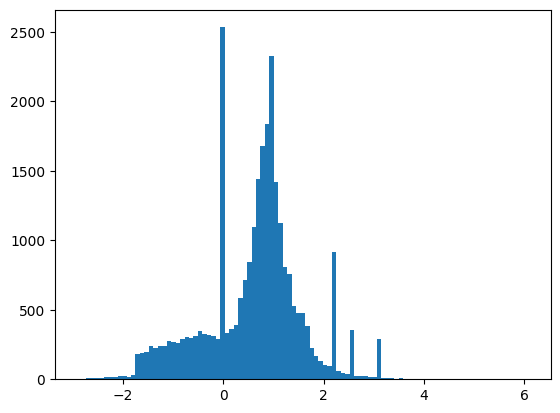

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short, use just the first 1,000 samples for validation, and the next 10,000 for training:

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

These datasets return individual examples. Use the `Dataset.batch` method to create batches of an appropriate size for training. Before batching, also remember to use `Dataset.shuffle` and `Dataset.repeat` on the training set.

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only densely-connected layers (`tf.keras.layers.Dense`) as a baseline, then create larger models, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `tf.keras.optimizers.schedules` to reduce the learning rate over time:

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `tf.keras.optimizers.schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.

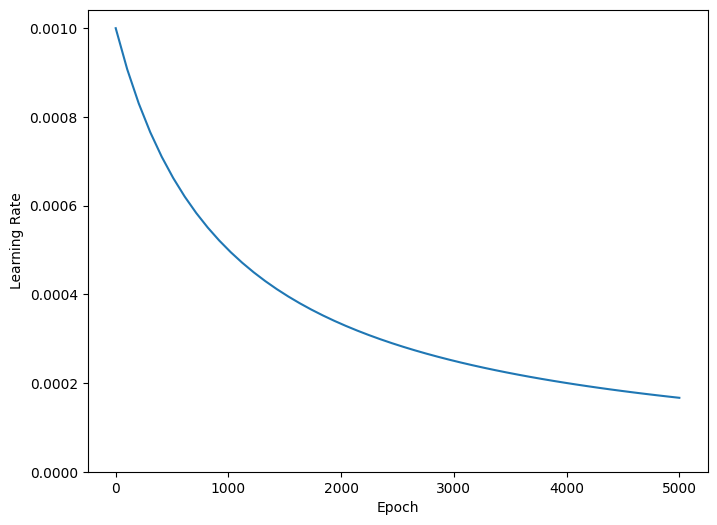

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `tf.keras.callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

Start by training a model:

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                464       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 481 (1.88 KB)


Trainable params: 481 (1.88 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


I0000 00:00:1701920631.363469  134387 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch: 0, accuracy:0.4918,  binary_crossentropy:0.7675,  loss:0.7675,  val_accuracy:0.4950,  val_binary_crossentropy:0.7316,  val_loss:0.7316,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6011,  binary_crossentropy:0.6241,  loss:0.6241,  val_accuracy:0.5950,  val_binary_crossentropy:0.6267,  val_loss:0.6267,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6308,  binary_crossentropy:0.6114,  loss:0.6114,  val_accuracy:0.5910,  val_binary_crossentropy:0.6189,  val_loss:0.6189,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6376,  binary_crossentropy:0.6035,  loss:0.6035,  val_accuracy:0.6330,  val_binary_crossentropy:0.6097,  val_loss:0.6097,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6477,  binary_crossentropy:0.5967,  loss:0.5967,  val_accuracy:0.6190,  val_binary_crossentropy:0.6056,  val_loss:0.6056,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6519,  binary_crossentropy:0.5914,  loss:0.5914,  val_accuracy:0.6460,  val_binary_crossentropy:0.6010,  val_loss:0.6010,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6648,  binary_crossentropy:0.5871,  loss:0.5871,  val_accuracy:0.6240,  val_binary_crossentropy:0.6015,  val_loss:0.6015,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6625,  binary_crossentropy:0.5851,  loss:0.5851,  val_accuracy:0.6450,  val_binary_crossentropy:0.5982,  val_loss:0.5982,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6739,  binary_crossentropy:0.5811,  loss:0.5811,  val_accuracy:0.6460,  val_binary_crossentropy:0.5975,  val_loss:0.5975,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.6714,  binary_crossentropy:0.5789,  loss:0.5789,  val_accuracy:0.6570,  val_binary_crossentropy:0.5963,  val_loss:0.5963,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1000, accuracy:0.6752,  binary_crossentropy:0.5773,  loss:0.5773,  val_accuracy:0.6500,  val_binary_crossentropy:0.5964,  val_loss:0.5964,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1100, accuracy:0.6786,  binary_crossentropy:0.5758,  loss:0.5758,  val_accuracy:0.6530,  val_binary_crossentropy:0.5948,  val_loss:0.5948,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1200, accuracy:0.6811,  binary_crossentropy:0.5744,  loss:0.5744,  val_accuracy:0.6440,  val_binary_crossentropy:0.5954,  val_loss:0.5954,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1300, accuracy:0.6841,  binary_crossentropy:0.5735,  loss:0.5735,  val_accuracy:0.6470,  val_binary_crossentropy:0.5938,  val_loss:0.5938,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1400, accuracy:0.6789,  binary_crossentropy:0.5723,  loss:0.5723,  val_accuracy:0.6460,  val_binary_crossentropy:0.5923,  val_loss:0.5923,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1500, accuracy:0.6826,  binary_crossentropy:0.5715,  loss:0.5715,  val_accuracy:0.6560,  val_binary_crossentropy:0.5903,  val_loss:0.5903,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1600, accuracy:0.6867,  binary_crossentropy:0.5703,  loss:0.5703,  val_accuracy:0.6480,  val_binary_crossentropy:0.5904,  val_loss:0.5904,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1700, accuracy:0.6904,  binary_crossentropy:0.5695,  loss:0.5695,  val_accuracy:0.6460,  val_binary_crossentropy:0.5907,  val_loss:0.5907,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1800, accuracy:0.6847,  binary_crossentropy:0.5683,  loss:0.5683,  val_accuracy:0.6570,  val_binary_crossentropy:0.5874,  val_loss:0.5874,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1900, accuracy:0.6884,  binary_crossentropy:0.5677,  loss:0.5677,  val_accuracy:0.6500,  val_binary_crossentropy:0.5892,  val_loss:0.5892,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 2000, accuracy:0.6842,  binary_crossentropy:0.5669,  loss:0.5669,  val_accuracy:0.6690,  val_binary_crossentropy:0.5855,  val_loss:0.5855,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 2100, accuracy:0.6903,  binary_crossentropy:0.5663,  loss:0.5663,  val_accuracy:0.6530,  val_binary_crossentropy:0.5870,  val_loss:0.5870,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 2200, accuracy:0.6912,  binary_crossentropy:0.5656,  loss:0.5656,  val_accuracy:0.6570,  val_binary_crossentropy:0.5865,  val_loss:0.5865,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 2300, accuracy:0.6896,  binary_crossentropy:0.5653,  loss:0.5653,  val_accuracy:0.6500,  val_binary_crossentropy:0.5875,  val_loss:0.5875,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 2400, accuracy:0.6911,  binary_crossentropy:0.5649,  loss:0.5649,  val_accuracy:0.6680,  val_binary_crossentropy:0.5854,  val_loss:0.5854,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 2500, accuracy:0.6862,  binary_crossentropy:0.5643,  loss:0.5643,  val_accuracy:0.6650,  val_binary_crossentropy:0.5853,  val_loss:0.5853,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

Now check how the model did:

(0.5, 0.7)

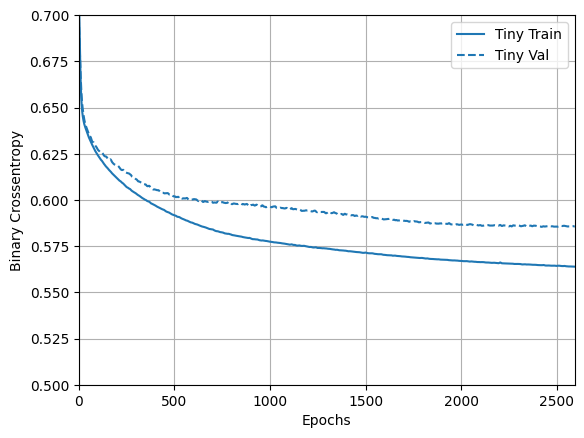

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

To check if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_2 (Dense)             (None, 16)                464       


 dense_3 (Dense)             (None, 16)                272       


 dense_4 (Dense)             (None, 1)                 17        


Total params: 753 (2.94 KB)


Trainable params: 753 (2.94 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5006,  binary_crossentropy:0.7231,  loss:0.7231,  val_accuracy:0.4770,  val_binary_crossentropy:0.7095,  val_loss:0.7095,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6197,  binary_crossentropy:0.6124,  loss:0.6124,  val_accuracy:0.5830,  val_binary_crossentropy:0.6258,  val_loss:0.6258,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6558,  binary_crossentropy:0.5896,  loss:0.5896,  val_accuracy:0.6340,  val_binary_crossentropy:0.5985,  val_loss:0.5985,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6704,  binary_crossentropy:0.5794,  loss:0.5794,  val_accuracy:0.6620,  val_binary_crossentropy:0.5886,  val_loss:0.5886,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6785,  binary_crossentropy:0.5737,  loss:0.5737,  val_accuracy:0.6770,  val_binary_crossentropy:0.5865,  val_loss:0.5865,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6859,  binary_crossentropy:0.5692,  loss:0.5692,  val_accuracy:0.6710,  val_binary_crossentropy:0.5881,  val_loss:0.5881,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Medium model

Now try three hidden layers with 64 units each:

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_5 (Dense)             (None, 64)                1856      


 dense_6 (Dense)             (None, 64)                4160      


 dense_7 (Dense)             (None, 64)                4160      


 dense_8 (Dense)             (None, 1)                 65        


Total params: 10241 (40.00 KB)


Trainable params: 10241 (40.00 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.4919,  binary_crossentropy:0.7090,  loss:0.7090,  val_accuracy:0.4620,  val_binary_crossentropy:0.6829,  val_loss:0.6829,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.7212,  binary_crossentropy:0.5232,  loss:0.5232,  val_accuracy:0.6670,  val_binary_crossentropy:0.6108,  val_loss:0.6108,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.7918,  binary_crossentropy:0.4255,  loss:0.4255,  val_accuracy:0.6220,  val_binary_crossentropy:0.7186,  val_loss:0.7186,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Large model

As an exercise, you can create an even larger model and check how quickly it begins overfitting. Next, add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             (None, 512)               14848     


 dense_10 (Dense)            (None, 512)               262656    


 dense_11 (Dense)            (None, 512)               262656    


 dense_12 (Dense)            (None, 512)               262656    


 dense_13 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5037,  binary_crossentropy:0.8374,  loss:0.8374,  val_accuracy:0.4700,  val_binary_crossentropy:0.6832,  val_loss:0.6832,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0023,  loss:0.0023,  val_accuracy:0.6580,  val_binary_crossentropy:1.7674,  val_loss:1.7674,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6580,  val_binary_crossentropy:2.4198,  val_loss:2.4198,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really figure out what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

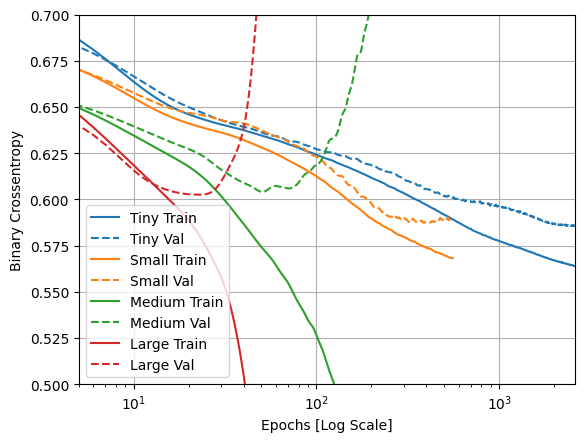

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook (Sorry, this doesn't
display on tensorflow.org):

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [32]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmpfs/tmp/tmpoh3mhnxb/tensorboard_logs/regularizers/Tiny')

In [33]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as demonstrated in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero, encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights—one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Add L2 weight regularization:

In [34]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_14 (Dense)            (None, 512)               14848     


 dense_15 (Dense)            (None, 512)               262656    


 dense_16 (Dense)            (None, 512)               262656    


 dense_17 (Dense)            (None, 512)               262656    


 dense_18 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5065,  binary_crossentropy:0.7795,  loss:2.2895,  val_accuracy:0.4800,  val_binary_crossentropy:0.6897,  val_loss:2.1137,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6559,  binary_crossentropy:0.5954,  loss:0.6179,  val_accuracy:0.6230,  val_binary_crossentropy:0.5876,  val_loss:0.6101,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6787,  binary_crossentropy:0.5759,  loss:0.6006,  val_accuracy:0.6880,  val_binary_crossentropy:0.5795,  val_loss:0.6041,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6932,  binary_crossentropy:0.5693,  loss:0.5936,  val_accuracy:0.6630,  val_binary_crossentropy:0.5832,  val_loss:0.6074,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6934,  binary_crossentropy:0.5635,  loss:0.5880,  val_accuracy:0.6760,  val_binary_crossentropy:0.5866,  val_loss:0.6110,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.5, 0.7)

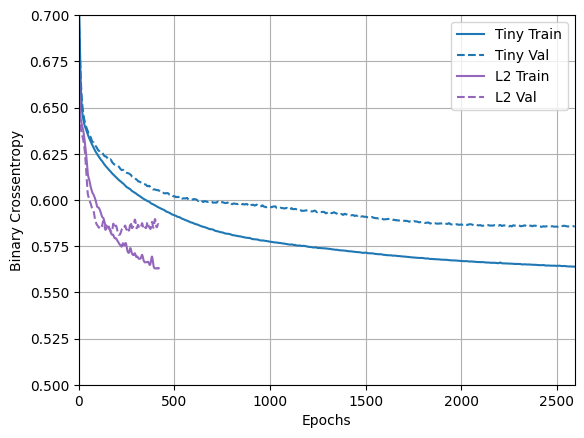

In [35]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As demonstrated in the diagram above, the `"L2"` regularized model is now much more competitive with the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization:

1. If you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [36]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

2. This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "decoupled weight decay" is used in optimizers like `tf.keras.optimizers.Ftrl` and `tfa.optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. For example, a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 1.3, 0, 1.1]`.

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In Keras, you can introduce dropout in a network via the `tf.keras.layers.Dropout` layer, which gets applied to the output of layer right before.

Add two dropout layers to your network to check how well they do at reducing overfitting:

In [37]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_19 (Dense)            (None, 512)               14848     


 dropout (Dropout)           (None, 512)               0         


 dense_20 (Dense)            (None, 512)               262656    


 dropout_1 (Dropout)         (None, 512)               0         


 dense_21 (Dense)            (None, 512)               262656    


 dropout_2 (Dropout)         (None, 512)               0         


 dense_22 (Dense)            (None, 512)               262656    


 dropout_3 (Dropout)         (None, 512)               0         


 dense_23 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5102,  binary_crossentropy:0.7970,  loss:0.7970,  val_accuracy:0.5780,  val_binary_crossentropy:0.7022,  val_loss:0.7022,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6455,  binary_crossentropy:0.5948,  loss:0.5948,  val_accuracy:0.6780,  val_binary_crossentropy:0.5836,  val_loss:0.5836,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6880,  binary_crossentropy:0.5525,  loss:0.5525,  val_accuracy:0.6920,  val_binary_crossentropy:0.5800,  val_loss:0.5800,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.7195,  binary_crossentropy:0.5094,  loss:0.5094,  val_accuracy:0.6950,  val_binary_crossentropy:0.6083,  val_loss:0.6083,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

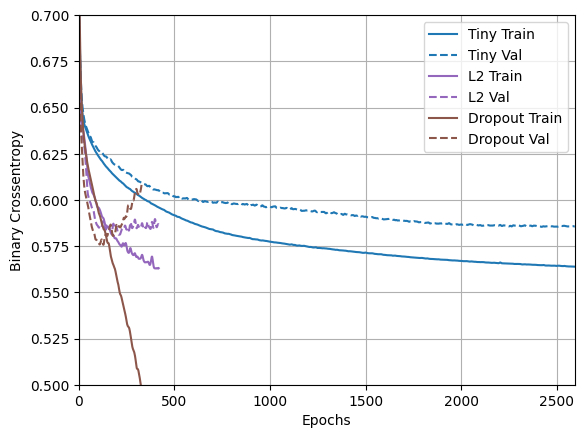

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [39]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_24 (Dense)            (None, 512)               14848     


 dropout_4 (Dropout)         (None, 512)               0         


 dense_25 (Dense)            (None, 512)               262656    


 dropout_5 (Dropout)         (None, 512)               0         


 dense_26 (Dense)            (None, 512)               262656    


 dropout_6 (Dropout)         (None, 512)               0         


 dense_27 (Dense)            (None, 512)               262656    


 dropout_7 (Dropout)         (None, 512)               0         


 dense_28 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5020,  binary_crossentropy:0.7982,  loss:0.9563,  val_accuracy:0.5240,  val_binary_crossentropy:0.6770,  val_loss:0.8344,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6500,  binary_crossentropy:0.6020,  loss:0.6314,  val_accuracy:0.6760,  val_binary_crossentropy:0.5811,  val_loss:0.6103,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6733,  binary_crossentropy:0.5863,  loss:0.6126,  val_accuracy:0.6760,  val_binary_crossentropy:0.5730,  val_loss:0.5993,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6731,  binary_crossentropy:0.5841,  loss:0.6120,  val_accuracy:0.6940,  val_binary_crossentropy:0.5671,  val_loss:0.5950,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6783,  binary_crossentropy:0.5743,  loss:0.6040,  val_accuracy:0.6790,  val_binary_crossentropy:0.5573,  val_loss:0.5871,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6843,  binary_crossentropy:0.5709,  loss:0.6033,  val_accuracy:0.6770,  val_binary_crossentropy:0.5562,  val_loss:0.5887,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6902,  binary_crossentropy:0.5660,  loss:0.6006,  val_accuracy:0.6840,  val_binary_crossentropy:0.5406,  val_loss:0.5751,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6888,  binary_crossentropy:0.5605,  loss:0.5973,  val_accuracy:0.7030,  val_binary_crossentropy:0.5456,  val_loss:0.5824,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6890,  binary_crossentropy:0.5583,  loss:0.5969,  val_accuracy:0.6960,  val_binary_crossentropy:0.5503,  val_loss:0.5888,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

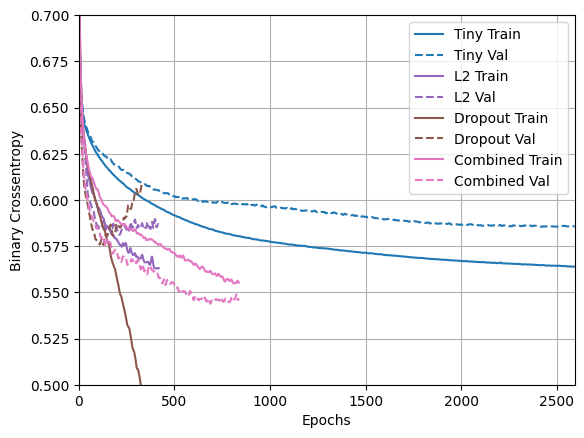

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded run the following into a code-cell  (Sorry, this doesn't display on tensorflow.org):

In [ ]:
%tensorboard --logdir {logdir}/regularizers

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

## Conclusions

To recap, here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* [Data augmentation](../images/data_augmentation.ipynb)
* Batch normalization (`tf.keras.layers.BatchNormalization`)

Remember that each method can help on its own, but often combining them can be even more effective.